##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official==2.7.0

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

   16384/84125825 [..............................] - ETA: 0s

   24576/84125825 [..............................] - ETA: 7:43

   57344/84125825 [..............................] - ETA: 6:37

   90112/84125825 [..............................] - ETA: 6:19

  139264/84125825 [..............................] - ETA: 5:26

  188416/84125825 [..............................] - ETA: 5:01

  270336/84125825 [..............................] - ETA: 4:12

  368640/84125825 [..............................] - ETA: 3:35

  483328/84125825 [..............................] - ETA: 3:07

  614400/84125825 [..............................] - ETA: 2:45

  761856/84125825 [..............................] - ETA: 2:28

  909312/84125825 [..............................] - ETA: 2:16

 1089536/84125825 [..............................] - ETA: 2:04

 1318912/84125825 [..............................] - ETA: 1:50

 1581056/84125825 [..............................] - ETA: 1:39

 1892352/84125825 [..............................] - ETA: 1:28

 2285568/84125825 [..............................] - ETA: 1:17

 2760704/84125825 [..............................] - ETA: 1:07

 3350528/84125825 [>.............................] - ETA: 58s 

 4104192/84125825 [>.............................] - ETA: 50s

 5005312/84125825 [>.............................] - ETA: 42s

 6119424/84125825 [=>............................] - ETA: 36s

 7512064/84125825 [=>............................] - ETA: 30s

 9216000/84125825 [==>...........................] - ETA: 25s

11280384/84125825 [===>..........................] - ETA: 21s

13803520/84125825 [===>..........................] - ETA: 17s

16441344/84125825 [====>.........................] - ETA: 14s

19390464/84125825 [=====>........................] - ETA: 12s

22519808/84125825 [=======>......................] - ETA: 10s

22749184/84125825 [=======>......................] - ETA: 10s

25649152/84125825 [========>.....................] - ETA: 8s 

25845760/84125825 [========>.....................] - ETA: 8s

28549120/84125825 [=========>....................] - ETA: 7s

28778496/84125825 [=========>....................] - ETA: 7s

31137792/84125825 [==========>...................] - ETA: 7s

31924224/84125825 [==========>...................] - ETA: 6s

33873920/84125825 [===========>..................] - ETA: 6s

35053568/84125825 [===========>..................] - ETA: 6s

36626432/84125825 [============>.................] - ETA: 5s

38199296/84125825 [============>.................] - ETA: 5s

39362560/84125825 [=============>................] - ETA: 5s

41328640/84125825 [=============>................] - ETA: 4s

42196992/84125825 [==============>...............] - ETA: 4s

44457984/84125825 [==============>...............] - ETA: 4s

45342720/84125825 [===============>..............] - ETA: 4s

47603712/84125825 [===============>..............] - ETA: 3s

48439296/84125825 [================>.............] - ETA: 3s

50733056/84125825 [=================>............] - ETA: 3s

51568640/84125825 [=================>............] - ETA: 3s

53862400/84125825 [==================>...........] - ETA: 2s

54681600/84125825 [==================>...........] - ETA: 2s

57008128/84125825 [===================>..........] - ETA: 2s

57794560/84125825 [===================>..........] - ETA: 2s

60137472/84125825 [====================>.........] - ETA: 2s

60907520/84125825 [====================>.........] - ETA: 2s

62996480/84125825 [=====================>........] - ETA: 1s

63954944/84125825 [=====================>........] - ETA: 1s

64151552/84125825 [=====================>........] - ETA: 1s

66428928/84125825 [======================>.......] - ETA: 1s

67133440/84125825 [======================>.......] - ETA: 1s

68214784/84125825 [=======================>......] - ETA: 1s

70197248/84125825 [========================>.....] - ETA: 1s

70361088/84125825 [========================>.....] - ETA: 1s

72687616/84125825 [========================>.....] - ETA: 0s

73375744/84125825 [=========================>....] - ETA: 0s

73965568/84125825 [=========================>....] - ETA: 0s

76455936/84125825 [==========================>...] - ETA: 0s

76587008/84125825 [==========================>...] - ETA: 0s

78962688/84125825 [===========================>..] - ETA: 0s

79618048/84125825 [===========================>..] - ETA: 0s

79798272/84125825 [===========================>..] - ETA: 0s

82731008/84125825 [============================>.] - ETA: 0s

82911232/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 7s 0us/step


84140032/84125825 [==============================] - 7s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2022-03-29 12:30:15.775528: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.2256118  -0.28925604 -0.07064401 ...  0.4756601   0.8327715
   0.40025353]
 [-0.29824278 -0.27473143 -0.05450511 ...  0.48849759  1.0955356
   0.18163344]
 [-0.44378197  0.00930723  0.07223766 ...  0.1729009   1.1833246
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.79717386]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

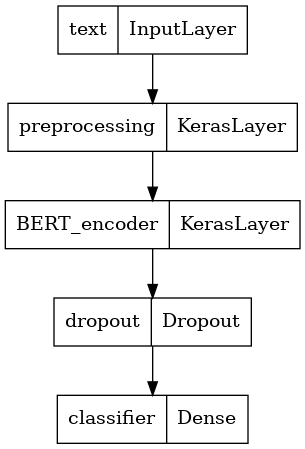

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 57:44 - loss: 1.1089 - binary_accuracy: 0.3438

  2/625 [..............................] - ETA: 1:17 - loss: 0.9750 - binary_accuracy: 0.4219 

  3/625 [..............................] - ETA: 1:17 - loss: 0.9179 - binary_accuracy: 0.4583

  4/625 [..............................] - ETA: 1:15 - loss: 0.9060 - binary_accuracy: 0.4688

  5/625 [..............................] - ETA: 1:14 - loss: 0.8894 - binary_accuracy: 0.4688

  6/625 [..............................] - ETA: 1:14 - loss: 0.9123 - binary_accuracy: 0.4479

  7/625 [..............................] - ETA: 1:13 - loss: 0.9131 - binary_accuracy: 0.4420

  8/625 [..............................] - ETA: 1:13 - loss: 0.9211 - binary_accuracy: 0.4453

  9/625 [..............................] - ETA: 1:13 - loss: 0.9162 - binary_accuracy: 0.4479

 10/625 [..............................] - ETA: 1:13 - loss: 0.8953 - binary_accuracy: 0.4688

 11/625 [..............................] - ETA: 1:13 - loss: 0.8868 - binary_accuracy: 0.4801

 12/625 [..............................] - ETA: 1:12 - loss: 0.8664 - binary_accuracy: 0.4896

 13/625 [..............................] - ETA: 1:12 - loss: 0.8553 - binary_accuracy: 0.5024

 14/625 [..............................] - ETA: 1:12 - loss: 0.8579 - binary_accuracy: 0.5022

 15/625 [..............................] - ETA: 1:11 - loss: 0.8552 - binary_accuracy: 0.4979

 16/625 [..............................] - ETA: 1:11 - loss: 0.8647 - binary_accuracy: 0.4902

 17/625 [..............................] - ETA: 1:11 - loss: 0.8524 - binary_accuracy: 0.5000

 18/625 [..............................] - ETA: 1:11 - loss: 0.8464 - binary_accuracy: 0.5052

 19/625 [..............................] - ETA: 1:11 - loss: 0.8428 - binary_accuracy: 0.5033

 20/625 [..............................] - ETA: 1:10 - loss: 0.8372 - binary_accuracy: 0.5063

 21/625 [>.............................] - ETA: 1:10 - loss: 0.8353 - binary_accuracy: 0.5089

 22/625 [>.............................] - ETA: 1:10 - loss: 0.8277 - binary_accuracy: 0.5114

 23/625 [>.............................] - ETA: 1:10 - loss: 0.8216 - binary_accuracy: 0.5122

 24/625 [>.............................] - ETA: 1:10 - loss: 0.8215 - binary_accuracy: 0.5169

 25/625 [>.............................] - ETA: 1:10 - loss: 0.8168 - binary_accuracy: 0.5113

 26/625 [>.............................] - ETA: 1:10 - loss: 0.8107 - binary_accuracy: 0.5132

 27/625 [>.............................] - ETA: 1:10 - loss: 0.8071 - binary_accuracy: 0.5116

 28/625 [>.............................] - ETA: 1:09 - loss: 0.8025 - binary_accuracy: 0.5156

 29/625 [>.............................] - ETA: 1:09 - loss: 0.8007 - binary_accuracy: 0.5151

 30/625 [>.............................] - ETA: 1:09 - loss: 0.7960 - binary_accuracy: 0.5167

 31/625 [>.............................] - ETA: 1:09 - loss: 0.7919 - binary_accuracy: 0.5212

 32/625 [>.............................] - ETA: 1:09 - loss: 0.7898 - binary_accuracy: 0.5264

 33/625 [>.............................] - ETA: 1:09 - loss: 0.7891 - binary_accuracy: 0.5275

 34/625 [>.............................] - ETA: 1:09 - loss: 0.7884 - binary_accuracy: 0.5257

 35/625 [>.............................] - ETA: 1:09 - loss: 0.7847 - binary_accuracy: 0.5268

 36/625 [>.............................] - ETA: 1:08 - loss: 0.7835 - binary_accuracy: 0.5269

 37/625 [>.............................] - ETA: 1:08 - loss: 0.7842 - binary_accuracy: 0.5228

 38/625 [>.............................] - ETA: 1:08 - loss: 0.7794 - binary_accuracy: 0.5247

 39/625 [>.............................] - ETA: 1:08 - loss: 0.7768 - binary_accuracy: 0.5256

 40/625 [>.............................] - ETA: 1:08 - loss: 0.7748 - binary_accuracy: 0.5250

 41/625 [>.............................] - ETA: 1:08 - loss: 0.7721 - binary_accuracy: 0.5282

 42/625 [=>............................] - ETA: 1:08 - loss: 0.7706 - binary_accuracy: 0.5298

 43/625 [=>............................] - ETA: 1:08 - loss: 0.7682 - binary_accuracy: 0.5320

 44/625 [=>............................] - ETA: 1:08 - loss: 0.7687 - binary_accuracy: 0.5291

 45/625 [=>............................] - ETA: 1:08 - loss: 0.7667 - binary_accuracy: 0.5306

 46/625 [=>............................] - ETA: 1:08 - loss: 0.7624 - binary_accuracy: 0.5340

 47/625 [=>............................] - ETA: 1:07 - loss: 0.7612 - binary_accuracy: 0.5332

 48/625 [=>............................] - ETA: 1:07 - loss: 0.7583 - binary_accuracy: 0.5358

 49/625 [=>............................] - ETA: 1:07 - loss: 0.7576 - binary_accuracy: 0.5370

 50/625 [=>............................] - ETA: 1:07 - loss: 0.7566 - binary_accuracy: 0.5375

 51/625 [=>............................] - ETA: 1:07 - loss: 0.7548 - binary_accuracy: 0.5386

 52/625 [=>............................] - ETA: 1:07 - loss: 0.7515 - binary_accuracy: 0.5385

 53/625 [=>............................] - ETA: 1:07 - loss: 0.7481 - binary_accuracy: 0.5389

 54/625 [=>............................] - ETA: 1:07 - loss: 0.7477 - binary_accuracy: 0.5388

 55/625 [=>............................] - ETA: 1:06 - loss: 0.7464 - binary_accuracy: 0.5386

 56/625 [=>............................] - ETA: 1:06 - loss: 0.7459 - binary_accuracy: 0.5379

 57/625 [=>............................] - ETA: 1:06 - loss: 0.7425 - binary_accuracy: 0.5395

 58/625 [=>............................] - ETA: 1:06 - loss: 0.7404 - binary_accuracy: 0.5399

 59/625 [=>............................] - ETA: 1:06 - loss: 0.7390 - binary_accuracy: 0.5413

 60/625 [=>............................] - ETA: 1:06 - loss: 0.7381 - binary_accuracy: 0.5443

 61/625 [=>............................] - ETA: 1:06 - loss: 0.7355 - binary_accuracy: 0.5476

 62/625 [=>............................] - ETA: 1:05 - loss: 0.7338 - binary_accuracy: 0.5494

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.7327 - binary_accuracy: 0.5501

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.7309 - binary_accuracy: 0.5508

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.7302 - binary_accuracy: 0.5510

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.7278 - binary_accuracy: 0.5530

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.7269 - binary_accuracy: 0.5527

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.7251 - binary_accuracy: 0.5538

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.7243 - binary_accuracy: 0.5530

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.7233 - binary_accuracy: 0.5536

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.7221 - binary_accuracy: 0.5546

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.7208 - binary_accuracy: 0.5543

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.7203 - binary_accuracy: 0.5535

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.7186 - binary_accuracy: 0.5545

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.7176 - binary_accuracy: 0.5542

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.7165 - binary_accuracy: 0.5535

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.7155 - binary_accuracy: 0.5532

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.7152 - binary_accuracy: 0.5541

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.7134 - binary_accuracy: 0.5562

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.7121 - binary_accuracy: 0.5570

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.7099 - binary_accuracy: 0.5586

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.7084 - binary_accuracy: 0.5598

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.7078 - binary_accuracy: 0.5614

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.7058 - binary_accuracy: 0.5636

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.7053 - binary_accuracy: 0.5654

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.7047 - binary_accuracy: 0.5680

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.7027 - binary_accuracy: 0.5693

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.7008 - binary_accuracy: 0.5707

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.7003 - binary_accuracy: 0.5706

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.6991 - binary_accuracy: 0.5719

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.6992 - binary_accuracy: 0.5714

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.6975 - binary_accuracy: 0.5737

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.6966 - binary_accuracy: 0.5746

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.6952 - binary_accuracy: 0.5771

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.6946 - binary_accuracy: 0.5780

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.6931 - binary_accuracy: 0.5794

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.6919 - binary_accuracy: 0.5799

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.6908 - binary_accuracy: 0.5804

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.6900 - binary_accuracy: 0.5814

100/625 [===>..........................] - ETA: 1:01 - loss: 0.6889 - binary_accuracy: 0.5819

101/625 [===>..........................] - ETA: 1:01 - loss: 0.6892 - binary_accuracy: 0.5804

102/625 [===>..........................] - ETA: 1:01 - loss: 0.6883 - binary_accuracy: 0.5797

103/625 [===>..........................] - ETA: 1:01 - loss: 0.6876 - binary_accuracy: 0.5804

104/625 [===>..........................] - ETA: 1:01 - loss: 0.6861 - binary_accuracy: 0.5823

105/625 [====>.........................] - ETA: 1:01 - loss: 0.6853 - binary_accuracy: 0.5827

106/625 [====>.........................] - ETA: 1:01 - loss: 0.6840 - binary_accuracy: 0.5834

107/625 [====>.........................] - ETA: 1:00 - loss: 0.6830 - binary_accuracy: 0.5847

108/625 [====>.........................] - ETA: 1:00 - loss: 0.6812 - binary_accuracy: 0.5859

109/625 [====>.........................] - ETA: 1:00 - loss: 0.6798 - binary_accuracy: 0.5874

110/625 [====>.........................] - ETA: 1:00 - loss: 0.6792 - binary_accuracy: 0.5875

111/625 [====>.........................] - ETA: 1:00 - loss: 0.6783 - binary_accuracy: 0.5887

112/625 [====>.........................] - ETA: 1:00 - loss: 0.6768 - binary_accuracy: 0.5893

113/625 [====>.........................] - ETA: 1:00 - loss: 0.6759 - binary_accuracy: 0.5896

114/625 [====>.........................] - ETA: 1:00 - loss: 0.6757 - binary_accuracy: 0.5902

115/625 [====>.........................] - ETA: 1:00 - loss: 0.6740 - binary_accuracy: 0.5918

116/625 [====>.........................] - ETA: 59s - loss: 0.6738 - binary_accuracy: 0.5916 

117/625 [====>.........................] - ETA: 59s - loss: 0.6732 - binary_accuracy: 0.5908

118/625 [====>.........................] - ETA: 59s - loss: 0.6721 - binary_accuracy: 0.5916

119/625 [====>.........................] - ETA: 59s - loss: 0.6709 - binary_accuracy: 0.5927

120/625 [====>.........................] - ETA: 59s - loss: 0.6701 - binary_accuracy: 0.5943

121/625 [====>.........................] - ETA: 59s - loss: 0.6699 - binary_accuracy: 0.5938

122/625 [====>.........................] - ETA: 59s - loss: 0.6693 - binary_accuracy: 0.5945

123/625 [====>.........................] - ETA: 59s - loss: 0.6694 - binary_accuracy: 0.5948

124/625 [====>.........................] - ETA: 59s - loss: 0.6684 - binary_accuracy: 0.5950

125/625 [=====>........................] - ETA: 58s - loss: 0.6676 - binary_accuracy: 0.5962

126/625 [=====>........................] - ETA: 58s - loss: 0.6667 - binary_accuracy: 0.5967

127/625 [=====>........................] - ETA: 58s - loss: 0.6652 - binary_accuracy: 0.5987

128/625 [=====>........................] - ETA: 58s - loss: 0.6637 - binary_accuracy: 0.6008

129/625 [=====>........................] - ETA: 58s - loss: 0.6638 - binary_accuracy: 0.6015

130/625 [=====>........................] - ETA: 58s - loss: 0.6633 - binary_accuracy: 0.6017

131/625 [=====>........................] - ETA: 58s - loss: 0.6625 - binary_accuracy: 0.6021

132/625 [=====>........................] - ETA: 58s - loss: 0.6616 - binary_accuracy: 0.6032

133/625 [=====>........................] - ETA: 58s - loss: 0.6601 - binary_accuracy: 0.6043

134/625 [=====>........................] - ETA: 57s - loss: 0.6598 - binary_accuracy: 0.6047

135/625 [=====>........................] - ETA: 57s - loss: 0.6593 - binary_accuracy: 0.6060

136/625 [=====>........................] - ETA: 57s - loss: 0.6578 - binary_accuracy: 0.6071

137/625 [=====>........................] - ETA: 57s - loss: 0.6563 - binary_accuracy: 0.6083

138/625 [=====>........................] - ETA: 57s - loss: 0.6554 - binary_accuracy: 0.6082

139/625 [=====>........................] - ETA: 57s - loss: 0.6547 - binary_accuracy: 0.6081

140/625 [=====>........................] - ETA: 57s - loss: 0.6542 - binary_accuracy: 0.6089

141/625 [=====>........................] - ETA: 57s - loss: 0.6531 - binary_accuracy: 0.6090

142/625 [=====>........................] - ETA: 56s - loss: 0.6520 - binary_accuracy: 0.6100

143/625 [=====>........................] - ETA: 56s - loss: 0.6518 - binary_accuracy: 0.6108

144/625 [=====>........................] - ETA: 56s - loss: 0.6509 - binary_accuracy: 0.6118

145/625 [=====>........................] - ETA: 56s - loss: 0.6512 - binary_accuracy: 0.6116

146/625 [======>.......................] - ETA: 56s - loss: 0.6502 - binary_accuracy: 0.6122

147/625 [======>.......................] - ETA: 56s - loss: 0.6494 - binary_accuracy: 0.6125

148/625 [======>.......................] - ETA: 56s - loss: 0.6488 - binary_accuracy: 0.6134

149/625 [======>.......................] - ETA: 56s - loss: 0.6480 - binary_accuracy: 0.6143

150/625 [======>.......................] - ETA: 56s - loss: 0.6479 - binary_accuracy: 0.6148

151/625 [======>.......................] - ETA: 55s - loss: 0.6466 - binary_accuracy: 0.6167

152/625 [======>.......................] - ETA: 55s - loss: 0.6456 - binary_accuracy: 0.6178

153/625 [======>.......................] - ETA: 55s - loss: 0.6445 - binary_accuracy: 0.6181

154/625 [======>.......................] - ETA: 55s - loss: 0.6444 - binary_accuracy: 0.6183

155/625 [======>.......................] - ETA: 55s - loss: 0.6433 - binary_accuracy: 0.6187

156/625 [======>.......................] - ETA: 55s - loss: 0.6417 - binary_accuracy: 0.6200

157/625 [======>.......................] - ETA: 55s - loss: 0.6416 - binary_accuracy: 0.6206

158/625 [======>.......................] - ETA: 55s - loss: 0.6412 - binary_accuracy: 0.6216

159/625 [======>.......................] - ETA: 55s - loss: 0.6405 - binary_accuracy: 0.6224

160/625 [======>.......................] - ETA: 54s - loss: 0.6396 - binary_accuracy: 0.6232

161/625 [======>.......................] - ETA: 54s - loss: 0.6383 - binary_accuracy: 0.6246

162/625 [======>.......................] - ETA: 54s - loss: 0.6376 - binary_accuracy: 0.6252

163/625 [======>.......................] - ETA: 54s - loss: 0.6362 - binary_accuracy: 0.6263

164/625 [======>.......................] - ETA: 54s - loss: 0.6363 - binary_accuracy: 0.6256

165/625 [======>.......................] - ETA: 54s - loss: 0.6350 - binary_accuracy: 0.6271

166/625 [======>.......................] - ETA: 54s - loss: 0.6347 - binary_accuracy: 0.6274

167/625 [=======>......................] - ETA: 54s - loss: 0.6339 - binary_accuracy: 0.6276

168/625 [=======>......................] - ETA: 53s - loss: 0.6333 - binary_accuracy: 0.6282

169/625 [=======>......................] - ETA: 53s - loss: 0.6323 - binary_accuracy: 0.6293

170/625 [=======>......................] - ETA: 53s - loss: 0.6314 - binary_accuracy: 0.6298

171/625 [=======>......................] - ETA: 53s - loss: 0.6310 - binary_accuracy: 0.6299

172/625 [=======>......................] - ETA: 53s - loss: 0.6296 - binary_accuracy: 0.6306

173/625 [=======>......................] - ETA: 53s - loss: 0.6288 - binary_accuracy: 0.6319

174/625 [=======>......................] - ETA: 53s - loss: 0.6274 - binary_accuracy: 0.6331

175/625 [=======>......................] - ETA: 53s - loss: 0.6267 - binary_accuracy: 0.6339

176/625 [=======>......................] - ETA: 52s - loss: 0.6257 - binary_accuracy: 0.6348

177/625 [=======>......................] - ETA: 52s - loss: 0.6249 - binary_accuracy: 0.6356

178/625 [=======>......................] - ETA: 52s - loss: 0.6240 - binary_accuracy: 0.6366

179/625 [=======>......................] - ETA: 52s - loss: 0.6230 - binary_accuracy: 0.6372

180/625 [=======>......................] - ETA: 52s - loss: 0.6223 - binary_accuracy: 0.6375

181/625 [=======>......................] - ETA: 52s - loss: 0.6212 - binary_accuracy: 0.6381

182/625 [=======>......................] - ETA: 52s - loss: 0.6208 - binary_accuracy: 0.6386

183/625 [=======>......................] - ETA: 52s - loss: 0.6204 - binary_accuracy: 0.6390

184/625 [=======>......................] - ETA: 51s - loss: 0.6194 - binary_accuracy: 0.6403

185/625 [=======>......................] - ETA: 51s - loss: 0.6180 - binary_accuracy: 0.6414

186/625 [=======>......................] - ETA: 51s - loss: 0.6173 - binary_accuracy: 0.6421

187/625 [=======>......................] - ETA: 51s - loss: 0.6158 - binary_accuracy: 0.6432

188/625 [========>.....................] - ETA: 51s - loss: 0.6142 - binary_accuracy: 0.6444

189/625 [========>.....................] - ETA: 51s - loss: 0.6129 - binary_accuracy: 0.6453

190/625 [========>.....................] - ETA: 51s - loss: 0.6126 - binary_accuracy: 0.6457

191/625 [========>.....................] - ETA: 51s - loss: 0.6112 - binary_accuracy: 0.6468

192/625 [========>.....................] - ETA: 51s - loss: 0.6099 - binary_accuracy: 0.6476

193/625 [========>.....................] - ETA: 50s - loss: 0.6094 - binary_accuracy: 0.6483

194/625 [========>.....................] - ETA: 50s - loss: 0.6086 - binary_accuracy: 0.6492

195/625 [========>.....................] - ETA: 50s - loss: 0.6079 - binary_accuracy: 0.6498

196/625 [========>.....................] - ETA: 50s - loss: 0.6082 - binary_accuracy: 0.6500

197/625 [========>.....................] - ETA: 50s - loss: 0.6080 - binary_accuracy: 0.6505

198/625 [========>.....................] - ETA: 50s - loss: 0.6070 - binary_accuracy: 0.6512

199/625 [========>.....................] - ETA: 50s - loss: 0.6066 - binary_accuracy: 0.6515

200/625 [========>.....................] - ETA: 50s - loss: 0.6058 - binary_accuracy: 0.6522

201/625 [========>.....................] - ETA: 49s - loss: 0.6059 - binary_accuracy: 0.6527

202/625 [========>.....................] - ETA: 49s - loss: 0.6045 - binary_accuracy: 0.6538

203/625 [========>.....................] - ETA: 49s - loss: 0.6042 - binary_accuracy: 0.6542

204/625 [========>.....................] - ETA: 49s - loss: 0.6033 - binary_accuracy: 0.6552

205/625 [========>.....................] - ETA: 49s - loss: 0.6029 - binary_accuracy: 0.6556

206/625 [========>.....................] - ETA: 49s - loss: 0.6020 - binary_accuracy: 0.6564

207/625 [========>.....................] - ETA: 49s - loss: 0.6022 - binary_accuracy: 0.6564

208/625 [========>.....................] - ETA: 49s - loss: 0.6018 - binary_accuracy: 0.6569

209/625 [=========>....................] - ETA: 49s - loss: 0.6008 - binary_accuracy: 0.6579

210/625 [=========>....................] - ETA: 48s - loss: 0.6005 - binary_accuracy: 0.6583

211/625 [=========>....................] - ETA: 48s - loss: 0.5995 - binary_accuracy: 0.6588

212/625 [=========>....................] - ETA: 48s - loss: 0.5991 - binary_accuracy: 0.6593

213/625 [=========>....................] - ETA: 48s - loss: 0.5981 - binary_accuracy: 0.6602

214/625 [=========>....................] - ETA: 48s - loss: 0.5971 - binary_accuracy: 0.6611

215/625 [=========>....................] - ETA: 48s - loss: 0.5975 - binary_accuracy: 0.6608

216/625 [=========>....................] - ETA: 48s - loss: 0.5972 - binary_accuracy: 0.6612

217/625 [=========>....................] - ETA: 48s - loss: 0.5965 - binary_accuracy: 0.6620

218/625 [=========>....................] - ETA: 47s - loss: 0.5952 - binary_accuracy: 0.6627

219/625 [=========>....................] - ETA: 47s - loss: 0.5947 - binary_accuracy: 0.6632

220/625 [=========>....................] - ETA: 47s - loss: 0.5939 - binary_accuracy: 0.6636

221/625 [=========>....................] - ETA: 47s - loss: 0.5928 - binary_accuracy: 0.6645

222/625 [=========>....................] - ETA: 47s - loss: 0.5918 - binary_accuracy: 0.6651

223/625 [=========>....................] - ETA: 47s - loss: 0.5909 - binary_accuracy: 0.6656

224/625 [=========>....................] - ETA: 47s - loss: 0.5908 - binary_accuracy: 0.6656

225/625 [=========>....................] - ETA: 47s - loss: 0.5904 - binary_accuracy: 0.6662

226/625 [=========>....................] - ETA: 46s - loss: 0.5894 - binary_accuracy: 0.6669

227/625 [=========>....................] - ETA: 46s - loss: 0.5884 - binary_accuracy: 0.6675

228/625 [=========>....................] - ETA: 46s - loss: 0.5875 - binary_accuracy: 0.6684

229/625 [=========>....................] - ETA: 46s - loss: 0.5870 - binary_accuracy: 0.6685

230/625 [==========>...................] - ETA: 46s - loss: 0.5866 - binary_accuracy: 0.6687

231/625 [==========>...................] - ETA: 46s - loss: 0.5858 - binary_accuracy: 0.6694

232/625 [==========>...................] - ETA: 46s - loss: 0.5847 - binary_accuracy: 0.6701

233/625 [==========>...................] - ETA: 46s - loss: 0.5836 - binary_accuracy: 0.6707

234/625 [==========>...................] - ETA: 45s - loss: 0.5834 - binary_accuracy: 0.6707

235/625 [==========>...................] - ETA: 45s - loss: 0.5827 - binary_accuracy: 0.6711

236/625 [==========>...................] - ETA: 45s - loss: 0.5830 - binary_accuracy: 0.6708

237/625 [==========>...................] - ETA: 45s - loss: 0.5823 - binary_accuracy: 0.6714

238/625 [==========>...................] - ETA: 45s - loss: 0.5808 - binary_accuracy: 0.6727

239/625 [==========>...................] - ETA: 45s - loss: 0.5809 - binary_accuracy: 0.6727

240/625 [==========>...................] - ETA: 45s - loss: 0.5801 - binary_accuracy: 0.6734

241/625 [==========>...................] - ETA: 45s - loss: 0.5797 - binary_accuracy: 0.6738

242/625 [==========>...................] - ETA: 45s - loss: 0.5789 - binary_accuracy: 0.6741

243/625 [==========>...................] - ETA: 44s - loss: 0.5785 - binary_accuracy: 0.6744

244/625 [==========>...................] - ETA: 44s - loss: 0.5782 - binary_accuracy: 0.6744

245/625 [==========>...................] - ETA: 44s - loss: 0.5774 - binary_accuracy: 0.6751

246/625 [==========>...................] - ETA: 44s - loss: 0.5767 - binary_accuracy: 0.6756

247/625 [==========>...................] - ETA: 44s - loss: 0.5762 - binary_accuracy: 0.6761

248/625 [==========>...................] - ETA: 44s - loss: 0.5761 - binary_accuracy: 0.6764

249/625 [==========>...................] - ETA: 44s - loss: 0.5749 - binary_accuracy: 0.6771

250/625 [===========>..................] - ETA: 44s - loss: 0.5744 - binary_accuracy: 0.6774

251/625 [===========>..................] - ETA: 43s - loss: 0.5743 - binary_accuracy: 0.6777

252/625 [===========>..................] - ETA: 43s - loss: 0.5730 - binary_accuracy: 0.6787

253/625 [===========>..................] - ETA: 43s - loss: 0.5725 - binary_accuracy: 0.6793

254/625 [===========>..................] - ETA: 43s - loss: 0.5717 - binary_accuracy: 0.6802

255/625 [===========>..................] - ETA: 43s - loss: 0.5708 - binary_accuracy: 0.6810

256/625 [===========>..................] - ETA: 43s - loss: 0.5708 - binary_accuracy: 0.6810

257/625 [===========>..................] - ETA: 43s - loss: 0.5705 - binary_accuracy: 0.6813

258/625 [===========>..................] - ETA: 43s - loss: 0.5697 - binary_accuracy: 0.6817

259/625 [===========>..................] - ETA: 43s - loss: 0.5693 - binary_accuracy: 0.6817

260/625 [===========>..................] - ETA: 42s - loss: 0.5691 - binary_accuracy: 0.6820

261/625 [===========>..................] - ETA: 42s - loss: 0.5680 - binary_accuracy: 0.6827

262/625 [===========>..................] - ETA: 42s - loss: 0.5670 - binary_accuracy: 0.6832

263/625 [===========>..................] - ETA: 42s - loss: 0.5670 - binary_accuracy: 0.6831

264/625 [===========>..................] - ETA: 42s - loss: 0.5666 - binary_accuracy: 0.6835

265/625 [===========>..................] - ETA: 42s - loss: 0.5653 - binary_accuracy: 0.6844

266/625 [===========>..................] - ETA: 42s - loss: 0.5646 - binary_accuracy: 0.6852

267/625 [===========>..................] - ETA: 42s - loss: 0.5644 - binary_accuracy: 0.6854

268/625 [===========>..................] - ETA: 41s - loss: 0.5642 - binary_accuracy: 0.6858

269/625 [===========>..................] - ETA: 41s - loss: 0.5640 - binary_accuracy: 0.6865

270/625 [===========>..................] - ETA: 41s - loss: 0.5636 - binary_accuracy: 0.6869

271/625 [============>.................] - ETA: 41s - loss: 0.5632 - binary_accuracy: 0.6872

272/625 [============>.................] - ETA: 41s - loss: 0.5626 - binary_accuracy: 0.6876

273/625 [============>.................] - ETA: 41s - loss: 0.5634 - binary_accuracy: 0.6872

274/625 [============>.................] - ETA: 41s - loss: 0.5634 - binary_accuracy: 0.6870

275/625 [============>.................] - ETA: 41s - loss: 0.5629 - binary_accuracy: 0.6873

276/625 [============>.................] - ETA: 40s - loss: 0.5623 - binary_accuracy: 0.6877

277/625 [============>.................] - ETA: 40s - loss: 0.5611 - binary_accuracy: 0.6884

278/625 [============>.................] - ETA: 40s - loss: 0.5605 - binary_accuracy: 0.6890

279/625 [============>.................] - ETA: 40s - loss: 0.5600 - binary_accuracy: 0.6892

280/625 [============>.................] - ETA: 40s - loss: 0.5595 - binary_accuracy: 0.6898

281/625 [============>.................] - ETA: 40s - loss: 0.5596 - binary_accuracy: 0.6901

282/625 [============>.................] - ETA: 40s - loss: 0.5594 - binary_accuracy: 0.6904

283/625 [============>.................] - ETA: 40s - loss: 0.5593 - binary_accuracy: 0.6907

284/625 [============>.................] - ETA: 40s - loss: 0.5586 - binary_accuracy: 0.6912

285/625 [============>.................] - ETA: 39s - loss: 0.5584 - binary_accuracy: 0.6913

286/625 [============>.................] - ETA: 39s - loss: 0.5584 - binary_accuracy: 0.6914

287/625 [============>.................] - ETA: 39s - loss: 0.5582 - binary_accuracy: 0.6919

288/625 [============>.................] - ETA: 39s - loss: 0.5584 - binary_accuracy: 0.6918

289/625 [============>.................] - ETA: 39s - loss: 0.5579 - binary_accuracy: 0.6924

290/625 [============>.................] - ETA: 39s - loss: 0.5573 - binary_accuracy: 0.6928

291/625 [============>.................] - ETA: 39s - loss: 0.5574 - binary_accuracy: 0.6925

292/625 [=============>................] - ETA: 39s - loss: 0.5575 - binary_accuracy: 0.6927

293/625 [=============>................] - ETA: 38s - loss: 0.5575 - binary_accuracy: 0.6926

294/625 [=============>................] - ETA: 38s - loss: 0.5570 - binary_accuracy: 0.6929

295/625 [=============>................] - ETA: 38s - loss: 0.5569 - binary_accuracy: 0.6928

296/625 [=============>................] - ETA: 38s - loss: 0.5566 - binary_accuracy: 0.6934

297/625 [=============>................] - ETA: 38s - loss: 0.5557 - binary_accuracy: 0.6940

298/625 [=============>................] - ETA: 38s - loss: 0.5550 - binary_accuracy: 0.6947

299/625 [=============>................] - ETA: 38s - loss: 0.5548 - binary_accuracy: 0.6949

300/625 [=============>................] - ETA: 38s - loss: 0.5543 - binary_accuracy: 0.6952

301/625 [=============>................] - ETA: 38s - loss: 0.5539 - binary_accuracy: 0.6957

302/625 [=============>................] - ETA: 37s - loss: 0.5539 - binary_accuracy: 0.6959

303/625 [=============>................] - ETA: 37s - loss: 0.5537 - binary_accuracy: 0.6961

304/625 [=============>................] - ETA: 37s - loss: 0.5528 - binary_accuracy: 0.6968

305/625 [=============>................] - ETA: 37s - loss: 0.5524 - binary_accuracy: 0.6970

306/625 [=============>................] - ETA: 37s - loss: 0.5524 - binary_accuracy: 0.6969

307/625 [=============>................] - ETA: 37s - loss: 0.5522 - binary_accuracy: 0.6969

308/625 [=============>................] - ETA: 37s - loss: 0.5527 - binary_accuracy: 0.6964

309/625 [=============>................] - ETA: 37s - loss: 0.5525 - binary_accuracy: 0.6963

310/625 [=============>................] - ETA: 36s - loss: 0.5519 - binary_accuracy: 0.6968

311/625 [=============>................] - ETA: 36s - loss: 0.5516 - binary_accuracy: 0.6970

312/625 [=============>................] - ETA: 36s - loss: 0.5513 - binary_accuracy: 0.6972

313/625 [==============>...............] - ETA: 36s - loss: 0.5508 - binary_accuracy: 0.6978

314/625 [==============>...............] - ETA: 36s - loss: 0.5501 - binary_accuracy: 0.6983

315/625 [==============>...............] - ETA: 36s - loss: 0.5494 - binary_accuracy: 0.6991

316/625 [==============>...............] - ETA: 36s - loss: 0.5489 - binary_accuracy: 0.6995

317/625 [==============>...............] - ETA: 36s - loss: 0.5482 - binary_accuracy: 0.6999

318/625 [==============>...............] - ETA: 35s - loss: 0.5476 - binary_accuracy: 0.7003

319/625 [==============>...............] - ETA: 35s - loss: 0.5470 - binary_accuracy: 0.7008

320/625 [==============>...............] - ETA: 35s - loss: 0.5469 - binary_accuracy: 0.7010

321/625 [==============>...............] - ETA: 35s - loss: 0.5468 - binary_accuracy: 0.7011

322/625 [==============>...............] - ETA: 35s - loss: 0.5468 - binary_accuracy: 0.7014

323/625 [==============>...............] - ETA: 35s - loss: 0.5460 - binary_accuracy: 0.7019

324/625 [==============>...............] - ETA: 35s - loss: 0.5456 - binary_accuracy: 0.7023

325/625 [==============>...............] - ETA: 35s - loss: 0.5458 - binary_accuracy: 0.7020

326/625 [==============>...............] - ETA: 35s - loss: 0.5453 - binary_accuracy: 0.7024

327/625 [==============>...............] - ETA: 34s - loss: 0.5448 - binary_accuracy: 0.7026

328/625 [==============>...............] - ETA: 34s - loss: 0.5448 - binary_accuracy: 0.7028

329/625 [==============>...............] - ETA: 34s - loss: 0.5445 - binary_accuracy: 0.7030

330/625 [==============>...............] - ETA: 34s - loss: 0.5441 - binary_accuracy: 0.7033

331/625 [==============>...............] - ETA: 34s - loss: 0.5441 - binary_accuracy: 0.7032

332/625 [==============>...............] - ETA: 34s - loss: 0.5435 - binary_accuracy: 0.7036

333/625 [==============>...............] - ETA: 34s - loss: 0.5443 - binary_accuracy: 0.7032

334/625 [===============>..............] - ETA: 34s - loss: 0.5442 - binary_accuracy: 0.7031

335/625 [===============>..............] - ETA: 33s - loss: 0.5439 - binary_accuracy: 0.7034

336/625 [===============>..............] - ETA: 33s - loss: 0.5438 - binary_accuracy: 0.7034

337/625 [===============>..............] - ETA: 33s - loss: 0.5437 - binary_accuracy: 0.7034

338/625 [===============>..............] - ETA: 33s - loss: 0.5438 - binary_accuracy: 0.7037

339/625 [===============>..............] - ETA: 33s - loss: 0.5435 - binary_accuracy: 0.7040

340/625 [===============>..............] - ETA: 33s - loss: 0.5429 - binary_accuracy: 0.7046

341/625 [===============>..............] - ETA: 33s - loss: 0.5426 - binary_accuracy: 0.7048

342/625 [===============>..............] - ETA: 33s - loss: 0.5421 - binary_accuracy: 0.7051

343/625 [===============>..............] - ETA: 33s - loss: 0.5418 - binary_accuracy: 0.7054

344/625 [===============>..............] - ETA: 32s - loss: 0.5409 - binary_accuracy: 0.7059

345/625 [===============>..............] - ETA: 32s - loss: 0.5409 - binary_accuracy: 0.7057

346/625 [===============>..............] - ETA: 32s - loss: 0.5412 - binary_accuracy: 0.7057

347/625 [===============>..............] - ETA: 32s - loss: 0.5407 - binary_accuracy: 0.7061

348/625 [===============>..............] - ETA: 32s - loss: 0.5408 - binary_accuracy: 0.7061

349/625 [===============>..............] - ETA: 32s - loss: 0.5407 - binary_accuracy: 0.7064

350/625 [===============>..............] - ETA: 32s - loss: 0.5402 - binary_accuracy: 0.7070

351/625 [===============>..............] - ETA: 32s - loss: 0.5396 - binary_accuracy: 0.7073

352/625 [===============>..............] - ETA: 32s - loss: 0.5394 - binary_accuracy: 0.7074

353/625 [===============>..............] - ETA: 31s - loss: 0.5395 - binary_accuracy: 0.7076

354/625 [===============>..............] - ETA: 31s - loss: 0.5388 - binary_accuracy: 0.7081

355/625 [================>.............] - ETA: 31s - loss: 0.5383 - binary_accuracy: 0.7083

356/625 [================>.............] - ETA: 31s - loss: 0.5379 - binary_accuracy: 0.7087

357/625 [================>.............] - ETA: 31s - loss: 0.5372 - binary_accuracy: 0.7089

358/625 [================>.............] - ETA: 31s - loss: 0.5365 - binary_accuracy: 0.7093

359/625 [================>.............] - ETA: 31s - loss: 0.5359 - binary_accuracy: 0.7099

360/625 [================>.............] - ETA: 31s - loss: 0.5356 - binary_accuracy: 0.7103

361/625 [================>.............] - ETA: 30s - loss: 0.5352 - binary_accuracy: 0.7105

362/625 [================>.............] - ETA: 30s - loss: 0.5346 - binary_accuracy: 0.7108

363/625 [================>.............] - ETA: 30s - loss: 0.5341 - binary_accuracy: 0.7111

364/625 [================>.............] - ETA: 30s - loss: 0.5339 - binary_accuracy: 0.7114

365/625 [================>.............] - ETA: 30s - loss: 0.5332 - binary_accuracy: 0.7119

366/625 [================>.............] - ETA: 30s - loss: 0.5326 - binary_accuracy: 0.7123

367/625 [================>.............] - ETA: 30s - loss: 0.5319 - binary_accuracy: 0.7126

368/625 [================>.............] - ETA: 30s - loss: 0.5315 - binary_accuracy: 0.7130

369/625 [================>.............] - ETA: 29s - loss: 0.5309 - binary_accuracy: 0.7132

370/625 [================>.............] - ETA: 29s - loss: 0.5309 - binary_accuracy: 0.7130

371/625 [================>.............] - ETA: 29s - loss: 0.5303 - binary_accuracy: 0.7134

372/625 [================>.............] - ETA: 29s - loss: 0.5300 - binary_accuracy: 0.7136

373/625 [================>.............] - ETA: 29s - loss: 0.5296 - binary_accuracy: 0.7141

374/625 [================>.............] - ETA: 29s - loss: 0.5296 - binary_accuracy: 0.7143

375/625 [=================>............] - ETA: 29s - loss: 0.5292 - binary_accuracy: 0.7147

376/625 [=================>............] - ETA: 29s - loss: 0.5288 - binary_accuracy: 0.7148

377/625 [=================>............] - ETA: 29s - loss: 0.5288 - binary_accuracy: 0.7149

378/625 [=================>............] - ETA: 28s - loss: 0.5282 - binary_accuracy: 0.7150

379/625 [=================>............] - ETA: 28s - loss: 0.5279 - binary_accuracy: 0.7153

380/625 [=================>............] - ETA: 28s - loss: 0.5279 - binary_accuracy: 0.7152

381/625 [=================>............] - ETA: 28s - loss: 0.5272 - binary_accuracy: 0.7156

382/625 [=================>............] - ETA: 28s - loss: 0.5264 - binary_accuracy: 0.7161

383/625 [=================>............] - ETA: 28s - loss: 0.5258 - binary_accuracy: 0.7164

384/625 [=================>............] - ETA: 28s - loss: 0.5258 - binary_accuracy: 0.7166

385/625 [=================>............] - ETA: 28s - loss: 0.5262 - binary_accuracy: 0.7163

386/625 [=================>............] - ETA: 27s - loss: 0.5259 - binary_accuracy: 0.7166

387/625 [=================>............] - ETA: 27s - loss: 0.5255 - binary_accuracy: 0.7169

388/625 [=================>............] - ETA: 27s - loss: 0.5251 - binary_accuracy: 0.7173

389/625 [=================>............] - ETA: 27s - loss: 0.5242 - binary_accuracy: 0.7179

390/625 [=================>............] - ETA: 27s - loss: 0.5237 - binary_accuracy: 0.7182

391/625 [=================>............] - ETA: 27s - loss: 0.5230 - binary_accuracy: 0.7186

392/625 [=================>............] - ETA: 27s - loss: 0.5229 - binary_accuracy: 0.7189

393/625 [=================>............] - ETA: 27s - loss: 0.5229 - binary_accuracy: 0.7190

394/625 [=================>............] - ETA: 27s - loss: 0.5223 - binary_accuracy: 0.7194

395/625 [=================>............] - ETA: 26s - loss: 0.5218 - binary_accuracy: 0.7198

396/625 [==================>...........] - ETA: 26s - loss: 0.5219 - binary_accuracy: 0.7199

397/625 [==================>...........] - ETA: 26s - loss: 0.5216 - binary_accuracy: 0.7201

398/625 [==================>...........] - ETA: 26s - loss: 0.5214 - binary_accuracy: 0.7203

399/625 [==================>...........] - ETA: 26s - loss: 0.5210 - binary_accuracy: 0.7206

400/625 [==================>...........] - ETA: 26s - loss: 0.5209 - binary_accuracy: 0.7208

401/625 [==================>...........] - ETA: 26s - loss: 0.5204 - binary_accuracy: 0.7209

402/625 [==================>...........] - ETA: 26s - loss: 0.5206 - binary_accuracy: 0.7211

403/625 [==================>...........] - ETA: 25s - loss: 0.5202 - binary_accuracy: 0.7214

404/625 [==================>...........] - ETA: 25s - loss: 0.5205 - binary_accuracy: 0.7214

405/625 [==================>...........] - ETA: 25s - loss: 0.5199 - binary_accuracy: 0.7217

406/625 [==================>...........] - ETA: 25s - loss: 0.5201 - binary_accuracy: 0.7216

407/625 [==================>...........] - ETA: 25s - loss: 0.5198 - binary_accuracy: 0.7217

408/625 [==================>...........] - ETA: 25s - loss: 0.5193 - binary_accuracy: 0.7220

409/625 [==================>...........] - ETA: 25s - loss: 0.5188 - binary_accuracy: 0.7224

410/625 [==================>...........] - ETA: 25s - loss: 0.5187 - binary_accuracy: 0.7224

411/625 [==================>...........] - ETA: 25s - loss: 0.5186 - binary_accuracy: 0.7226

412/625 [==================>...........] - ETA: 24s - loss: 0.5182 - binary_accuracy: 0.7228

413/625 [==================>...........] - ETA: 24s - loss: 0.5180 - binary_accuracy: 0.7231

414/625 [==================>...........] - ETA: 24s - loss: 0.5184 - binary_accuracy: 0.7228

415/625 [==================>...........] - ETA: 24s - loss: 0.5181 - binary_accuracy: 0.7230

416/625 [==================>...........] - ETA: 24s - loss: 0.5177 - binary_accuracy: 0.7232

417/625 [===================>..........] - ETA: 24s - loss: 0.5174 - binary_accuracy: 0.7233

418/625 [===================>..........] - ETA: 24s - loss: 0.5171 - binary_accuracy: 0.7235

419/625 [===================>..........] - ETA: 24s - loss: 0.5172 - binary_accuracy: 0.7235

420/625 [===================>..........] - ETA: 23s - loss: 0.5168 - binary_accuracy: 0.7238

421/625 [===================>..........] - ETA: 23s - loss: 0.5164 - binary_accuracy: 0.7240

422/625 [===================>..........] - ETA: 23s - loss: 0.5161 - binary_accuracy: 0.7242

423/625 [===================>..........] - ETA: 23s - loss: 0.5159 - binary_accuracy: 0.7242

424/625 [===================>..........] - ETA: 23s - loss: 0.5156 - binary_accuracy: 0.7244

425/625 [===================>..........] - ETA: 23s - loss: 0.5152 - binary_accuracy: 0.7248

426/625 [===================>..........] - ETA: 23s - loss: 0.5156 - binary_accuracy: 0.7246

427/625 [===================>..........] - ETA: 23s - loss: 0.5152 - binary_accuracy: 0.7248

428/625 [===================>..........] - ETA: 23s - loss: 0.5148 - binary_accuracy: 0.7251

429/625 [===================>..........] - ETA: 22s - loss: 0.5145 - binary_accuracy: 0.7253

430/625 [===================>..........] - ETA: 22s - loss: 0.5137 - binary_accuracy: 0.7259

431/625 [===================>..........] - ETA: 22s - loss: 0.5135 - binary_accuracy: 0.7260

432/625 [===================>..........] - ETA: 22s - loss: 0.5136 - binary_accuracy: 0.7258

433/625 [===================>..........] - ETA: 22s - loss: 0.5134 - binary_accuracy: 0.7259

434/625 [===================>..........] - ETA: 22s - loss: 0.5134 - binary_accuracy: 0.7260

435/625 [===================>..........] - ETA: 22s - loss: 0.5129 - binary_accuracy: 0.7263

436/625 [===================>..........] - ETA: 22s - loss: 0.5123 - binary_accuracy: 0.7268

437/625 [===================>..........] - ETA: 21s - loss: 0.5121 - binary_accuracy: 0.7270

438/625 [====================>.........] - ETA: 21s - loss: 0.5121 - binary_accuracy: 0.7270

439/625 [====================>.........] - ETA: 21s - loss: 0.5117 - binary_accuracy: 0.7273

440/625 [====================>.........] - ETA: 21s - loss: 0.5116 - binary_accuracy: 0.7273

441/625 [====================>.........] - ETA: 21s - loss: 0.5112 - binary_accuracy: 0.7276

442/625 [====================>.........] - ETA: 21s - loss: 0.5112 - binary_accuracy: 0.7276

443/625 [====================>.........] - ETA: 21s - loss: 0.5109 - binary_accuracy: 0.7278

444/625 [====================>.........] - ETA: 21s - loss: 0.5104 - binary_accuracy: 0.7283

445/625 [====================>.........] - ETA: 20s - loss: 0.5098 - binary_accuracy: 0.7287

446/625 [====================>.........] - ETA: 20s - loss: 0.5095 - binary_accuracy: 0.7288

447/625 [====================>.........] - ETA: 20s - loss: 0.5091 - binary_accuracy: 0.7290

448/625 [====================>.........] - ETA: 20s - loss: 0.5086 - binary_accuracy: 0.7293

449/625 [====================>.........] - ETA: 20s - loss: 0.5082 - binary_accuracy: 0.7297

450/625 [====================>.........] - ETA: 20s - loss: 0.5083 - binary_accuracy: 0.7298

451/625 [====================>.........] - ETA: 20s - loss: 0.5079 - binary_accuracy: 0.7301

452/625 [====================>.........] - ETA: 20s - loss: 0.5075 - binary_accuracy: 0.7304

453/625 [====================>.........] - ETA: 20s - loss: 0.5070 - binary_accuracy: 0.7306

454/625 [====================>.........] - ETA: 19s - loss: 0.5068 - binary_accuracy: 0.7309

455/625 [====================>.........] - ETA: 19s - loss: 0.5065 - binary_accuracy: 0.7310

456/625 [====================>.........] - ETA: 19s - loss: 0.5064 - binary_accuracy: 0.7314

457/625 [====================>.........] - ETA: 19s - loss: 0.5064 - binary_accuracy: 0.7314

458/625 [====================>.........] - ETA: 19s - loss: 0.5059 - binary_accuracy: 0.7316

459/625 [=====================>........] - ETA: 19s - loss: 0.5059 - binary_accuracy: 0.7318

460/625 [=====================>........] - ETA: 19s - loss: 0.5054 - binary_accuracy: 0.7320

461/625 [=====================>........] - ETA: 19s - loss: 0.5055 - binary_accuracy: 0.7320

462/625 [=====================>........] - ETA: 18s - loss: 0.5053 - binary_accuracy: 0.7323

463/625 [=====================>........] - ETA: 18s - loss: 0.5050 - binary_accuracy: 0.7325

464/625 [=====================>........] - ETA: 18s - loss: 0.5050 - binary_accuracy: 0.7326

465/625 [=====================>........] - ETA: 18s - loss: 0.5047 - binary_accuracy: 0.7329

466/625 [=====================>........] - ETA: 18s - loss: 0.5046 - binary_accuracy: 0.7329

467/625 [=====================>........] - ETA: 18s - loss: 0.5045 - binary_accuracy: 0.7331

468/625 [=====================>........] - ETA: 18s - loss: 0.5043 - binary_accuracy: 0.7332

469/625 [=====================>........] - ETA: 18s - loss: 0.5038 - binary_accuracy: 0.7335

470/625 [=====================>........] - ETA: 18s - loss: 0.5036 - binary_accuracy: 0.7339

471/625 [=====================>........] - ETA: 17s - loss: 0.5030 - binary_accuracy: 0.7343

472/625 [=====================>........] - ETA: 17s - loss: 0.5033 - binary_accuracy: 0.7342

473/625 [=====================>........] - ETA: 17s - loss: 0.5029 - binary_accuracy: 0.7343

474/625 [=====================>........] - ETA: 17s - loss: 0.5026 - binary_accuracy: 0.7344

475/625 [=====================>........] - ETA: 17s - loss: 0.5024 - binary_accuracy: 0.7345

476/625 [=====================>........] - ETA: 17s - loss: 0.5018 - binary_accuracy: 0.7348

477/625 [=====================>........] - ETA: 17s - loss: 0.5016 - binary_accuracy: 0.7350

478/625 [=====================>........] - ETA: 17s - loss: 0.5014 - binary_accuracy: 0.7351

479/625 [=====================>........] - ETA: 17s - loss: 0.5017 - binary_accuracy: 0.7351

480/625 [======================>.......] - ETA: 16s - loss: 0.5015 - binary_accuracy: 0.7354

481/625 [======================>.......] - ETA: 16s - loss: 0.5018 - binary_accuracy: 0.7354

482/625 [======================>.......] - ETA: 16s - loss: 0.5016 - binary_accuracy: 0.7357

483/625 [======================>.......] - ETA: 16s - loss: 0.5012 - binary_accuracy: 0.7360

484/625 [======================>.......] - ETA: 16s - loss: 0.5007 - binary_accuracy: 0.7364

485/625 [======================>.......] - ETA: 16s - loss: 0.5005 - binary_accuracy: 0.7364

486/625 [======================>.......] - ETA: 16s - loss: 0.4999 - binary_accuracy: 0.7368

487/625 [======================>.......] - ETA: 16s - loss: 0.4999 - binary_accuracy: 0.7368

488/625 [======================>.......] - ETA: 15s - loss: 0.4994 - binary_accuracy: 0.7372

489/625 [======================>.......] - ETA: 15s - loss: 0.4989 - binary_accuracy: 0.7375

490/625 [======================>.......] - ETA: 15s - loss: 0.4985 - binary_accuracy: 0.7378

491/625 [======================>.......] - ETA: 15s - loss: 0.4980 - binary_accuracy: 0.7382

492/625 [======================>.......] - ETA: 15s - loss: 0.4973 - binary_accuracy: 0.7386

493/625 [======================>.......] - ETA: 15s - loss: 0.4970 - binary_accuracy: 0.7387

494/625 [======================>.......] - ETA: 15s - loss: 0.4966 - binary_accuracy: 0.7391

495/625 [======================>.......] - ETA: 15s - loss: 0.4961 - binary_accuracy: 0.7395

496/625 [======================>.......] - ETA: 15s - loss: 0.4957 - binary_accuracy: 0.7398

497/625 [======================>.......] - ETA: 14s - loss: 0.4956 - binary_accuracy: 0.7398

498/625 [======================>.......] - ETA: 14s - loss: 0.4957 - binary_accuracy: 0.7398

499/625 [======================>.......] - ETA: 14s - loss: 0.4953 - binary_accuracy: 0.7401

500/625 [=======================>......] - ETA: 14s - loss: 0.4951 - binary_accuracy: 0.7402

501/625 [=======================>......] - ETA: 14s - loss: 0.4949 - binary_accuracy: 0.7403

502/625 [=======================>......] - ETA: 14s - loss: 0.4946 - binary_accuracy: 0.7404

503/625 [=======================>......] - ETA: 14s - loss: 0.4945 - binary_accuracy: 0.7404

504/625 [=======================>......] - ETA: 14s - loss: 0.4940 - binary_accuracy: 0.7408

505/625 [=======================>......] - ETA: 13s - loss: 0.4936 - binary_accuracy: 0.7411

506/625 [=======================>......] - ETA: 13s - loss: 0.4939 - binary_accuracy: 0.7410

507/625 [=======================>......] - ETA: 13s - loss: 0.4935 - binary_accuracy: 0.7412

508/625 [=======================>......] - ETA: 13s - loss: 0.4932 - binary_accuracy: 0.7414

509/625 [=======================>......] - ETA: 13s - loss: 0.4930 - binary_accuracy: 0.7416

510/625 [=======================>......] - ETA: 13s - loss: 0.4927 - binary_accuracy: 0.7418

511/625 [=======================>......] - ETA: 13s - loss: 0.4923 - binary_accuracy: 0.7421

512/625 [=======================>......] - ETA: 13s - loss: 0.4921 - binary_accuracy: 0.7424

513/625 [=======================>......] - ETA: 13s - loss: 0.4918 - binary_accuracy: 0.7426

514/625 [=======================>......] - ETA: 12s - loss: 0.4921 - binary_accuracy: 0.7424

515/625 [=======================>......] - ETA: 12s - loss: 0.4920 - binary_accuracy: 0.7425

516/625 [=======================>......] - ETA: 12s - loss: 0.4917 - binary_accuracy: 0.7426

517/625 [=======================>......] - ETA: 12s - loss: 0.4917 - binary_accuracy: 0.7426

518/625 [=======================>......] - ETA: 12s - loss: 0.4918 - binary_accuracy: 0.7426

519/625 [=======================>......] - ETA: 12s - loss: 0.4916 - binary_accuracy: 0.7428

520/625 [=======================>......] - ETA: 12s - loss: 0.4916 - binary_accuracy: 0.7427

521/625 [========================>.....] - ETA: 12s - loss: 0.4912 - binary_accuracy: 0.7428

522/625 [========================>.....] - ETA: 11s - loss: 0.4910 - binary_accuracy: 0.7430

523/625 [========================>.....] - ETA: 11s - loss: 0.4909 - binary_accuracy: 0.7431

524/625 [========================>.....] - ETA: 11s - loss: 0.4907 - binary_accuracy: 0.7432

525/625 [========================>.....] - ETA: 11s - loss: 0.4908 - binary_accuracy: 0.7433

526/625 [========================>.....] - ETA: 11s - loss: 0.4906 - binary_accuracy: 0.7435

527/625 [========================>.....] - ETA: 11s - loss: 0.4907 - binary_accuracy: 0.7436

528/625 [========================>.....] - ETA: 11s - loss: 0.4913 - binary_accuracy: 0.7436

529/625 [========================>.....] - ETA: 11s - loss: 0.4910 - binary_accuracy: 0.7438

530/625 [========================>.....] - ETA: 11s - loss: 0.4908 - binary_accuracy: 0.7439

531/625 [========================>.....] - ETA: 10s - loss: 0.4906 - binary_accuracy: 0.7439

532/625 [========================>.....] - ETA: 10s - loss: 0.4906 - binary_accuracy: 0.7439

533/625 [========================>.....] - ETA: 10s - loss: 0.4904 - binary_accuracy: 0.7440

534/625 [========================>.....] - ETA: 10s - loss: 0.4904 - binary_accuracy: 0.7441

535/625 [========================>.....] - ETA: 10s - loss: 0.4902 - binary_accuracy: 0.7443

536/625 [========================>.....] - ETA: 10s - loss: 0.4901 - binary_accuracy: 0.7445

537/625 [========================>.....] - ETA: 10s - loss: 0.4899 - binary_accuracy: 0.7447

538/625 [========================>.....] - ETA: 10s - loss: 0.4900 - binary_accuracy: 0.7448

539/625 [========================>.....] - ETA: 10s - loss: 0.4899 - binary_accuracy: 0.7448

540/625 [========================>.....] - ETA: 9s - loss: 0.4897 - binary_accuracy: 0.7449 

541/625 [========================>.....] - ETA: 9s - loss: 0.4895 - binary_accuracy: 0.7449

542/625 [=========================>....] - ETA: 9s - loss: 0.4894 - binary_accuracy: 0.7450

543/625 [=========================>....] - ETA: 9s - loss: 0.4894 - binary_accuracy: 0.7452

544/625 [=========================>....] - ETA: 9s - loss: 0.4894 - binary_accuracy: 0.7451

545/625 [=========================>....] - ETA: 9s - loss: 0.4890 - binary_accuracy: 0.7453

546/625 [=========================>....] - ETA: 9s - loss: 0.4888 - binary_accuracy: 0.7454

547/625 [=========================>....] - ETA: 9s - loss: 0.4887 - binary_accuracy: 0.7454

548/625 [=========================>....] - ETA: 8s - loss: 0.4885 - binary_accuracy: 0.7456

549/625 [=========================>....] - ETA: 8s - loss: 0.4883 - binary_accuracy: 0.7457

550/625 [=========================>....] - ETA: 8s - loss: 0.4886 - binary_accuracy: 0.7456

551/625 [=========================>....] - ETA: 8s - loss: 0.4884 - binary_accuracy: 0.7457

552/625 [=========================>....] - ETA: 8s - loss: 0.4884 - binary_accuracy: 0.7458

553/625 [=========================>....] - ETA: 8s - loss: 0.4883 - binary_accuracy: 0.7459

554/625 [=========================>....] - ETA: 8s - loss: 0.4881 - binary_accuracy: 0.7460

555/625 [=========================>....] - ETA: 8s - loss: 0.4876 - binary_accuracy: 0.7462

556/625 [=========================>....] - ETA: 8s - loss: 0.4877 - binary_accuracy: 0.7461

557/625 [=========================>....] - ETA: 7s - loss: 0.4876 - binary_accuracy: 0.7461

558/625 [=========================>....] - ETA: 7s - loss: 0.4876 - binary_accuracy: 0.7460

559/625 [=========================>....] - ETA: 7s - loss: 0.4874 - binary_accuracy: 0.7461

560/625 [=========================>....] - ETA: 7s - loss: 0.4872 - binary_accuracy: 0.7463

561/625 [=========================>....] - ETA: 7s - loss: 0.4872 - binary_accuracy: 0.7462

562/625 [=========================>....] - ETA: 7s - loss: 0.4870 - binary_accuracy: 0.7465

563/625 [==========================>...] - ETA: 7s - loss: 0.4867 - binary_accuracy: 0.7467

564/625 [==========================>...] - ETA: 7s - loss: 0.4866 - binary_accuracy: 0.7468

565/625 [==========================>...] - ETA: 6s - loss: 0.4865 - binary_accuracy: 0.7470

566/625 [==========================>...] - ETA: 6s - loss: 0.4863 - binary_accuracy: 0.7471

567/625 [==========================>...] - ETA: 6s - loss: 0.4864 - binary_accuracy: 0.7470

568/625 [==========================>...] - ETA: 6s - loss: 0.4862 - binary_accuracy: 0.7471

569/625 [==========================>...] - ETA: 6s - loss: 0.4858 - binary_accuracy: 0.7474

570/625 [==========================>...] - ETA: 6s - loss: 0.4858 - binary_accuracy: 0.7474

571/625 [==========================>...] - ETA: 6s - loss: 0.4859 - binary_accuracy: 0.7473

572/625 [==========================>...] - ETA: 6s - loss: 0.4856 - binary_accuracy: 0.7474

573/625 [==========================>...] - ETA: 6s - loss: 0.4853 - binary_accuracy: 0.7475

574/625 [==========================>...] - ETA: 5s - loss: 0.4852 - binary_accuracy: 0.7476

575/625 [==========================>...] - ETA: 5s - loss: 0.4853 - binary_accuracy: 0.7477

576/625 [==========================>...] - ETA: 5s - loss: 0.4855 - binary_accuracy: 0.7477

577/625 [==========================>...] - ETA: 5s - loss: 0.4857 - binary_accuracy: 0.7476

578/625 [==========================>...] - ETA: 5s - loss: 0.4854 - binary_accuracy: 0.7478

579/625 [==========================>...] - ETA: 5s - loss: 0.4856 - binary_accuracy: 0.7477

580/625 [==========================>...] - ETA: 5s - loss: 0.4855 - binary_accuracy: 0.7478

581/625 [==========================>...] - ETA: 5s - loss: 0.4855 - binary_accuracy: 0.7478

582/625 [==========================>...] - ETA: 5s - loss: 0.4857 - binary_accuracy: 0.7478

583/625 [==========================>...] - ETA: 4s - loss: 0.4855 - binary_accuracy: 0.7478

584/625 [===========================>..] - ETA: 4s - loss: 0.4852 - binary_accuracy: 0.7479

585/625 [===========================>..] - ETA: 4s - loss: 0.4849 - binary_accuracy: 0.7481

586/625 [===========================>..] - ETA: 4s - loss: 0.4851 - binary_accuracy: 0.7478

587/625 [===========================>..] - ETA: 4s - loss: 0.4850 - binary_accuracy: 0.7478

588/625 [===========================>..] - ETA: 4s - loss: 0.4846 - binary_accuracy: 0.7480

589/625 [===========================>..] - ETA: 4s - loss: 0.4843 - binary_accuracy: 0.7482

590/625 [===========================>..] - ETA: 4s - loss: 0.4840 - binary_accuracy: 0.7484

591/625 [===========================>..] - ETA: 3s - loss: 0.4839 - binary_accuracy: 0.7486

592/625 [===========================>..] - ETA: 3s - loss: 0.4836 - binary_accuracy: 0.7488

593/625 [===========================>..] - ETA: 3s - loss: 0.4833 - binary_accuracy: 0.7489

594/625 [===========================>..] - ETA: 3s - loss: 0.4832 - binary_accuracy: 0.7491

595/625 [===========================>..] - ETA: 3s - loss: 0.4829 - binary_accuracy: 0.7493

596/625 [===========================>..] - ETA: 3s - loss: 0.4828 - binary_accuracy: 0.7494

597/625 [===========================>..] - ETA: 3s - loss: 0.4826 - binary_accuracy: 0.7494

598/625 [===========================>..] - ETA: 3s - loss: 0.4824 - binary_accuracy: 0.7496

599/625 [===========================>..] - ETA: 3s - loss: 0.4826 - binary_accuracy: 0.7495

600/625 [===========================>..] - ETA: 2s - loss: 0.4825 - binary_accuracy: 0.7496

601/625 [===========================>..] - ETA: 2s - loss: 0.4822 - binary_accuracy: 0.7498

602/625 [===========================>..] - ETA: 2s - loss: 0.4821 - binary_accuracy: 0.7498

603/625 [===========================>..] - ETA: 2s - loss: 0.4817 - binary_accuracy: 0.7501

604/625 [===========================>..] - ETA: 2s - loss: 0.4817 - binary_accuracy: 0.7501

605/625 [============================>.] - ETA: 2s - loss: 0.4818 - binary_accuracy: 0.7502

606/625 [============================>.] - ETA: 2s - loss: 0.4818 - binary_accuracy: 0.7502

607/625 [============================>.] - ETA: 2s - loss: 0.4813 - binary_accuracy: 0.7505

608/625 [============================>.] - ETA: 1s - loss: 0.4813 - binary_accuracy: 0.7506

609/625 [============================>.] - ETA: 1s - loss: 0.4809 - binary_accuracy: 0.7509

610/625 [============================>.] - ETA: 1s - loss: 0.4807 - binary_accuracy: 0.7510

611/625 [============================>.] - ETA: 1s - loss: 0.4806 - binary_accuracy: 0.7510

612/625 [============================>.] - ETA: 1s - loss: 0.4802 - binary_accuracy: 0.7512

613/625 [============================>.] - ETA: 1s - loss: 0.4806 - binary_accuracy: 0.7511

614/625 [============================>.] - ETA: 1s - loss: 0.4803 - binary_accuracy: 0.7513

615/625 [============================>.] - ETA: 1s - loss: 0.4803 - binary_accuracy: 0.7514

616/625 [============================>.] - ETA: 1s - loss: 0.4799 - binary_accuracy: 0.7517

617/625 [============================>.] - ETA: 0s - loss: 0.4801 - binary_accuracy: 0.7517

618/625 [============================>.] - ETA: 0s - loss: 0.4798 - binary_accuracy: 0.7519

619/625 [============================>.] - ETA: 0s - loss: 0.4795 - binary_accuracy: 0.7520

620/625 [============================>.] - ETA: 0s - loss: 0.4794 - binary_accuracy: 0.7520

621/625 [============================>.] - ETA: 0s - loss: 0.4795 - binary_accuracy: 0.7521

622/625 [============================>.] - ETA: 0s - loss: 0.4793 - binary_accuracy: 0.7520

623/625 [============================>.] - ETA: 0s - loss: 0.4790 - binary_accuracy: 0.7523

624/625 [============================>.] - ETA: 0s - loss: 0.4787 - binary_accuracy: 0.7526

625/625 [==============================] - ETA: 0s - loss: 0.4784 - binary_accuracy: 0.7528

625/625 [==============================] - 90s 136ms/step - loss: 0.4784 - binary_accuracy: 0.7528 - val_loss: 0.3713 - val_binary_accuracy: 0.8350


Epoch 2/5


  1/625 [..............................] - ETA: 1:16 - loss: 0.5207 - binary_accuracy: 0.7500

  2/625 [..............................] - ETA: 1:17 - loss: 0.4814 - binary_accuracy: 0.7812

  3/625 [..............................] - ETA: 1:14 - loss: 0.4583 - binary_accuracy: 0.8021

  4/625 [..............................] - ETA: 1:13 - loss: 0.4159 - binary_accuracy: 0.8281

  5/625 [..............................] - ETA: 1:12 - loss: 0.3933 - binary_accuracy: 0.8313

  6/625 [..............................] - ETA: 1:12 - loss: 0.3908 - binary_accuracy: 0.8333

  7/625 [..............................] - ETA: 1:12 - loss: 0.3787 - binary_accuracy: 0.8259

  8/625 [..............................] - ETA: 1:12 - loss: 0.3884 - binary_accuracy: 0.8086

  9/625 [..............................] - ETA: 1:11 - loss: 0.4018 - binary_accuracy: 0.8021

 10/625 [..............................] - ETA: 1:12 - loss: 0.4278 - binary_accuracy: 0.7906

 11/625 [..............................] - ETA: 1:11 - loss: 0.4391 - binary_accuracy: 0.7898

 12/625 [..............................] - ETA: 1:11 - loss: 0.4266 - binary_accuracy: 0.7969

 13/625 [..............................] - ETA: 1:11 - loss: 0.4242 - binary_accuracy: 0.8005

 14/625 [..............................] - ETA: 1:11 - loss: 0.4216 - binary_accuracy: 0.8013

 15/625 [..............................] - ETA: 1:11 - loss: 0.4101 - binary_accuracy: 0.8083

 16/625 [..............................] - ETA: 1:11 - loss: 0.4148 - binary_accuracy: 0.8105

 17/625 [..............................] - ETA: 1:11 - loss: 0.4078 - binary_accuracy: 0.8125

 18/625 [..............................] - ETA: 1:11 - loss: 0.4074 - binary_accuracy: 0.8125

 19/625 [..............................] - ETA: 1:11 - loss: 0.4200 - binary_accuracy: 0.8109

 20/625 [..............................] - ETA: 1:10 - loss: 0.4153 - binary_accuracy: 0.8109

 21/625 [>.............................] - ETA: 1:10 - loss: 0.4103 - binary_accuracy: 0.8140

 22/625 [>.............................] - ETA: 1:10 - loss: 0.4219 - binary_accuracy: 0.8068

 23/625 [>.............................] - ETA: 1:10 - loss: 0.4148 - binary_accuracy: 0.8071

 24/625 [>.............................] - ETA: 1:10 - loss: 0.4020 - binary_accuracy: 0.8151

 25/625 [>.............................] - ETA: 1:09 - loss: 0.3990 - binary_accuracy: 0.8163

 26/625 [>.............................] - ETA: 1:09 - loss: 0.4115 - binary_accuracy: 0.8125

 27/625 [>.............................] - ETA: 1:09 - loss: 0.4074 - binary_accuracy: 0.8137

 28/625 [>.............................] - ETA: 1:09 - loss: 0.4093 - binary_accuracy: 0.8125

 29/625 [>.............................] - ETA: 1:09 - loss: 0.4071 - binary_accuracy: 0.8136

 30/625 [>.............................] - ETA: 1:09 - loss: 0.4075 - binary_accuracy: 0.8156

 31/625 [>.............................] - ETA: 1:09 - loss: 0.4069 - binary_accuracy: 0.8175

 32/625 [>.............................] - ETA: 1:09 - loss: 0.4012 - binary_accuracy: 0.8203

 33/625 [>.............................] - ETA: 1:09 - loss: 0.3965 - binary_accuracy: 0.8220

 34/625 [>.............................] - ETA: 1:09 - loss: 0.3967 - binary_accuracy: 0.8189

 35/625 [>.............................] - ETA: 1:09 - loss: 0.3981 - binary_accuracy: 0.8179

 36/625 [>.............................] - ETA: 1:08 - loss: 0.3951 - binary_accuracy: 0.8177

 37/625 [>.............................] - ETA: 1:08 - loss: 0.3917 - binary_accuracy: 0.8201

 38/625 [>.............................] - ETA: 1:08 - loss: 0.3920 - binary_accuracy: 0.8191

 39/625 [>.............................] - ETA: 1:08 - loss: 0.3913 - binary_accuracy: 0.8189

 40/625 [>.............................] - ETA: 1:08 - loss: 0.3883 - binary_accuracy: 0.8203

 41/625 [>.............................] - ETA: 1:08 - loss: 0.3868 - binary_accuracy: 0.8224

 42/625 [=>............................] - ETA: 1:08 - loss: 0.3861 - binary_accuracy: 0.8214

 43/625 [=>............................] - ETA: 1:08 - loss: 0.3901 - binary_accuracy: 0.8212

 44/625 [=>............................] - ETA: 1:08 - loss: 0.3916 - binary_accuracy: 0.8210

 45/625 [=>............................] - ETA: 1:08 - loss: 0.3873 - binary_accuracy: 0.8243

 46/625 [=>............................] - ETA: 1:07 - loss: 0.3871 - binary_accuracy: 0.8261

 47/625 [=>............................] - ETA: 1:07 - loss: 0.3871 - binary_accuracy: 0.8251

 48/625 [=>............................] - ETA: 1:07 - loss: 0.3886 - binary_accuracy: 0.8242

 49/625 [=>............................] - ETA: 1:07 - loss: 0.3880 - binary_accuracy: 0.8233

 50/625 [=>............................] - ETA: 1:07 - loss: 0.3878 - binary_accuracy: 0.8231

 51/625 [=>............................] - ETA: 1:07 - loss: 0.3895 - binary_accuracy: 0.8223

 52/625 [=>............................] - ETA: 1:07 - loss: 0.3879 - binary_accuracy: 0.8239

 53/625 [=>............................] - ETA: 1:07 - loss: 0.3889 - binary_accuracy: 0.8237

 54/625 [=>............................] - ETA: 1:06 - loss: 0.3859 - binary_accuracy: 0.8247

 55/625 [=>............................] - ETA: 1:06 - loss: 0.3849 - binary_accuracy: 0.8250

 56/625 [=>............................] - ETA: 1:06 - loss: 0.3865 - binary_accuracy: 0.8237

 57/625 [=>............................] - ETA: 1:06 - loss: 0.3837 - binary_accuracy: 0.8257

 58/625 [=>............................] - ETA: 1:06 - loss: 0.3817 - binary_accuracy: 0.8260

 59/625 [=>............................] - ETA: 1:06 - loss: 0.3828 - binary_accuracy: 0.8252

 60/625 [=>............................] - ETA: 1:06 - loss: 0.3859 - binary_accuracy: 0.8234

 61/625 [=>............................] - ETA: 1:06 - loss: 0.3838 - binary_accuracy: 0.8253

 62/625 [=>............................] - ETA: 1:05 - loss: 0.3843 - binary_accuracy: 0.8241

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.3841 - binary_accuracy: 0.8239

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.3848 - binary_accuracy: 0.8232

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.3838 - binary_accuracy: 0.8240

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.3854 - binary_accuracy: 0.8234

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.3866 - binary_accuracy: 0.8223

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.3857 - binary_accuracy: 0.8226

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.3868 - binary_accuracy: 0.8220

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.3856 - binary_accuracy: 0.8210

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.3859 - binary_accuracy: 0.8209

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.3843 - binary_accuracy: 0.8216

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.3841 - binary_accuracy: 0.8206

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.3839 - binary_accuracy: 0.8205

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.3844 - binary_accuracy: 0.8200

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.3826 - binary_accuracy: 0.8215

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.3835 - binary_accuracy: 0.8218

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.3844 - binary_accuracy: 0.8229

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.3838 - binary_accuracy: 0.8240

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.3824 - binary_accuracy: 0.8250

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.3812 - binary_accuracy: 0.8256

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.3815 - binary_accuracy: 0.8262

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.3814 - binary_accuracy: 0.8264

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.3806 - binary_accuracy: 0.8263

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.3799 - binary_accuracy: 0.8265

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.3796 - binary_accuracy: 0.8267

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.3791 - binary_accuracy: 0.8265

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.3805 - binary_accuracy: 0.8253

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.3807 - binary_accuracy: 0.8248

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.3823 - binary_accuracy: 0.8236

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.3824 - binary_accuracy: 0.8231

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.3808 - binary_accuracy: 0.8244

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.3807 - binary_accuracy: 0.8239

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.3811 - binary_accuracy: 0.8238

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.3823 - binary_accuracy: 0.8234

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.3823 - binary_accuracy: 0.8232

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.3827 - binary_accuracy: 0.8225

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.3815 - binary_accuracy: 0.8230

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.3811 - binary_accuracy: 0.8232

100/625 [===>..........................] - ETA: 1:01 - loss: 0.3810 - binary_accuracy: 0.8231

101/625 [===>..........................] - ETA: 1:00 - loss: 0.3819 - binary_accuracy: 0.8227

102/625 [===>..........................] - ETA: 1:00 - loss: 0.3824 - binary_accuracy: 0.8232

103/625 [===>..........................] - ETA: 1:00 - loss: 0.3814 - binary_accuracy: 0.8237

104/625 [===>..........................] - ETA: 1:00 - loss: 0.3820 - binary_accuracy: 0.8236

105/625 [====>.........................] - ETA: 1:00 - loss: 0.3814 - binary_accuracy: 0.8232

106/625 [====>.........................] - ETA: 1:00 - loss: 0.3802 - binary_accuracy: 0.8237

107/625 [====>.........................] - ETA: 1:00 - loss: 0.3800 - binary_accuracy: 0.8236

108/625 [====>.........................] - ETA: 1:00 - loss: 0.3785 - binary_accuracy: 0.8241

109/625 [====>.........................] - ETA: 59s - loss: 0.3792 - binary_accuracy: 0.8234 

110/625 [====>.........................] - ETA: 59s - loss: 0.3806 - binary_accuracy: 0.8227

111/625 [====>.........................] - ETA: 59s - loss: 0.3788 - binary_accuracy: 0.8238

112/625 [====>.........................] - ETA: 59s - loss: 0.3799 - binary_accuracy: 0.8237

113/625 [====>.........................] - ETA: 59s - loss: 0.3797 - binary_accuracy: 0.8238

114/625 [====>.........................] - ETA: 59s - loss: 0.3796 - binary_accuracy: 0.8243

115/625 [====>.........................] - ETA: 59s - loss: 0.3794 - binary_accuracy: 0.8247

116/625 [====>.........................] - ETA: 59s - loss: 0.3796 - binary_accuracy: 0.8252

117/625 [====>.........................] - ETA: 58s - loss: 0.3795 - binary_accuracy: 0.8251

118/625 [====>.........................] - ETA: 58s - loss: 0.3788 - binary_accuracy: 0.8255

119/625 [====>.........................] - ETA: 58s - loss: 0.3782 - binary_accuracy: 0.8259

120/625 [====>.........................] - ETA: 58s - loss: 0.3785 - binary_accuracy: 0.8258

121/625 [====>.........................] - ETA: 58s - loss: 0.3792 - binary_accuracy: 0.8257

122/625 [====>.........................] - ETA: 58s - loss: 0.3809 - binary_accuracy: 0.8251

123/625 [====>.........................] - ETA: 58s - loss: 0.3809 - binary_accuracy: 0.8244

124/625 [====>.........................] - ETA: 58s - loss: 0.3799 - binary_accuracy: 0.8248

125/625 [=====>........................] - ETA: 57s - loss: 0.3795 - binary_accuracy: 0.8250

126/625 [=====>........................] - ETA: 57s - loss: 0.3794 - binary_accuracy: 0.8251

127/625 [=====>........................] - ETA: 57s - loss: 0.3777 - binary_accuracy: 0.8263

128/625 [=====>........................] - ETA: 57s - loss: 0.3772 - binary_accuracy: 0.8269

129/625 [=====>........................] - ETA: 57s - loss: 0.3770 - binary_accuracy: 0.8270

130/625 [=====>........................] - ETA: 57s - loss: 0.3779 - binary_accuracy: 0.8264

131/625 [=====>........................] - ETA: 57s - loss: 0.3770 - binary_accuracy: 0.8271

132/625 [=====>........................] - ETA: 57s - loss: 0.3770 - binary_accuracy: 0.8267

133/625 [=====>........................] - ETA: 57s - loss: 0.3765 - binary_accuracy: 0.8271

134/625 [=====>........................] - ETA: 56s - loss: 0.3778 - binary_accuracy: 0.8265

135/625 [=====>........................] - ETA: 56s - loss: 0.3776 - binary_accuracy: 0.8266

136/625 [=====>........................] - ETA: 56s - loss: 0.3765 - binary_accuracy: 0.8274

137/625 [=====>........................] - ETA: 56s - loss: 0.3754 - binary_accuracy: 0.8285

138/625 [=====>........................] - ETA: 56s - loss: 0.3759 - binary_accuracy: 0.8279

139/625 [=====>........................] - ETA: 56s - loss: 0.3755 - binary_accuracy: 0.8278

140/625 [=====>........................] - ETA: 56s - loss: 0.3751 - binary_accuracy: 0.8279

141/625 [=====>........................] - ETA: 56s - loss: 0.3745 - binary_accuracy: 0.8280

142/625 [=====>........................] - ETA: 55s - loss: 0.3740 - binary_accuracy: 0.8279

143/625 [=====>........................] - ETA: 55s - loss: 0.3748 - binary_accuracy: 0.8274

144/625 [=====>........................] - ETA: 55s - loss: 0.3757 - binary_accuracy: 0.8268

145/625 [=====>........................] - ETA: 55s - loss: 0.3764 - binary_accuracy: 0.8265

146/625 [======>.......................] - ETA: 55s - loss: 0.3757 - binary_accuracy: 0.8264

147/625 [======>.......................] - ETA: 55s - loss: 0.3763 - binary_accuracy: 0.8265

148/625 [======>.......................] - ETA: 55s - loss: 0.3755 - binary_accuracy: 0.8269

149/625 [======>.......................] - ETA: 55s - loss: 0.3746 - binary_accuracy: 0.8276

150/625 [======>.......................] - ETA: 54s - loss: 0.3755 - binary_accuracy: 0.8273

151/625 [======>.......................] - ETA: 54s - loss: 0.3744 - binary_accuracy: 0.8280

152/625 [======>.......................] - ETA: 54s - loss: 0.3756 - binary_accuracy: 0.8277

153/625 [======>.......................] - ETA: 54s - loss: 0.3750 - binary_accuracy: 0.8278

154/625 [======>.......................] - ETA: 54s - loss: 0.3743 - binary_accuracy: 0.8285

155/625 [======>.......................] - ETA: 54s - loss: 0.3748 - binary_accuracy: 0.8280

156/625 [======>.......................] - ETA: 54s - loss: 0.3734 - binary_accuracy: 0.8283

157/625 [======>.......................] - ETA: 54s - loss: 0.3750 - binary_accuracy: 0.8276

158/625 [======>.......................] - ETA: 53s - loss: 0.3751 - binary_accuracy: 0.8277

159/625 [======>.......................] - ETA: 53s - loss: 0.3742 - binary_accuracy: 0.8284

160/625 [======>.......................] - ETA: 53s - loss: 0.3734 - binary_accuracy: 0.8289

161/625 [======>.......................] - ETA: 53s - loss: 0.3728 - binary_accuracy: 0.8296

162/625 [======>.......................] - ETA: 53s - loss: 0.3714 - binary_accuracy: 0.8306

163/625 [======>.......................] - ETA: 53s - loss: 0.3707 - binary_accuracy: 0.8311

164/625 [======>.......................] - ETA: 53s - loss: 0.3703 - binary_accuracy: 0.8314

165/625 [======>.......................] - ETA: 53s - loss: 0.3701 - binary_accuracy: 0.8316

166/625 [======>.......................] - ETA: 53s - loss: 0.3694 - binary_accuracy: 0.8321

167/625 [=======>......................] - ETA: 52s - loss: 0.3686 - binary_accuracy: 0.8320

168/625 [=======>......................] - ETA: 52s - loss: 0.3679 - binary_accuracy: 0.8318

169/625 [=======>......................] - ETA: 52s - loss: 0.3670 - binary_accuracy: 0.8325

170/625 [=======>......................] - ETA: 52s - loss: 0.3668 - binary_accuracy: 0.8331

171/625 [=======>......................] - ETA: 52s - loss: 0.3672 - binary_accuracy: 0.8324

172/625 [=======>......................] - ETA: 52s - loss: 0.3661 - binary_accuracy: 0.8328

173/625 [=======>......................] - ETA: 52s - loss: 0.3657 - binary_accuracy: 0.8335

174/625 [=======>......................] - ETA: 52s - loss: 0.3654 - binary_accuracy: 0.8330

175/625 [=======>......................] - ETA: 51s - loss: 0.3654 - binary_accuracy: 0.8334

176/625 [=======>......................] - ETA: 51s - loss: 0.3656 - binary_accuracy: 0.8336

177/625 [=======>......................] - ETA: 51s - loss: 0.3656 - binary_accuracy: 0.8335

178/625 [=======>......................] - ETA: 51s - loss: 0.3658 - binary_accuracy: 0.8330

179/625 [=======>......................] - ETA: 51s - loss: 0.3652 - binary_accuracy: 0.8329

180/625 [=======>......................] - ETA: 51s - loss: 0.3656 - binary_accuracy: 0.8325

181/625 [=======>......................] - ETA: 51s - loss: 0.3652 - binary_accuracy: 0.8322

182/625 [=======>......................] - ETA: 51s - loss: 0.3646 - binary_accuracy: 0.8326

183/625 [=======>......................] - ETA: 51s - loss: 0.3649 - binary_accuracy: 0.8327

184/625 [=======>......................] - ETA: 50s - loss: 0.3652 - binary_accuracy: 0.8327

185/625 [=======>......................] - ETA: 50s - loss: 0.3647 - binary_accuracy: 0.8331

186/625 [=======>......................] - ETA: 50s - loss: 0.3641 - binary_accuracy: 0.8335

187/625 [=======>......................] - ETA: 50s - loss: 0.3631 - binary_accuracy: 0.8341

188/625 [========>.....................] - ETA: 50s - loss: 0.3626 - binary_accuracy: 0.8343

189/625 [========>.....................] - ETA: 50s - loss: 0.3619 - binary_accuracy: 0.8345

190/625 [========>.....................] - ETA: 50s - loss: 0.3629 - binary_accuracy: 0.8344

191/625 [========>.....................] - ETA: 50s - loss: 0.3625 - binary_accuracy: 0.8349

192/625 [========>.....................] - ETA: 49s - loss: 0.3617 - binary_accuracy: 0.8354

193/625 [========>.....................] - ETA: 49s - loss: 0.3626 - binary_accuracy: 0.8350

194/625 [========>.....................] - ETA: 49s - loss: 0.3626 - binary_accuracy: 0.8351

195/625 [========>.....................] - ETA: 49s - loss: 0.3628 - binary_accuracy: 0.8348

196/625 [========>.....................] - ETA: 49s - loss: 0.3641 - binary_accuracy: 0.8343

197/625 [========>.....................] - ETA: 49s - loss: 0.3642 - binary_accuracy: 0.8344

198/625 [========>.....................] - ETA: 49s - loss: 0.3643 - binary_accuracy: 0.8343

199/625 [========>.....................] - ETA: 49s - loss: 0.3646 - binary_accuracy: 0.8339

200/625 [========>.....................] - ETA: 49s - loss: 0.3638 - binary_accuracy: 0.8341

201/625 [========>.....................] - ETA: 48s - loss: 0.3647 - binary_accuracy: 0.8335

202/625 [========>.....................] - ETA: 48s - loss: 0.3639 - binary_accuracy: 0.8340

203/625 [========>.....................] - ETA: 48s - loss: 0.3636 - binary_accuracy: 0.8339

204/625 [========>.....................] - ETA: 48s - loss: 0.3630 - binary_accuracy: 0.8343

205/625 [========>.....................] - ETA: 48s - loss: 0.3631 - binary_accuracy: 0.8340

206/625 [========>.....................] - ETA: 48s - loss: 0.3634 - binary_accuracy: 0.8339

207/625 [========>.....................] - ETA: 48s - loss: 0.3648 - binary_accuracy: 0.8333

208/625 [========>.....................] - ETA: 48s - loss: 0.3658 - binary_accuracy: 0.8328

209/625 [=========>....................] - ETA: 47s - loss: 0.3657 - binary_accuracy: 0.8330

210/625 [=========>....................] - ETA: 47s - loss: 0.3665 - binary_accuracy: 0.8326

211/625 [=========>....................] - ETA: 47s - loss: 0.3660 - binary_accuracy: 0.8328

212/625 [=========>....................] - ETA: 47s - loss: 0.3666 - binary_accuracy: 0.8325

213/625 [=========>....................] - ETA: 47s - loss: 0.3661 - binary_accuracy: 0.8326

214/625 [=========>....................] - ETA: 47s - loss: 0.3655 - binary_accuracy: 0.8325

215/625 [=========>....................] - ETA: 47s - loss: 0.3657 - binary_accuracy: 0.8320

216/625 [=========>....................] - ETA: 47s - loss: 0.3657 - binary_accuracy: 0.8319

217/625 [=========>....................] - ETA: 47s - loss: 0.3654 - binary_accuracy: 0.8319

218/625 [=========>....................] - ETA: 46s - loss: 0.3649 - binary_accuracy: 0.8320

219/625 [=========>....................] - ETA: 46s - loss: 0.3647 - binary_accuracy: 0.8323

220/625 [=========>....................] - ETA: 46s - loss: 0.3650 - binary_accuracy: 0.8322

221/625 [=========>....................] - ETA: 46s - loss: 0.3645 - binary_accuracy: 0.8323

222/625 [=========>....................] - ETA: 46s - loss: 0.3638 - binary_accuracy: 0.8328

223/625 [=========>....................] - ETA: 46s - loss: 0.3638 - binary_accuracy: 0.8330

224/625 [=========>....................] - ETA: 46s - loss: 0.3649 - binary_accuracy: 0.8322

225/625 [=========>....................] - ETA: 46s - loss: 0.3650 - binary_accuracy: 0.8321

226/625 [=========>....................] - ETA: 45s - loss: 0.3641 - binary_accuracy: 0.8324

227/625 [=========>....................] - ETA: 45s - loss: 0.3634 - binary_accuracy: 0.8327

228/625 [=========>....................] - ETA: 45s - loss: 0.3630 - binary_accuracy: 0.8329

229/625 [=========>....................] - ETA: 45s - loss: 0.3631 - binary_accuracy: 0.8330

230/625 [==========>...................] - ETA: 45s - loss: 0.3630 - binary_accuracy: 0.8332

231/625 [==========>...................] - ETA: 45s - loss: 0.3625 - binary_accuracy: 0.8333

232/625 [==========>...................] - ETA: 45s - loss: 0.3617 - binary_accuracy: 0.8338

233/625 [==========>...................] - ETA: 45s - loss: 0.3615 - binary_accuracy: 0.8341

234/625 [==========>...................] - ETA: 45s - loss: 0.3614 - binary_accuracy: 0.8340

235/625 [==========>...................] - ETA: 44s - loss: 0.3608 - binary_accuracy: 0.8340

236/625 [==========>...................] - ETA: 44s - loss: 0.3614 - binary_accuracy: 0.8337

237/625 [==========>...................] - ETA: 44s - loss: 0.3608 - binary_accuracy: 0.8341

238/625 [==========>...................] - ETA: 44s - loss: 0.3596 - binary_accuracy: 0.8348

239/625 [==========>...................] - ETA: 44s - loss: 0.3605 - binary_accuracy: 0.8346

240/625 [==========>...................] - ETA: 44s - loss: 0.3596 - binary_accuracy: 0.8353

241/625 [==========>...................] - ETA: 44s - loss: 0.3598 - binary_accuracy: 0.8351

242/625 [==========>...................] - ETA: 44s - loss: 0.3589 - binary_accuracy: 0.8355

243/625 [==========>...................] - ETA: 43s - loss: 0.3586 - binary_accuracy: 0.8354

244/625 [==========>...................] - ETA: 43s - loss: 0.3591 - binary_accuracy: 0.8350

245/625 [==========>...................] - ETA: 43s - loss: 0.3591 - binary_accuracy: 0.8352

246/625 [==========>...................] - ETA: 43s - loss: 0.3587 - binary_accuracy: 0.8356

247/625 [==========>...................] - ETA: 43s - loss: 0.3584 - binary_accuracy: 0.8355

248/625 [==========>...................] - ETA: 43s - loss: 0.3586 - binary_accuracy: 0.8354

249/625 [==========>...................] - ETA: 43s - loss: 0.3582 - binary_accuracy: 0.8356

250/625 [===========>..................] - ETA: 43s - loss: 0.3581 - binary_accuracy: 0.8355

251/625 [===========>..................] - ETA: 43s - loss: 0.3588 - binary_accuracy: 0.8352

252/625 [===========>..................] - ETA: 42s - loss: 0.3580 - binary_accuracy: 0.8356

253/625 [===========>..................] - ETA: 42s - loss: 0.3577 - binary_accuracy: 0.8356

254/625 [===========>..................] - ETA: 42s - loss: 0.3579 - binary_accuracy: 0.8356

255/625 [===========>..................] - ETA: 42s - loss: 0.3578 - binary_accuracy: 0.8358

256/625 [===========>..................] - ETA: 42s - loss: 0.3588 - binary_accuracy: 0.8357

257/625 [===========>..................] - ETA: 42s - loss: 0.3589 - binary_accuracy: 0.8358

258/625 [===========>..................] - ETA: 42s - loss: 0.3584 - binary_accuracy: 0.8360

259/625 [===========>..................] - ETA: 42s - loss: 0.3579 - binary_accuracy: 0.8363

260/625 [===========>..................] - ETA: 41s - loss: 0.3585 - binary_accuracy: 0.8363

261/625 [===========>..................] - ETA: 41s - loss: 0.3579 - binary_accuracy: 0.8368

262/625 [===========>..................] - ETA: 41s - loss: 0.3577 - binary_accuracy: 0.8368

263/625 [===========>..................] - ETA: 41s - loss: 0.3583 - binary_accuracy: 0.8365

264/625 [===========>..................] - ETA: 41s - loss: 0.3583 - binary_accuracy: 0.8365

265/625 [===========>..................] - ETA: 41s - loss: 0.3577 - binary_accuracy: 0.8368

266/625 [===========>..................] - ETA: 41s - loss: 0.3570 - binary_accuracy: 0.8372

267/625 [===========>..................] - ETA: 41s - loss: 0.3566 - binary_accuracy: 0.8373

268/625 [===========>..................] - ETA: 41s - loss: 0.3559 - binary_accuracy: 0.8379

269/625 [===========>..................] - ETA: 40s - loss: 0.3556 - binary_accuracy: 0.8383

270/625 [===========>..................] - ETA: 40s - loss: 0.3558 - binary_accuracy: 0.8382

271/625 [============>.................] - ETA: 40s - loss: 0.3557 - binary_accuracy: 0.8381

272/625 [============>.................] - ETA: 40s - loss: 0.3551 - binary_accuracy: 0.8385

273/625 [============>.................] - ETA: 40s - loss: 0.3555 - binary_accuracy: 0.8385

274/625 [============>.................] - ETA: 40s - loss: 0.3559 - binary_accuracy: 0.8383

275/625 [============>.................] - ETA: 40s - loss: 0.3559 - binary_accuracy: 0.8383

276/625 [============>.................] - ETA: 40s - loss: 0.3558 - binary_accuracy: 0.8384

277/625 [============>.................] - ETA: 39s - loss: 0.3552 - binary_accuracy: 0.8387

278/625 [============>.................] - ETA: 39s - loss: 0.3546 - binary_accuracy: 0.8391

279/625 [============>.................] - ETA: 39s - loss: 0.3542 - binary_accuracy: 0.8392

280/625 [============>.................] - ETA: 39s - loss: 0.3541 - binary_accuracy: 0.8395

281/625 [============>.................] - ETA: 39s - loss: 0.3547 - binary_accuracy: 0.8393

282/625 [============>.................] - ETA: 39s - loss: 0.3551 - binary_accuracy: 0.8389

283/625 [============>.................] - ETA: 39s - loss: 0.3547 - binary_accuracy: 0.8387

284/625 [============>.................] - ETA: 39s - loss: 0.3540 - binary_accuracy: 0.8388

285/625 [============>.................] - ETA: 39s - loss: 0.3541 - binary_accuracy: 0.8388

286/625 [============>.................] - ETA: 38s - loss: 0.3541 - binary_accuracy: 0.8389

287/625 [============>.................] - ETA: 38s - loss: 0.3539 - binary_accuracy: 0.8390

288/625 [============>.................] - ETA: 38s - loss: 0.3542 - binary_accuracy: 0.8389

289/625 [============>.................] - ETA: 38s - loss: 0.3538 - binary_accuracy: 0.8391

290/625 [============>.................] - ETA: 38s - loss: 0.3534 - binary_accuracy: 0.8392

291/625 [============>.................] - ETA: 38s - loss: 0.3537 - binary_accuracy: 0.8390

292/625 [=============>................] - ETA: 38s - loss: 0.3534 - binary_accuracy: 0.8390

293/625 [=============>................] - ETA: 38s - loss: 0.3532 - binary_accuracy: 0.8393

294/625 [=============>................] - ETA: 38s - loss: 0.3534 - binary_accuracy: 0.8393

295/625 [=============>................] - ETA: 37s - loss: 0.3530 - binary_accuracy: 0.8395

296/625 [=============>................] - ETA: 37s - loss: 0.3529 - binary_accuracy: 0.8397

297/625 [=============>................] - ETA: 37s - loss: 0.3522 - binary_accuracy: 0.8401

298/625 [=============>................] - ETA: 37s - loss: 0.3517 - binary_accuracy: 0.8403

299/625 [=============>................] - ETA: 37s - loss: 0.3520 - binary_accuracy: 0.8403

300/625 [=============>................] - ETA: 37s - loss: 0.3519 - binary_accuracy: 0.8404

301/625 [=============>................] - ETA: 37s - loss: 0.3514 - binary_accuracy: 0.8408

302/625 [=============>................] - ETA: 37s - loss: 0.3519 - binary_accuracy: 0.8406

303/625 [=============>................] - ETA: 37s - loss: 0.3527 - binary_accuracy: 0.8403

304/625 [=============>................] - ETA: 36s - loss: 0.3521 - binary_accuracy: 0.8407

305/625 [=============>................] - ETA: 36s - loss: 0.3520 - binary_accuracy: 0.8407

306/625 [=============>................] - ETA: 36s - loss: 0.3523 - binary_accuracy: 0.8405

307/625 [=============>................] - ETA: 36s - loss: 0.3523 - binary_accuracy: 0.8406

308/625 [=============>................] - ETA: 36s - loss: 0.3524 - binary_accuracy: 0.8405

309/625 [=============>................] - ETA: 36s - loss: 0.3523 - binary_accuracy: 0.8406

310/625 [=============>................] - ETA: 36s - loss: 0.3518 - binary_accuracy: 0.8408

311/625 [=============>................] - ETA: 36s - loss: 0.3520 - binary_accuracy: 0.8408

312/625 [=============>................] - ETA: 35s - loss: 0.3516 - binary_accuracy: 0.8410

313/625 [==============>...............] - ETA: 35s - loss: 0.3518 - binary_accuracy: 0.8412

314/625 [==============>...............] - ETA: 35s - loss: 0.3516 - binary_accuracy: 0.8413

315/625 [==============>...............] - ETA: 35s - loss: 0.3514 - binary_accuracy: 0.8415

316/625 [==============>...............] - ETA: 35s - loss: 0.3512 - binary_accuracy: 0.8415

317/625 [==============>...............] - ETA: 35s - loss: 0.3505 - binary_accuracy: 0.8418

318/625 [==============>...............] - ETA: 35s - loss: 0.3503 - binary_accuracy: 0.8419

319/625 [==============>...............] - ETA: 35s - loss: 0.3499 - binary_accuracy: 0.8422

320/625 [==============>...............] - ETA: 35s - loss: 0.3500 - binary_accuracy: 0.8423

321/625 [==============>...............] - ETA: 34s - loss: 0.3504 - binary_accuracy: 0.8423

322/625 [==============>...............] - ETA: 34s - loss: 0.3503 - binary_accuracy: 0.8424

323/625 [==============>...............] - ETA: 34s - loss: 0.3496 - binary_accuracy: 0.8427

324/625 [==============>...............] - ETA: 34s - loss: 0.3491 - binary_accuracy: 0.8430

325/625 [==============>...............] - ETA: 34s - loss: 0.3492 - binary_accuracy: 0.8428

326/625 [==============>...............] - ETA: 34s - loss: 0.3489 - binary_accuracy: 0.8431

327/625 [==============>...............] - ETA: 34s - loss: 0.3486 - binary_accuracy: 0.8432

328/625 [==============>...............] - ETA: 34s - loss: 0.3487 - binary_accuracy: 0.8433

329/625 [==============>...............] - ETA: 34s - loss: 0.3494 - binary_accuracy: 0.8430

330/625 [==============>...............] - ETA: 33s - loss: 0.3489 - binary_accuracy: 0.8432

331/625 [==============>...............] - ETA: 33s - loss: 0.3492 - binary_accuracy: 0.8431

332/625 [==============>...............] - ETA: 33s - loss: 0.3490 - binary_accuracy: 0.8434

333/625 [==============>...............] - ETA: 33s - loss: 0.3495 - binary_accuracy: 0.8431

334/625 [===============>..............] - ETA: 33s - loss: 0.3498 - binary_accuracy: 0.8428

335/625 [===============>..............] - ETA: 33s - loss: 0.3496 - binary_accuracy: 0.8428

336/625 [===============>..............] - ETA: 33s - loss: 0.3496 - binary_accuracy: 0.8428

337/625 [===============>..............] - ETA: 33s - loss: 0.3497 - binary_accuracy: 0.8426

338/625 [===============>..............] - ETA: 33s - loss: 0.3501 - binary_accuracy: 0.8426

339/625 [===============>..............] - ETA: 32s - loss: 0.3499 - binary_accuracy: 0.8426

340/625 [===============>..............] - ETA: 32s - loss: 0.3496 - binary_accuracy: 0.8429

341/625 [===============>..............] - ETA: 32s - loss: 0.3496 - binary_accuracy: 0.8429

342/625 [===============>..............] - ETA: 32s - loss: 0.3494 - binary_accuracy: 0.8430

343/625 [===============>..............] - ETA: 32s - loss: 0.3494 - binary_accuracy: 0.8429

344/625 [===============>..............] - ETA: 32s - loss: 0.3487 - binary_accuracy: 0.8433

345/625 [===============>..............] - ETA: 32s - loss: 0.3491 - binary_accuracy: 0.8430

346/625 [===============>..............] - ETA: 32s - loss: 0.3496 - binary_accuracy: 0.8429

347/625 [===============>..............] - ETA: 31s - loss: 0.3489 - binary_accuracy: 0.8432

348/625 [===============>..............] - ETA: 31s - loss: 0.3492 - binary_accuracy: 0.8431

349/625 [===============>..............] - ETA: 31s - loss: 0.3491 - binary_accuracy: 0.8430

350/625 [===============>..............] - ETA: 31s - loss: 0.3486 - binary_accuracy: 0.8433

351/625 [===============>..............] - ETA: 31s - loss: 0.3483 - binary_accuracy: 0.8435

352/625 [===============>..............] - ETA: 31s - loss: 0.3487 - binary_accuracy: 0.8433

353/625 [===============>..............] - ETA: 31s - loss: 0.3495 - binary_accuracy: 0.8430

354/625 [===============>..............] - ETA: 31s - loss: 0.3493 - binary_accuracy: 0.8431

355/625 [================>.............] - ETA: 31s - loss: 0.3489 - binary_accuracy: 0.8431

356/625 [================>.............] - ETA: 30s - loss: 0.3488 - binary_accuracy: 0.8433

357/625 [================>.............] - ETA: 30s - loss: 0.3483 - binary_accuracy: 0.8435

358/625 [================>.............] - ETA: 30s - loss: 0.3479 - binary_accuracy: 0.8437

359/625 [================>.............] - ETA: 30s - loss: 0.3475 - binary_accuracy: 0.8439

360/625 [================>.............] - ETA: 30s - loss: 0.3474 - binary_accuracy: 0.8439

361/625 [================>.............] - ETA: 30s - loss: 0.3474 - binary_accuracy: 0.8438

362/625 [================>.............] - ETA: 30s - loss: 0.3471 - binary_accuracy: 0.8438

363/625 [================>.............] - ETA: 30s - loss: 0.3469 - binary_accuracy: 0.8438

364/625 [================>.............] - ETA: 30s - loss: 0.3468 - binary_accuracy: 0.8440

365/625 [================>.............] - ETA: 29s - loss: 0.3465 - binary_accuracy: 0.8442

366/625 [================>.............] - ETA: 29s - loss: 0.3462 - binary_accuracy: 0.8443

367/625 [================>.............] - ETA: 29s - loss: 0.3456 - binary_accuracy: 0.8445

368/625 [================>.............] - ETA: 29s - loss: 0.3457 - binary_accuracy: 0.8444

369/625 [================>.............] - ETA: 29s - loss: 0.3455 - binary_accuracy: 0.8445

370/625 [================>.............] - ETA: 29s - loss: 0.3453 - binary_accuracy: 0.8444

371/625 [================>.............] - ETA: 29s - loss: 0.3452 - binary_accuracy: 0.8444

372/625 [================>.............] - ETA: 29s - loss: 0.3452 - binary_accuracy: 0.8444

373/625 [================>.............] - ETA: 28s - loss: 0.3448 - binary_accuracy: 0.8447

374/625 [================>.............] - ETA: 28s - loss: 0.3448 - binary_accuracy: 0.8447

375/625 [=================>............] - ETA: 28s - loss: 0.3446 - binary_accuracy: 0.8447

376/625 [=================>............] - ETA: 28s - loss: 0.3445 - binary_accuracy: 0.8447

377/625 [=================>............] - ETA: 28s - loss: 0.3447 - binary_accuracy: 0.8445

378/625 [=================>............] - ETA: 28s - loss: 0.3446 - binary_accuracy: 0.8444

379/625 [=================>............] - ETA: 28s - loss: 0.3444 - binary_accuracy: 0.8445

380/625 [=================>............] - ETA: 28s - loss: 0.3446 - binary_accuracy: 0.8446

381/625 [=================>............] - ETA: 28s - loss: 0.3441 - binary_accuracy: 0.8447

382/625 [=================>............] - ETA: 27s - loss: 0.3436 - binary_accuracy: 0.8449

383/625 [=================>............] - ETA: 27s - loss: 0.3434 - binary_accuracy: 0.8446

384/625 [=================>............] - ETA: 27s - loss: 0.3435 - binary_accuracy: 0.8446

385/625 [=================>............] - ETA: 27s - loss: 0.3439 - binary_accuracy: 0.8444

386/625 [=================>............] - ETA: 27s - loss: 0.3437 - binary_accuracy: 0.8446

387/625 [=================>............] - ETA: 27s - loss: 0.3435 - binary_accuracy: 0.8448

388/625 [=================>............] - ETA: 27s - loss: 0.3434 - binary_accuracy: 0.8450

389/625 [=================>............] - ETA: 27s - loss: 0.3427 - binary_accuracy: 0.8454

390/625 [=================>............] - ETA: 27s - loss: 0.3426 - binary_accuracy: 0.8454

391/625 [=================>............] - ETA: 26s - loss: 0.3422 - binary_accuracy: 0.8455

392/625 [=================>............] - ETA: 26s - loss: 0.3424 - binary_accuracy: 0.8455

393/625 [=================>............] - ETA: 26s - loss: 0.3427 - binary_accuracy: 0.8454

394/625 [=================>............] - ETA: 26s - loss: 0.3422 - binary_accuracy: 0.8457

395/625 [=================>............] - ETA: 26s - loss: 0.3420 - binary_accuracy: 0.8458

396/625 [==================>...........] - ETA: 26s - loss: 0.3421 - binary_accuracy: 0.8455

397/625 [==================>...........] - ETA: 26s - loss: 0.3423 - binary_accuracy: 0.8455

398/625 [==================>...........] - ETA: 26s - loss: 0.3423 - binary_accuracy: 0.8456

399/625 [==================>...........] - ETA: 25s - loss: 0.3421 - binary_accuracy: 0.8456

400/625 [==================>...........] - ETA: 25s - loss: 0.3420 - binary_accuracy: 0.8455

401/625 [==================>...........] - ETA: 25s - loss: 0.3419 - binary_accuracy: 0.8454

402/625 [==================>...........] - ETA: 25s - loss: 0.3423 - binary_accuracy: 0.8453

403/625 [==================>...........] - ETA: 25s - loss: 0.3422 - binary_accuracy: 0.8454

404/625 [==================>...........] - ETA: 25s - loss: 0.3425 - binary_accuracy: 0.8454

405/625 [==================>...........] - ETA: 25s - loss: 0.3423 - binary_accuracy: 0.8454

406/625 [==================>...........] - ETA: 25s - loss: 0.3425 - binary_accuracy: 0.8455

407/625 [==================>...........] - ETA: 25s - loss: 0.3422 - binary_accuracy: 0.8456

408/625 [==================>...........] - ETA: 24s - loss: 0.3421 - binary_accuracy: 0.8457

409/625 [==================>...........] - ETA: 24s - loss: 0.3417 - binary_accuracy: 0.8459

410/625 [==================>...........] - ETA: 24s - loss: 0.3419 - binary_accuracy: 0.8459

411/625 [==================>...........] - ETA: 24s - loss: 0.3417 - binary_accuracy: 0.8460

412/625 [==================>...........] - ETA: 24s - loss: 0.3416 - binary_accuracy: 0.8459

413/625 [==================>...........] - ETA: 24s - loss: 0.3414 - binary_accuracy: 0.8459

414/625 [==================>...........] - ETA: 24s - loss: 0.3423 - binary_accuracy: 0.8455

415/625 [==================>...........] - ETA: 24s - loss: 0.3419 - binary_accuracy: 0.8456

416/625 [==================>...........] - ETA: 24s - loss: 0.3415 - binary_accuracy: 0.8459

417/625 [===================>..........] - ETA: 23s - loss: 0.3412 - binary_accuracy: 0.8459

418/625 [===================>..........] - ETA: 23s - loss: 0.3412 - binary_accuracy: 0.8460

419/625 [===================>..........] - ETA: 23s - loss: 0.3412 - binary_accuracy: 0.8459

420/625 [===================>..........] - ETA: 23s - loss: 0.3413 - binary_accuracy: 0.8459

421/625 [===================>..........] - ETA: 23s - loss: 0.3413 - binary_accuracy: 0.8461

422/625 [===================>..........] - ETA: 23s - loss: 0.3410 - binary_accuracy: 0.8462

423/625 [===================>..........] - ETA: 23s - loss: 0.3408 - binary_accuracy: 0.8463

424/625 [===================>..........] - ETA: 23s - loss: 0.3408 - binary_accuracy: 0.8464

425/625 [===================>..........] - ETA: 22s - loss: 0.3406 - binary_accuracy: 0.8465

426/625 [===================>..........] - ETA: 22s - loss: 0.3412 - binary_accuracy: 0.8462

427/625 [===================>..........] - ETA: 22s - loss: 0.3411 - binary_accuracy: 0.8460

428/625 [===================>..........] - ETA: 22s - loss: 0.3408 - binary_accuracy: 0.8462

429/625 [===================>..........] - ETA: 22s - loss: 0.3406 - binary_accuracy: 0.8462

430/625 [===================>..........] - ETA: 22s - loss: 0.3401 - binary_accuracy: 0.8464

431/625 [===================>..........] - ETA: 22s - loss: 0.3399 - binary_accuracy: 0.8464

432/625 [===================>..........] - ETA: 22s - loss: 0.3400 - binary_accuracy: 0.8465

433/625 [===================>..........] - ETA: 22s - loss: 0.3400 - binary_accuracy: 0.8464

434/625 [===================>..........] - ETA: 21s - loss: 0.3403 - binary_accuracy: 0.8463

435/625 [===================>..........] - ETA: 21s - loss: 0.3399 - binary_accuracy: 0.8466

436/625 [===================>..........] - ETA: 21s - loss: 0.3395 - binary_accuracy: 0.8467

437/625 [===================>..........] - ETA: 21s - loss: 0.3393 - binary_accuracy: 0.8468

438/625 [====================>.........] - ETA: 21s - loss: 0.3393 - binary_accuracy: 0.8468

439/625 [====================>.........] - ETA: 21s - loss: 0.3389 - binary_accuracy: 0.8471

440/625 [====================>.........] - ETA: 21s - loss: 0.3389 - binary_accuracy: 0.8469

441/625 [====================>.........] - ETA: 21s - loss: 0.3388 - binary_accuracy: 0.8471

442/625 [====================>.........] - ETA: 21s - loss: 0.3390 - binary_accuracy: 0.8469

443/625 [====================>.........] - ETA: 20s - loss: 0.3387 - binary_accuracy: 0.8469

444/625 [====================>.........] - ETA: 20s - loss: 0.3387 - binary_accuracy: 0.8468

445/625 [====================>.........] - ETA: 20s - loss: 0.3382 - binary_accuracy: 0.8471

446/625 [====================>.........] - ETA: 20s - loss: 0.3380 - binary_accuracy: 0.8473

447/625 [====================>.........] - ETA: 20s - loss: 0.3375 - binary_accuracy: 0.8475

448/625 [====================>.........] - ETA: 20s - loss: 0.3371 - binary_accuracy: 0.8476

449/625 [====================>.........] - ETA: 20s - loss: 0.3369 - binary_accuracy: 0.8478

450/625 [====================>.........] - ETA: 20s - loss: 0.3373 - binary_accuracy: 0.8478

451/625 [====================>.........] - ETA: 20s - loss: 0.3373 - binary_accuracy: 0.8478

452/625 [====================>.........] - ETA: 19s - loss: 0.3372 - binary_accuracy: 0.8480

453/625 [====================>.........] - ETA: 19s - loss: 0.3369 - binary_accuracy: 0.8481

454/625 [====================>.........] - ETA: 19s - loss: 0.3369 - binary_accuracy: 0.8482

455/625 [====================>.........] - ETA: 19s - loss: 0.3368 - binary_accuracy: 0.8484

456/625 [====================>.........] - ETA: 19s - loss: 0.3367 - binary_accuracy: 0.8485

457/625 [====================>.........] - ETA: 19s - loss: 0.3366 - binary_accuracy: 0.8484

458/625 [====================>.........] - ETA: 19s - loss: 0.3361 - binary_accuracy: 0.8486

459/625 [=====================>........] - ETA: 19s - loss: 0.3362 - binary_accuracy: 0.8487

460/625 [=====================>........] - ETA: 18s - loss: 0.3358 - binary_accuracy: 0.8489

461/625 [=====================>........] - ETA: 18s - loss: 0.3359 - binary_accuracy: 0.8488

462/625 [=====================>........] - ETA: 18s - loss: 0.3358 - binary_accuracy: 0.8488

463/625 [=====================>........] - ETA: 18s - loss: 0.3359 - binary_accuracy: 0.8486

464/625 [=====================>........] - ETA: 18s - loss: 0.3359 - binary_accuracy: 0.8487

465/625 [=====================>........] - ETA: 18s - loss: 0.3357 - binary_accuracy: 0.8487

466/625 [=====================>........] - ETA: 18s - loss: 0.3357 - binary_accuracy: 0.8486

467/625 [=====================>........] - ETA: 18s - loss: 0.3356 - binary_accuracy: 0.8487

468/625 [=====================>........] - ETA: 18s - loss: 0.3354 - binary_accuracy: 0.8488

469/625 [=====================>........] - ETA: 17s - loss: 0.3351 - binary_accuracy: 0.8490

470/625 [=====================>........] - ETA: 17s - loss: 0.3351 - binary_accuracy: 0.8491

471/625 [=====================>........] - ETA: 17s - loss: 0.3347 - binary_accuracy: 0.8493

472/625 [=====================>........] - ETA: 17s - loss: 0.3349 - binary_accuracy: 0.8491

473/625 [=====================>........] - ETA: 17s - loss: 0.3348 - binary_accuracy: 0.8492

474/625 [=====================>........] - ETA: 17s - loss: 0.3348 - binary_accuracy: 0.8492

475/625 [=====================>........] - ETA: 17s - loss: 0.3350 - binary_accuracy: 0.8490

476/625 [=====================>........] - ETA: 17s - loss: 0.3347 - binary_accuracy: 0.8491

477/625 [=====================>........] - ETA: 17s - loss: 0.3345 - binary_accuracy: 0.8491

478/625 [=====================>........] - ETA: 16s - loss: 0.3345 - binary_accuracy: 0.8492

479/625 [=====================>........] - ETA: 16s - loss: 0.3347 - binary_accuracy: 0.8492

480/625 [======================>.......] - ETA: 16s - loss: 0.3345 - binary_accuracy: 0.8494

481/625 [======================>.......] - ETA: 16s - loss: 0.3351 - binary_accuracy: 0.8493

482/625 [======================>.......] - ETA: 16s - loss: 0.3351 - binary_accuracy: 0.8494

483/625 [======================>.......] - ETA: 16s - loss: 0.3353 - binary_accuracy: 0.8492

484/625 [======================>.......] - ETA: 16s - loss: 0.3350 - binary_accuracy: 0.8492

485/625 [======================>.......] - ETA: 16s - loss: 0.3348 - binary_accuracy: 0.8494

486/625 [======================>.......] - ETA: 15s - loss: 0.3344 - binary_accuracy: 0.8495

487/625 [======================>.......] - ETA: 15s - loss: 0.3343 - binary_accuracy: 0.8497

488/625 [======================>.......] - ETA: 15s - loss: 0.3338 - binary_accuracy: 0.8500

489/625 [======================>.......] - ETA: 15s - loss: 0.3335 - binary_accuracy: 0.8502

490/625 [======================>.......] - ETA: 15s - loss: 0.3333 - binary_accuracy: 0.8503

491/625 [======================>.......] - ETA: 15s - loss: 0.3330 - binary_accuracy: 0.8504

492/625 [======================>.......] - ETA: 15s - loss: 0.3326 - binary_accuracy: 0.8506

493/625 [======================>.......] - ETA: 15s - loss: 0.3323 - binary_accuracy: 0.8508

494/625 [======================>.......] - ETA: 15s - loss: 0.3322 - binary_accuracy: 0.8509

495/625 [======================>.......] - ETA: 14s - loss: 0.3318 - binary_accuracy: 0.8511

496/625 [======================>.......] - ETA: 14s - loss: 0.3317 - binary_accuracy: 0.8511

497/625 [======================>.......] - ETA: 14s - loss: 0.3317 - binary_accuracy: 0.8512

498/625 [======================>.......] - ETA: 14s - loss: 0.3316 - binary_accuracy: 0.8512

499/625 [======================>.......] - ETA: 14s - loss: 0.3313 - binary_accuracy: 0.8514

500/625 [=======================>......] - ETA: 14s - loss: 0.3310 - binary_accuracy: 0.8516

501/625 [=======================>......] - ETA: 14s - loss: 0.3309 - binary_accuracy: 0.8517

502/625 [=======================>......] - ETA: 14s - loss: 0.3306 - binary_accuracy: 0.8518

503/625 [=======================>......] - ETA: 14s - loss: 0.3305 - binary_accuracy: 0.8519

504/625 [=======================>......] - ETA: 13s - loss: 0.3304 - binary_accuracy: 0.8519

505/625 [=======================>......] - ETA: 13s - loss: 0.3302 - binary_accuracy: 0.8521

506/625 [=======================>......] - ETA: 13s - loss: 0.3303 - binary_accuracy: 0.8521

507/625 [=======================>......] - ETA: 13s - loss: 0.3299 - binary_accuracy: 0.8524

508/625 [=======================>......] - ETA: 13s - loss: 0.3301 - binary_accuracy: 0.8523

509/625 [=======================>......] - ETA: 13s - loss: 0.3300 - binary_accuracy: 0.8523

510/625 [=======================>......] - ETA: 13s - loss: 0.3297 - binary_accuracy: 0.8525

511/625 [=======================>......] - ETA: 13s - loss: 0.3294 - binary_accuracy: 0.8526

512/625 [=======================>......] - ETA: 12s - loss: 0.3293 - binary_accuracy: 0.8527

513/625 [=======================>......] - ETA: 12s - loss: 0.3289 - binary_accuracy: 0.8528

514/625 [=======================>......] - ETA: 12s - loss: 0.3292 - binary_accuracy: 0.8526

515/625 [=======================>......] - ETA: 12s - loss: 0.3291 - binary_accuracy: 0.8527

516/625 [=======================>......] - ETA: 12s - loss: 0.3289 - binary_accuracy: 0.8528

517/625 [=======================>......] - ETA: 12s - loss: 0.3289 - binary_accuracy: 0.8527

518/625 [=======================>......] - ETA: 12s - loss: 0.3294 - binary_accuracy: 0.8524

519/625 [=======================>......] - ETA: 12s - loss: 0.3290 - binary_accuracy: 0.8527

520/625 [=======================>......] - ETA: 12s - loss: 0.3291 - binary_accuracy: 0.8526

521/625 [========================>.....] - ETA: 11s - loss: 0.3289 - binary_accuracy: 0.8527

522/625 [========================>.....] - ETA: 11s - loss: 0.3288 - binary_accuracy: 0.8527

523/625 [========================>.....] - ETA: 11s - loss: 0.3287 - binary_accuracy: 0.8528

524/625 [========================>.....] - ETA: 11s - loss: 0.3285 - binary_accuracy: 0.8529

525/625 [========================>.....] - ETA: 11s - loss: 0.3287 - binary_accuracy: 0.8529

526/625 [========================>.....] - ETA: 11s - loss: 0.3286 - binary_accuracy: 0.8530

527/625 [========================>.....] - ETA: 11s - loss: 0.3287 - binary_accuracy: 0.8531

528/625 [========================>.....] - ETA: 11s - loss: 0.3291 - binary_accuracy: 0.8529

529/625 [========================>.....] - ETA: 11s - loss: 0.3290 - binary_accuracy: 0.8530

530/625 [========================>.....] - ETA: 10s - loss: 0.3290 - binary_accuracy: 0.8528

531/625 [========================>.....] - ETA: 10s - loss: 0.3290 - binary_accuracy: 0.8529

532/625 [========================>.....] - ETA: 10s - loss: 0.3293 - binary_accuracy: 0.8528

533/625 [========================>.....] - ETA: 10s - loss: 0.3294 - binary_accuracy: 0.8528

534/625 [========================>.....] - ETA: 10s - loss: 0.3296 - binary_accuracy: 0.8527

535/625 [========================>.....] - ETA: 10s - loss: 0.3296 - binary_accuracy: 0.8527

536/625 [========================>.....] - ETA: 10s - loss: 0.3297 - binary_accuracy: 0.8527

537/625 [========================>.....] - ETA: 10s - loss: 0.3297 - binary_accuracy: 0.8528

538/625 [========================>.....] - ETA: 9s - loss: 0.3298 - binary_accuracy: 0.8527 

539/625 [========================>.....] - ETA: 9s - loss: 0.3299 - binary_accuracy: 0.8526

540/625 [========================>.....] - ETA: 9s - loss: 0.3298 - binary_accuracy: 0.8527

541/625 [========================>.....] - ETA: 9s - loss: 0.3296 - binary_accuracy: 0.8527

542/625 [=========================>....] - ETA: 9s - loss: 0.3294 - binary_accuracy: 0.8527

543/625 [=========================>....] - ETA: 9s - loss: 0.3295 - binary_accuracy: 0.8528

544/625 [=========================>....] - ETA: 9s - loss: 0.3295 - binary_accuracy: 0.8527

545/625 [=========================>....] - ETA: 9s - loss: 0.3294 - binary_accuracy: 0.8528

546/625 [=========================>....] - ETA: 9s - loss: 0.3293 - binary_accuracy: 0.8529

547/625 [=========================>....] - ETA: 8s - loss: 0.3294 - binary_accuracy: 0.8528

548/625 [=========================>....] - ETA: 8s - loss: 0.3293 - binary_accuracy: 0.8527

549/625 [=========================>....] - ETA: 8s - loss: 0.3292 - binary_accuracy: 0.8528

550/625 [=========================>....] - ETA: 8s - loss: 0.3294 - binary_accuracy: 0.8528

551/625 [=========================>....] - ETA: 8s - loss: 0.3294 - binary_accuracy: 0.8528

552/625 [=========================>....] - ETA: 8s - loss: 0.3295 - binary_accuracy: 0.8528

553/625 [=========================>....] - ETA: 8s - loss: 0.3297 - binary_accuracy: 0.8526

554/625 [=========================>....] - ETA: 8s - loss: 0.3296 - binary_accuracy: 0.8527

555/625 [=========================>....] - ETA: 8s - loss: 0.3293 - binary_accuracy: 0.8526

556/625 [=========================>....] - ETA: 7s - loss: 0.3294 - binary_accuracy: 0.8526

557/625 [=========================>....] - ETA: 7s - loss: 0.3293 - binary_accuracy: 0.8524

558/625 [=========================>....] - ETA: 7s - loss: 0.3294 - binary_accuracy: 0.8524

559/625 [=========================>....] - ETA: 7s - loss: 0.3293 - binary_accuracy: 0.8525

560/625 [=========================>....] - ETA: 7s - loss: 0.3292 - binary_accuracy: 0.8526

561/625 [=========================>....] - ETA: 7s - loss: 0.3293 - binary_accuracy: 0.8525

562/625 [=========================>....] - ETA: 7s - loss: 0.3293 - binary_accuracy: 0.8525

563/625 [==========================>...] - ETA: 7s - loss: 0.3291 - binary_accuracy: 0.8526

564/625 [==========================>...] - ETA: 7s - loss: 0.3290 - binary_accuracy: 0.8526

565/625 [==========================>...] - ETA: 6s - loss: 0.3291 - binary_accuracy: 0.8527

566/625 [==========================>...] - ETA: 6s - loss: 0.3290 - binary_accuracy: 0.8527

567/625 [==========================>...] - ETA: 6s - loss: 0.3293 - binary_accuracy: 0.8526

568/625 [==========================>...] - ETA: 6s - loss: 0.3293 - binary_accuracy: 0.8526

569/625 [==========================>...] - ETA: 6s - loss: 0.3291 - binary_accuracy: 0.8526

570/625 [==========================>...] - ETA: 6s - loss: 0.3291 - binary_accuracy: 0.8526

571/625 [==========================>...] - ETA: 6s - loss: 0.3292 - binary_accuracy: 0.8524

572/625 [==========================>...] - ETA: 6s - loss: 0.3290 - binary_accuracy: 0.8525

573/625 [==========================>...] - ETA: 5s - loss: 0.3289 - binary_accuracy: 0.8525

574/625 [==========================>...] - ETA: 5s - loss: 0.3289 - binary_accuracy: 0.8525

575/625 [==========================>...] - ETA: 5s - loss: 0.3291 - binary_accuracy: 0.8525

576/625 [==========================>...] - ETA: 5s - loss: 0.3297 - binary_accuracy: 0.8523

577/625 [==========================>...] - ETA: 5s - loss: 0.3300 - binary_accuracy: 0.8521

578/625 [==========================>...] - ETA: 5s - loss: 0.3298 - binary_accuracy: 0.8523

579/625 [==========================>...] - ETA: 5s - loss: 0.3302 - binary_accuracy: 0.8522

580/625 [==========================>...] - ETA: 5s - loss: 0.3302 - binary_accuracy: 0.8522

581/625 [==========================>...] - ETA: 5s - loss: 0.3301 - binary_accuracy: 0.8523

582/625 [==========================>...] - ETA: 4s - loss: 0.3303 - binary_accuracy: 0.8522

583/625 [==========================>...] - ETA: 4s - loss: 0.3303 - binary_accuracy: 0.8522

584/625 [===========================>..] - ETA: 4s - loss: 0.3301 - binary_accuracy: 0.8522

585/625 [===========================>..] - ETA: 4s - loss: 0.3300 - binary_accuracy: 0.8522

586/625 [===========================>..] - ETA: 4s - loss: 0.3301 - binary_accuracy: 0.8521

587/625 [===========================>..] - ETA: 4s - loss: 0.3303 - binary_accuracy: 0.8521

588/625 [===========================>..] - ETA: 4s - loss: 0.3300 - binary_accuracy: 0.8523

589/625 [===========================>..] - ETA: 4s - loss: 0.3299 - binary_accuracy: 0.8523

590/625 [===========================>..] - ETA: 4s - loss: 0.3298 - binary_accuracy: 0.8523

591/625 [===========================>..] - ETA: 3s - loss: 0.3297 - binary_accuracy: 0.8524

592/625 [===========================>..] - ETA: 3s - loss: 0.3295 - binary_accuracy: 0.8526

593/625 [===========================>..] - ETA: 3s - loss: 0.3293 - binary_accuracy: 0.8528

594/625 [===========================>..] - ETA: 3s - loss: 0.3292 - binary_accuracy: 0.8529

595/625 [===========================>..] - ETA: 3s - loss: 0.3290 - binary_accuracy: 0.8531

596/625 [===========================>..] - ETA: 3s - loss: 0.3290 - binary_accuracy: 0.8531

597/625 [===========================>..] - ETA: 3s - loss: 0.3293 - binary_accuracy: 0.8529

598/625 [===========================>..] - ETA: 3s - loss: 0.3292 - binary_accuracy: 0.8529

599/625 [===========================>..] - ETA: 2s - loss: 0.3296 - binary_accuracy: 0.8525

600/625 [===========================>..] - ETA: 2s - loss: 0.3300 - binary_accuracy: 0.8523

601/625 [===========================>..] - ETA: 2s - loss: 0.3299 - binary_accuracy: 0.8523

602/625 [===========================>..] - ETA: 2s - loss: 0.3301 - binary_accuracy: 0.8520

603/625 [===========================>..] - ETA: 2s - loss: 0.3299 - binary_accuracy: 0.8520

604/625 [===========================>..] - ETA: 2s - loss: 0.3299 - binary_accuracy: 0.8520

605/625 [============================>.] - ETA: 2s - loss: 0.3302 - binary_accuracy: 0.8519

606/625 [============================>.] - ETA: 2s - loss: 0.3301 - binary_accuracy: 0.8520

607/625 [============================>.] - ETA: 2s - loss: 0.3298 - binary_accuracy: 0.8521

608/625 [============================>.] - ETA: 1s - loss: 0.3300 - binary_accuracy: 0.8522

609/625 [============================>.] - ETA: 1s - loss: 0.3298 - binary_accuracy: 0.8524

610/625 [============================>.] - ETA: 1s - loss: 0.3297 - binary_accuracy: 0.8525

611/625 [============================>.] - ETA: 1s - loss: 0.3295 - binary_accuracy: 0.8524

612/625 [============================>.] - ETA: 1s - loss: 0.3293 - binary_accuracy: 0.8526

613/625 [============================>.] - ETA: 1s - loss: 0.3298 - binary_accuracy: 0.8524

614/625 [============================>.] - ETA: 1s - loss: 0.3296 - binary_accuracy: 0.8525

615/625 [============================>.] - ETA: 1s - loss: 0.3298 - binary_accuracy: 0.8524

616/625 [============================>.] - ETA: 1s - loss: 0.3296 - binary_accuracy: 0.8526

617/625 [============================>.] - ETA: 0s - loss: 0.3298 - binary_accuracy: 0.8525

618/625 [============================>.] - ETA: 0s - loss: 0.3299 - binary_accuracy: 0.8524

619/625 [============================>.] - ETA: 0s - loss: 0.3296 - binary_accuracy: 0.8525

620/625 [============================>.] - ETA: 0s - loss: 0.3297 - binary_accuracy: 0.8525

621/625 [============================>.] - ETA: 0s - loss: 0.3298 - binary_accuracy: 0.8524

622/625 [============================>.] - ETA: 0s - loss: 0.3299 - binary_accuracy: 0.8522

623/625 [============================>.] - ETA: 0s - loss: 0.3297 - binary_accuracy: 0.8523

624/625 [============================>.] - ETA: 0s - loss: 0.3295 - binary_accuracy: 0.8524

625/625 [==============================] - ETA: 0s - loss: 0.3295 - binary_accuracy: 0.8525

625/625 [==============================] - 83s 133ms/step - loss: 0.3295 - binary_accuracy: 0.8525 - val_loss: 0.3675 - val_binary_accuracy: 0.8472


Epoch 3/5


  1/625 [..............................] - ETA: 1:16 - loss: 0.5007 - binary_accuracy: 0.8438

  2/625 [..............................] - ETA: 1:15 - loss: 0.3884 - binary_accuracy: 0.8906

  3/625 [..............................] - ETA: 1:14 - loss: 0.3950 - binary_accuracy: 0.8854

  4/625 [..............................] - ETA: 1:13 - loss: 0.3390 - binary_accuracy: 0.8984

  5/625 [..............................] - ETA: 1:12 - loss: 0.3084 - binary_accuracy: 0.9000

  6/625 [..............................] - ETA: 1:12 - loss: 0.2979 - binary_accuracy: 0.9062

  7/625 [..............................] - ETA: 1:11 - loss: 0.2831 - binary_accuracy: 0.9152

  8/625 [..............................] - ETA: 1:11 - loss: 0.2841 - binary_accuracy: 0.9062

  9/625 [..............................] - ETA: 1:11 - loss: 0.2846 - binary_accuracy: 0.9028

 10/625 [..............................] - ETA: 1:11 - loss: 0.2915 - binary_accuracy: 0.8906

 11/625 [..............................] - ETA: 1:10 - loss: 0.2993 - binary_accuracy: 0.8835

 12/625 [..............................] - ETA: 1:10 - loss: 0.2894 - binary_accuracy: 0.8854

 13/625 [..............................] - ETA: 1:10 - loss: 0.2936 - binary_accuracy: 0.8822

 14/625 [..............................] - ETA: 1:10 - loss: 0.2878 - binary_accuracy: 0.8817

 15/625 [..............................] - ETA: 1:09 - loss: 0.2860 - binary_accuracy: 0.8813

 16/625 [..............................] - ETA: 1:09 - loss: 0.2802 - binary_accuracy: 0.8887

 17/625 [..............................] - ETA: 1:09 - loss: 0.2707 - binary_accuracy: 0.8934

 18/625 [..............................] - ETA: 1:09 - loss: 0.2774 - binary_accuracy: 0.8889

 19/625 [..............................] - ETA: 1:09 - loss: 0.2938 - binary_accuracy: 0.8849

 20/625 [..............................] - ETA: 1:09 - loss: 0.2926 - binary_accuracy: 0.8844

 21/625 [>.............................] - ETA: 1:09 - loss: 0.2925 - binary_accuracy: 0.8854

 22/625 [>.............................] - ETA: 1:09 - loss: 0.2974 - binary_accuracy: 0.8849

 23/625 [>.............................] - ETA: 1:08 - loss: 0.2933 - binary_accuracy: 0.8872

 24/625 [>.............................] - ETA: 1:08 - loss: 0.2834 - binary_accuracy: 0.8919

 25/625 [>.............................] - ETA: 1:08 - loss: 0.2810 - binary_accuracy: 0.8938

 26/625 [>.............................] - ETA: 1:08 - loss: 0.2914 - binary_accuracy: 0.8906

 27/625 [>.............................] - ETA: 1:08 - loss: 0.2865 - binary_accuracy: 0.8912

 28/625 [>.............................] - ETA: 1:08 - loss: 0.2871 - binary_accuracy: 0.8917

 29/625 [>.............................] - ETA: 1:08 - loss: 0.2865 - binary_accuracy: 0.8912

 30/625 [>.............................] - ETA: 1:07 - loss: 0.2876 - binary_accuracy: 0.8906

 31/625 [>.............................] - ETA: 1:07 - loss: 0.2885 - binary_accuracy: 0.8901

 32/625 [>.............................] - ETA: 1:07 - loss: 0.2857 - binary_accuracy: 0.8906

 33/625 [>.............................] - ETA: 1:07 - loss: 0.2839 - binary_accuracy: 0.8911

 34/625 [>.............................] - ETA: 1:07 - loss: 0.2811 - binary_accuracy: 0.8925

 35/625 [>.............................] - ETA: 1:07 - loss: 0.2925 - binary_accuracy: 0.8884

 36/625 [>.............................] - ETA: 1:07 - loss: 0.2919 - binary_accuracy: 0.8880

 37/625 [>.............................] - ETA: 1:07 - loss: 0.2899 - binary_accuracy: 0.8894

 38/625 [>.............................] - ETA: 1:07 - loss: 0.2918 - binary_accuracy: 0.8882

 39/625 [>.............................] - ETA: 1:06 - loss: 0.2945 - binary_accuracy: 0.8870

 40/625 [>.............................] - ETA: 1:06 - loss: 0.2906 - binary_accuracy: 0.8883

 41/625 [>.............................] - ETA: 1:06 - loss: 0.2876 - binary_accuracy: 0.8895

 42/625 [=>............................] - ETA: 1:06 - loss: 0.2864 - binary_accuracy: 0.8891

 43/625 [=>............................] - ETA: 1:06 - loss: 0.2917 - binary_accuracy: 0.8852

 44/625 [=>............................] - ETA: 1:06 - loss: 0.2936 - binary_accuracy: 0.8835

 45/625 [=>............................] - ETA: 1:06 - loss: 0.2900 - binary_accuracy: 0.8847

 46/625 [=>............................] - ETA: 1:06 - loss: 0.2884 - binary_accuracy: 0.8852

 47/625 [=>............................] - ETA: 1:06 - loss: 0.2873 - binary_accuracy: 0.8850

 48/625 [=>............................] - ETA: 1:05 - loss: 0.2900 - binary_accuracy: 0.8835

 49/625 [=>............................] - ETA: 1:05 - loss: 0.2902 - binary_accuracy: 0.8827

 50/625 [=>............................] - ETA: 1:05 - loss: 0.2897 - binary_accuracy: 0.8819

 51/625 [=>............................] - ETA: 1:05 - loss: 0.2910 - binary_accuracy: 0.8824

 52/625 [=>............................] - ETA: 1:05 - loss: 0.2898 - binary_accuracy: 0.8828

 53/625 [=>............................] - ETA: 1:05 - loss: 0.2909 - binary_accuracy: 0.8827

 54/625 [=>............................] - ETA: 1:05 - loss: 0.2883 - binary_accuracy: 0.8843

 55/625 [=>............................] - ETA: 1:05 - loss: 0.2882 - binary_accuracy: 0.8835

 56/625 [=>............................] - ETA: 1:05 - loss: 0.2903 - binary_accuracy: 0.8817

 57/625 [=>............................] - ETA: 1:04 - loss: 0.2895 - binary_accuracy: 0.8805

 58/625 [=>............................] - ETA: 1:04 - loss: 0.2881 - binary_accuracy: 0.8809

 59/625 [=>............................] - ETA: 1:04 - loss: 0.2888 - binary_accuracy: 0.8808

 60/625 [=>............................] - ETA: 1:04 - loss: 0.2933 - binary_accuracy: 0.8786

 61/625 [=>............................] - ETA: 1:04 - loss: 0.2921 - binary_accuracy: 0.8796

 62/625 [=>............................] - ETA: 1:04 - loss: 0.2924 - binary_accuracy: 0.8795

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.2909 - binary_accuracy: 0.8800

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.2928 - binary_accuracy: 0.8794

 65/625 [==>...........................] - ETA: 1:03 - loss: 0.2934 - binary_accuracy: 0.8788

 66/625 [==>...........................] - ETA: 1:03 - loss: 0.2945 - binary_accuracy: 0.8788

 67/625 [==>...........................] - ETA: 1:03 - loss: 0.2961 - binary_accuracy: 0.8783

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.2961 - binary_accuracy: 0.8778

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.2969 - binary_accuracy: 0.8773

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.2963 - binary_accuracy: 0.8777

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.2965 - binary_accuracy: 0.8768

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.2951 - binary_accuracy: 0.8772

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.2951 - binary_accuracy: 0.8767

 74/625 [==>...........................] - ETA: 1:02 - loss: 0.2957 - binary_accuracy: 0.8767

 75/625 [==>...........................] - ETA: 1:02 - loss: 0.2982 - binary_accuracy: 0.8763

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.2967 - binary_accuracy: 0.8775

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.2987 - binary_accuracy: 0.8762

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.2982 - binary_accuracy: 0.8770

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.2964 - binary_accuracy: 0.8778

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.2948 - binary_accuracy: 0.8785

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.2931 - binary_accuracy: 0.8789

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.2924 - binary_accuracy: 0.8788

 83/625 [==>...........................] - ETA: 1:01 - loss: 0.2934 - binary_accuracy: 0.8784

 84/625 [===>..........................] - ETA: 1:01 - loss: 0.2929 - binary_accuracy: 0.8791

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.2945 - binary_accuracy: 0.8772

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.2945 - binary_accuracy: 0.8772

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.2937 - binary_accuracy: 0.8775

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.2937 - binary_accuracy: 0.8771

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.2931 - binary_accuracy: 0.8775

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.2922 - binary_accuracy: 0.8774

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.2931 - binary_accuracy: 0.8771

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.2925 - binary_accuracy: 0.8777

 93/625 [===>..........................] - ETA: 1:00 - loss: 0.2908 - binary_accuracy: 0.8784

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.2902 - binary_accuracy: 0.8783

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.2912 - binary_accuracy: 0.8776

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.2907 - binary_accuracy: 0.8783

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.2907 - binary_accuracy: 0.8782

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.2899 - binary_accuracy: 0.8788

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.2897 - binary_accuracy: 0.8785

100/625 [===>..........................] - ETA: 1:00 - loss: 0.2895 - binary_accuracy: 0.8784

101/625 [===>..........................] - ETA: 1:00 - loss: 0.2899 - binary_accuracy: 0.8790

102/625 [===>..........................] - ETA: 1:00 - loss: 0.2901 - binary_accuracy: 0.8790

103/625 [===>..........................] - ETA: 59s - loss: 0.2888 - binary_accuracy: 0.8792 

104/625 [===>..........................] - ETA: 59s - loss: 0.2903 - binary_accuracy: 0.8786

105/625 [====>.........................] - ETA: 59s - loss: 0.2898 - binary_accuracy: 0.8786

106/625 [====>.........................] - ETA: 59s - loss: 0.2890 - binary_accuracy: 0.8788

107/625 [====>.........................] - ETA: 59s - loss: 0.2883 - binary_accuracy: 0.8791

108/625 [====>.........................] - ETA: 59s - loss: 0.2869 - binary_accuracy: 0.8799

109/625 [====>.........................] - ETA: 59s - loss: 0.2877 - binary_accuracy: 0.8799

110/625 [====>.........................] - ETA: 59s - loss: 0.2888 - binary_accuracy: 0.8790

111/625 [====>.........................] - ETA: 59s - loss: 0.2872 - binary_accuracy: 0.8798

112/625 [====>.........................] - ETA: 58s - loss: 0.2884 - binary_accuracy: 0.8797

113/625 [====>.........................] - ETA: 58s - loss: 0.2879 - binary_accuracy: 0.8797

114/625 [====>.........................] - ETA: 58s - loss: 0.2872 - binary_accuracy: 0.8799

115/625 [====>.........................] - ETA: 58s - loss: 0.2872 - binary_accuracy: 0.8796

116/625 [====>.........................] - ETA: 58s - loss: 0.2886 - binary_accuracy: 0.8790

117/625 [====>.........................] - ETA: 58s - loss: 0.2893 - binary_accuracy: 0.8782

118/625 [====>.........................] - ETA: 58s - loss: 0.2897 - binary_accuracy: 0.8774

119/625 [====>.........................] - ETA: 58s - loss: 0.2890 - binary_accuracy: 0.8779

120/625 [====>.........................] - ETA: 57s - loss: 0.2884 - binary_accuracy: 0.8781

121/625 [====>.........................] - ETA: 57s - loss: 0.2890 - binary_accuracy: 0.8778

122/625 [====>.........................] - ETA: 57s - loss: 0.2915 - binary_accuracy: 0.8765

123/625 [====>.........................] - ETA: 57s - loss: 0.2918 - binary_accuracy: 0.8763

124/625 [====>.........................] - ETA: 57s - loss: 0.2907 - binary_accuracy: 0.8768

125/625 [=====>........................] - ETA: 57s - loss: 0.2902 - binary_accuracy: 0.8770

126/625 [=====>........................] - ETA: 57s - loss: 0.2899 - binary_accuracy: 0.8767

127/625 [=====>........................] - ETA: 57s - loss: 0.2882 - binary_accuracy: 0.8777

128/625 [=====>........................] - ETA: 57s - loss: 0.2877 - binary_accuracy: 0.8782

129/625 [=====>........................] - ETA: 56s - loss: 0.2877 - binary_accuracy: 0.8779

130/625 [=====>........................] - ETA: 56s - loss: 0.2883 - binary_accuracy: 0.8776

131/625 [=====>........................] - ETA: 56s - loss: 0.2875 - binary_accuracy: 0.8781

132/625 [=====>........................] - ETA: 56s - loss: 0.2880 - binary_accuracy: 0.8776

133/625 [=====>........................] - ETA: 56s - loss: 0.2871 - binary_accuracy: 0.8781

134/625 [=====>........................] - ETA: 56s - loss: 0.2888 - binary_accuracy: 0.8773

135/625 [=====>........................] - ETA: 56s - loss: 0.2886 - binary_accuracy: 0.8771

136/625 [=====>........................] - ETA: 56s - loss: 0.2872 - binary_accuracy: 0.8780

137/625 [=====>........................] - ETA: 55s - loss: 0.2861 - binary_accuracy: 0.8786

138/625 [=====>........................] - ETA: 55s - loss: 0.2876 - binary_accuracy: 0.8777

139/625 [=====>........................] - ETA: 55s - loss: 0.2868 - binary_accuracy: 0.8779

140/625 [=====>........................] - ETA: 55s - loss: 0.2870 - binary_accuracy: 0.8777

141/625 [=====>........................] - ETA: 55s - loss: 0.2863 - binary_accuracy: 0.8781

142/625 [=====>........................] - ETA: 55s - loss: 0.2862 - binary_accuracy: 0.8783

143/625 [=====>........................] - ETA: 55s - loss: 0.2875 - binary_accuracy: 0.8781

144/625 [=====>........................] - ETA: 55s - loss: 0.2888 - binary_accuracy: 0.8774

145/625 [=====>........................] - ETA: 55s - loss: 0.2891 - binary_accuracy: 0.8769

146/625 [======>.......................] - ETA: 54s - loss: 0.2881 - binary_accuracy: 0.8774

147/625 [======>.......................] - ETA: 54s - loss: 0.2882 - binary_accuracy: 0.8771

148/625 [======>.......................] - ETA: 54s - loss: 0.2875 - binary_accuracy: 0.8773

149/625 [======>.......................] - ETA: 54s - loss: 0.2865 - binary_accuracy: 0.8779

150/625 [======>.......................] - ETA: 54s - loss: 0.2875 - binary_accuracy: 0.8775

151/625 [======>.......................] - ETA: 54s - loss: 0.2865 - binary_accuracy: 0.8783

152/625 [======>.......................] - ETA: 54s - loss: 0.2873 - binary_accuracy: 0.8779

153/625 [======>.......................] - ETA: 54s - loss: 0.2867 - binary_accuracy: 0.8783

154/625 [======>.......................] - ETA: 53s - loss: 0.2864 - binary_accuracy: 0.8784

155/625 [======>.......................] - ETA: 53s - loss: 0.2870 - binary_accuracy: 0.8782

156/625 [======>.......................] - ETA: 53s - loss: 0.2863 - binary_accuracy: 0.8786

157/625 [======>.......................] - ETA: 53s - loss: 0.2890 - binary_accuracy: 0.8774

158/625 [======>.......................] - ETA: 53s - loss: 0.2893 - binary_accuracy: 0.8772

159/625 [======>.......................] - ETA: 53s - loss: 0.2886 - binary_accuracy: 0.8776

160/625 [======>.......................] - ETA: 53s - loss: 0.2881 - binary_accuracy: 0.8777

161/625 [======>.......................] - ETA: 53s - loss: 0.2870 - binary_accuracy: 0.8785

162/625 [======>.......................] - ETA: 53s - loss: 0.2860 - binary_accuracy: 0.8791

163/625 [======>.......................] - ETA: 52s - loss: 0.2860 - binary_accuracy: 0.8790

164/625 [======>.......................] - ETA: 52s - loss: 0.2864 - binary_accuracy: 0.8784

165/625 [======>.......................] - ETA: 52s - loss: 0.2858 - binary_accuracy: 0.8784

166/625 [======>.......................] - ETA: 52s - loss: 0.2859 - binary_accuracy: 0.8784

167/625 [=======>......................] - ETA: 52s - loss: 0.2865 - binary_accuracy: 0.8780

168/625 [=======>......................] - ETA: 52s - loss: 0.2858 - binary_accuracy: 0.8782

169/625 [=======>......................] - ETA: 52s - loss: 0.2850 - binary_accuracy: 0.8783

170/625 [=======>......................] - ETA: 52s - loss: 0.2852 - binary_accuracy: 0.8779

171/625 [=======>......................] - ETA: 52s - loss: 0.2856 - binary_accuracy: 0.8777

172/625 [=======>......................] - ETA: 51s - loss: 0.2845 - binary_accuracy: 0.8783

173/625 [=======>......................] - ETA: 51s - loss: 0.2845 - binary_accuracy: 0.8784

174/625 [=======>......................] - ETA: 51s - loss: 0.2845 - binary_accuracy: 0.8784

175/625 [=======>......................] - ETA: 51s - loss: 0.2845 - binary_accuracy: 0.8784

176/625 [=======>......................] - ETA: 51s - loss: 0.2844 - binary_accuracy: 0.8784

177/625 [=======>......................] - ETA: 51s - loss: 0.2847 - binary_accuracy: 0.8787

178/625 [=======>......................] - ETA: 51s - loss: 0.2844 - binary_accuracy: 0.8783

179/625 [=======>......................] - ETA: 51s - loss: 0.2836 - binary_accuracy: 0.8787

180/625 [=======>......................] - ETA: 51s - loss: 0.2835 - binary_accuracy: 0.8790

181/625 [=======>......................] - ETA: 50s - loss: 0.2828 - binary_accuracy: 0.8793

182/625 [=======>......................] - ETA: 50s - loss: 0.2825 - binary_accuracy: 0.8796

183/625 [=======>......................] - ETA: 50s - loss: 0.2825 - binary_accuracy: 0.8796

184/625 [=======>......................] - ETA: 50s - loss: 0.2828 - binary_accuracy: 0.8794

185/625 [=======>......................] - ETA: 50s - loss: 0.2828 - binary_accuracy: 0.8797

186/625 [=======>......................] - ETA: 50s - loss: 0.2821 - binary_accuracy: 0.8802

187/625 [=======>......................] - ETA: 50s - loss: 0.2816 - binary_accuracy: 0.8800

188/625 [========>.....................] - ETA: 50s - loss: 0.2810 - binary_accuracy: 0.8805

189/625 [========>.....................] - ETA: 50s - loss: 0.2804 - binary_accuracy: 0.8808

190/625 [========>.....................] - ETA: 49s - loss: 0.2804 - binary_accuracy: 0.8809

191/625 [========>.....................] - ETA: 49s - loss: 0.2798 - binary_accuracy: 0.8812

192/625 [========>.....................] - ETA: 49s - loss: 0.2791 - binary_accuracy: 0.8817

193/625 [========>.....................] - ETA: 49s - loss: 0.2799 - binary_accuracy: 0.8815

194/625 [========>.....................] - ETA: 49s - loss: 0.2797 - binary_accuracy: 0.8814

195/625 [========>.....................] - ETA: 49s - loss: 0.2802 - binary_accuracy: 0.8813

196/625 [========>.....................] - ETA: 49s - loss: 0.2820 - binary_accuracy: 0.8809

197/625 [========>.....................] - ETA: 49s - loss: 0.2814 - binary_accuracy: 0.8812

198/625 [========>.....................] - ETA: 49s - loss: 0.2812 - binary_accuracy: 0.8813

199/625 [========>.....................] - ETA: 48s - loss: 0.2813 - binary_accuracy: 0.8811

200/625 [========>.....................] - ETA: 48s - loss: 0.2803 - binary_accuracy: 0.8816

201/625 [========>.....................] - ETA: 48s - loss: 0.2813 - binary_accuracy: 0.8812

202/625 [========>.....................] - ETA: 48s - loss: 0.2807 - binary_accuracy: 0.8817

203/625 [========>.....................] - ETA: 48s - loss: 0.2801 - binary_accuracy: 0.8818

204/625 [========>.....................] - ETA: 48s - loss: 0.2799 - binary_accuracy: 0.8819

205/625 [========>.....................] - ETA: 48s - loss: 0.2796 - binary_accuracy: 0.8820

206/625 [========>.....................] - ETA: 48s - loss: 0.2802 - binary_accuracy: 0.8818

207/625 [========>.....................] - ETA: 47s - loss: 0.2810 - binary_accuracy: 0.8819

208/625 [========>.....................] - ETA: 47s - loss: 0.2819 - binary_accuracy: 0.8818

209/625 [=========>....................] - ETA: 47s - loss: 0.2814 - binary_accuracy: 0.8820

210/625 [=========>....................] - ETA: 47s - loss: 0.2819 - binary_accuracy: 0.8820

211/625 [=========>....................] - ETA: 47s - loss: 0.2812 - binary_accuracy: 0.8826

212/625 [=========>....................] - ETA: 47s - loss: 0.2814 - binary_accuracy: 0.8825

213/625 [=========>....................] - ETA: 47s - loss: 0.2806 - binary_accuracy: 0.8826

214/625 [=========>....................] - ETA: 47s - loss: 0.2800 - binary_accuracy: 0.8826

215/625 [=========>....................] - ETA: 47s - loss: 0.2796 - binary_accuracy: 0.8828

216/625 [=========>....................] - ETA: 46s - loss: 0.2792 - binary_accuracy: 0.8831

217/625 [=========>....................] - ETA: 46s - loss: 0.2788 - binary_accuracy: 0.8834

218/625 [=========>....................] - ETA: 46s - loss: 0.2783 - binary_accuracy: 0.8837

219/625 [=========>....................] - ETA: 46s - loss: 0.2778 - binary_accuracy: 0.8841

220/625 [=========>....................] - ETA: 46s - loss: 0.2779 - binary_accuracy: 0.8841

221/625 [=========>....................] - ETA: 46s - loss: 0.2780 - binary_accuracy: 0.8839

222/625 [=========>....................] - ETA: 46s - loss: 0.2774 - binary_accuracy: 0.8839

223/625 [=========>....................] - ETA: 46s - loss: 0.2777 - binary_accuracy: 0.8838

224/625 [=========>....................] - ETA: 46s - loss: 0.2792 - binary_accuracy: 0.8831

225/625 [=========>....................] - ETA: 45s - loss: 0.2796 - binary_accuracy: 0.8831

226/625 [=========>....................] - ETA: 45s - loss: 0.2790 - binary_accuracy: 0.8832

227/625 [=========>....................] - ETA: 45s - loss: 0.2782 - binary_accuracy: 0.8835

228/625 [=========>....................] - ETA: 45s - loss: 0.2777 - binary_accuracy: 0.8836

229/625 [=========>....................] - ETA: 45s - loss: 0.2777 - binary_accuracy: 0.8836

230/625 [==========>...................] - ETA: 45s - loss: 0.2772 - binary_accuracy: 0.8836

231/625 [==========>...................] - ETA: 45s - loss: 0.2772 - binary_accuracy: 0.8837

232/625 [==========>...................] - ETA: 45s - loss: 0.2767 - binary_accuracy: 0.8839

233/625 [==========>...................] - ETA: 45s - loss: 0.2763 - binary_accuracy: 0.8839

234/625 [==========>...................] - ETA: 44s - loss: 0.2760 - binary_accuracy: 0.8839

235/625 [==========>...................] - ETA: 44s - loss: 0.2757 - binary_accuracy: 0.8842

236/625 [==========>...................] - ETA: 44s - loss: 0.2761 - binary_accuracy: 0.8841

237/625 [==========>...................] - ETA: 44s - loss: 0.2756 - binary_accuracy: 0.8844

238/625 [==========>...................] - ETA: 44s - loss: 0.2749 - binary_accuracy: 0.8847

239/625 [==========>...................] - ETA: 44s - loss: 0.2760 - binary_accuracy: 0.8843

240/625 [==========>...................] - ETA: 44s - loss: 0.2752 - binary_accuracy: 0.8848

241/625 [==========>...................] - ETA: 44s - loss: 0.2749 - binary_accuracy: 0.8847

242/625 [==========>...................] - ETA: 43s - loss: 0.2741 - binary_accuracy: 0.8852

243/625 [==========>...................] - ETA: 43s - loss: 0.2740 - binary_accuracy: 0.8853

244/625 [==========>...................] - ETA: 43s - loss: 0.2742 - binary_accuracy: 0.8849

245/625 [==========>...................] - ETA: 43s - loss: 0.2740 - binary_accuracy: 0.8851

246/625 [==========>...................] - ETA: 43s - loss: 0.2736 - binary_accuracy: 0.8850

247/625 [==========>...................] - ETA: 43s - loss: 0.2735 - binary_accuracy: 0.8850

248/625 [==========>...................] - ETA: 43s - loss: 0.2733 - binary_accuracy: 0.8850

249/625 [==========>...................] - ETA: 43s - loss: 0.2729 - binary_accuracy: 0.8850

250/625 [===========>..................] - ETA: 43s - loss: 0.2728 - binary_accuracy: 0.8851

251/625 [===========>..................] - ETA: 42s - loss: 0.2732 - binary_accuracy: 0.8848

252/625 [===========>..................] - ETA: 42s - loss: 0.2724 - binary_accuracy: 0.8853

253/625 [===========>..................] - ETA: 42s - loss: 0.2721 - binary_accuracy: 0.8855

254/625 [===========>..................] - ETA: 42s - loss: 0.2719 - binary_accuracy: 0.8856

255/625 [===========>..................] - ETA: 42s - loss: 0.2718 - binary_accuracy: 0.8855

256/625 [===========>..................] - ETA: 42s - loss: 0.2737 - binary_accuracy: 0.8849

257/625 [===========>..................] - ETA: 42s - loss: 0.2738 - binary_accuracy: 0.8850

258/625 [===========>..................] - ETA: 42s - loss: 0.2734 - binary_accuracy: 0.8852

259/625 [===========>..................] - ETA: 41s - loss: 0.2728 - binary_accuracy: 0.8856

260/625 [===========>..................] - ETA: 41s - loss: 0.2735 - binary_accuracy: 0.8855

261/625 [===========>..................] - ETA: 41s - loss: 0.2730 - binary_accuracy: 0.8858

262/625 [===========>..................] - ETA: 41s - loss: 0.2728 - binary_accuracy: 0.8857

263/625 [===========>..................] - ETA: 41s - loss: 0.2729 - binary_accuracy: 0.8853

264/625 [===========>..................] - ETA: 41s - loss: 0.2729 - binary_accuracy: 0.8852

265/625 [===========>..................] - ETA: 41s - loss: 0.2728 - binary_accuracy: 0.8850

266/625 [===========>..................] - ETA: 41s - loss: 0.2723 - binary_accuracy: 0.8853

267/625 [===========>..................] - ETA: 41s - loss: 0.2716 - binary_accuracy: 0.8857

268/625 [===========>..................] - ETA: 40s - loss: 0.2709 - binary_accuracy: 0.8861

269/625 [===========>..................] - ETA: 40s - loss: 0.2705 - binary_accuracy: 0.8864

270/625 [===========>..................] - ETA: 40s - loss: 0.2704 - binary_accuracy: 0.8863

271/625 [============>.................] - ETA: 40s - loss: 0.2704 - binary_accuracy: 0.8863

272/625 [============>.................] - ETA: 40s - loss: 0.2701 - binary_accuracy: 0.8865

273/625 [============>.................] - ETA: 40s - loss: 0.2707 - binary_accuracy: 0.8861

274/625 [============>.................] - ETA: 40s - loss: 0.2711 - binary_accuracy: 0.8859

275/625 [============>.................] - ETA: 40s - loss: 0.2711 - binary_accuracy: 0.8859

276/625 [============>.................] - ETA: 40s - loss: 0.2709 - binary_accuracy: 0.8860

277/625 [============>.................] - ETA: 39s - loss: 0.2704 - binary_accuracy: 0.8862

278/625 [============>.................] - ETA: 39s - loss: 0.2701 - binary_accuracy: 0.8864

279/625 [============>.................] - ETA: 39s - loss: 0.2697 - binary_accuracy: 0.8866

280/625 [============>.................] - ETA: 39s - loss: 0.2695 - binary_accuracy: 0.8868

281/625 [============>.................] - ETA: 39s - loss: 0.2698 - binary_accuracy: 0.8867

282/625 [============>.................] - ETA: 39s - loss: 0.2703 - binary_accuracy: 0.8866

283/625 [============>.................] - ETA: 39s - loss: 0.2699 - binary_accuracy: 0.8867

284/625 [============>.................] - ETA: 39s - loss: 0.2692 - binary_accuracy: 0.8871

285/625 [============>.................] - ETA: 39s - loss: 0.2691 - binary_accuracy: 0.8870

286/625 [============>.................] - ETA: 38s - loss: 0.2688 - binary_accuracy: 0.8870

287/625 [============>.................] - ETA: 38s - loss: 0.2687 - binary_accuracy: 0.8869

288/625 [============>.................] - ETA: 38s - loss: 0.2688 - binary_accuracy: 0.8868

289/625 [============>.................] - ETA: 38s - loss: 0.2683 - binary_accuracy: 0.8871

290/625 [============>.................] - ETA: 38s - loss: 0.2679 - binary_accuracy: 0.8873

291/625 [============>.................] - ETA: 38s - loss: 0.2681 - binary_accuracy: 0.8873

292/625 [=============>................] - ETA: 38s - loss: 0.2675 - binary_accuracy: 0.8875

293/625 [=============>................] - ETA: 38s - loss: 0.2673 - binary_accuracy: 0.8878

294/625 [=============>................] - ETA: 38s - loss: 0.2673 - binary_accuracy: 0.8879

295/625 [=============>................] - ETA: 37s - loss: 0.2671 - binary_accuracy: 0.8879

296/625 [=============>................] - ETA: 37s - loss: 0.2672 - binary_accuracy: 0.8881

297/625 [=============>................] - ETA: 37s - loss: 0.2666 - binary_accuracy: 0.8884

298/625 [=============>................] - ETA: 37s - loss: 0.2659 - binary_accuracy: 0.8886

299/625 [=============>................] - ETA: 37s - loss: 0.2658 - binary_accuracy: 0.8887

300/625 [=============>................] - ETA: 37s - loss: 0.2654 - binary_accuracy: 0.8890

301/625 [=============>................] - ETA: 37s - loss: 0.2650 - binary_accuracy: 0.8891

302/625 [=============>................] - ETA: 37s - loss: 0.2652 - binary_accuracy: 0.8892

303/625 [=============>................] - ETA: 36s - loss: 0.2654 - binary_accuracy: 0.8891

304/625 [=============>................] - ETA: 36s - loss: 0.2648 - binary_accuracy: 0.8895

305/625 [=============>................] - ETA: 36s - loss: 0.2644 - binary_accuracy: 0.8897

306/625 [=============>................] - ETA: 36s - loss: 0.2652 - binary_accuracy: 0.8894

307/625 [=============>................] - ETA: 36s - loss: 0.2649 - binary_accuracy: 0.8896

308/625 [=============>................] - ETA: 36s - loss: 0.2648 - binary_accuracy: 0.8896

309/625 [=============>................] - ETA: 36s - loss: 0.2644 - binary_accuracy: 0.8898

310/625 [=============>................] - ETA: 36s - loss: 0.2640 - binary_accuracy: 0.8899

311/625 [=============>................] - ETA: 36s - loss: 0.2642 - binary_accuracy: 0.8898

312/625 [=============>................] - ETA: 35s - loss: 0.2643 - binary_accuracy: 0.8897

313/625 [==============>...............] - ETA: 35s - loss: 0.2643 - binary_accuracy: 0.8897

314/625 [==============>...............] - ETA: 35s - loss: 0.2646 - binary_accuracy: 0.8896

315/625 [==============>...............] - ETA: 35s - loss: 0.2646 - binary_accuracy: 0.8897

316/625 [==============>...............] - ETA: 35s - loss: 0.2644 - binary_accuracy: 0.8897

317/625 [==============>...............] - ETA: 35s - loss: 0.2638 - binary_accuracy: 0.8901

318/625 [==============>...............] - ETA: 35s - loss: 0.2636 - binary_accuracy: 0.8901

319/625 [==============>...............] - ETA: 35s - loss: 0.2633 - binary_accuracy: 0.8902

320/625 [==============>...............] - ETA: 35s - loss: 0.2634 - binary_accuracy: 0.8902

321/625 [==============>...............] - ETA: 34s - loss: 0.2639 - binary_accuracy: 0.8902

322/625 [==============>...............] - ETA: 34s - loss: 0.2639 - binary_accuracy: 0.8902

323/625 [==============>...............] - ETA: 34s - loss: 0.2632 - binary_accuracy: 0.8906

324/625 [==============>...............] - ETA: 34s - loss: 0.2627 - binary_accuracy: 0.8907

325/625 [==============>...............] - ETA: 34s - loss: 0.2635 - binary_accuracy: 0.8905

326/625 [==============>...............] - ETA: 34s - loss: 0.2631 - binary_accuracy: 0.8906

327/625 [==============>...............] - ETA: 34s - loss: 0.2626 - binary_accuracy: 0.8909

328/625 [==============>...............] - ETA: 34s - loss: 0.2630 - binary_accuracy: 0.8908

329/625 [==============>...............] - ETA: 33s - loss: 0.2637 - binary_accuracy: 0.8906

330/625 [==============>...............] - ETA: 33s - loss: 0.2633 - binary_accuracy: 0.8908

331/625 [==============>...............] - ETA: 33s - loss: 0.2636 - binary_accuracy: 0.8907

332/625 [==============>...............] - ETA: 33s - loss: 0.2633 - binary_accuracy: 0.8909

333/625 [==============>...............] - ETA: 33s - loss: 0.2640 - binary_accuracy: 0.8908

334/625 [===============>..............] - ETA: 33s - loss: 0.2643 - binary_accuracy: 0.8906

335/625 [===============>..............] - ETA: 33s - loss: 0.2644 - binary_accuracy: 0.8905

336/625 [===============>..............] - ETA: 33s - loss: 0.2647 - binary_accuracy: 0.8903

337/625 [===============>..............] - ETA: 33s - loss: 0.2649 - binary_accuracy: 0.8899

338/625 [===============>..............] - ETA: 32s - loss: 0.2657 - binary_accuracy: 0.8898

339/625 [===============>..............] - ETA: 32s - loss: 0.2657 - binary_accuracy: 0.8897

340/625 [===============>..............] - ETA: 32s - loss: 0.2657 - binary_accuracy: 0.8896

341/625 [===============>..............] - ETA: 32s - loss: 0.2654 - binary_accuracy: 0.8898

342/625 [===============>..............] - ETA: 32s - loss: 0.2650 - binary_accuracy: 0.8899

343/625 [===============>..............] - ETA: 32s - loss: 0.2645 - binary_accuracy: 0.8902

344/625 [===============>..............] - ETA: 32s - loss: 0.2640 - binary_accuracy: 0.8904

345/625 [===============>..............] - ETA: 32s - loss: 0.2647 - binary_accuracy: 0.8900

346/625 [===============>..............] - ETA: 32s - loss: 0.2650 - binary_accuracy: 0.8900

347/625 [===============>..............] - ETA: 31s - loss: 0.2644 - binary_accuracy: 0.8902

348/625 [===============>..............] - ETA: 31s - loss: 0.2645 - binary_accuracy: 0.8904

349/625 [===============>..............] - ETA: 31s - loss: 0.2640 - binary_accuracy: 0.8906

350/625 [===============>..............] - ETA: 31s - loss: 0.2636 - binary_accuracy: 0.8907

351/625 [===============>..............] - ETA: 31s - loss: 0.2632 - binary_accuracy: 0.8909

352/625 [===============>..............] - ETA: 31s - loss: 0.2634 - binary_accuracy: 0.8908

353/625 [===============>..............] - ETA: 31s - loss: 0.2641 - binary_accuracy: 0.8904

354/625 [===============>..............] - ETA: 31s - loss: 0.2636 - binary_accuracy: 0.8905

355/625 [================>.............] - ETA: 31s - loss: 0.2634 - binary_accuracy: 0.8905

356/625 [================>.............] - ETA: 30s - loss: 0.2633 - binary_accuracy: 0.8906

357/625 [================>.............] - ETA: 30s - loss: 0.2631 - binary_accuracy: 0.8907

358/625 [================>.............] - ETA: 30s - loss: 0.2629 - binary_accuracy: 0.8907

359/625 [================>.............] - ETA: 30s - loss: 0.2624 - binary_accuracy: 0.8909

360/625 [================>.............] - ETA: 30s - loss: 0.2626 - binary_accuracy: 0.8909

361/625 [================>.............] - ETA: 30s - loss: 0.2629 - binary_accuracy: 0.8907

362/625 [================>.............] - ETA: 30s - loss: 0.2625 - binary_accuracy: 0.8909

363/625 [================>.............] - ETA: 30s - loss: 0.2625 - binary_accuracy: 0.8908

364/625 [================>.............] - ETA: 29s - loss: 0.2624 - binary_accuracy: 0.8907

365/625 [================>.............] - ETA: 29s - loss: 0.2624 - binary_accuracy: 0.8906

366/625 [================>.............] - ETA: 29s - loss: 0.2620 - binary_accuracy: 0.8907

367/625 [================>.............] - ETA: 29s - loss: 0.2616 - binary_accuracy: 0.8908

368/625 [================>.............] - ETA: 29s - loss: 0.2616 - binary_accuracy: 0.8907

369/625 [================>.............] - ETA: 29s - loss: 0.2614 - binary_accuracy: 0.8908

370/625 [================>.............] - ETA: 29s - loss: 0.2610 - binary_accuracy: 0.8910

371/625 [================>.............] - ETA: 29s - loss: 0.2607 - binary_accuracy: 0.8912

372/625 [================>.............] - ETA: 29s - loss: 0.2607 - binary_accuracy: 0.8910

373/625 [================>.............] - ETA: 28s - loss: 0.2603 - binary_accuracy: 0.8913

374/625 [================>.............] - ETA: 28s - loss: 0.2605 - binary_accuracy: 0.8913

375/625 [=================>............] - ETA: 28s - loss: 0.2603 - binary_accuracy: 0.8914

376/625 [=================>............] - ETA: 28s - loss: 0.2603 - binary_accuracy: 0.8915

377/625 [=================>............] - ETA: 28s - loss: 0.2606 - binary_accuracy: 0.8916

378/625 [=================>............] - ETA: 28s - loss: 0.2602 - binary_accuracy: 0.8918

379/625 [=================>............] - ETA: 28s - loss: 0.2598 - binary_accuracy: 0.8919

380/625 [=================>............] - ETA: 28s - loss: 0.2600 - binary_accuracy: 0.8919

381/625 [=================>............] - ETA: 28s - loss: 0.2595 - binary_accuracy: 0.8921

382/625 [=================>............] - ETA: 27s - loss: 0.2589 - binary_accuracy: 0.8924

383/625 [=================>............] - ETA: 27s - loss: 0.2588 - binary_accuracy: 0.8923

384/625 [=================>............] - ETA: 27s - loss: 0.2586 - binary_accuracy: 0.8924

385/625 [=================>............] - ETA: 27s - loss: 0.2588 - binary_accuracy: 0.8924

386/625 [=================>............] - ETA: 27s - loss: 0.2589 - binary_accuracy: 0.8923

387/625 [=================>............] - ETA: 27s - loss: 0.2586 - binary_accuracy: 0.8924

388/625 [=================>............] - ETA: 27s - loss: 0.2582 - binary_accuracy: 0.8926

389/625 [=================>............] - ETA: 27s - loss: 0.2577 - binary_accuracy: 0.8928

390/625 [=================>............] - ETA: 26s - loss: 0.2582 - binary_accuracy: 0.8925

391/625 [=================>............] - ETA: 26s - loss: 0.2578 - binary_accuracy: 0.8927

392/625 [=================>............] - ETA: 26s - loss: 0.2580 - binary_accuracy: 0.8927

393/625 [=================>............] - ETA: 26s - loss: 0.2588 - binary_accuracy: 0.8924

394/625 [=================>............] - ETA: 26s - loss: 0.2583 - binary_accuracy: 0.8926

395/625 [=================>............] - ETA: 26s - loss: 0.2582 - binary_accuracy: 0.8927

396/625 [==================>...........] - ETA: 26s - loss: 0.2585 - binary_accuracy: 0.8924

397/625 [==================>...........] - ETA: 26s - loss: 0.2587 - binary_accuracy: 0.8923

398/625 [==================>...........] - ETA: 26s - loss: 0.2588 - binary_accuracy: 0.8924

399/625 [==================>...........] - ETA: 25s - loss: 0.2587 - binary_accuracy: 0.8923

400/625 [==================>...........] - ETA: 25s - loss: 0.2586 - binary_accuracy: 0.8923

401/625 [==================>...........] - ETA: 25s - loss: 0.2585 - binary_accuracy: 0.8924

402/625 [==================>...........] - ETA: 25s - loss: 0.2590 - binary_accuracy: 0.8922

403/625 [==================>...........] - ETA: 25s - loss: 0.2591 - binary_accuracy: 0.8921

404/625 [==================>...........] - ETA: 25s - loss: 0.2594 - binary_accuracy: 0.8920

405/625 [==================>...........] - ETA: 25s - loss: 0.2591 - binary_accuracy: 0.8921

406/625 [==================>...........] - ETA: 25s - loss: 0.2595 - binary_accuracy: 0.8920

407/625 [==================>...........] - ETA: 25s - loss: 0.2595 - binary_accuracy: 0.8920

408/625 [==================>...........] - ETA: 24s - loss: 0.2591 - binary_accuracy: 0.8922

409/625 [==================>...........] - ETA: 24s - loss: 0.2589 - binary_accuracy: 0.8922

410/625 [==================>...........] - ETA: 24s - loss: 0.2589 - binary_accuracy: 0.8923

411/625 [==================>...........] - ETA: 24s - loss: 0.2586 - binary_accuracy: 0.8923

412/625 [==================>...........] - ETA: 24s - loss: 0.2585 - binary_accuracy: 0.8924

413/625 [==================>...........] - ETA: 24s - loss: 0.2584 - binary_accuracy: 0.8924

414/625 [==================>...........] - ETA: 24s - loss: 0.2595 - binary_accuracy: 0.8919

415/625 [==================>...........] - ETA: 24s - loss: 0.2591 - binary_accuracy: 0.8921

416/625 [==================>...........] - ETA: 24s - loss: 0.2587 - binary_accuracy: 0.8924

417/625 [===================>..........] - ETA: 23s - loss: 0.2586 - binary_accuracy: 0.8923

418/625 [===================>..........] - ETA: 23s - loss: 0.2583 - binary_accuracy: 0.8924

419/625 [===================>..........] - ETA: 23s - loss: 0.2583 - binary_accuracy: 0.8924

420/625 [===================>..........] - ETA: 23s - loss: 0.2582 - binary_accuracy: 0.8924

421/625 [===================>..........] - ETA: 23s - loss: 0.2582 - binary_accuracy: 0.8924

422/625 [===================>..........] - ETA: 23s - loss: 0.2580 - binary_accuracy: 0.8924

423/625 [===================>..........] - ETA: 23s - loss: 0.2578 - binary_accuracy: 0.8925

424/625 [===================>..........] - ETA: 23s - loss: 0.2577 - binary_accuracy: 0.8925

425/625 [===================>..........] - ETA: 23s - loss: 0.2575 - binary_accuracy: 0.8926

426/625 [===================>..........] - ETA: 22s - loss: 0.2579 - binary_accuracy: 0.8925

427/625 [===================>..........] - ETA: 22s - loss: 0.2580 - binary_accuracy: 0.8923

428/625 [===================>..........] - ETA: 22s - loss: 0.2578 - binary_accuracy: 0.8924

429/625 [===================>..........] - ETA: 22s - loss: 0.2575 - binary_accuracy: 0.8926

430/625 [===================>..........] - ETA: 22s - loss: 0.2571 - binary_accuracy: 0.8928

431/625 [===================>..........] - ETA: 22s - loss: 0.2569 - binary_accuracy: 0.8929

432/625 [===================>..........] - ETA: 22s - loss: 0.2571 - binary_accuracy: 0.8928

433/625 [===================>..........] - ETA: 22s - loss: 0.2569 - binary_accuracy: 0.8930

434/625 [===================>..........] - ETA: 21s - loss: 0.2569 - binary_accuracy: 0.8930

435/625 [===================>..........] - ETA: 21s - loss: 0.2566 - binary_accuracy: 0.8931

436/625 [===================>..........] - ETA: 21s - loss: 0.2562 - binary_accuracy: 0.8933

437/625 [===================>..........] - ETA: 21s - loss: 0.2559 - binary_accuracy: 0.8934

438/625 [====================>.........] - ETA: 21s - loss: 0.2557 - binary_accuracy: 0.8934

439/625 [====================>.........] - ETA: 21s - loss: 0.2554 - binary_accuracy: 0.8936

440/625 [====================>.........] - ETA: 21s - loss: 0.2554 - binary_accuracy: 0.8936

441/625 [====================>.........] - ETA: 21s - loss: 0.2553 - binary_accuracy: 0.8937

442/625 [====================>.........] - ETA: 21s - loss: 0.2551 - binary_accuracy: 0.8937

443/625 [====================>.........] - ETA: 20s - loss: 0.2547 - binary_accuracy: 0.8939

444/625 [====================>.........] - ETA: 20s - loss: 0.2544 - binary_accuracy: 0.8940

445/625 [====================>.........] - ETA: 20s - loss: 0.2541 - binary_accuracy: 0.8942

446/625 [====================>.........] - ETA: 20s - loss: 0.2540 - binary_accuracy: 0.8943

447/625 [====================>.........] - ETA: 20s - loss: 0.2537 - binary_accuracy: 0.8944

448/625 [====================>.........] - ETA: 20s - loss: 0.2534 - binary_accuracy: 0.8945

449/625 [====================>.........] - ETA: 20s - loss: 0.2533 - binary_accuracy: 0.8945

450/625 [====================>.........] - ETA: 20s - loss: 0.2537 - binary_accuracy: 0.8944

451/625 [====================>.........] - ETA: 20s - loss: 0.2538 - binary_accuracy: 0.8945

452/625 [====================>.........] - ETA: 19s - loss: 0.2539 - binary_accuracy: 0.8946

453/625 [====================>.........] - ETA: 19s - loss: 0.2537 - binary_accuracy: 0.8947

454/625 [====================>.........] - ETA: 19s - loss: 0.2537 - binary_accuracy: 0.8948

455/625 [====================>.........] - ETA: 19s - loss: 0.2537 - binary_accuracy: 0.8948

456/625 [====================>.........] - ETA: 19s - loss: 0.2536 - binary_accuracy: 0.8948

457/625 [====================>.........] - ETA: 19s - loss: 0.2536 - binary_accuracy: 0.8948

458/625 [====================>.........] - ETA: 19s - loss: 0.2534 - binary_accuracy: 0.8949

459/625 [=====================>........] - ETA: 19s - loss: 0.2536 - binary_accuracy: 0.8947

460/625 [=====================>........] - ETA: 18s - loss: 0.2532 - binary_accuracy: 0.8950

461/625 [=====================>........] - ETA: 18s - loss: 0.2535 - binary_accuracy: 0.8948

462/625 [=====================>........] - ETA: 18s - loss: 0.2534 - binary_accuracy: 0.8949

463/625 [=====================>........] - ETA: 18s - loss: 0.2533 - binary_accuracy: 0.8949

464/625 [=====================>........] - ETA: 18s - loss: 0.2535 - binary_accuracy: 0.8949

465/625 [=====================>........] - ETA: 18s - loss: 0.2536 - binary_accuracy: 0.8949

466/625 [=====================>........] - ETA: 18s - loss: 0.2537 - binary_accuracy: 0.8947

467/625 [=====================>........] - ETA: 18s - loss: 0.2537 - binary_accuracy: 0.8947

468/625 [=====================>........] - ETA: 18s - loss: 0.2536 - binary_accuracy: 0.8947

469/625 [=====================>........] - ETA: 17s - loss: 0.2533 - binary_accuracy: 0.8948

470/625 [=====================>........] - ETA: 17s - loss: 0.2531 - binary_accuracy: 0.8948

471/625 [=====================>........] - ETA: 17s - loss: 0.2527 - binary_accuracy: 0.8950

472/625 [=====================>........] - ETA: 17s - loss: 0.2531 - binary_accuracy: 0.8947

473/625 [=====================>........] - ETA: 17s - loss: 0.2529 - binary_accuracy: 0.8950

474/625 [=====================>........] - ETA: 17s - loss: 0.2526 - binary_accuracy: 0.8950

475/625 [=====================>........] - ETA: 17s - loss: 0.2529 - binary_accuracy: 0.8951

476/625 [=====================>........] - ETA: 17s - loss: 0.2525 - binary_accuracy: 0.8952

477/625 [=====================>........] - ETA: 17s - loss: 0.2524 - binary_accuracy: 0.8952

478/625 [=====================>........] - ETA: 16s - loss: 0.2522 - binary_accuracy: 0.8953

479/625 [=====================>........] - ETA: 16s - loss: 0.2527 - binary_accuracy: 0.8951

480/625 [======================>.......] - ETA: 16s - loss: 0.2530 - binary_accuracy: 0.8951

481/625 [======================>.......] - ETA: 16s - loss: 0.2536 - binary_accuracy: 0.8948

482/625 [======================>.......] - ETA: 16s - loss: 0.2537 - binary_accuracy: 0.8947

483/625 [======================>.......] - ETA: 16s - loss: 0.2540 - binary_accuracy: 0.8946

484/625 [======================>.......] - ETA: 16s - loss: 0.2536 - binary_accuracy: 0.8948

485/625 [======================>.......] - ETA: 16s - loss: 0.2534 - binary_accuracy: 0.8948

486/625 [======================>.......] - ETA: 15s - loss: 0.2531 - binary_accuracy: 0.8950

487/625 [======================>.......] - ETA: 15s - loss: 0.2531 - binary_accuracy: 0.8950

488/625 [======================>.......] - ETA: 15s - loss: 0.2527 - binary_accuracy: 0.8952

489/625 [======================>.......] - ETA: 15s - loss: 0.2525 - binary_accuracy: 0.8953

490/625 [======================>.......] - ETA: 15s - loss: 0.2523 - binary_accuracy: 0.8954

491/625 [======================>.......] - ETA: 15s - loss: 0.2521 - binary_accuracy: 0.8954

492/625 [======================>.......] - ETA: 15s - loss: 0.2518 - binary_accuracy: 0.8955

493/625 [======================>.......] - ETA: 15s - loss: 0.2517 - binary_accuracy: 0.8956

494/625 [======================>.......] - ETA: 15s - loss: 0.2518 - binary_accuracy: 0.8956

495/625 [======================>.......] - ETA: 14s - loss: 0.2515 - binary_accuracy: 0.8956

496/625 [======================>.......] - ETA: 14s - loss: 0.2514 - binary_accuracy: 0.8955

497/625 [======================>.......] - ETA: 14s - loss: 0.2511 - binary_accuracy: 0.8956

498/625 [======================>.......] - ETA: 14s - loss: 0.2512 - binary_accuracy: 0.8956

499/625 [======================>.......] - ETA: 14s - loss: 0.2508 - binary_accuracy: 0.8957

500/625 [=======================>......] - ETA: 14s - loss: 0.2508 - binary_accuracy: 0.8958

501/625 [=======================>......] - ETA: 14s - loss: 0.2507 - binary_accuracy: 0.8958

502/625 [=======================>......] - ETA: 14s - loss: 0.2507 - binary_accuracy: 0.8957

503/625 [=======================>......] - ETA: 14s - loss: 0.2505 - binary_accuracy: 0.8958

504/625 [=======================>......] - ETA: 13s - loss: 0.2501 - binary_accuracy: 0.8960

505/625 [=======================>......] - ETA: 13s - loss: 0.2499 - binary_accuracy: 0.8961

506/625 [=======================>......] - ETA: 13s - loss: 0.2504 - binary_accuracy: 0.8960

507/625 [=======================>......] - ETA: 13s - loss: 0.2503 - binary_accuracy: 0.8961

508/625 [=======================>......] - ETA: 13s - loss: 0.2506 - binary_accuracy: 0.8960

509/625 [=======================>......] - ETA: 13s - loss: 0.2504 - binary_accuracy: 0.8962

510/625 [=======================>......] - ETA: 13s - loss: 0.2502 - binary_accuracy: 0.8963

511/625 [=======================>......] - ETA: 13s - loss: 0.2499 - binary_accuracy: 0.8964

512/625 [=======================>......] - ETA: 13s - loss: 0.2498 - binary_accuracy: 0.8964

513/625 [=======================>......] - ETA: 12s - loss: 0.2495 - binary_accuracy: 0.8965

514/625 [=======================>......] - ETA: 12s - loss: 0.2499 - binary_accuracy: 0.8963

515/625 [=======================>......] - ETA: 12s - loss: 0.2499 - binary_accuracy: 0.8963

516/625 [=======================>......] - ETA: 12s - loss: 0.2496 - binary_accuracy: 0.8964

517/625 [=======================>......] - ETA: 12s - loss: 0.2497 - binary_accuracy: 0.8963

518/625 [=======================>......] - ETA: 12s - loss: 0.2502 - binary_accuracy: 0.8962

519/625 [=======================>......] - ETA: 12s - loss: 0.2498 - binary_accuracy: 0.8964

520/625 [=======================>......] - ETA: 12s - loss: 0.2498 - binary_accuracy: 0.8963

521/625 [========================>.....] - ETA: 11s - loss: 0.2497 - binary_accuracy: 0.8963

522/625 [========================>.....] - ETA: 11s - loss: 0.2496 - binary_accuracy: 0.8963

523/625 [========================>.....] - ETA: 11s - loss: 0.2495 - binary_accuracy: 0.8964

524/625 [========================>.....] - ETA: 11s - loss: 0.2492 - binary_accuracy: 0.8966

525/625 [========================>.....] - ETA: 11s - loss: 0.2497 - binary_accuracy: 0.8965

526/625 [========================>.....] - ETA: 11s - loss: 0.2495 - binary_accuracy: 0.8966

527/625 [========================>.....] - ETA: 11s - loss: 0.2498 - binary_accuracy: 0.8965

528/625 [========================>.....] - ETA: 11s - loss: 0.2507 - binary_accuracy: 0.8963

529/625 [========================>.....] - ETA: 11s - loss: 0.2506 - binary_accuracy: 0.8963

530/625 [========================>.....] - ETA: 10s - loss: 0.2503 - binary_accuracy: 0.8965

531/625 [========================>.....] - ETA: 10s - loss: 0.2503 - binary_accuracy: 0.8965

532/625 [========================>.....] - ETA: 10s - loss: 0.2504 - binary_accuracy: 0.8964

533/625 [========================>.....] - ETA: 10s - loss: 0.2505 - binary_accuracy: 0.8965

534/625 [========================>.....] - ETA: 10s - loss: 0.2504 - binary_accuracy: 0.8965

535/625 [========================>.....] - ETA: 10s - loss: 0.2502 - binary_accuracy: 0.8966

536/625 [========================>.....] - ETA: 10s - loss: 0.2504 - binary_accuracy: 0.8966

537/625 [========================>.....] - ETA: 10s - loss: 0.2503 - binary_accuracy: 0.8968

538/625 [========================>.....] - ETA: 10s - loss: 0.2503 - binary_accuracy: 0.8967

539/625 [========================>.....] - ETA: 9s - loss: 0.2502 - binary_accuracy: 0.8967 

540/625 [========================>.....] - ETA: 9s - loss: 0.2501 - binary_accuracy: 0.8968

541/625 [========================>.....] - ETA: 9s - loss: 0.2499 - binary_accuracy: 0.8969

542/625 [=========================>....] - ETA: 9s - loss: 0.2498 - binary_accuracy: 0.8969

543/625 [=========================>....] - ETA: 9s - loss: 0.2496 - binary_accuracy: 0.8970

544/625 [=========================>....] - ETA: 9s - loss: 0.2499 - binary_accuracy: 0.8969

545/625 [=========================>....] - ETA: 9s - loss: 0.2497 - binary_accuracy: 0.8970

546/625 [=========================>....] - ETA: 9s - loss: 0.2495 - binary_accuracy: 0.8971

547/625 [=========================>....] - ETA: 8s - loss: 0.2496 - binary_accuracy: 0.8970

548/625 [=========================>....] - ETA: 8s - loss: 0.2496 - binary_accuracy: 0.8970

549/625 [=========================>....] - ETA: 8s - loss: 0.2494 - binary_accuracy: 0.8971

550/625 [=========================>....] - ETA: 8s - loss: 0.2498 - binary_accuracy: 0.8969

551/625 [=========================>....] - ETA: 8s - loss: 0.2497 - binary_accuracy: 0.8969

552/625 [=========================>....] - ETA: 8s - loss: 0.2499 - binary_accuracy: 0.8969

553/625 [=========================>....] - ETA: 8s - loss: 0.2501 - binary_accuracy: 0.8968

554/625 [=========================>....] - ETA: 8s - loss: 0.2499 - binary_accuracy: 0.8968

555/625 [=========================>....] - ETA: 8s - loss: 0.2498 - binary_accuracy: 0.8968

556/625 [=========================>....] - ETA: 7s - loss: 0.2501 - binary_accuracy: 0.8967

557/625 [=========================>....] - ETA: 7s - loss: 0.2501 - binary_accuracy: 0.8965

558/625 [=========================>....] - ETA: 7s - loss: 0.2501 - binary_accuracy: 0.8964

559/625 [=========================>....] - ETA: 7s - loss: 0.2499 - binary_accuracy: 0.8965

560/625 [=========================>....] - ETA: 7s - loss: 0.2498 - binary_accuracy: 0.8965

561/625 [=========================>....] - ETA: 7s - loss: 0.2500 - binary_accuracy: 0.8965

562/625 [=========================>....] - ETA: 7s - loss: 0.2502 - binary_accuracy: 0.8963

563/625 [==========================>...] - ETA: 7s - loss: 0.2499 - binary_accuracy: 0.8965

564/625 [==========================>...] - ETA: 7s - loss: 0.2498 - binary_accuracy: 0.8964

565/625 [==========================>...] - ETA: 6s - loss: 0.2501 - binary_accuracy: 0.8964

566/625 [==========================>...] - ETA: 6s - loss: 0.2499 - binary_accuracy: 0.8964

567/625 [==========================>...] - ETA: 6s - loss: 0.2499 - binary_accuracy: 0.8963

568/625 [==========================>...] - ETA: 6s - loss: 0.2499 - binary_accuracy: 0.8962

569/625 [==========================>...] - ETA: 6s - loss: 0.2496 - binary_accuracy: 0.8963

570/625 [==========================>...] - ETA: 6s - loss: 0.2496 - binary_accuracy: 0.8963

571/625 [==========================>...] - ETA: 6s - loss: 0.2497 - binary_accuracy: 0.8963

572/625 [==========================>...] - ETA: 6s - loss: 0.2494 - binary_accuracy: 0.8965

573/625 [==========================>...] - ETA: 5s - loss: 0.2492 - binary_accuracy: 0.8966

574/625 [==========================>...] - ETA: 5s - loss: 0.2493 - binary_accuracy: 0.8966

575/625 [==========================>...] - ETA: 5s - loss: 0.2497 - binary_accuracy: 0.8964

576/625 [==========================>...] - ETA: 5s - loss: 0.2502 - binary_accuracy: 0.8962

577/625 [==========================>...] - ETA: 5s - loss: 0.2507 - binary_accuracy: 0.8959

578/625 [==========================>...] - ETA: 5s - loss: 0.2505 - binary_accuracy: 0.8959

579/625 [==========================>...] - ETA: 5s - loss: 0.2507 - binary_accuracy: 0.8958

580/625 [==========================>...] - ETA: 5s - loss: 0.2507 - binary_accuracy: 0.8959

581/625 [==========================>...] - ETA: 5s - loss: 0.2507 - binary_accuracy: 0.8960

582/625 [==========================>...] - ETA: 4s - loss: 0.2509 - binary_accuracy: 0.8959

583/625 [==========================>...] - ETA: 4s - loss: 0.2510 - binary_accuracy: 0.8959

584/625 [===========================>..] - ETA: 4s - loss: 0.2509 - binary_accuracy: 0.8958

585/625 [===========================>..] - ETA: 4s - loss: 0.2508 - binary_accuracy: 0.8958

586/625 [===========================>..] - ETA: 4s - loss: 0.2512 - binary_accuracy: 0.8956

587/625 [===========================>..] - ETA: 4s - loss: 0.2513 - binary_accuracy: 0.8955

588/625 [===========================>..] - ETA: 4s - loss: 0.2511 - binary_accuracy: 0.8956

589/625 [===========================>..] - ETA: 4s - loss: 0.2510 - binary_accuracy: 0.8956

590/625 [===========================>..] - ETA: 4s - loss: 0.2509 - binary_accuracy: 0.8956

591/625 [===========================>..] - ETA: 3s - loss: 0.2507 - binary_accuracy: 0.8957

592/625 [===========================>..] - ETA: 3s - loss: 0.2505 - binary_accuracy: 0.8959

593/625 [===========================>..] - ETA: 3s - loss: 0.2503 - binary_accuracy: 0.8960

594/625 [===========================>..] - ETA: 3s - loss: 0.2503 - binary_accuracy: 0.8960

595/625 [===========================>..] - ETA: 3s - loss: 0.2503 - binary_accuracy: 0.8961

596/625 [===========================>..] - ETA: 3s - loss: 0.2503 - binary_accuracy: 0.8960

597/625 [===========================>..] - ETA: 3s - loss: 0.2500 - binary_accuracy: 0.8961

598/625 [===========================>..] - ETA: 3s - loss: 0.2499 - binary_accuracy: 0.8962

599/625 [===========================>..] - ETA: 2s - loss: 0.2502 - binary_accuracy: 0.8961

600/625 [===========================>..] - ETA: 2s - loss: 0.2504 - binary_accuracy: 0.8960

601/625 [===========================>..] - ETA: 2s - loss: 0.2503 - binary_accuracy: 0.8961

602/625 [===========================>..] - ETA: 2s - loss: 0.2504 - binary_accuracy: 0.8961

603/625 [===========================>..] - ETA: 2s - loss: 0.2502 - binary_accuracy: 0.8961

604/625 [===========================>..] - ETA: 2s - loss: 0.2503 - binary_accuracy: 0.8961

605/625 [============================>.] - ETA: 2s - loss: 0.2504 - binary_accuracy: 0.8959

606/625 [============================>.] - ETA: 2s - loss: 0.2503 - binary_accuracy: 0.8959

607/625 [============================>.] - ETA: 2s - loss: 0.2502 - binary_accuracy: 0.8960

608/625 [============================>.] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.8958

609/625 [============================>.] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.8959

610/625 [============================>.] - ETA: 1s - loss: 0.2502 - binary_accuracy: 0.8959

611/625 [============================>.] - ETA: 1s - loss: 0.2500 - binary_accuracy: 0.8959

612/625 [============================>.] - ETA: 1s - loss: 0.2498 - binary_accuracy: 0.8960

613/625 [============================>.] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.8958

614/625 [============================>.] - ETA: 1s - loss: 0.2503 - binary_accuracy: 0.8959

615/625 [============================>.] - ETA: 1s - loss: 0.2507 - binary_accuracy: 0.8959

616/625 [============================>.] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.8961

617/625 [============================>.] - ETA: 0s - loss: 0.2508 - binary_accuracy: 0.8960

618/625 [============================>.] - ETA: 0s - loss: 0.2508 - binary_accuracy: 0.8960

619/625 [============================>.] - ETA: 0s - loss: 0.2505 - binary_accuracy: 0.8962

620/625 [============================>.] - ETA: 0s - loss: 0.2506 - binary_accuracy: 0.8961

621/625 [============================>.] - ETA: 0s - loss: 0.2508 - binary_accuracy: 0.8960

622/625 [============================>.] - ETA: 0s - loss: 0.2506 - binary_accuracy: 0.8960

623/625 [============================>.] - ETA: 0s - loss: 0.2506 - binary_accuracy: 0.8960

624/625 [============================>.] - ETA: 0s - loss: 0.2505 - binary_accuracy: 0.8961

625/625 [==============================] - ETA: 0s - loss: 0.2503 - binary_accuracy: 0.8963

625/625 [==============================] - 83s 133ms/step - loss: 0.2503 - binary_accuracy: 0.8963 - val_loss: 0.3905 - val_binary_accuracy: 0.8470


Epoch 4/5


  1/625 [..............................] - ETA: 1:14 - loss: 0.4398 - binary_accuracy: 0.8125

  2/625 [..............................] - ETA: 1:15 - loss: 0.3338 - binary_accuracy: 0.8906

  3/625 [..............................] - ETA: 1:15 - loss: 0.3078 - binary_accuracy: 0.8958

  4/625 [..............................] - ETA: 1:13 - loss: 0.2751 - binary_accuracy: 0.9062

  5/625 [..............................] - ETA: 1:12 - loss: 0.2366 - binary_accuracy: 0.9187

  6/625 [..............................] - ETA: 1:12 - loss: 0.2234 - binary_accuracy: 0.9219

  7/625 [..............................] - ETA: 1:11 - loss: 0.2233 - binary_accuracy: 0.9196

  8/625 [..............................] - ETA: 1:11 - loss: 0.2332 - binary_accuracy: 0.9062

  9/625 [..............................] - ETA: 1:10 - loss: 0.2344 - binary_accuracy: 0.9028

 10/625 [..............................] - ETA: 1:10 - loss: 0.2307 - binary_accuracy: 0.9031

 11/625 [..............................] - ETA: 1:11 - loss: 0.2321 - binary_accuracy: 0.9006

 12/625 [..............................] - ETA: 1:11 - loss: 0.2185 - binary_accuracy: 0.9089

 13/625 [..............................] - ETA: 1:10 - loss: 0.2233 - binary_accuracy: 0.9087

 14/625 [..............................] - ETA: 1:10 - loss: 0.2235 - binary_accuracy: 0.9107

 15/625 [..............................] - ETA: 1:10 - loss: 0.2174 - binary_accuracy: 0.9083

 16/625 [..............................] - ETA: 1:10 - loss: 0.2197 - binary_accuracy: 0.9082

 17/625 [..............................] - ETA: 1:09 - loss: 0.2107 - binary_accuracy: 0.9118

 18/625 [..............................] - ETA: 1:09 - loss: 0.2216 - binary_accuracy: 0.9045

 19/625 [..............................] - ETA: 1:09 - loss: 0.2439 - binary_accuracy: 0.8964

 20/625 [..............................] - ETA: 1:09 - loss: 0.2386 - binary_accuracy: 0.9000

 21/625 [>.............................] - ETA: 1:09 - loss: 0.2367 - binary_accuracy: 0.8988

 22/625 [>.............................] - ETA: 1:09 - loss: 0.2417 - binary_accuracy: 0.8991

 23/625 [>.............................] - ETA: 1:09 - loss: 0.2384 - binary_accuracy: 0.9008

 24/625 [>.............................] - ETA: 1:09 - loss: 0.2299 - binary_accuracy: 0.9049

 25/625 [>.............................] - ETA: 1:09 - loss: 0.2269 - binary_accuracy: 0.9075

 26/625 [>.............................] - ETA: 1:09 - loss: 0.2379 - binary_accuracy: 0.9050

 27/625 [>.............................] - ETA: 1:09 - loss: 0.2347 - binary_accuracy: 0.9051

 28/625 [>.............................] - ETA: 1:09 - loss: 0.2365 - binary_accuracy: 0.9062

 29/625 [>.............................] - ETA: 1:09 - loss: 0.2333 - binary_accuracy: 0.9062

 30/625 [>.............................] - ETA: 1:08 - loss: 0.2354 - binary_accuracy: 0.9042

 31/625 [>.............................] - ETA: 1:08 - loss: 0.2381 - binary_accuracy: 0.9032

 32/625 [>.............................] - ETA: 1:08 - loss: 0.2358 - binary_accuracy: 0.9033

 33/625 [>.............................] - ETA: 1:08 - loss: 0.2328 - binary_accuracy: 0.9034

 34/625 [>.............................] - ETA: 1:08 - loss: 0.2313 - binary_accuracy: 0.9026

 35/625 [>.............................] - ETA: 1:08 - loss: 0.2341 - binary_accuracy: 0.9018

 36/625 [>.............................] - ETA: 1:08 - loss: 0.2342 - binary_accuracy: 0.9002

 37/625 [>.............................] - ETA: 1:08 - loss: 0.2344 - binary_accuracy: 0.9003

 38/625 [>.............................] - ETA: 1:08 - loss: 0.2324 - binary_accuracy: 0.9013

 39/625 [>.............................] - ETA: 1:08 - loss: 0.2343 - binary_accuracy: 0.9006

 40/625 [>.............................] - ETA: 1:07 - loss: 0.2314 - binary_accuracy: 0.9016

 41/625 [>.............................] - ETA: 1:07 - loss: 0.2290 - binary_accuracy: 0.9032

 42/625 [=>............................] - ETA: 1:07 - loss: 0.2271 - binary_accuracy: 0.9048

 43/625 [=>............................] - ETA: 1:07 - loss: 0.2304 - binary_accuracy: 0.9026

 44/625 [=>............................] - ETA: 1:07 - loss: 0.2302 - binary_accuracy: 0.9027

 45/625 [=>............................] - ETA: 1:07 - loss: 0.2268 - binary_accuracy: 0.9042

 46/625 [=>............................] - ETA: 1:07 - loss: 0.2239 - binary_accuracy: 0.9056

 47/625 [=>............................] - ETA: 1:07 - loss: 0.2224 - binary_accuracy: 0.9062

 48/625 [=>............................] - ETA: 1:06 - loss: 0.2227 - binary_accuracy: 0.9056

 49/625 [=>............................] - ETA: 1:06 - loss: 0.2218 - binary_accuracy: 0.9050

 50/625 [=>............................] - ETA: 1:06 - loss: 0.2225 - binary_accuracy: 0.9056

 51/625 [=>............................] - ETA: 1:06 - loss: 0.2250 - binary_accuracy: 0.9044

 52/625 [=>............................] - ETA: 1:06 - loss: 0.2233 - binary_accuracy: 0.9044

 53/625 [=>............................] - ETA: 1:06 - loss: 0.2235 - binary_accuracy: 0.9051

 54/625 [=>............................] - ETA: 1:06 - loss: 0.2216 - binary_accuracy: 0.9057

 55/625 [=>............................] - ETA: 1:05 - loss: 0.2204 - binary_accuracy: 0.9062

 56/625 [=>............................] - ETA: 1:05 - loss: 0.2229 - binary_accuracy: 0.9046

 57/625 [=>............................] - ETA: 1:05 - loss: 0.2234 - binary_accuracy: 0.9046

 58/625 [=>............................] - ETA: 1:05 - loss: 0.2210 - binary_accuracy: 0.9057

 59/625 [=>............................] - ETA: 1:05 - loss: 0.2205 - binary_accuracy: 0.9047

 60/625 [=>............................] - ETA: 1:05 - loss: 0.2222 - binary_accuracy: 0.9036

 61/625 [=>............................] - ETA: 1:05 - loss: 0.2209 - binary_accuracy: 0.9042

 62/625 [=>............................] - ETA: 1:05 - loss: 0.2212 - binary_accuracy: 0.9037

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.2190 - binary_accuracy: 0.9053

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.2202 - binary_accuracy: 0.9048

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.2212 - binary_accuracy: 0.9043

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.2246 - binary_accuracy: 0.9034

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.2265 - binary_accuracy: 0.9016

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.2274 - binary_accuracy: 0.9012

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.2272 - binary_accuracy: 0.9008

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.2258 - binary_accuracy: 0.9018

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.2256 - binary_accuracy: 0.9014

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.2235 - binary_accuracy: 0.9023

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.2249 - binary_accuracy: 0.9015

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.2260 - binary_accuracy: 0.9003

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.2276 - binary_accuracy: 0.9004

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.2269 - binary_accuracy: 0.9009

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.2282 - binary_accuracy: 0.9002

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.2296 - binary_accuracy: 0.8990

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.2290 - binary_accuracy: 0.8991

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.2271 - binary_accuracy: 0.9004

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.2256 - binary_accuracy: 0.9005

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.2251 - binary_accuracy: 0.9005

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.2250 - binary_accuracy: 0.9002

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.2244 - binary_accuracy: 0.9007

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.2255 - binary_accuracy: 0.9007

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.2248 - binary_accuracy: 0.9015

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.2239 - binary_accuracy: 0.9016

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.2240 - binary_accuracy: 0.9013

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.2236 - binary_accuracy: 0.9017

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.2239 - binary_accuracy: 0.9010

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.2255 - binary_accuracy: 0.9004

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.2252 - binary_accuracy: 0.9008

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.2236 - binary_accuracy: 0.9019

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.2226 - binary_accuracy: 0.9023

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.2231 - binary_accuracy: 0.9023

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.2233 - binary_accuracy: 0.9027

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.2243 - binary_accuracy: 0.9027

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.2231 - binary_accuracy: 0.9034

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.2229 - binary_accuracy: 0.9028

100/625 [===>..........................] - ETA: 1:00 - loss: 0.2228 - binary_accuracy: 0.9025

101/625 [===>..........................] - ETA: 1:00 - loss: 0.2219 - binary_accuracy: 0.9028

102/625 [===>..........................] - ETA: 1:00 - loss: 0.2224 - binary_accuracy: 0.9026

103/625 [===>..........................] - ETA: 1:00 - loss: 0.2214 - binary_accuracy: 0.9032

104/625 [===>..........................] - ETA: 59s - loss: 0.2223 - binary_accuracy: 0.9032 

105/625 [====>.........................] - ETA: 59s - loss: 0.2220 - binary_accuracy: 0.9027

106/625 [====>.........................] - ETA: 59s - loss: 0.2204 - binary_accuracy: 0.9033

107/625 [====>.........................] - ETA: 59s - loss: 0.2202 - binary_accuracy: 0.9036

108/625 [====>.........................] - ETA: 59s - loss: 0.2187 - binary_accuracy: 0.9042

109/625 [====>.........................] - ETA: 59s - loss: 0.2193 - binary_accuracy: 0.9034

110/625 [====>.........................] - ETA: 59s - loss: 0.2203 - binary_accuracy: 0.9031

111/625 [====>.........................] - ETA: 59s - loss: 0.2189 - binary_accuracy: 0.9037

112/625 [====>.........................] - ETA: 58s - loss: 0.2207 - binary_accuracy: 0.9032

113/625 [====>.........................] - ETA: 58s - loss: 0.2203 - binary_accuracy: 0.9029

114/625 [====>.........................] - ETA: 58s - loss: 0.2196 - binary_accuracy: 0.9035

115/625 [====>.........................] - ETA: 58s - loss: 0.2185 - binary_accuracy: 0.9041

116/625 [====>.........................] - ETA: 58s - loss: 0.2193 - binary_accuracy: 0.9044

117/625 [====>.........................] - ETA: 58s - loss: 0.2200 - binary_accuracy: 0.9033

118/625 [====>.........................] - ETA: 58s - loss: 0.2195 - binary_accuracy: 0.9033

119/625 [====>.........................] - ETA: 58s - loss: 0.2183 - binary_accuracy: 0.9039

120/625 [====>.........................] - ETA: 58s - loss: 0.2182 - binary_accuracy: 0.9044

121/625 [====>.........................] - ETA: 58s - loss: 0.2185 - binary_accuracy: 0.9044

122/625 [====>.........................] - ETA: 57s - loss: 0.2204 - binary_accuracy: 0.9042

123/625 [====>.........................] - ETA: 57s - loss: 0.2200 - binary_accuracy: 0.9045

124/625 [====>.........................] - ETA: 57s - loss: 0.2196 - binary_accuracy: 0.9047

125/625 [=====>........................] - ETA: 57s - loss: 0.2190 - binary_accuracy: 0.9050

126/625 [=====>........................] - ETA: 57s - loss: 0.2188 - binary_accuracy: 0.9048

127/625 [=====>........................] - ETA: 57s - loss: 0.2174 - binary_accuracy: 0.9055

128/625 [=====>........................] - ETA: 57s - loss: 0.2169 - binary_accuracy: 0.9058

129/625 [=====>........................] - ETA: 57s - loss: 0.2166 - binary_accuracy: 0.9060

130/625 [=====>........................] - ETA: 56s - loss: 0.2182 - binary_accuracy: 0.9055

131/625 [=====>........................] - ETA: 56s - loss: 0.2174 - binary_accuracy: 0.9060

132/625 [=====>........................] - ETA: 56s - loss: 0.2172 - binary_accuracy: 0.9062

133/625 [=====>........................] - ETA: 56s - loss: 0.2166 - binary_accuracy: 0.9065

134/625 [=====>........................] - ETA: 56s - loss: 0.2204 - binary_accuracy: 0.9053

135/625 [=====>........................] - ETA: 56s - loss: 0.2196 - binary_accuracy: 0.9058

136/625 [=====>........................] - ETA: 56s - loss: 0.2185 - binary_accuracy: 0.9065

137/625 [=====>........................] - ETA: 56s - loss: 0.2178 - binary_accuracy: 0.9067

138/625 [=====>........................] - ETA: 56s - loss: 0.2181 - binary_accuracy: 0.9062

139/625 [=====>........................] - ETA: 55s - loss: 0.2178 - binary_accuracy: 0.9060

140/625 [=====>........................] - ETA: 55s - loss: 0.2172 - binary_accuracy: 0.9065

141/625 [=====>........................] - ETA: 55s - loss: 0.2168 - binary_accuracy: 0.9067

142/625 [=====>........................] - ETA: 55s - loss: 0.2171 - binary_accuracy: 0.9067

143/625 [=====>........................] - ETA: 55s - loss: 0.2183 - binary_accuracy: 0.9065

144/625 [=====>........................] - ETA: 55s - loss: 0.2202 - binary_accuracy: 0.9060

145/625 [=====>........................] - ETA: 55s - loss: 0.2206 - binary_accuracy: 0.9052

146/625 [======>.......................] - ETA: 55s - loss: 0.2200 - binary_accuracy: 0.9054

147/625 [======>.......................] - ETA: 55s - loss: 0.2207 - binary_accuracy: 0.9054

148/625 [======>.......................] - ETA: 54s - loss: 0.2205 - binary_accuracy: 0.9050

149/625 [======>.......................] - ETA: 54s - loss: 0.2199 - binary_accuracy: 0.9052

150/625 [======>.......................] - ETA: 54s - loss: 0.2223 - binary_accuracy: 0.9042

151/625 [======>.......................] - ETA: 54s - loss: 0.2216 - binary_accuracy: 0.9046

152/625 [======>.......................] - ETA: 54s - loss: 0.2228 - binary_accuracy: 0.9040

153/625 [======>.......................] - ETA: 54s - loss: 0.2223 - binary_accuracy: 0.9044

154/625 [======>.......................] - ETA: 54s - loss: 0.2219 - binary_accuracy: 0.9046

155/625 [======>.......................] - ETA: 54s - loss: 0.2221 - binary_accuracy: 0.9046

156/625 [======>.......................] - ETA: 54s - loss: 0.2213 - binary_accuracy: 0.9050

157/625 [======>.......................] - ETA: 53s - loss: 0.2227 - binary_accuracy: 0.9047

158/625 [======>.......................] - ETA: 53s - loss: 0.2232 - binary_accuracy: 0.9043

159/625 [======>.......................] - ETA: 53s - loss: 0.2226 - binary_accuracy: 0.9047

160/625 [======>.......................] - ETA: 53s - loss: 0.2223 - binary_accuracy: 0.9051

161/625 [======>.......................] - ETA: 53s - loss: 0.2220 - binary_accuracy: 0.9051

162/625 [======>.......................] - ETA: 53s - loss: 0.2215 - binary_accuracy: 0.9055

163/625 [======>.......................] - ETA: 53s - loss: 0.2210 - binary_accuracy: 0.9053

164/625 [======>.......................] - ETA: 53s - loss: 0.2211 - binary_accuracy: 0.9053

165/625 [======>.......................] - ETA: 53s - loss: 0.2209 - binary_accuracy: 0.9057

166/625 [======>.......................] - ETA: 52s - loss: 0.2212 - binary_accuracy: 0.9055

167/625 [=======>......................] - ETA: 52s - loss: 0.2218 - binary_accuracy: 0.9048

168/625 [=======>......................] - ETA: 52s - loss: 0.2212 - binary_accuracy: 0.9049

169/625 [=======>......................] - ETA: 52s - loss: 0.2205 - binary_accuracy: 0.9053

170/625 [=======>......................] - ETA: 52s - loss: 0.2204 - binary_accuracy: 0.9053

171/625 [=======>......................] - ETA: 52s - loss: 0.2202 - binary_accuracy: 0.9055

172/625 [=======>......................] - ETA: 52s - loss: 0.2193 - binary_accuracy: 0.9061

173/625 [=======>......................] - ETA: 52s - loss: 0.2191 - binary_accuracy: 0.9061

174/625 [=======>......................] - ETA: 52s - loss: 0.2188 - binary_accuracy: 0.9059

175/625 [=======>......................] - ETA: 51s - loss: 0.2190 - binary_accuracy: 0.9059

176/625 [=======>......................] - ETA: 51s - loss: 0.2196 - binary_accuracy: 0.9057

177/625 [=======>......................] - ETA: 51s - loss: 0.2200 - binary_accuracy: 0.9055

178/625 [=======>......................] - ETA: 51s - loss: 0.2203 - binary_accuracy: 0.9054

179/625 [=======>......................] - ETA: 51s - loss: 0.2201 - binary_accuracy: 0.9056

180/625 [=======>......................] - ETA: 51s - loss: 0.2201 - binary_accuracy: 0.9054

181/625 [=======>......................] - ETA: 51s - loss: 0.2203 - binary_accuracy: 0.9052

182/625 [=======>......................] - ETA: 51s - loss: 0.2195 - binary_accuracy: 0.9054

183/625 [=======>......................] - ETA: 51s - loss: 0.2192 - binary_accuracy: 0.9054

184/625 [=======>......................] - ETA: 50s - loss: 0.2197 - binary_accuracy: 0.9052

185/625 [=======>......................] - ETA: 50s - loss: 0.2192 - binary_accuracy: 0.9052

186/625 [=======>......................] - ETA: 50s - loss: 0.2185 - binary_accuracy: 0.9057

187/625 [=======>......................] - ETA: 50s - loss: 0.2180 - binary_accuracy: 0.9061

188/625 [========>.....................] - ETA: 50s - loss: 0.2175 - binary_accuracy: 0.9066

189/625 [========>.....................] - ETA: 50s - loss: 0.2170 - binary_accuracy: 0.9069

190/625 [========>.....................] - ETA: 50s - loss: 0.2180 - binary_accuracy: 0.9064

191/625 [========>.....................] - ETA: 50s - loss: 0.2178 - binary_accuracy: 0.9066

192/625 [========>.....................] - ETA: 50s - loss: 0.2175 - binary_accuracy: 0.9067

193/625 [========>.....................] - ETA: 49s - loss: 0.2188 - binary_accuracy: 0.9066

194/625 [========>.....................] - ETA: 49s - loss: 0.2194 - binary_accuracy: 0.9062

195/625 [========>.....................] - ETA: 49s - loss: 0.2195 - binary_accuracy: 0.9062

196/625 [========>.....................] - ETA: 49s - loss: 0.2217 - binary_accuracy: 0.9056

197/625 [========>.....................] - ETA: 49s - loss: 0.2213 - binary_accuracy: 0.9059

198/625 [========>.....................] - ETA: 49s - loss: 0.2209 - binary_accuracy: 0.9061

199/625 [========>.....................] - ETA: 49s - loss: 0.2209 - binary_accuracy: 0.9061

200/625 [========>.....................] - ETA: 49s - loss: 0.2202 - binary_accuracy: 0.9066

201/625 [========>.....................] - ETA: 49s - loss: 0.2204 - binary_accuracy: 0.9062

202/625 [========>.....................] - ETA: 48s - loss: 0.2199 - binary_accuracy: 0.9066

203/625 [========>.....................] - ETA: 48s - loss: 0.2193 - binary_accuracy: 0.9069

204/625 [========>.....................] - ETA: 48s - loss: 0.2185 - binary_accuracy: 0.9073

205/625 [========>.....................] - ETA: 48s - loss: 0.2185 - binary_accuracy: 0.9073

206/625 [========>.....................] - ETA: 48s - loss: 0.2188 - binary_accuracy: 0.9072

207/625 [========>.....................] - ETA: 48s - loss: 0.2202 - binary_accuracy: 0.9070

208/625 [========>.....................] - ETA: 48s - loss: 0.2205 - binary_accuracy: 0.9070

209/625 [=========>....................] - ETA: 48s - loss: 0.2201 - binary_accuracy: 0.9073

210/625 [=========>....................] - ETA: 48s - loss: 0.2210 - binary_accuracy: 0.9071

211/625 [=========>....................] - ETA: 47s - loss: 0.2204 - binary_accuracy: 0.9074

212/625 [=========>....................] - ETA: 47s - loss: 0.2203 - binary_accuracy: 0.9076

213/625 [=========>....................] - ETA: 47s - loss: 0.2198 - binary_accuracy: 0.9077

214/625 [=========>....................] - ETA: 47s - loss: 0.2200 - binary_accuracy: 0.9076

215/625 [=========>....................] - ETA: 47s - loss: 0.2196 - binary_accuracy: 0.9077

216/625 [=========>....................] - ETA: 47s - loss: 0.2191 - binary_accuracy: 0.9081

217/625 [=========>....................] - ETA: 47s - loss: 0.2184 - binary_accuracy: 0.9084

218/625 [=========>....................] - ETA: 47s - loss: 0.2180 - binary_accuracy: 0.9087

219/625 [=========>....................] - ETA: 46s - loss: 0.2176 - binary_accuracy: 0.9091

220/625 [=========>....................] - ETA: 46s - loss: 0.2181 - binary_accuracy: 0.9091

221/625 [=========>....................] - ETA: 46s - loss: 0.2181 - binary_accuracy: 0.9094

222/625 [=========>....................] - ETA: 46s - loss: 0.2176 - binary_accuracy: 0.9096

223/625 [=========>....................] - ETA: 46s - loss: 0.2178 - binary_accuracy: 0.9098

224/625 [=========>....................] - ETA: 46s - loss: 0.2188 - binary_accuracy: 0.9095

225/625 [=========>....................] - ETA: 46s - loss: 0.2189 - binary_accuracy: 0.9094

226/625 [=========>....................] - ETA: 46s - loss: 0.2183 - binary_accuracy: 0.9097

227/625 [=========>....................] - ETA: 46s - loss: 0.2175 - binary_accuracy: 0.9101

228/625 [=========>....................] - ETA: 45s - loss: 0.2170 - binary_accuracy: 0.9104

229/625 [=========>....................] - ETA: 45s - loss: 0.2173 - binary_accuracy: 0.9101

230/625 [==========>...................] - ETA: 45s - loss: 0.2176 - binary_accuracy: 0.9098

231/625 [==========>...................] - ETA: 45s - loss: 0.2173 - binary_accuracy: 0.9100

232/625 [==========>...................] - ETA: 45s - loss: 0.2169 - binary_accuracy: 0.9103

233/625 [==========>...................] - ETA: 45s - loss: 0.2162 - binary_accuracy: 0.9107

234/625 [==========>...................] - ETA: 45s - loss: 0.2157 - binary_accuracy: 0.9108

235/625 [==========>...................] - ETA: 45s - loss: 0.2155 - binary_accuracy: 0.9109

236/625 [==========>...................] - ETA: 44s - loss: 0.2157 - binary_accuracy: 0.9109

237/625 [==========>...................] - ETA: 44s - loss: 0.2153 - binary_accuracy: 0.9110

238/625 [==========>...................] - ETA: 44s - loss: 0.2144 - binary_accuracy: 0.9114

239/625 [==========>...................] - ETA: 44s - loss: 0.2155 - binary_accuracy: 0.9107

240/625 [==========>...................] - ETA: 44s - loss: 0.2147 - binary_accuracy: 0.9111

241/625 [==========>...................] - ETA: 44s - loss: 0.2147 - binary_accuracy: 0.9109

242/625 [==========>...................] - ETA: 44s - loss: 0.2143 - binary_accuracy: 0.9112

243/625 [==========>...................] - ETA: 44s - loss: 0.2140 - binary_accuracy: 0.9113

244/625 [==========>...................] - ETA: 44s - loss: 0.2141 - binary_accuracy: 0.9114

245/625 [==========>...................] - ETA: 43s - loss: 0.2140 - binary_accuracy: 0.9115

246/625 [==========>...................] - ETA: 43s - loss: 0.2133 - binary_accuracy: 0.9118

247/625 [==========>...................] - ETA: 43s - loss: 0.2131 - binary_accuracy: 0.9119

248/625 [==========>...................] - ETA: 43s - loss: 0.2131 - binary_accuracy: 0.9120

249/625 [==========>...................] - ETA: 43s - loss: 0.2127 - binary_accuracy: 0.9123

250/625 [===========>..................] - ETA: 43s - loss: 0.2125 - binary_accuracy: 0.9124

251/625 [===========>..................] - ETA: 43s - loss: 0.2132 - binary_accuracy: 0.9121

252/625 [===========>..................] - ETA: 43s - loss: 0.2124 - binary_accuracy: 0.9125

253/625 [===========>..................] - ETA: 42s - loss: 0.2121 - binary_accuracy: 0.9125

254/625 [===========>..................] - ETA: 42s - loss: 0.2121 - binary_accuracy: 0.9125

255/625 [===========>..................] - ETA: 42s - loss: 0.2122 - binary_accuracy: 0.9125

256/625 [===========>..................] - ETA: 42s - loss: 0.2140 - binary_accuracy: 0.9121

257/625 [===========>..................] - ETA: 42s - loss: 0.2144 - binary_accuracy: 0.9120

258/625 [===========>..................] - ETA: 42s - loss: 0.2140 - binary_accuracy: 0.9122

259/625 [===========>..................] - ETA: 42s - loss: 0.2135 - binary_accuracy: 0.9125

260/625 [===========>..................] - ETA: 42s - loss: 0.2141 - binary_accuracy: 0.9123

261/625 [===========>..................] - ETA: 42s - loss: 0.2136 - binary_accuracy: 0.9125

262/625 [===========>..................] - ETA: 41s - loss: 0.2136 - binary_accuracy: 0.9126

263/625 [===========>..................] - ETA: 41s - loss: 0.2131 - binary_accuracy: 0.9129

264/625 [===========>..................] - ETA: 41s - loss: 0.2128 - binary_accuracy: 0.9130

265/625 [===========>..................] - ETA: 41s - loss: 0.2126 - binary_accuracy: 0.9131

266/625 [===========>..................] - ETA: 41s - loss: 0.2120 - binary_accuracy: 0.9133

267/625 [===========>..................] - ETA: 41s - loss: 0.2114 - binary_accuracy: 0.9136

268/625 [===========>..................] - ETA: 41s - loss: 0.2108 - binary_accuracy: 0.9139

269/625 [===========>..................] - ETA: 41s - loss: 0.2103 - binary_accuracy: 0.9143

270/625 [===========>..................] - ETA: 40s - loss: 0.2101 - binary_accuracy: 0.9142

271/625 [============>.................] - ETA: 40s - loss: 0.2101 - binary_accuracy: 0.9142

272/625 [============>.................] - ETA: 40s - loss: 0.2095 - binary_accuracy: 0.9144

273/625 [============>.................] - ETA: 40s - loss: 0.2101 - binary_accuracy: 0.9144

274/625 [============>.................] - ETA: 40s - loss: 0.2108 - binary_accuracy: 0.9141

275/625 [============>.................] - ETA: 40s - loss: 0.2110 - binary_accuracy: 0.9140

276/625 [============>.................] - ETA: 40s - loss: 0.2108 - binary_accuracy: 0.9142

277/625 [============>.................] - ETA: 40s - loss: 0.2104 - binary_accuracy: 0.9143

278/625 [============>.................] - ETA: 40s - loss: 0.2100 - binary_accuracy: 0.9143

279/625 [============>.................] - ETA: 39s - loss: 0.2097 - binary_accuracy: 0.9144

280/625 [============>.................] - ETA: 39s - loss: 0.2093 - binary_accuracy: 0.9146

281/625 [============>.................] - ETA: 39s - loss: 0.2099 - binary_accuracy: 0.9144

282/625 [============>.................] - ETA: 39s - loss: 0.2100 - binary_accuracy: 0.9141

283/625 [============>.................] - ETA: 39s - loss: 0.2097 - binary_accuracy: 0.9141

284/625 [============>.................] - ETA: 39s - loss: 0.2091 - binary_accuracy: 0.9144

285/625 [============>.................] - ETA: 39s - loss: 0.2089 - binary_accuracy: 0.9143

286/625 [============>.................] - ETA: 39s - loss: 0.2087 - binary_accuracy: 0.9142

287/625 [============>.................] - ETA: 39s - loss: 0.2084 - binary_accuracy: 0.9142

288/625 [============>.................] - ETA: 38s - loss: 0.2082 - binary_accuracy: 0.9144

289/625 [============>.................] - ETA: 38s - loss: 0.2078 - binary_accuracy: 0.9147

290/625 [============>.................] - ETA: 38s - loss: 0.2074 - binary_accuracy: 0.9150

291/625 [============>.................] - ETA: 38s - loss: 0.2070 - binary_accuracy: 0.9152

292/625 [=============>................] - ETA: 38s - loss: 0.2064 - binary_accuracy: 0.9155

293/625 [=============>................] - ETA: 38s - loss: 0.2060 - binary_accuracy: 0.9156

294/625 [=============>................] - ETA: 38s - loss: 0.2065 - binary_accuracy: 0.9154

295/625 [=============>................] - ETA: 38s - loss: 0.2062 - binary_accuracy: 0.9156

296/625 [=============>................] - ETA: 37s - loss: 0.2064 - binary_accuracy: 0.9158

297/625 [=============>................] - ETA: 37s - loss: 0.2059 - binary_accuracy: 0.9160

298/625 [=============>................] - ETA: 37s - loss: 0.2053 - binary_accuracy: 0.9163

299/625 [=============>................] - ETA: 37s - loss: 0.2055 - binary_accuracy: 0.9163

300/625 [=============>................] - ETA: 37s - loss: 0.2050 - binary_accuracy: 0.9166

301/625 [=============>................] - ETA: 37s - loss: 0.2044 - binary_accuracy: 0.9168

302/625 [=============>................] - ETA: 37s - loss: 0.2049 - binary_accuracy: 0.9167

303/625 [=============>................] - ETA: 37s - loss: 0.2047 - binary_accuracy: 0.9169

304/625 [=============>................] - ETA: 37s - loss: 0.2042 - binary_accuracy: 0.9171

305/625 [=============>................] - ETA: 36s - loss: 0.2039 - binary_accuracy: 0.9172

306/625 [=============>................] - ETA: 36s - loss: 0.2042 - binary_accuracy: 0.9170

307/625 [=============>................] - ETA: 36s - loss: 0.2038 - binary_accuracy: 0.9171

308/625 [=============>................] - ETA: 36s - loss: 0.2040 - binary_accuracy: 0.9169

309/625 [=============>................] - ETA: 36s - loss: 0.2039 - binary_accuracy: 0.9168

310/625 [=============>................] - ETA: 36s - loss: 0.2037 - binary_accuracy: 0.9167

311/625 [=============>................] - ETA: 36s - loss: 0.2035 - binary_accuracy: 0.9169

312/625 [=============>................] - ETA: 36s - loss: 0.2034 - binary_accuracy: 0.9168

313/625 [==============>...............] - ETA: 36s - loss: 0.2034 - binary_accuracy: 0.9168

314/625 [==============>...............] - ETA: 35s - loss: 0.2035 - binary_accuracy: 0.9168

315/625 [==============>...............] - ETA: 35s - loss: 0.2038 - binary_accuracy: 0.9169

316/625 [==============>...............] - ETA: 35s - loss: 0.2036 - binary_accuracy: 0.9169

317/625 [==============>...............] - ETA: 35s - loss: 0.2030 - binary_accuracy: 0.9172

318/625 [==============>...............] - ETA: 35s - loss: 0.2027 - binary_accuracy: 0.9173

319/625 [==============>...............] - ETA: 35s - loss: 0.2023 - binary_accuracy: 0.9174

320/625 [==============>...............] - ETA: 35s - loss: 0.2025 - binary_accuracy: 0.9174

321/625 [==============>...............] - ETA: 35s - loss: 0.2032 - binary_accuracy: 0.9173

322/625 [==============>...............] - ETA: 34s - loss: 0.2031 - binary_accuracy: 0.9174

323/625 [==============>...............] - ETA: 34s - loss: 0.2026 - binary_accuracy: 0.9177

324/625 [==============>...............] - ETA: 34s - loss: 0.2026 - binary_accuracy: 0.9177

325/625 [==============>...............] - ETA: 34s - loss: 0.2026 - binary_accuracy: 0.9177

326/625 [==============>...............] - ETA: 34s - loss: 0.2022 - binary_accuracy: 0.9178

327/625 [==============>...............] - ETA: 34s - loss: 0.2017 - binary_accuracy: 0.9181

328/625 [==============>...............] - ETA: 34s - loss: 0.2017 - binary_accuracy: 0.9181

329/625 [==============>...............] - ETA: 34s - loss: 0.2021 - binary_accuracy: 0.9178

330/625 [==============>...............] - ETA: 34s - loss: 0.2017 - binary_accuracy: 0.9181

331/625 [==============>...............] - ETA: 33s - loss: 0.2021 - binary_accuracy: 0.9181

332/625 [==============>...............] - ETA: 33s - loss: 0.2020 - binary_accuracy: 0.9181

333/625 [==============>...............] - ETA: 33s - loss: 0.2028 - binary_accuracy: 0.9181

334/625 [===============>..............] - ETA: 33s - loss: 0.2028 - binary_accuracy: 0.9179

335/625 [===============>..............] - ETA: 33s - loss: 0.2026 - binary_accuracy: 0.9180

336/625 [===============>..............] - ETA: 33s - loss: 0.2026 - binary_accuracy: 0.9181

337/625 [===============>..............] - ETA: 33s - loss: 0.2024 - binary_accuracy: 0.9180

338/625 [===============>..............] - ETA: 33s - loss: 0.2029 - binary_accuracy: 0.9179

339/625 [===============>..............] - ETA: 33s - loss: 0.2031 - binary_accuracy: 0.9178

340/625 [===============>..............] - ETA: 32s - loss: 0.2030 - binary_accuracy: 0.9178

341/625 [===============>..............] - ETA: 32s - loss: 0.2027 - binary_accuracy: 0.9180

342/625 [===============>..............] - ETA: 32s - loss: 0.2024 - binary_accuracy: 0.9180

343/625 [===============>..............] - ETA: 32s - loss: 0.2020 - binary_accuracy: 0.9183

344/625 [===============>..............] - ETA: 32s - loss: 0.2014 - binary_accuracy: 0.9185

345/625 [===============>..............] - ETA: 32s - loss: 0.2019 - binary_accuracy: 0.9183

346/625 [===============>..............] - ETA: 32s - loss: 0.2025 - binary_accuracy: 0.9180

347/625 [===============>..............] - ETA: 32s - loss: 0.2021 - binary_accuracy: 0.9182

348/625 [===============>..............] - ETA: 31s - loss: 0.2022 - binary_accuracy: 0.9182

349/625 [===============>..............] - ETA: 31s - loss: 0.2019 - binary_accuracy: 0.9183

350/625 [===============>..............] - ETA: 31s - loss: 0.2015 - binary_accuracy: 0.9186

351/625 [===============>..............] - ETA: 31s - loss: 0.2011 - binary_accuracy: 0.9187

352/625 [===============>..............] - ETA: 31s - loss: 0.2016 - binary_accuracy: 0.9186

353/625 [===============>..............] - ETA: 31s - loss: 0.2025 - binary_accuracy: 0.9182

354/625 [===============>..............] - ETA: 31s - loss: 0.2020 - binary_accuracy: 0.9184

355/625 [================>.............] - ETA: 31s - loss: 0.2022 - binary_accuracy: 0.9185

356/625 [================>.............] - ETA: 31s - loss: 0.2021 - binary_accuracy: 0.9185

357/625 [================>.............] - ETA: 30s - loss: 0.2017 - binary_accuracy: 0.9187

358/625 [================>.............] - ETA: 30s - loss: 0.2016 - binary_accuracy: 0.9186

359/625 [================>.............] - ETA: 30s - loss: 0.2012 - binary_accuracy: 0.9189

360/625 [================>.............] - ETA: 30s - loss: 0.2014 - binary_accuracy: 0.9189

361/625 [================>.............] - ETA: 30s - loss: 0.2015 - binary_accuracy: 0.9190

362/625 [================>.............] - ETA: 30s - loss: 0.2010 - binary_accuracy: 0.9192

363/625 [================>.............] - ETA: 30s - loss: 0.2010 - binary_accuracy: 0.9192

364/625 [================>.............] - ETA: 30s - loss: 0.2011 - binary_accuracy: 0.9191

365/625 [================>.............] - ETA: 30s - loss: 0.2011 - binary_accuracy: 0.9190

366/625 [================>.............] - ETA: 29s - loss: 0.2008 - binary_accuracy: 0.9191

367/625 [================>.............] - ETA: 29s - loss: 0.2004 - binary_accuracy: 0.9192

368/625 [================>.............] - ETA: 29s - loss: 0.2001 - binary_accuracy: 0.9193

369/625 [================>.............] - ETA: 29s - loss: 0.1999 - binary_accuracy: 0.9194

370/625 [================>.............] - ETA: 29s - loss: 0.1995 - binary_accuracy: 0.9195

371/625 [================>.............] - ETA: 29s - loss: 0.1991 - binary_accuracy: 0.9196

372/625 [================>.............] - ETA: 29s - loss: 0.1988 - binary_accuracy: 0.9198

373/625 [================>.............] - ETA: 29s - loss: 0.1984 - binary_accuracy: 0.9200

374/625 [================>.............] - ETA: 28s - loss: 0.1984 - binary_accuracy: 0.9200

375/625 [=================>............] - ETA: 28s - loss: 0.1982 - binary_accuracy: 0.9201

376/625 [=================>............] - ETA: 28s - loss: 0.1984 - binary_accuracy: 0.9200

377/625 [=================>............] - ETA: 28s - loss: 0.1985 - binary_accuracy: 0.9201

378/625 [=================>............] - ETA: 28s - loss: 0.1982 - binary_accuracy: 0.9202

379/625 [=================>............] - ETA: 28s - loss: 0.1978 - binary_accuracy: 0.9203

380/625 [=================>............] - ETA: 28s - loss: 0.1980 - binary_accuracy: 0.9203

381/625 [=================>............] - ETA: 28s - loss: 0.1975 - binary_accuracy: 0.9205

382/625 [=================>............] - ETA: 28s - loss: 0.1971 - binary_accuracy: 0.9207

383/625 [=================>............] - ETA: 27s - loss: 0.1968 - binary_accuracy: 0.9209

384/625 [=================>............] - ETA: 27s - loss: 0.1966 - binary_accuracy: 0.9209

385/625 [=================>............] - ETA: 27s - loss: 0.1966 - binary_accuracy: 0.9209

386/625 [=================>............] - ETA: 27s - loss: 0.1964 - binary_accuracy: 0.9211

387/625 [=================>............] - ETA: 27s - loss: 0.1960 - binary_accuracy: 0.9213

388/625 [=================>............] - ETA: 27s - loss: 0.1957 - binary_accuracy: 0.9215

389/625 [=================>............] - ETA: 27s - loss: 0.1952 - binary_accuracy: 0.9217

390/625 [=================>............] - ETA: 27s - loss: 0.1953 - binary_accuracy: 0.9216

391/625 [=================>............] - ETA: 26s - loss: 0.1950 - binary_accuracy: 0.9217

392/625 [=================>............] - ETA: 26s - loss: 0.1950 - binary_accuracy: 0.9217

393/625 [=================>............] - ETA: 26s - loss: 0.1959 - binary_accuracy: 0.9214

394/625 [=================>............] - ETA: 26s - loss: 0.1955 - binary_accuracy: 0.9216

395/625 [=================>............] - ETA: 26s - loss: 0.1951 - binary_accuracy: 0.9218

396/625 [==================>...........] - ETA: 26s - loss: 0.1957 - binary_accuracy: 0.9216

397/625 [==================>...........] - ETA: 26s - loss: 0.1957 - binary_accuracy: 0.9216

398/625 [==================>...........] - ETA: 26s - loss: 0.1958 - binary_accuracy: 0.9216

399/625 [==================>...........] - ETA: 26s - loss: 0.1958 - binary_accuracy: 0.9216

400/625 [==================>...........] - ETA: 25s - loss: 0.1957 - binary_accuracy: 0.9216

401/625 [==================>...........] - ETA: 25s - loss: 0.1957 - binary_accuracy: 0.9217

402/625 [==================>...........] - ETA: 25s - loss: 0.1960 - binary_accuracy: 0.9217

403/625 [==================>...........] - ETA: 25s - loss: 0.1961 - binary_accuracy: 0.9217

404/625 [==================>...........] - ETA: 25s - loss: 0.1965 - binary_accuracy: 0.9214

405/625 [==================>...........] - ETA: 25s - loss: 0.1964 - binary_accuracy: 0.9215

406/625 [==================>...........] - ETA: 25s - loss: 0.1967 - binary_accuracy: 0.9213

407/625 [==================>...........] - ETA: 25s - loss: 0.1965 - binary_accuracy: 0.9215

408/625 [==================>...........] - ETA: 25s - loss: 0.1961 - binary_accuracy: 0.9216

409/625 [==================>...........] - ETA: 24s - loss: 0.1958 - binary_accuracy: 0.9218

410/625 [==================>...........] - ETA: 24s - loss: 0.1958 - binary_accuracy: 0.9217

411/625 [==================>...........] - ETA: 24s - loss: 0.1956 - binary_accuracy: 0.9218

412/625 [==================>...........] - ETA: 24s - loss: 0.1955 - binary_accuracy: 0.9218

413/625 [==================>...........] - ETA: 24s - loss: 0.1954 - binary_accuracy: 0.9219

414/625 [==================>...........] - ETA: 24s - loss: 0.1961 - binary_accuracy: 0.9216

415/625 [==================>...........] - ETA: 24s - loss: 0.1957 - binary_accuracy: 0.9218

416/625 [==================>...........] - ETA: 24s - loss: 0.1953 - binary_accuracy: 0.9220

417/625 [===================>..........] - ETA: 23s - loss: 0.1952 - binary_accuracy: 0.9220

418/625 [===================>..........] - ETA: 23s - loss: 0.1952 - binary_accuracy: 0.9221

419/625 [===================>..........] - ETA: 23s - loss: 0.1950 - binary_accuracy: 0.9222

420/625 [===================>..........] - ETA: 23s - loss: 0.1950 - binary_accuracy: 0.9222

421/625 [===================>..........] - ETA: 23s - loss: 0.1952 - binary_accuracy: 0.9221

422/625 [===================>..........] - ETA: 23s - loss: 0.1951 - binary_accuracy: 0.9222

423/625 [===================>..........] - ETA: 23s - loss: 0.1950 - binary_accuracy: 0.9223

424/625 [===================>..........] - ETA: 23s - loss: 0.1950 - binary_accuracy: 0.9222

425/625 [===================>..........] - ETA: 23s - loss: 0.1946 - binary_accuracy: 0.9224

426/625 [===================>..........] - ETA: 22s - loss: 0.1950 - binary_accuracy: 0.9221

427/625 [===================>..........] - ETA: 22s - loss: 0.1952 - binary_accuracy: 0.9219

428/625 [===================>..........] - ETA: 22s - loss: 0.1949 - binary_accuracy: 0.9220

429/625 [===================>..........] - ETA: 22s - loss: 0.1948 - binary_accuracy: 0.9221

430/625 [===================>..........] - ETA: 22s - loss: 0.1944 - binary_accuracy: 0.9222

431/625 [===================>..........] - ETA: 22s - loss: 0.1941 - binary_accuracy: 0.9223

432/625 [===================>..........] - ETA: 22s - loss: 0.1944 - binary_accuracy: 0.9221

433/625 [===================>..........] - ETA: 22s - loss: 0.1941 - binary_accuracy: 0.9223

434/625 [===================>..........] - ETA: 22s - loss: 0.1942 - binary_accuracy: 0.9223

435/625 [===================>..........] - ETA: 21s - loss: 0.1938 - binary_accuracy: 0.9225

436/625 [===================>..........] - ETA: 21s - loss: 0.1934 - binary_accuracy: 0.9227

437/625 [===================>..........] - ETA: 21s - loss: 0.1933 - binary_accuracy: 0.9227

438/625 [====================>.........] - ETA: 21s - loss: 0.1933 - binary_accuracy: 0.9227

439/625 [====================>.........] - ETA: 21s - loss: 0.1929 - binary_accuracy: 0.9228

440/625 [====================>.........] - ETA: 21s - loss: 0.1928 - binary_accuracy: 0.9229

441/625 [====================>.........] - ETA: 21s - loss: 0.1925 - binary_accuracy: 0.9230

442/625 [====================>.........] - ETA: 21s - loss: 0.1929 - binary_accuracy: 0.9229

443/625 [====================>.........] - ETA: 20s - loss: 0.1926 - binary_accuracy: 0.9231

444/625 [====================>.........] - ETA: 20s - loss: 0.1923 - binary_accuracy: 0.9233

445/625 [====================>.........] - ETA: 20s - loss: 0.1921 - binary_accuracy: 0.9232

446/625 [====================>.........] - ETA: 20s - loss: 0.1918 - binary_accuracy: 0.9234

447/625 [====================>.........] - ETA: 20s - loss: 0.1915 - binary_accuracy: 0.9235

448/625 [====================>.........] - ETA: 20s - loss: 0.1912 - binary_accuracy: 0.9236

449/625 [====================>.........] - ETA: 20s - loss: 0.1910 - binary_accuracy: 0.9237

450/625 [====================>.........] - ETA: 20s - loss: 0.1913 - binary_accuracy: 0.9237

451/625 [====================>.........] - ETA: 20s - loss: 0.1914 - binary_accuracy: 0.9238

452/625 [====================>.........] - ETA: 19s - loss: 0.1917 - binary_accuracy: 0.9238

453/625 [====================>.........] - ETA: 19s - loss: 0.1915 - binary_accuracy: 0.9239

454/625 [====================>.........] - ETA: 19s - loss: 0.1917 - binary_accuracy: 0.9237

455/625 [====================>.........] - ETA: 19s - loss: 0.1921 - binary_accuracy: 0.9238

456/625 [====================>.........] - ETA: 19s - loss: 0.1918 - binary_accuracy: 0.9238

457/625 [====================>.........] - ETA: 19s - loss: 0.1921 - binary_accuracy: 0.9237

458/625 [====================>.........] - ETA: 19s - loss: 0.1918 - binary_accuracy: 0.9238

459/625 [=====================>........] - ETA: 19s - loss: 0.1919 - binary_accuracy: 0.9237

460/625 [=====================>........] - ETA: 19s - loss: 0.1917 - binary_accuracy: 0.9238

461/625 [=====================>........] - ETA: 18s - loss: 0.1921 - binary_accuracy: 0.9237

462/625 [=====================>........] - ETA: 18s - loss: 0.1923 - binary_accuracy: 0.9236

463/625 [=====================>........] - ETA: 18s - loss: 0.1921 - binary_accuracy: 0.9236

464/625 [=====================>........] - ETA: 18s - loss: 0.1922 - binary_accuracy: 0.9236

465/625 [=====================>........] - ETA: 18s - loss: 0.1919 - binary_accuracy: 0.9238

466/625 [=====================>........] - ETA: 18s - loss: 0.1921 - binary_accuracy: 0.9236

467/625 [=====================>........] - ETA: 18s - loss: 0.1923 - binary_accuracy: 0.9235

468/625 [=====================>........] - ETA: 18s - loss: 0.1925 - binary_accuracy: 0.9235

469/625 [=====================>........] - ETA: 17s - loss: 0.1921 - binary_accuracy: 0.9236

470/625 [=====================>........] - ETA: 17s - loss: 0.1919 - binary_accuracy: 0.9237

471/625 [=====================>........] - ETA: 17s - loss: 0.1916 - binary_accuracy: 0.9238

472/625 [=====================>........] - ETA: 17s - loss: 0.1927 - binary_accuracy: 0.9235

473/625 [=====================>........] - ETA: 17s - loss: 0.1925 - binary_accuracy: 0.9236

474/625 [=====================>........] - ETA: 17s - loss: 0.1925 - binary_accuracy: 0.9235

475/625 [=====================>........] - ETA: 17s - loss: 0.1927 - binary_accuracy: 0.9234

476/625 [=====================>........] - ETA: 17s - loss: 0.1924 - binary_accuracy: 0.9235

477/625 [=====================>........] - ETA: 17s - loss: 0.1924 - binary_accuracy: 0.9233

478/625 [=====================>........] - ETA: 16s - loss: 0.1922 - binary_accuracy: 0.9234

479/625 [=====================>........] - ETA: 16s - loss: 0.1927 - binary_accuracy: 0.9232

480/625 [======================>.......] - ETA: 16s - loss: 0.1928 - binary_accuracy: 0.9232

481/625 [======================>.......] - ETA: 16s - loss: 0.1935 - binary_accuracy: 0.9231

482/625 [======================>.......] - ETA: 16s - loss: 0.1937 - binary_accuracy: 0.9231

483/625 [======================>.......] - ETA: 16s - loss: 0.1939 - binary_accuracy: 0.9230

484/625 [======================>.......] - ETA: 16s - loss: 0.1938 - binary_accuracy: 0.9231

485/625 [======================>.......] - ETA: 16s - loss: 0.1936 - binary_accuracy: 0.9233

486/625 [======================>.......] - ETA: 16s - loss: 0.1932 - binary_accuracy: 0.9234

487/625 [======================>.......] - ETA: 15s - loss: 0.1932 - binary_accuracy: 0.9234

488/625 [======================>.......] - ETA: 15s - loss: 0.1929 - binary_accuracy: 0.9236

489/625 [======================>.......] - ETA: 15s - loss: 0.1925 - binary_accuracy: 0.9238

490/625 [======================>.......] - ETA: 15s - loss: 0.1924 - binary_accuracy: 0.9238

491/625 [======================>.......] - ETA: 15s - loss: 0.1923 - binary_accuracy: 0.9239

492/625 [======================>.......] - ETA: 15s - loss: 0.1919 - binary_accuracy: 0.9240

493/625 [======================>.......] - ETA: 15s - loss: 0.1918 - binary_accuracy: 0.9241

494/625 [======================>.......] - ETA: 15s - loss: 0.1920 - binary_accuracy: 0.9240

495/625 [======================>.......] - ETA: 14s - loss: 0.1917 - binary_accuracy: 0.9241

496/625 [======================>.......] - ETA: 14s - loss: 0.1915 - binary_accuracy: 0.9242

497/625 [======================>.......] - ETA: 14s - loss: 0.1916 - binary_accuracy: 0.9242

498/625 [======================>.......] - ETA: 14s - loss: 0.1915 - binary_accuracy: 0.9243

499/625 [======================>.......] - ETA: 14s - loss: 0.1912 - binary_accuracy: 0.9243

500/625 [=======================>......] - ETA: 14s - loss: 0.1911 - binary_accuracy: 0.9244

501/625 [=======================>......] - ETA: 14s - loss: 0.1912 - binary_accuracy: 0.9245

502/625 [=======================>......] - ETA: 14s - loss: 0.1911 - binary_accuracy: 0.9245

503/625 [=======================>......] - ETA: 14s - loss: 0.1908 - binary_accuracy: 0.9246

504/625 [=======================>......] - ETA: 13s - loss: 0.1905 - binary_accuracy: 0.9248

505/625 [=======================>......] - ETA: 13s - loss: 0.1902 - binary_accuracy: 0.9249

506/625 [=======================>......] - ETA: 13s - loss: 0.1904 - binary_accuracy: 0.9248

507/625 [=======================>......] - ETA: 13s - loss: 0.1904 - binary_accuracy: 0.9248

508/625 [=======================>......] - ETA: 13s - loss: 0.1906 - binary_accuracy: 0.9247

509/625 [=======================>......] - ETA: 13s - loss: 0.1908 - binary_accuracy: 0.9246

510/625 [=======================>......] - ETA: 13s - loss: 0.1906 - binary_accuracy: 0.9248

511/625 [=======================>......] - ETA: 13s - loss: 0.1904 - binary_accuracy: 0.9248

512/625 [=======================>......] - ETA: 13s - loss: 0.1903 - binary_accuracy: 0.9249

513/625 [=======================>......] - ETA: 12s - loss: 0.1902 - binary_accuracy: 0.9249

514/625 [=======================>......] - ETA: 12s - loss: 0.1905 - binary_accuracy: 0.9248

515/625 [=======================>......] - ETA: 12s - loss: 0.1903 - binary_accuracy: 0.9249

516/625 [=======================>......] - ETA: 12s - loss: 0.1902 - binary_accuracy: 0.9250

517/625 [=======================>......] - ETA: 12s - loss: 0.1902 - binary_accuracy: 0.9249

518/625 [=======================>......] - ETA: 12s - loss: 0.1913 - binary_accuracy: 0.9247

519/625 [=======================>......] - ETA: 12s - loss: 0.1910 - binary_accuracy: 0.9248

520/625 [=======================>......] - ETA: 12s - loss: 0.1909 - binary_accuracy: 0.9248

521/625 [========================>.....] - ETA: 11s - loss: 0.1908 - binary_accuracy: 0.9248

522/625 [========================>.....] - ETA: 11s - loss: 0.1906 - binary_accuracy: 0.9248

523/625 [========================>.....] - ETA: 11s - loss: 0.1905 - binary_accuracy: 0.9248

524/625 [========================>.....] - ETA: 11s - loss: 0.1904 - binary_accuracy: 0.9249

525/625 [========================>.....] - ETA: 11s - loss: 0.1907 - binary_accuracy: 0.9247

526/625 [========================>.....] - ETA: 11s - loss: 0.1907 - binary_accuracy: 0.9247

527/625 [========================>.....] - ETA: 11s - loss: 0.1908 - binary_accuracy: 0.9246

528/625 [========================>.....] - ETA: 11s - loss: 0.1917 - binary_accuracy: 0.9244

529/625 [========================>.....] - ETA: 11s - loss: 0.1918 - binary_accuracy: 0.9243

530/625 [========================>.....] - ETA: 10s - loss: 0.1917 - binary_accuracy: 0.9243

531/625 [========================>.....] - ETA: 10s - loss: 0.1919 - binary_accuracy: 0.9241

532/625 [========================>.....] - ETA: 10s - loss: 0.1922 - binary_accuracy: 0.9240

533/625 [========================>.....] - ETA: 10s - loss: 0.1924 - binary_accuracy: 0.9240

534/625 [========================>.....] - ETA: 10s - loss: 0.1924 - binary_accuracy: 0.9239

535/625 [========================>.....] - ETA: 10s - loss: 0.1924 - binary_accuracy: 0.9239

536/625 [========================>.....] - ETA: 10s - loss: 0.1926 - binary_accuracy: 0.9239

537/625 [========================>.....] - ETA: 10s - loss: 0.1926 - binary_accuracy: 0.9239

538/625 [========================>.....] - ETA: 10s - loss: 0.1928 - binary_accuracy: 0.9238

539/625 [========================>.....] - ETA: 9s - loss: 0.1928 - binary_accuracy: 0.9239 

540/625 [========================>.....] - ETA: 9s - loss: 0.1929 - binary_accuracy: 0.9239

541/625 [========================>.....] - ETA: 9s - loss: 0.1928 - binary_accuracy: 0.9239

542/625 [=========================>....] - ETA: 9s - loss: 0.1926 - binary_accuracy: 0.9240

543/625 [=========================>....] - ETA: 9s - loss: 0.1927 - binary_accuracy: 0.9240

544/625 [=========================>....] - ETA: 9s - loss: 0.1928 - binary_accuracy: 0.9240

545/625 [=========================>....] - ETA: 9s - loss: 0.1925 - binary_accuracy: 0.9241

546/625 [=========================>....] - ETA: 9s - loss: 0.1924 - binary_accuracy: 0.9242

547/625 [=========================>....] - ETA: 8s - loss: 0.1925 - binary_accuracy: 0.9241

548/625 [=========================>....] - ETA: 8s - loss: 0.1924 - binary_accuracy: 0.9242

549/625 [=========================>....] - ETA: 8s - loss: 0.1922 - binary_accuracy: 0.9243

550/625 [=========================>....] - ETA: 8s - loss: 0.1925 - binary_accuracy: 0.9243

551/625 [=========================>....] - ETA: 8s - loss: 0.1924 - binary_accuracy: 0.9243

552/625 [=========================>....] - ETA: 8s - loss: 0.1926 - binary_accuracy: 0.9243

553/625 [=========================>....] - ETA: 8s - loss: 0.1927 - binary_accuracy: 0.9243

554/625 [=========================>....] - ETA: 8s - loss: 0.1925 - binary_accuracy: 0.9244

555/625 [=========================>....] - ETA: 8s - loss: 0.1923 - binary_accuracy: 0.9244

556/625 [=========================>....] - ETA: 7s - loss: 0.1926 - binary_accuracy: 0.9243

557/625 [=========================>....] - ETA: 7s - loss: 0.1926 - binary_accuracy: 0.9243

558/625 [=========================>....] - ETA: 7s - loss: 0.1927 - binary_accuracy: 0.9242

559/625 [=========================>....] - ETA: 7s - loss: 0.1925 - binary_accuracy: 0.9243

560/625 [=========================>....] - ETA: 7s - loss: 0.1927 - binary_accuracy: 0.9242

561/625 [=========================>....] - ETA: 7s - loss: 0.1928 - binary_accuracy: 0.9241

562/625 [=========================>....] - ETA: 7s - loss: 0.1930 - binary_accuracy: 0.9240

563/625 [==========================>...] - ETA: 7s - loss: 0.1928 - binary_accuracy: 0.9242

564/625 [==========================>...] - ETA: 7s - loss: 0.1926 - binary_accuracy: 0.9243

565/625 [==========================>...] - ETA: 6s - loss: 0.1925 - binary_accuracy: 0.9243

566/625 [==========================>...] - ETA: 6s - loss: 0.1925 - binary_accuracy: 0.9243

567/625 [==========================>...] - ETA: 6s - loss: 0.1927 - binary_accuracy: 0.9242

568/625 [==========================>...] - ETA: 6s - loss: 0.1929 - binary_accuracy: 0.9240

569/625 [==========================>...] - ETA: 6s - loss: 0.1926 - binary_accuracy: 0.9241

570/625 [==========================>...] - ETA: 6s - loss: 0.1925 - binary_accuracy: 0.9241

571/625 [==========================>...] - ETA: 6s - loss: 0.1925 - binary_accuracy: 0.9241

572/625 [==========================>...] - ETA: 6s - loss: 0.1923 - binary_accuracy: 0.9242

573/625 [==========================>...] - ETA: 5s - loss: 0.1921 - binary_accuracy: 0.9243

574/625 [==========================>...] - ETA: 5s - loss: 0.1922 - binary_accuracy: 0.9243

575/625 [==========================>...] - ETA: 5s - loss: 0.1928 - binary_accuracy: 0.9242

576/625 [==========================>...] - ETA: 5s - loss: 0.1935 - binary_accuracy: 0.9240

577/625 [==========================>...] - ETA: 5s - loss: 0.1936 - binary_accuracy: 0.9239

578/625 [==========================>...] - ETA: 5s - loss: 0.1934 - binary_accuracy: 0.9240

579/625 [==========================>...] - ETA: 5s - loss: 0.1938 - binary_accuracy: 0.9238

580/625 [==========================>...] - ETA: 5s - loss: 0.1939 - binary_accuracy: 0.9239

581/625 [==========================>...] - ETA: 5s - loss: 0.1937 - binary_accuracy: 0.9239

582/625 [==========================>...] - ETA: 4s - loss: 0.1939 - binary_accuracy: 0.9239

583/625 [==========================>...] - ETA: 4s - loss: 0.1940 - binary_accuracy: 0.9239

584/625 [===========================>..] - ETA: 4s - loss: 0.1938 - binary_accuracy: 0.9240

585/625 [===========================>..] - ETA: 4s - loss: 0.1936 - binary_accuracy: 0.9241

586/625 [===========================>..] - ETA: 4s - loss: 0.1939 - binary_accuracy: 0.9238

587/625 [===========================>..] - ETA: 4s - loss: 0.1940 - binary_accuracy: 0.9237

588/625 [===========================>..] - ETA: 4s - loss: 0.1938 - binary_accuracy: 0.9237

589/625 [===========================>..] - ETA: 4s - loss: 0.1936 - binary_accuracy: 0.9239

590/625 [===========================>..] - ETA: 4s - loss: 0.1934 - binary_accuracy: 0.9239

591/625 [===========================>..] - ETA: 3s - loss: 0.1932 - binary_accuracy: 0.9240

592/625 [===========================>..] - ETA: 3s - loss: 0.1929 - binary_accuracy: 0.9241

593/625 [===========================>..] - ETA: 3s - loss: 0.1929 - binary_accuracy: 0.9241

594/625 [===========================>..] - ETA: 3s - loss: 0.1931 - binary_accuracy: 0.9241

595/625 [===========================>..] - ETA: 3s - loss: 0.1932 - binary_accuracy: 0.9241

596/625 [===========================>..] - ETA: 3s - loss: 0.1932 - binary_accuracy: 0.9241

597/625 [===========================>..] - ETA: 3s - loss: 0.1930 - binary_accuracy: 0.9242

598/625 [===========================>..] - ETA: 3s - loss: 0.1930 - binary_accuracy: 0.9242

599/625 [===========================>..] - ETA: 2s - loss: 0.1931 - binary_accuracy: 0.9240

600/625 [===========================>..] - ETA: 2s - loss: 0.1932 - binary_accuracy: 0.9240

601/625 [===========================>..] - ETA: 2s - loss: 0.1931 - binary_accuracy: 0.9240

602/625 [===========================>..] - ETA: 2s - loss: 0.1930 - binary_accuracy: 0.9240

603/625 [===========================>..] - ETA: 2s - loss: 0.1929 - binary_accuracy: 0.9241

604/625 [===========================>..] - ETA: 2s - loss: 0.1930 - binary_accuracy: 0.9239

605/625 [============================>.] - ETA: 2s - loss: 0.1931 - binary_accuracy: 0.9239

606/625 [============================>.] - ETA: 2s - loss: 0.1931 - binary_accuracy: 0.9239

607/625 [============================>.] - ETA: 2s - loss: 0.1929 - binary_accuracy: 0.9240

608/625 [============================>.] - ETA: 1s - loss: 0.1932 - binary_accuracy: 0.9239

609/625 [============================>.] - ETA: 1s - loss: 0.1929 - binary_accuracy: 0.9240

610/625 [============================>.] - ETA: 1s - loss: 0.1928 - binary_accuracy: 0.9241

611/625 [============================>.] - ETA: 1s - loss: 0.1926 - binary_accuracy: 0.9240

612/625 [============================>.] - ETA: 1s - loss: 0.1925 - binary_accuracy: 0.9241

613/625 [============================>.] - ETA: 1s - loss: 0.1931 - binary_accuracy: 0.9238

614/625 [============================>.] - ETA: 1s - loss: 0.1931 - binary_accuracy: 0.9238

615/625 [============================>.] - ETA: 1s - loss: 0.1932 - binary_accuracy: 0.9237

616/625 [============================>.] - ETA: 1s - loss: 0.1931 - binary_accuracy: 0.9238

617/625 [============================>.] - ETA: 0s - loss: 0.1934 - binary_accuracy: 0.9238

618/625 [============================>.] - ETA: 0s - loss: 0.1935 - binary_accuracy: 0.9237

619/625 [============================>.] - ETA: 0s - loss: 0.1932 - binary_accuracy: 0.9239

620/625 [============================>.] - ETA: 0s - loss: 0.1932 - binary_accuracy: 0.9238

621/625 [============================>.] - ETA: 0s - loss: 0.1933 - binary_accuracy: 0.9239

622/625 [============================>.] - ETA: 0s - loss: 0.1932 - binary_accuracy: 0.9238

623/625 [============================>.] - ETA: 0s - loss: 0.1932 - binary_accuracy: 0.9239

624/625 [============================>.] - ETA: 0s - loss: 0.1932 - binary_accuracy: 0.9239

625/625 [==============================] - ETA: 0s - loss: 0.1930 - binary_accuracy: 0.9240

625/625 [==============================] - 83s 133ms/step - loss: 0.1930 - binary_accuracy: 0.9240 - val_loss: 0.4566 - val_binary_accuracy: 0.8506


Epoch 5/5


  1/625 [..............................] - ETA: 1:15 - loss: 0.4174 - binary_accuracy: 0.9062

  2/625 [..............................] - ETA: 1:14 - loss: 0.3021 - binary_accuracy: 0.9375

  3/625 [..............................] - ETA: 1:13 - loss: 0.3326 - binary_accuracy: 0.9271

  4/625 [..............................] - ETA: 1:12 - loss: 0.2599 - binary_accuracy: 0.9453

  5/625 [..............................] - ETA: 1:11 - loss: 0.2234 - binary_accuracy: 0.9438

  6/625 [..............................] - ETA: 1:12 - loss: 0.2165 - binary_accuracy: 0.9479

  7/625 [..............................] - ETA: 1:12 - loss: 0.2059 - binary_accuracy: 0.9375

  8/625 [..............................] - ETA: 1:11 - loss: 0.2080 - binary_accuracy: 0.9336

  9/625 [..............................] - ETA: 1:11 - loss: 0.2016 - binary_accuracy: 0.9306

 10/625 [..............................] - ETA: 1:11 - loss: 0.1965 - binary_accuracy: 0.9250

 11/625 [..............................] - ETA: 1:11 - loss: 0.2249 - binary_accuracy: 0.9176

 12/625 [..............................] - ETA: 1:11 - loss: 0.2094 - binary_accuracy: 0.9219

 13/625 [..............................] - ETA: 1:10 - loss: 0.2077 - binary_accuracy: 0.9207

 14/625 [..............................] - ETA: 1:10 - loss: 0.2053 - binary_accuracy: 0.9152

 15/625 [..............................] - ETA: 1:10 - loss: 0.1973 - binary_accuracy: 0.9187

 16/625 [..............................] - ETA: 1:10 - loss: 0.1982 - binary_accuracy: 0.9180

 17/625 [..............................] - ETA: 1:10 - loss: 0.1885 - binary_accuracy: 0.9228

 18/625 [..............................] - ETA: 1:10 - loss: 0.1924 - binary_accuracy: 0.9219

 19/625 [..............................] - ETA: 1:10 - loss: 0.2132 - binary_accuracy: 0.9145

 20/625 [..............................] - ETA: 1:09 - loss: 0.2075 - binary_accuracy: 0.9172

 21/625 [>.............................] - ETA: 1:09 - loss: 0.2045 - binary_accuracy: 0.9182

 22/625 [>.............................] - ETA: 1:09 - loss: 0.2065 - binary_accuracy: 0.9176

 23/625 [>.............................] - ETA: 1:09 - loss: 0.1998 - binary_accuracy: 0.9212

 24/625 [>.............................] - ETA: 1:09 - loss: 0.1919 - binary_accuracy: 0.9245

 25/625 [>.............................] - ETA: 1:08 - loss: 0.1898 - binary_accuracy: 0.9262

 26/625 [>.............................] - ETA: 1:08 - loss: 0.2057 - binary_accuracy: 0.9219

 27/625 [>.............................] - ETA: 1:08 - loss: 0.2024 - binary_accuracy: 0.9225

 28/625 [>.............................] - ETA: 1:08 - loss: 0.2042 - binary_accuracy: 0.9230

 29/625 [>.............................] - ETA: 1:08 - loss: 0.2020 - binary_accuracy: 0.9224

 30/625 [>.............................] - ETA: 1:08 - loss: 0.2052 - binary_accuracy: 0.9219

 31/625 [>.............................] - ETA: 1:08 - loss: 0.2037 - binary_accuracy: 0.9214

 32/625 [>.............................] - ETA: 1:08 - loss: 0.2002 - binary_accuracy: 0.9229

 33/625 [>.............................] - ETA: 1:08 - loss: 0.1964 - binary_accuracy: 0.9242

 34/625 [>.............................] - ETA: 1:08 - loss: 0.1932 - binary_accuracy: 0.9246

 35/625 [>.............................] - ETA: 1:08 - loss: 0.1979 - binary_accuracy: 0.9232

 36/625 [>.............................] - ETA: 1:08 - loss: 0.1962 - binary_accuracy: 0.9245

 37/625 [>.............................] - ETA: 1:07 - loss: 0.1936 - binary_accuracy: 0.9265

 38/625 [>.............................] - ETA: 1:07 - loss: 0.1939 - binary_accuracy: 0.9260

 39/625 [>.............................] - ETA: 1:07 - loss: 0.1962 - binary_accuracy: 0.9239

 40/625 [>.............................] - ETA: 1:07 - loss: 0.1921 - binary_accuracy: 0.9258

 41/625 [>.............................] - ETA: 1:07 - loss: 0.1902 - binary_accuracy: 0.9261

 42/625 [=>............................] - ETA: 1:07 - loss: 0.1876 - binary_accuracy: 0.9271

 43/625 [=>............................] - ETA: 1:07 - loss: 0.1868 - binary_accuracy: 0.9273

 44/625 [=>............................] - ETA: 1:07 - loss: 0.1895 - binary_accuracy: 0.9261

 45/625 [=>............................] - ETA: 1:06 - loss: 0.1861 - binary_accuracy: 0.9278

 46/625 [=>............................] - ETA: 1:06 - loss: 0.1832 - binary_accuracy: 0.9293

 47/625 [=>............................] - ETA: 1:06 - loss: 0.1803 - binary_accuracy: 0.9309

 48/625 [=>............................] - ETA: 1:06 - loss: 0.1808 - binary_accuracy: 0.9297

 49/625 [=>............................] - ETA: 1:06 - loss: 0.1811 - binary_accuracy: 0.9286

 50/625 [=>............................] - ETA: 1:06 - loss: 0.1805 - binary_accuracy: 0.9287

 51/625 [=>............................] - ETA: 1:06 - loss: 0.1843 - binary_accuracy: 0.9283

 52/625 [=>............................] - ETA: 1:05 - loss: 0.1820 - binary_accuracy: 0.9291

 53/625 [=>............................] - ETA: 1:05 - loss: 0.1815 - binary_accuracy: 0.9292

 54/625 [=>............................] - ETA: 1:05 - loss: 0.1809 - binary_accuracy: 0.9294

 55/625 [=>............................] - ETA: 1:05 - loss: 0.1790 - binary_accuracy: 0.9301

 56/625 [=>............................] - ETA: 1:05 - loss: 0.1795 - binary_accuracy: 0.9286

 57/625 [=>............................] - ETA: 1:05 - loss: 0.1788 - binary_accuracy: 0.9293

 58/625 [=>............................] - ETA: 1:05 - loss: 0.1763 - binary_accuracy: 0.9305

 59/625 [=>............................] - ETA: 1:05 - loss: 0.1761 - binary_accuracy: 0.9301

 60/625 [=>............................] - ETA: 1:05 - loss: 0.1795 - binary_accuracy: 0.9292

 61/625 [=>............................] - ETA: 1:04 - loss: 0.1771 - binary_accuracy: 0.9303

 62/625 [=>............................] - ETA: 1:04 - loss: 0.1771 - binary_accuracy: 0.9304

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.1757 - binary_accuracy: 0.9311

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.1765 - binary_accuracy: 0.9307

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.1769 - binary_accuracy: 0.9308

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.1777 - binary_accuracy: 0.9313

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.1792 - binary_accuracy: 0.9300

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.1811 - binary_accuracy: 0.9297

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.1797 - binary_accuracy: 0.9303

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.1797 - binary_accuracy: 0.9304

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.1778 - binary_accuracy: 0.9313

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.1766 - binary_accuracy: 0.9319

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.1778 - binary_accuracy: 0.9311

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.1786 - binary_accuracy: 0.9312

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.1803 - binary_accuracy: 0.9304

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.1783 - binary_accuracy: 0.9313

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.1788 - binary_accuracy: 0.9310

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.1802 - binary_accuracy: 0.9307

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.1790 - binary_accuracy: 0.9312

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.1773 - binary_accuracy: 0.9320

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.1755 - binary_accuracy: 0.9329

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.1742 - binary_accuracy: 0.9333

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.1743 - binary_accuracy: 0.9334

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.1733 - binary_accuracy: 0.9338

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.1737 - binary_accuracy: 0.9338

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.1724 - binary_accuracy: 0.9346

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.1725 - binary_accuracy: 0.9343

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.1727 - binary_accuracy: 0.9332

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.1728 - binary_accuracy: 0.9333

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.1738 - binary_accuracy: 0.9323

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.1743 - binary_accuracy: 0.9323

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.1732 - binary_accuracy: 0.9331

 93/625 [===>..........................] - ETA: 1:00 - loss: 0.1719 - binary_accuracy: 0.9338

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.1713 - binary_accuracy: 0.9342

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.1719 - binary_accuracy: 0.9332

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.1723 - binary_accuracy: 0.9336

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.1725 - binary_accuracy: 0.9336

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.1723 - binary_accuracy: 0.9337

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.1714 - binary_accuracy: 0.9337

100/625 [===>..........................] - ETA: 1:00 - loss: 0.1713 - binary_accuracy: 0.9337

101/625 [===>..........................] - ETA: 1:00 - loss: 0.1711 - binary_accuracy: 0.9332

102/625 [===>..........................] - ETA: 59s - loss: 0.1732 - binary_accuracy: 0.9329 

103/625 [===>..........................] - ETA: 59s - loss: 0.1719 - binary_accuracy: 0.9336

104/625 [===>..........................] - ETA: 59s - loss: 0.1726 - binary_accuracy: 0.9333

105/625 [====>.........................] - ETA: 59s - loss: 0.1720 - binary_accuracy: 0.9336

106/625 [====>.........................] - ETA: 59s - loss: 0.1706 - binary_accuracy: 0.9343

107/625 [====>.........................] - ETA: 59s - loss: 0.1704 - binary_accuracy: 0.9346

108/625 [====>.........................] - ETA: 59s - loss: 0.1692 - binary_accuracy: 0.9352

109/625 [====>.........................] - ETA: 59s - loss: 0.1692 - binary_accuracy: 0.9349

110/625 [====>.........................] - ETA: 59s - loss: 0.1700 - binary_accuracy: 0.9344

111/625 [====>.........................] - ETA: 58s - loss: 0.1688 - binary_accuracy: 0.9350

112/625 [====>.........................] - ETA: 58s - loss: 0.1705 - binary_accuracy: 0.9344

113/625 [====>.........................] - ETA: 58s - loss: 0.1699 - binary_accuracy: 0.9342

114/625 [====>.........................] - ETA: 58s - loss: 0.1709 - binary_accuracy: 0.9339

115/625 [====>.........................] - ETA: 58s - loss: 0.1709 - binary_accuracy: 0.9337

116/625 [====>.........................] - ETA: 58s - loss: 0.1716 - binary_accuracy: 0.9337

117/625 [====>.........................] - ETA: 58s - loss: 0.1712 - binary_accuracy: 0.9338

118/625 [====>.........................] - ETA: 58s - loss: 0.1703 - binary_accuracy: 0.9338

119/625 [====>.........................] - ETA: 57s - loss: 0.1697 - binary_accuracy: 0.9341

120/625 [====>.........................] - ETA: 57s - loss: 0.1690 - binary_accuracy: 0.9344

121/625 [====>.........................] - ETA: 57s - loss: 0.1697 - binary_accuracy: 0.9344

122/625 [====>.........................] - ETA: 57s - loss: 0.1717 - binary_accuracy: 0.9342

123/625 [====>.........................] - ETA: 57s - loss: 0.1717 - binary_accuracy: 0.9345

124/625 [====>.........................] - ETA: 57s - loss: 0.1713 - binary_accuracy: 0.9347

125/625 [=====>........................] - ETA: 57s - loss: 0.1704 - binary_accuracy: 0.9352

126/625 [=====>........................] - ETA: 57s - loss: 0.1702 - binary_accuracy: 0.9350

127/625 [=====>........................] - ETA: 57s - loss: 0.1692 - binary_accuracy: 0.9353

128/625 [=====>........................] - ETA: 56s - loss: 0.1695 - binary_accuracy: 0.9351

129/625 [=====>........................] - ETA: 56s - loss: 0.1690 - binary_accuracy: 0.9353

130/625 [=====>........................] - ETA: 56s - loss: 0.1697 - binary_accuracy: 0.9349

131/625 [=====>........................] - ETA: 56s - loss: 0.1689 - binary_accuracy: 0.9354

132/625 [=====>........................] - ETA: 56s - loss: 0.1694 - binary_accuracy: 0.9349

133/625 [=====>........................] - ETA: 56s - loss: 0.1690 - binary_accuracy: 0.9349

134/625 [=====>........................] - ETA: 56s - loss: 0.1712 - binary_accuracy: 0.9342

135/625 [=====>........................] - ETA: 56s - loss: 0.1704 - binary_accuracy: 0.9345

136/625 [=====>........................] - ETA: 56s - loss: 0.1693 - binary_accuracy: 0.9350

137/625 [=====>........................] - ETA: 55s - loss: 0.1685 - binary_accuracy: 0.9354

138/625 [=====>........................] - ETA: 55s - loss: 0.1683 - binary_accuracy: 0.9352

139/625 [=====>........................] - ETA: 55s - loss: 0.1684 - binary_accuracy: 0.9353

140/625 [=====>........................] - ETA: 55s - loss: 0.1685 - binary_accuracy: 0.9353

141/625 [=====>........................] - ETA: 55s - loss: 0.1679 - binary_accuracy: 0.9353

142/625 [=====>........................] - ETA: 55s - loss: 0.1674 - binary_accuracy: 0.9355

143/625 [=====>........................] - ETA: 55s - loss: 0.1682 - binary_accuracy: 0.9358

144/625 [=====>........................] - ETA: 55s - loss: 0.1692 - binary_accuracy: 0.9353

145/625 [=====>........................] - ETA: 54s - loss: 0.1688 - binary_accuracy: 0.9353

146/625 [======>.......................] - ETA: 54s - loss: 0.1683 - binary_accuracy: 0.9356

147/625 [======>.......................] - ETA: 54s - loss: 0.1692 - binary_accuracy: 0.9356

148/625 [======>.......................] - ETA: 54s - loss: 0.1699 - binary_accuracy: 0.9352

149/625 [======>.......................] - ETA: 54s - loss: 0.1690 - binary_accuracy: 0.9354

150/625 [======>.......................] - ETA: 54s - loss: 0.1706 - binary_accuracy: 0.9348

151/625 [======>.......................] - ETA: 54s - loss: 0.1704 - binary_accuracy: 0.9346

152/625 [======>.......................] - ETA: 54s - loss: 0.1711 - binary_accuracy: 0.9346

153/625 [======>.......................] - ETA: 54s - loss: 0.1709 - binary_accuracy: 0.9346

154/625 [======>.......................] - ETA: 53s - loss: 0.1704 - binary_accuracy: 0.9347

155/625 [======>.......................] - ETA: 53s - loss: 0.1708 - binary_accuracy: 0.9345

156/625 [======>.......................] - ETA: 53s - loss: 0.1700 - binary_accuracy: 0.9349

157/625 [======>.......................] - ETA: 53s - loss: 0.1717 - binary_accuracy: 0.9341

158/625 [======>.......................] - ETA: 53s - loss: 0.1714 - binary_accuracy: 0.9341

159/625 [======>.......................] - ETA: 53s - loss: 0.1706 - binary_accuracy: 0.9344

160/625 [======>.......................] - ETA: 53s - loss: 0.1704 - binary_accuracy: 0.9344

161/625 [======>.......................] - ETA: 53s - loss: 0.1695 - binary_accuracy: 0.9348

162/625 [======>.......................] - ETA: 53s - loss: 0.1687 - binary_accuracy: 0.9352

163/625 [======>.......................] - ETA: 52s - loss: 0.1679 - binary_accuracy: 0.9356

164/625 [======>.......................] - ETA: 52s - loss: 0.1680 - binary_accuracy: 0.9356

165/625 [======>.......................] - ETA: 52s - loss: 0.1683 - binary_accuracy: 0.9356

166/625 [======>.......................] - ETA: 52s - loss: 0.1683 - binary_accuracy: 0.9356

167/625 [=======>......................] - ETA: 52s - loss: 0.1695 - binary_accuracy: 0.9354

168/625 [=======>......................] - ETA: 52s - loss: 0.1688 - binary_accuracy: 0.9358

169/625 [=======>......................] - ETA: 52s - loss: 0.1682 - binary_accuracy: 0.9360

170/625 [=======>......................] - ETA: 52s - loss: 0.1682 - binary_accuracy: 0.9358

171/625 [=======>......................] - ETA: 52s - loss: 0.1681 - binary_accuracy: 0.9359

172/625 [=======>......................] - ETA: 51s - loss: 0.1672 - binary_accuracy: 0.9362

173/625 [=======>......................] - ETA: 51s - loss: 0.1669 - binary_accuracy: 0.9364

174/625 [=======>......................] - ETA: 51s - loss: 0.1667 - binary_accuracy: 0.9364

175/625 [=======>......................] - ETA: 51s - loss: 0.1669 - binary_accuracy: 0.9366

176/625 [=======>......................] - ETA: 51s - loss: 0.1674 - binary_accuracy: 0.9366

177/625 [=======>......................] - ETA: 51s - loss: 0.1681 - binary_accuracy: 0.9366

178/625 [=======>......................] - ETA: 51s - loss: 0.1680 - binary_accuracy: 0.9366

179/625 [=======>......................] - ETA: 51s - loss: 0.1677 - binary_accuracy: 0.9365

180/625 [=======>......................] - ETA: 51s - loss: 0.1679 - binary_accuracy: 0.9361

181/625 [=======>......................] - ETA: 50s - loss: 0.1672 - binary_accuracy: 0.9365

182/625 [=======>......................] - ETA: 50s - loss: 0.1670 - binary_accuracy: 0.9366

183/625 [=======>......................] - ETA: 50s - loss: 0.1665 - binary_accuracy: 0.9366

184/625 [=======>......................] - ETA: 50s - loss: 0.1672 - binary_accuracy: 0.9361

185/625 [=======>......................] - ETA: 50s - loss: 0.1669 - binary_accuracy: 0.9363

186/625 [=======>......................] - ETA: 50s - loss: 0.1669 - binary_accuracy: 0.9365

187/625 [=======>......................] - ETA: 50s - loss: 0.1666 - binary_accuracy: 0.9365

188/625 [========>.....................] - ETA: 50s - loss: 0.1666 - binary_accuracy: 0.9365

189/625 [========>.....................] - ETA: 50s - loss: 0.1662 - binary_accuracy: 0.9367

190/625 [========>.....................] - ETA: 49s - loss: 0.1663 - binary_accuracy: 0.9367

191/625 [========>.....................] - ETA: 49s - loss: 0.1661 - binary_accuracy: 0.9368

192/625 [========>.....................] - ETA: 49s - loss: 0.1660 - binary_accuracy: 0.9370

193/625 [========>.....................] - ETA: 49s - loss: 0.1672 - binary_accuracy: 0.9369

194/625 [========>.....................] - ETA: 49s - loss: 0.1676 - binary_accuracy: 0.9367

195/625 [========>.....................] - ETA: 49s - loss: 0.1671 - binary_accuracy: 0.9369

196/625 [========>.....................] - ETA: 49s - loss: 0.1691 - binary_accuracy: 0.9365

197/625 [========>.....................] - ETA: 49s - loss: 0.1686 - binary_accuracy: 0.9369

198/625 [========>.....................] - ETA: 48s - loss: 0.1687 - binary_accuracy: 0.9369

199/625 [========>.....................] - ETA: 48s - loss: 0.1683 - binary_accuracy: 0.9370

200/625 [========>.....................] - ETA: 48s - loss: 0.1681 - binary_accuracy: 0.9372

201/625 [========>.....................] - ETA: 48s - loss: 0.1691 - binary_accuracy: 0.9367

202/625 [========>.....................] - ETA: 48s - loss: 0.1684 - binary_accuracy: 0.9369

203/625 [========>.....................] - ETA: 48s - loss: 0.1679 - binary_accuracy: 0.9372

204/625 [========>.....................] - ETA: 48s - loss: 0.1673 - binary_accuracy: 0.9373

205/625 [========>.....................] - ETA: 48s - loss: 0.1674 - binary_accuracy: 0.9373

206/625 [========>.....................] - ETA: 48s - loss: 0.1679 - binary_accuracy: 0.9373

207/625 [========>.....................] - ETA: 47s - loss: 0.1686 - binary_accuracy: 0.9370

208/625 [========>.....................] - ETA: 47s - loss: 0.1696 - binary_accuracy: 0.9366

209/625 [=========>....................] - ETA: 47s - loss: 0.1692 - binary_accuracy: 0.9366

210/625 [=========>....................] - ETA: 47s - loss: 0.1701 - binary_accuracy: 0.9363

211/625 [=========>....................] - ETA: 47s - loss: 0.1698 - binary_accuracy: 0.9365

212/625 [=========>....................] - ETA: 47s - loss: 0.1693 - binary_accuracy: 0.9368

213/625 [=========>....................] - ETA: 47s - loss: 0.1693 - binary_accuracy: 0.9366

214/625 [=========>....................] - ETA: 47s - loss: 0.1693 - binary_accuracy: 0.9365

215/625 [=========>....................] - ETA: 47s - loss: 0.1691 - binary_accuracy: 0.9365

216/625 [=========>....................] - ETA: 46s - loss: 0.1692 - binary_accuracy: 0.9363

217/625 [=========>....................] - ETA: 46s - loss: 0.1688 - binary_accuracy: 0.9362

218/625 [=========>....................] - ETA: 46s - loss: 0.1683 - binary_accuracy: 0.9365

219/625 [=========>....................] - ETA: 46s - loss: 0.1677 - binary_accuracy: 0.9368

220/625 [=========>....................] - ETA: 46s - loss: 0.1683 - binary_accuracy: 0.9364

221/625 [=========>....................] - ETA: 46s - loss: 0.1681 - binary_accuracy: 0.9364

222/625 [=========>....................] - ETA: 46s - loss: 0.1678 - binary_accuracy: 0.9365

223/625 [=========>....................] - ETA: 46s - loss: 0.1685 - binary_accuracy: 0.9364

224/625 [=========>....................] - ETA: 46s - loss: 0.1696 - binary_accuracy: 0.9360

225/625 [=========>....................] - ETA: 45s - loss: 0.1698 - binary_accuracy: 0.9357

226/625 [=========>....................] - ETA: 45s - loss: 0.1692 - binary_accuracy: 0.9360

227/625 [=========>....................] - ETA: 45s - loss: 0.1686 - binary_accuracy: 0.9361

228/625 [=========>....................] - ETA: 45s - loss: 0.1685 - binary_accuracy: 0.9361

229/625 [=========>....................] - ETA: 45s - loss: 0.1685 - binary_accuracy: 0.9360

230/625 [==========>...................] - ETA: 45s - loss: 0.1683 - binary_accuracy: 0.9360

231/625 [==========>...................] - ETA: 45s - loss: 0.1680 - binary_accuracy: 0.9361

232/625 [==========>...................] - ETA: 45s - loss: 0.1677 - binary_accuracy: 0.9360

233/625 [==========>...................] - ETA: 44s - loss: 0.1672 - binary_accuracy: 0.9363

234/625 [==========>...................] - ETA: 44s - loss: 0.1669 - binary_accuracy: 0.9366

235/625 [==========>...................] - ETA: 44s - loss: 0.1666 - binary_accuracy: 0.9367

236/625 [==========>...................] - ETA: 44s - loss: 0.1669 - binary_accuracy: 0.9367

237/625 [==========>...................] - ETA: 44s - loss: 0.1664 - binary_accuracy: 0.9370

238/625 [==========>...................] - ETA: 44s - loss: 0.1657 - binary_accuracy: 0.9372

239/625 [==========>...................] - ETA: 44s - loss: 0.1671 - binary_accuracy: 0.9367

240/625 [==========>...................] - ETA: 44s - loss: 0.1667 - binary_accuracy: 0.9370

241/625 [==========>...................] - ETA: 44s - loss: 0.1664 - binary_accuracy: 0.9371

242/625 [==========>...................] - ETA: 43s - loss: 0.1659 - binary_accuracy: 0.9372

243/625 [==========>...................] - ETA: 43s - loss: 0.1659 - binary_accuracy: 0.9371

244/625 [==========>...................] - ETA: 43s - loss: 0.1659 - binary_accuracy: 0.9372

245/625 [==========>...................] - ETA: 43s - loss: 0.1658 - binary_accuracy: 0.9372

246/625 [==========>...................] - ETA: 43s - loss: 0.1652 - binary_accuracy: 0.9375

247/625 [==========>...................] - ETA: 43s - loss: 0.1653 - binary_accuracy: 0.9374

248/625 [==========>...................] - ETA: 43s - loss: 0.1648 - binary_accuracy: 0.9375

249/625 [==========>...................] - ETA: 43s - loss: 0.1647 - binary_accuracy: 0.9375

250/625 [===========>..................] - ETA: 43s - loss: 0.1646 - binary_accuracy: 0.9376

251/625 [===========>..................] - ETA: 42s - loss: 0.1646 - binary_accuracy: 0.9375

252/625 [===========>..................] - ETA: 42s - loss: 0.1640 - binary_accuracy: 0.9377

253/625 [===========>..................] - ETA: 42s - loss: 0.1638 - binary_accuracy: 0.9379

254/625 [===========>..................] - ETA: 42s - loss: 0.1637 - binary_accuracy: 0.9377

255/625 [===========>..................] - ETA: 42s - loss: 0.1635 - binary_accuracy: 0.9377

256/625 [===========>..................] - ETA: 42s - loss: 0.1653 - binary_accuracy: 0.9375

257/625 [===========>..................] - ETA: 42s - loss: 0.1655 - binary_accuracy: 0.9375

258/625 [===========>..................] - ETA: 42s - loss: 0.1652 - binary_accuracy: 0.9376

259/625 [===========>..................] - ETA: 41s - loss: 0.1649 - binary_accuracy: 0.9379

260/625 [===========>..................] - ETA: 41s - loss: 0.1655 - binary_accuracy: 0.9376

261/625 [===========>..................] - ETA: 41s - loss: 0.1650 - binary_accuracy: 0.9379

262/625 [===========>..................] - ETA: 41s - loss: 0.1649 - binary_accuracy: 0.9379

263/625 [===========>..................] - ETA: 41s - loss: 0.1648 - binary_accuracy: 0.9381

264/625 [===========>..................] - ETA: 41s - loss: 0.1645 - binary_accuracy: 0.9382

265/625 [===========>..................] - ETA: 41s - loss: 0.1642 - binary_accuracy: 0.9382

266/625 [===========>..................] - ETA: 41s - loss: 0.1637 - binary_accuracy: 0.9384

267/625 [===========>..................] - ETA: 41s - loss: 0.1631 - binary_accuracy: 0.9387

268/625 [===========>..................] - ETA: 40s - loss: 0.1626 - binary_accuracy: 0.9389

269/625 [===========>..................] - ETA: 40s - loss: 0.1621 - binary_accuracy: 0.9391

270/625 [===========>..................] - ETA: 40s - loss: 0.1617 - binary_accuracy: 0.9394

271/625 [============>.................] - ETA: 40s - loss: 0.1621 - binary_accuracy: 0.9392

272/625 [============>.................] - ETA: 40s - loss: 0.1615 - binary_accuracy: 0.9395

273/625 [============>.................] - ETA: 40s - loss: 0.1623 - binary_accuracy: 0.9390

274/625 [============>.................] - ETA: 40s - loss: 0.1628 - binary_accuracy: 0.9388

275/625 [============>.................] - ETA: 40s - loss: 0.1633 - binary_accuracy: 0.9385

276/625 [============>.................] - ETA: 40s - loss: 0.1629 - binary_accuracy: 0.9387

277/625 [============>.................] - ETA: 39s - loss: 0.1624 - binary_accuracy: 0.9390

278/625 [============>.................] - ETA: 39s - loss: 0.1620 - binary_accuracy: 0.9391

279/625 [============>.................] - ETA: 39s - loss: 0.1621 - binary_accuracy: 0.9391

280/625 [============>.................] - ETA: 39s - loss: 0.1620 - binary_accuracy: 0.9392

281/625 [============>.................] - ETA: 39s - loss: 0.1628 - binary_accuracy: 0.9387

282/625 [============>.................] - ETA: 39s - loss: 0.1636 - binary_accuracy: 0.9385

283/625 [============>.................] - ETA: 39s - loss: 0.1633 - binary_accuracy: 0.9386

284/625 [============>.................] - ETA: 39s - loss: 0.1628 - binary_accuracy: 0.9387

285/625 [============>.................] - ETA: 38s - loss: 0.1632 - binary_accuracy: 0.9385

286/625 [============>.................] - ETA: 38s - loss: 0.1628 - binary_accuracy: 0.9386

287/625 [============>.................] - ETA: 38s - loss: 0.1625 - binary_accuracy: 0.9387

288/625 [============>.................] - ETA: 38s - loss: 0.1629 - binary_accuracy: 0.9385

289/625 [============>.................] - ETA: 38s - loss: 0.1624 - binary_accuracy: 0.9387

290/625 [============>.................] - ETA: 38s - loss: 0.1620 - binary_accuracy: 0.9389

291/625 [============>.................] - ETA: 38s - loss: 0.1618 - binary_accuracy: 0.9389

292/625 [=============>................] - ETA: 38s - loss: 0.1614 - binary_accuracy: 0.9390

293/625 [=============>................] - ETA: 38s - loss: 0.1610 - binary_accuracy: 0.9391

294/625 [=============>................] - ETA: 37s - loss: 0.1614 - binary_accuracy: 0.9390

295/625 [=============>................] - ETA: 37s - loss: 0.1611 - binary_accuracy: 0.9392

296/625 [=============>................] - ETA: 37s - loss: 0.1613 - binary_accuracy: 0.9393

297/625 [=============>................] - ETA: 37s - loss: 0.1608 - binary_accuracy: 0.9395

298/625 [=============>................] - ETA: 37s - loss: 0.1604 - binary_accuracy: 0.9397

299/625 [=============>................] - ETA: 37s - loss: 0.1603 - binary_accuracy: 0.9397

300/625 [=============>................] - ETA: 37s - loss: 0.1599 - binary_accuracy: 0.9398

301/625 [=============>................] - ETA: 37s - loss: 0.1595 - binary_accuracy: 0.9400

302/625 [=============>................] - ETA: 37s - loss: 0.1602 - binary_accuracy: 0.9398

303/625 [=============>................] - ETA: 36s - loss: 0.1601 - binary_accuracy: 0.9399

304/625 [=============>................] - ETA: 36s - loss: 0.1597 - binary_accuracy: 0.9401

305/625 [=============>................] - ETA: 36s - loss: 0.1594 - binary_accuracy: 0.9402

306/625 [=============>................] - ETA: 36s - loss: 0.1598 - binary_accuracy: 0.9400

307/625 [=============>................] - ETA: 36s - loss: 0.1595 - binary_accuracy: 0.9400

308/625 [=============>................] - ETA: 36s - loss: 0.1594 - binary_accuracy: 0.9401

309/625 [=============>................] - ETA: 36s - loss: 0.1591 - binary_accuracy: 0.9403

310/625 [=============>................] - ETA: 36s - loss: 0.1589 - binary_accuracy: 0.9404

311/625 [=============>................] - ETA: 35s - loss: 0.1588 - binary_accuracy: 0.9405

312/625 [=============>................] - ETA: 35s - loss: 0.1587 - binary_accuracy: 0.9404

313/625 [==============>...............] - ETA: 35s - loss: 0.1584 - binary_accuracy: 0.9405

314/625 [==============>...............] - ETA: 35s - loss: 0.1583 - binary_accuracy: 0.9405

315/625 [==============>...............] - ETA: 35s - loss: 0.1585 - binary_accuracy: 0.9406

316/625 [==============>...............] - ETA: 35s - loss: 0.1585 - binary_accuracy: 0.9406

317/625 [==============>...............] - ETA: 35s - loss: 0.1581 - binary_accuracy: 0.9408

318/625 [==============>...............] - ETA: 35s - loss: 0.1579 - binary_accuracy: 0.9407

319/625 [==============>...............] - ETA: 35s - loss: 0.1579 - binary_accuracy: 0.9408

320/625 [==============>...............] - ETA: 34s - loss: 0.1577 - binary_accuracy: 0.9409

321/625 [==============>...............] - ETA: 34s - loss: 0.1583 - binary_accuracy: 0.9408

322/625 [==============>...............] - ETA: 34s - loss: 0.1584 - binary_accuracy: 0.9407

323/625 [==============>...............] - ETA: 34s - loss: 0.1581 - binary_accuracy: 0.9407

324/625 [==============>...............] - ETA: 34s - loss: 0.1578 - binary_accuracy: 0.9408

325/625 [==============>...............] - ETA: 34s - loss: 0.1577 - binary_accuracy: 0.9407

326/625 [==============>...............] - ETA: 34s - loss: 0.1574 - binary_accuracy: 0.9409

327/625 [==============>...............] - ETA: 34s - loss: 0.1574 - binary_accuracy: 0.9409

328/625 [==============>...............] - ETA: 34s - loss: 0.1573 - binary_accuracy: 0.9410

329/625 [==============>...............] - ETA: 33s - loss: 0.1577 - binary_accuracy: 0.9408

330/625 [==============>...............] - ETA: 33s - loss: 0.1573 - binary_accuracy: 0.9409

331/625 [==============>...............] - ETA: 33s - loss: 0.1575 - binary_accuracy: 0.9408

332/625 [==============>...............] - ETA: 33s - loss: 0.1572 - binary_accuracy: 0.9409

333/625 [==============>...............] - ETA: 33s - loss: 0.1585 - binary_accuracy: 0.9407

334/625 [===============>..............] - ETA: 33s - loss: 0.1583 - binary_accuracy: 0.9407

335/625 [===============>..............] - ETA: 33s - loss: 0.1580 - binary_accuracy: 0.9409

336/625 [===============>..............] - ETA: 33s - loss: 0.1584 - binary_accuracy: 0.9408

337/625 [===============>..............] - ETA: 33s - loss: 0.1583 - binary_accuracy: 0.9408

338/625 [===============>..............] - ETA: 32s - loss: 0.1586 - binary_accuracy: 0.9407

339/625 [===============>..............] - ETA: 32s - loss: 0.1587 - binary_accuracy: 0.9407

340/625 [===============>..............] - ETA: 32s - loss: 0.1586 - binary_accuracy: 0.9408

341/625 [===============>..............] - ETA: 32s - loss: 0.1585 - binary_accuracy: 0.9409

342/625 [===============>..............] - ETA: 32s - loss: 0.1584 - binary_accuracy: 0.9409

343/625 [===============>..............] - ETA: 32s - loss: 0.1580 - binary_accuracy: 0.9411

344/625 [===============>..............] - ETA: 32s - loss: 0.1576 - binary_accuracy: 0.9412

345/625 [===============>..............] - ETA: 32s - loss: 0.1583 - binary_accuracy: 0.9409

346/625 [===============>..............] - ETA: 31s - loss: 0.1585 - binary_accuracy: 0.9408

347/625 [===============>..............] - ETA: 31s - loss: 0.1581 - binary_accuracy: 0.9408

348/625 [===============>..............] - ETA: 31s - loss: 0.1582 - binary_accuracy: 0.9407

349/625 [===============>..............] - ETA: 31s - loss: 0.1580 - binary_accuracy: 0.9409

350/625 [===============>..............] - ETA: 31s - loss: 0.1576 - binary_accuracy: 0.9411

351/625 [===============>..............] - ETA: 31s - loss: 0.1573 - binary_accuracy: 0.9412

352/625 [===============>..............] - ETA: 31s - loss: 0.1579 - binary_accuracy: 0.9411

353/625 [===============>..............] - ETA: 31s - loss: 0.1584 - binary_accuracy: 0.9410

354/625 [===============>..............] - ETA: 31s - loss: 0.1580 - binary_accuracy: 0.9411

355/625 [================>.............] - ETA: 30s - loss: 0.1579 - binary_accuracy: 0.9412

356/625 [================>.............] - ETA: 30s - loss: 0.1579 - binary_accuracy: 0.9413

357/625 [================>.............] - ETA: 30s - loss: 0.1576 - binary_accuracy: 0.9414

358/625 [================>.............] - ETA: 30s - loss: 0.1575 - binary_accuracy: 0.9414

359/625 [================>.............] - ETA: 30s - loss: 0.1572 - binary_accuracy: 0.9416

360/625 [================>.............] - ETA: 30s - loss: 0.1572 - binary_accuracy: 0.9417

361/625 [================>.............] - ETA: 30s - loss: 0.1574 - binary_accuracy: 0.9416

362/625 [================>.............] - ETA: 30s - loss: 0.1570 - binary_accuracy: 0.9417

363/625 [================>.............] - ETA: 30s - loss: 0.1569 - binary_accuracy: 0.9418

364/625 [================>.............] - ETA: 29s - loss: 0.1567 - binary_accuracy: 0.9420

365/625 [================>.............] - ETA: 29s - loss: 0.1564 - binary_accuracy: 0.9420

366/625 [================>.............] - ETA: 29s - loss: 0.1562 - binary_accuracy: 0.9421

367/625 [================>.............] - ETA: 29s - loss: 0.1558 - binary_accuracy: 0.9423

368/625 [================>.............] - ETA: 29s - loss: 0.1558 - binary_accuracy: 0.9423

369/625 [================>.............] - ETA: 29s - loss: 0.1557 - binary_accuracy: 0.9423

370/625 [================>.............] - ETA: 29s - loss: 0.1554 - binary_accuracy: 0.9424

371/625 [================>.............] - ETA: 29s - loss: 0.1551 - binary_accuracy: 0.9426

372/625 [================>.............] - ETA: 29s - loss: 0.1553 - binary_accuracy: 0.9425

373/625 [================>.............] - ETA: 28s - loss: 0.1549 - binary_accuracy: 0.9426

374/625 [================>.............] - ETA: 28s - loss: 0.1552 - binary_accuracy: 0.9426

375/625 [=================>............] - ETA: 28s - loss: 0.1550 - binary_accuracy: 0.9427

376/625 [=================>............] - ETA: 28s - loss: 0.1549 - binary_accuracy: 0.9428

377/625 [=================>............] - ETA: 28s - loss: 0.1550 - binary_accuracy: 0.9427

378/625 [=================>............] - ETA: 28s - loss: 0.1548 - binary_accuracy: 0.9427

379/625 [=================>............] - ETA: 28s - loss: 0.1545 - binary_accuracy: 0.9428

380/625 [=================>............] - ETA: 28s - loss: 0.1547 - binary_accuracy: 0.9428

381/625 [=================>............] - ETA: 27s - loss: 0.1543 - binary_accuracy: 0.9429

382/625 [=================>............] - ETA: 27s - loss: 0.1539 - binary_accuracy: 0.9431

383/625 [=================>............] - ETA: 27s - loss: 0.1539 - binary_accuracy: 0.9430

384/625 [=================>............] - ETA: 27s - loss: 0.1540 - binary_accuracy: 0.9430

385/625 [=================>............] - ETA: 27s - loss: 0.1541 - binary_accuracy: 0.9429

386/625 [=================>............] - ETA: 27s - loss: 0.1540 - binary_accuracy: 0.9430

387/625 [=================>............] - ETA: 27s - loss: 0.1537 - binary_accuracy: 0.9432

388/625 [=================>............] - ETA: 27s - loss: 0.1535 - binary_accuracy: 0.9433

389/625 [=================>............] - ETA: 27s - loss: 0.1531 - binary_accuracy: 0.9434

390/625 [=================>............] - ETA: 26s - loss: 0.1532 - binary_accuracy: 0.9433

391/625 [=================>............] - ETA: 26s - loss: 0.1532 - binary_accuracy: 0.9433

392/625 [=================>............] - ETA: 26s - loss: 0.1533 - binary_accuracy: 0.9432

393/625 [=================>............] - ETA: 26s - loss: 0.1542 - binary_accuracy: 0.9429

394/625 [=================>............] - ETA: 26s - loss: 0.1539 - binary_accuracy: 0.9431

395/625 [=================>............] - ETA: 26s - loss: 0.1537 - binary_accuracy: 0.9431

396/625 [==================>...........] - ETA: 26s - loss: 0.1541 - binary_accuracy: 0.9429

397/625 [==================>...........] - ETA: 26s - loss: 0.1543 - binary_accuracy: 0.9429

398/625 [==================>...........] - ETA: 26s - loss: 0.1545 - binary_accuracy: 0.9429

399/625 [==================>...........] - ETA: 25s - loss: 0.1543 - binary_accuracy: 0.9431

400/625 [==================>...........] - ETA: 25s - loss: 0.1541 - binary_accuracy: 0.9431

401/625 [==================>...........] - ETA: 25s - loss: 0.1541 - binary_accuracy: 0.9432

402/625 [==================>...........] - ETA: 25s - loss: 0.1545 - binary_accuracy: 0.9430

403/625 [==================>...........] - ETA: 25s - loss: 0.1543 - binary_accuracy: 0.9429

404/625 [==================>...........] - ETA: 25s - loss: 0.1543 - binary_accuracy: 0.9430

405/625 [==================>...........] - ETA: 25s - loss: 0.1544 - binary_accuracy: 0.9427

406/625 [==================>...........] - ETA: 25s - loss: 0.1548 - binary_accuracy: 0.9426

407/625 [==================>...........] - ETA: 24s - loss: 0.1546 - binary_accuracy: 0.9426

408/625 [==================>...........] - ETA: 24s - loss: 0.1544 - binary_accuracy: 0.9426

409/625 [==================>...........] - ETA: 24s - loss: 0.1542 - binary_accuracy: 0.9427

410/625 [==================>...........] - ETA: 24s - loss: 0.1540 - binary_accuracy: 0.9428

411/625 [==================>...........] - ETA: 24s - loss: 0.1537 - binary_accuracy: 0.9429

412/625 [==================>...........] - ETA: 24s - loss: 0.1535 - binary_accuracy: 0.9430

413/625 [==================>...........] - ETA: 24s - loss: 0.1533 - binary_accuracy: 0.9430

414/625 [==================>...........] - ETA: 24s - loss: 0.1545 - binary_accuracy: 0.9425

415/625 [==================>...........] - ETA: 24s - loss: 0.1542 - binary_accuracy: 0.9426

416/625 [==================>...........] - ETA: 23s - loss: 0.1538 - binary_accuracy: 0.9428

417/625 [===================>..........] - ETA: 23s - loss: 0.1538 - binary_accuracy: 0.9428

418/625 [===================>..........] - ETA: 23s - loss: 0.1538 - binary_accuracy: 0.9428

419/625 [===================>..........] - ETA: 23s - loss: 0.1541 - binary_accuracy: 0.9427

420/625 [===================>..........] - ETA: 23s - loss: 0.1542 - binary_accuracy: 0.9427

421/625 [===================>..........] - ETA: 23s - loss: 0.1542 - binary_accuracy: 0.9428

422/625 [===================>..........] - ETA: 23s - loss: 0.1540 - binary_accuracy: 0.9428

423/625 [===================>..........] - ETA: 23s - loss: 0.1538 - binary_accuracy: 0.9430

424/625 [===================>..........] - ETA: 23s - loss: 0.1539 - binary_accuracy: 0.9429

425/625 [===================>..........] - ETA: 22s - loss: 0.1536 - binary_accuracy: 0.9430

426/625 [===================>..........] - ETA: 22s - loss: 0.1535 - binary_accuracy: 0.9430

427/625 [===================>..........] - ETA: 22s - loss: 0.1538 - binary_accuracy: 0.9428

428/625 [===================>..........] - ETA: 22s - loss: 0.1535 - binary_accuracy: 0.9429

429/625 [===================>..........] - ETA: 22s - loss: 0.1533 - binary_accuracy: 0.9430

430/625 [===================>..........] - ETA: 22s - loss: 0.1530 - binary_accuracy: 0.9431

431/625 [===================>..........] - ETA: 22s - loss: 0.1529 - binary_accuracy: 0.9431

432/625 [===================>..........] - ETA: 22s - loss: 0.1531 - binary_accuracy: 0.9429

433/625 [===================>..........] - ETA: 22s - loss: 0.1528 - binary_accuracy: 0.9431

434/625 [===================>..........] - ETA: 21s - loss: 0.1532 - binary_accuracy: 0.9429

435/625 [===================>..........] - ETA: 21s - loss: 0.1529 - binary_accuracy: 0.9430

436/625 [===================>..........] - ETA: 21s - loss: 0.1527 - binary_accuracy: 0.9431

437/625 [===================>..........] - ETA: 21s - loss: 0.1525 - binary_accuracy: 0.9431

438/625 [====================>.........] - ETA: 21s - loss: 0.1525 - binary_accuracy: 0.9431

439/625 [====================>.........] - ETA: 21s - loss: 0.1522 - binary_accuracy: 0.9432

440/625 [====================>.........] - ETA: 21s - loss: 0.1522 - binary_accuracy: 0.9433

441/625 [====================>.........] - ETA: 21s - loss: 0.1521 - binary_accuracy: 0.9433

442/625 [====================>.........] - ETA: 20s - loss: 0.1525 - binary_accuracy: 0.9430

443/625 [====================>.........] - ETA: 20s - loss: 0.1522 - binary_accuracy: 0.9431

444/625 [====================>.........] - ETA: 20s - loss: 0.1520 - binary_accuracy: 0.9433

445/625 [====================>.........] - ETA: 20s - loss: 0.1518 - binary_accuracy: 0.9433

446/625 [====================>.........] - ETA: 20s - loss: 0.1516 - binary_accuracy: 0.9433

447/625 [====================>.........] - ETA: 20s - loss: 0.1514 - binary_accuracy: 0.9434

448/625 [====================>.........] - ETA: 20s - loss: 0.1511 - binary_accuracy: 0.9435

449/625 [====================>.........] - ETA: 20s - loss: 0.1508 - binary_accuracy: 0.9436

450/625 [====================>.........] - ETA: 20s - loss: 0.1514 - binary_accuracy: 0.9435

451/625 [====================>.........] - ETA: 19s - loss: 0.1516 - binary_accuracy: 0.9435

452/625 [====================>.........] - ETA: 19s - loss: 0.1517 - binary_accuracy: 0.9435

453/625 [====================>.........] - ETA: 19s - loss: 0.1514 - binary_accuracy: 0.9436

454/625 [====================>.........] - ETA: 19s - loss: 0.1517 - binary_accuracy: 0.9435

455/625 [====================>.........] - ETA: 19s - loss: 0.1517 - binary_accuracy: 0.9435

456/625 [====================>.........] - ETA: 19s - loss: 0.1516 - binary_accuracy: 0.9435

457/625 [====================>.........] - ETA: 19s - loss: 0.1515 - binary_accuracy: 0.9435

458/625 [====================>.........] - ETA: 19s - loss: 0.1513 - binary_accuracy: 0.9436

459/625 [=====================>........] - ETA: 19s - loss: 0.1513 - binary_accuracy: 0.9436

460/625 [=====================>........] - ETA: 18s - loss: 0.1511 - binary_accuracy: 0.9438

461/625 [=====================>........] - ETA: 18s - loss: 0.1512 - binary_accuracy: 0.9437

462/625 [=====================>........] - ETA: 18s - loss: 0.1515 - binary_accuracy: 0.9436

463/625 [=====================>........] - ETA: 18s - loss: 0.1516 - binary_accuracy: 0.9435

464/625 [=====================>........] - ETA: 18s - loss: 0.1518 - binary_accuracy: 0.9436

465/625 [=====================>........] - ETA: 18s - loss: 0.1518 - binary_accuracy: 0.9435

466/625 [=====================>........] - ETA: 18s - loss: 0.1517 - binary_accuracy: 0.9436

467/625 [=====================>........] - ETA: 18s - loss: 0.1519 - binary_accuracy: 0.9435

468/625 [=====================>........] - ETA: 18s - loss: 0.1519 - binary_accuracy: 0.9435

469/625 [=====================>........] - ETA: 17s - loss: 0.1517 - binary_accuracy: 0.9436

470/625 [=====================>........] - ETA: 17s - loss: 0.1515 - binary_accuracy: 0.9437

471/625 [=====================>........] - ETA: 17s - loss: 0.1514 - binary_accuracy: 0.9437

472/625 [=====================>........] - ETA: 17s - loss: 0.1520 - binary_accuracy: 0.9435

473/625 [=====================>........] - ETA: 17s - loss: 0.1518 - binary_accuracy: 0.9436

474/625 [=====================>........] - ETA: 17s - loss: 0.1518 - binary_accuracy: 0.9436

475/625 [=====================>........] - ETA: 17s - loss: 0.1516 - binary_accuracy: 0.9437

476/625 [=====================>........] - ETA: 17s - loss: 0.1514 - binary_accuracy: 0.9437

477/625 [=====================>........] - ETA: 16s - loss: 0.1513 - binary_accuracy: 0.9437

478/625 [=====================>........] - ETA: 16s - loss: 0.1513 - binary_accuracy: 0.9437

479/625 [=====================>........] - ETA: 16s - loss: 0.1517 - binary_accuracy: 0.9436

480/625 [======================>.......] - ETA: 16s - loss: 0.1516 - binary_accuracy: 0.9436

481/625 [======================>.......] - ETA: 16s - loss: 0.1519 - binary_accuracy: 0.9435

482/625 [======================>.......] - ETA: 16s - loss: 0.1523 - binary_accuracy: 0.9435

483/625 [======================>.......] - ETA: 16s - loss: 0.1524 - binary_accuracy: 0.9433

484/625 [======================>.......] - ETA: 16s - loss: 0.1522 - binary_accuracy: 0.9434

485/625 [======================>.......] - ETA: 16s - loss: 0.1519 - binary_accuracy: 0.9436

486/625 [======================>.......] - ETA: 15s - loss: 0.1518 - binary_accuracy: 0.9436

487/625 [======================>.......] - ETA: 15s - loss: 0.1516 - binary_accuracy: 0.9437

488/625 [======================>.......] - ETA: 15s - loss: 0.1513 - binary_accuracy: 0.9438

489/625 [======================>.......] - ETA: 15s - loss: 0.1513 - binary_accuracy: 0.9438

490/625 [======================>.......] - ETA: 15s - loss: 0.1511 - binary_accuracy: 0.9439

491/625 [======================>.......] - ETA: 15s - loss: 0.1508 - binary_accuracy: 0.9440

492/625 [======================>.......] - ETA: 15s - loss: 0.1505 - binary_accuracy: 0.9441

493/625 [======================>.......] - ETA: 15s - loss: 0.1503 - binary_accuracy: 0.9442

494/625 [======================>.......] - ETA: 15s - loss: 0.1505 - binary_accuracy: 0.9440

495/625 [======================>.......] - ETA: 14s - loss: 0.1504 - binary_accuracy: 0.9441

496/625 [======================>.......] - ETA: 14s - loss: 0.1505 - binary_accuracy: 0.9441

497/625 [======================>.......] - ETA: 14s - loss: 0.1503 - binary_accuracy: 0.9442

498/625 [======================>.......] - ETA: 14s - loss: 0.1503 - binary_accuracy: 0.9441

499/625 [======================>.......] - ETA: 14s - loss: 0.1501 - binary_accuracy: 0.9442

500/625 [=======================>......] - ETA: 14s - loss: 0.1501 - binary_accuracy: 0.9441

501/625 [=======================>......] - ETA: 14s - loss: 0.1506 - binary_accuracy: 0.9440

502/625 [=======================>......] - ETA: 14s - loss: 0.1505 - binary_accuracy: 0.9439

503/625 [=======================>......] - ETA: 14s - loss: 0.1504 - binary_accuracy: 0.9440

504/625 [=======================>......] - ETA: 13s - loss: 0.1502 - binary_accuracy: 0.9439

505/625 [=======================>......] - ETA: 13s - loss: 0.1501 - binary_accuracy: 0.9439

506/625 [=======================>......] - ETA: 13s - loss: 0.1503 - binary_accuracy: 0.9439

507/625 [=======================>......] - ETA: 13s - loss: 0.1503 - binary_accuracy: 0.9440

508/625 [=======================>......] - ETA: 13s - loss: 0.1504 - binary_accuracy: 0.9440

509/625 [=======================>......] - ETA: 13s - loss: 0.1504 - binary_accuracy: 0.9440

510/625 [=======================>......] - ETA: 13s - loss: 0.1502 - binary_accuracy: 0.9441

511/625 [=======================>......] - ETA: 13s - loss: 0.1500 - binary_accuracy: 0.9442

512/625 [=======================>......] - ETA: 12s - loss: 0.1500 - binary_accuracy: 0.9442

513/625 [=======================>......] - ETA: 12s - loss: 0.1498 - binary_accuracy: 0.9443

514/625 [=======================>......] - ETA: 12s - loss: 0.1500 - binary_accuracy: 0.9441

515/625 [=======================>......] - ETA: 12s - loss: 0.1498 - binary_accuracy: 0.9441

516/625 [=======================>......] - ETA: 12s - loss: 0.1498 - binary_accuracy: 0.9442

517/625 [=======================>......] - ETA: 12s - loss: 0.1497 - binary_accuracy: 0.9441

518/625 [=======================>......] - ETA: 12s - loss: 0.1503 - binary_accuracy: 0.9440

519/625 [=======================>......] - ETA: 12s - loss: 0.1500 - binary_accuracy: 0.9441

520/625 [=======================>......] - ETA: 12s - loss: 0.1498 - binary_accuracy: 0.9442

521/625 [========================>.....] - ETA: 11s - loss: 0.1496 - binary_accuracy: 0.9443

522/625 [========================>.....] - ETA: 11s - loss: 0.1495 - binary_accuracy: 0.9443

523/625 [========================>.....] - ETA: 11s - loss: 0.1493 - binary_accuracy: 0.9444

524/625 [========================>.....] - ETA: 11s - loss: 0.1492 - binary_accuracy: 0.9444

525/625 [========================>.....] - ETA: 11s - loss: 0.1495 - binary_accuracy: 0.9442

526/625 [========================>.....] - ETA: 11s - loss: 0.1494 - binary_accuracy: 0.9443

527/625 [========================>.....] - ETA: 11s - loss: 0.1496 - binary_accuracy: 0.9442

528/625 [========================>.....] - ETA: 11s - loss: 0.1505 - binary_accuracy: 0.9440

529/625 [========================>.....] - ETA: 11s - loss: 0.1506 - binary_accuracy: 0.9439

530/625 [========================>.....] - ETA: 10s - loss: 0.1506 - binary_accuracy: 0.9439

531/625 [========================>.....] - ETA: 10s - loss: 0.1508 - binary_accuracy: 0.9439

532/625 [========================>.....] - ETA: 10s - loss: 0.1513 - binary_accuracy: 0.9437

533/625 [========================>.....] - ETA: 10s - loss: 0.1514 - binary_accuracy: 0.9437

534/625 [========================>.....] - ETA: 10s - loss: 0.1512 - binary_accuracy: 0.9438

535/625 [========================>.....] - ETA: 10s - loss: 0.1512 - binary_accuracy: 0.9438

536/625 [========================>.....] - ETA: 10s - loss: 0.1515 - binary_accuracy: 0.9437

537/625 [========================>.....] - ETA: 10s - loss: 0.1515 - binary_accuracy: 0.9437

538/625 [========================>.....] - ETA: 9s - loss: 0.1516 - binary_accuracy: 0.9436 

539/625 [========================>.....] - ETA: 9s - loss: 0.1516 - binary_accuracy: 0.9435

540/625 [========================>.....] - ETA: 9s - loss: 0.1516 - binary_accuracy: 0.9436

541/625 [========================>.....] - ETA: 9s - loss: 0.1516 - binary_accuracy: 0.9436

542/625 [=========================>....] - ETA: 9s - loss: 0.1513 - binary_accuracy: 0.9437

543/625 [=========================>....] - ETA: 9s - loss: 0.1512 - binary_accuracy: 0.9438

544/625 [=========================>....] - ETA: 9s - loss: 0.1515 - binary_accuracy: 0.9437

545/625 [=========================>....] - ETA: 9s - loss: 0.1513 - binary_accuracy: 0.9438

546/625 [=========================>....] - ETA: 9s - loss: 0.1511 - binary_accuracy: 0.9439

547/625 [=========================>....] - ETA: 8s - loss: 0.1512 - binary_accuracy: 0.9438

548/625 [=========================>....] - ETA: 8s - loss: 0.1511 - binary_accuracy: 0.9438

549/625 [=========================>....] - ETA: 8s - loss: 0.1510 - binary_accuracy: 0.9438

550/625 [=========================>....] - ETA: 8s - loss: 0.1516 - binary_accuracy: 0.9436

551/625 [=========================>....] - ETA: 8s - loss: 0.1515 - binary_accuracy: 0.9437

552/625 [=========================>....] - ETA: 8s - loss: 0.1517 - binary_accuracy: 0.9436

553/625 [=========================>....] - ETA: 8s - loss: 0.1520 - binary_accuracy: 0.9436

554/625 [=========================>....] - ETA: 8s - loss: 0.1518 - binary_accuracy: 0.9437

555/625 [=========================>....] - ETA: 8s - loss: 0.1516 - binary_accuracy: 0.9438

556/625 [=========================>....] - ETA: 7s - loss: 0.1518 - binary_accuracy: 0.9437

557/625 [=========================>....] - ETA: 7s - loss: 0.1517 - binary_accuracy: 0.9437

558/625 [=========================>....] - ETA: 7s - loss: 0.1516 - binary_accuracy: 0.9437

559/625 [=========================>....] - ETA: 7s - loss: 0.1515 - binary_accuracy: 0.9437

560/625 [=========================>....] - ETA: 7s - loss: 0.1514 - binary_accuracy: 0.9437

561/625 [=========================>....] - ETA: 7s - loss: 0.1517 - binary_accuracy: 0.9436

562/625 [=========================>....] - ETA: 7s - loss: 0.1517 - binary_accuracy: 0.9437

563/625 [==========================>...] - ETA: 7s - loss: 0.1515 - binary_accuracy: 0.9438

564/625 [==========================>...] - ETA: 7s - loss: 0.1513 - binary_accuracy: 0.9438

565/625 [==========================>...] - ETA: 6s - loss: 0.1515 - binary_accuracy: 0.9438

566/625 [==========================>...] - ETA: 6s - loss: 0.1513 - binary_accuracy: 0.9438

567/625 [==========================>...] - ETA: 6s - loss: 0.1512 - binary_accuracy: 0.9438

568/625 [==========================>...] - ETA: 6s - loss: 0.1511 - binary_accuracy: 0.9439

569/625 [==========================>...] - ETA: 6s - loss: 0.1509 - binary_accuracy: 0.9440

570/625 [==========================>...] - ETA: 6s - loss: 0.1508 - binary_accuracy: 0.9440

571/625 [==========================>...] - ETA: 6s - loss: 0.1509 - binary_accuracy: 0.9440

572/625 [==========================>...] - ETA: 6s - loss: 0.1508 - binary_accuracy: 0.9439

573/625 [==========================>...] - ETA: 5s - loss: 0.1506 - binary_accuracy: 0.9440

574/625 [==========================>...] - ETA: 5s - loss: 0.1507 - binary_accuracy: 0.9440

575/625 [==========================>...] - ETA: 5s - loss: 0.1510 - binary_accuracy: 0.9439

576/625 [==========================>...] - ETA: 5s - loss: 0.1516 - binary_accuracy: 0.9437

577/625 [==========================>...] - ETA: 5s - loss: 0.1518 - binary_accuracy: 0.9436

578/625 [==========================>...] - ETA: 5s - loss: 0.1517 - binary_accuracy: 0.9437

579/625 [==========================>...] - ETA: 5s - loss: 0.1519 - binary_accuracy: 0.9435

580/625 [==========================>...] - ETA: 5s - loss: 0.1520 - binary_accuracy: 0.9435

581/625 [==========================>...] - ETA: 5s - loss: 0.1522 - binary_accuracy: 0.9435

582/625 [==========================>...] - ETA: 4s - loss: 0.1524 - binary_accuracy: 0.9435

583/625 [==========================>...] - ETA: 4s - loss: 0.1525 - binary_accuracy: 0.9434

584/625 [===========================>..] - ETA: 4s - loss: 0.1524 - binary_accuracy: 0.9434

585/625 [===========================>..] - ETA: 4s - loss: 0.1523 - binary_accuracy: 0.9434

586/625 [===========================>..] - ETA: 4s - loss: 0.1529 - binary_accuracy: 0.9432

587/625 [===========================>..] - ETA: 4s - loss: 0.1531 - binary_accuracy: 0.9431

588/625 [===========================>..] - ETA: 4s - loss: 0.1529 - binary_accuracy: 0.9432

589/625 [===========================>..] - ETA: 4s - loss: 0.1529 - binary_accuracy: 0.9432

590/625 [===========================>..] - ETA: 4s - loss: 0.1527 - binary_accuracy: 0.9433

591/625 [===========================>..] - ETA: 3s - loss: 0.1525 - binary_accuracy: 0.9433

592/625 [===========================>..] - ETA: 3s - loss: 0.1523 - binary_accuracy: 0.9434

593/625 [===========================>..] - ETA: 3s - loss: 0.1522 - binary_accuracy: 0.9435

594/625 [===========================>..] - ETA: 3s - loss: 0.1524 - binary_accuracy: 0.9434

595/625 [===========================>..] - ETA: 3s - loss: 0.1524 - binary_accuracy: 0.9434

596/625 [===========================>..] - ETA: 3s - loss: 0.1525 - binary_accuracy: 0.9434

597/625 [===========================>..] - ETA: 3s - loss: 0.1523 - binary_accuracy: 0.9435

598/625 [===========================>..] - ETA: 3s - loss: 0.1521 - binary_accuracy: 0.9436

599/625 [===========================>..] - ETA: 2s - loss: 0.1527 - binary_accuracy: 0.9433

600/625 [===========================>..] - ETA: 2s - loss: 0.1529 - binary_accuracy: 0.9432

601/625 [===========================>..] - ETA: 2s - loss: 0.1528 - binary_accuracy: 0.9433

602/625 [===========================>..] - ETA: 2s - loss: 0.1529 - binary_accuracy: 0.9432

603/625 [===========================>..] - ETA: 2s - loss: 0.1528 - binary_accuracy: 0.9432

604/625 [===========================>..] - ETA: 2s - loss: 0.1528 - binary_accuracy: 0.9432

605/625 [============================>.] - ETA: 2s - loss: 0.1528 - binary_accuracy: 0.9431

606/625 [============================>.] - ETA: 2s - loss: 0.1526 - binary_accuracy: 0.9432

607/625 [============================>.] - ETA: 2s - loss: 0.1524 - binary_accuracy: 0.9433

608/625 [============================>.] - ETA: 1s - loss: 0.1525 - binary_accuracy: 0.9433

609/625 [============================>.] - ETA: 1s - loss: 0.1523 - binary_accuracy: 0.9433

610/625 [============================>.] - ETA: 1s - loss: 0.1523 - binary_accuracy: 0.9433

611/625 [============================>.] - ETA: 1s - loss: 0.1523 - binary_accuracy: 0.9432

612/625 [============================>.] - ETA: 1s - loss: 0.1522 - binary_accuracy: 0.9432

613/625 [============================>.] - ETA: 1s - loss: 0.1523 - binary_accuracy: 0.9432

614/625 [============================>.] - ETA: 1s - loss: 0.1523 - binary_accuracy: 0.9431

615/625 [============================>.] - ETA: 1s - loss: 0.1522 - binary_accuracy: 0.9431

616/625 [============================>.] - ETA: 1s - loss: 0.1523 - binary_accuracy: 0.9432

617/625 [============================>.] - ETA: 0s - loss: 0.1526 - binary_accuracy: 0.9431

618/625 [============================>.] - ETA: 0s - loss: 0.1526 - binary_accuracy: 0.9431

619/625 [============================>.] - ETA: 0s - loss: 0.1524 - binary_accuracy: 0.9432

620/625 [============================>.] - ETA: 0s - loss: 0.1528 - binary_accuracy: 0.9430

621/625 [============================>.] - ETA: 0s - loss: 0.1529 - binary_accuracy: 0.9429

622/625 [============================>.] - ETA: 0s - loss: 0.1530 - binary_accuracy: 0.9428

623/625 [============================>.] - ETA: 0s - loss: 0.1529 - binary_accuracy: 0.9428

624/625 [============================>.] - ETA: 0s - loss: 0.1528 - binary_accuracy: 0.9429

625/625 [==============================] - ETA: 0s - loss: 0.1526 - binary_accuracy: 0.9429

625/625 [==============================] - 83s 133ms/step - loss: 0.1526 - binary_accuracy: 0.9429 - val_loss: 0.4813 - val_binary_accuracy: 0.8468


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:13 - loss: 1.0167 - binary_accuracy: 0.7500

  2/782 [..............................] - ETA: 1:00 - loss: 0.7288 - binary_accuracy: 0.7969

  3/782 [..............................] - ETA: 58s - loss: 0.6816 - binary_accuracy: 0.7812 

  4/782 [..............................] - ETA: 57s - loss: 0.5835 - binary_accuracy: 0.8125

  5/782 [..............................] - ETA: 58s - loss: 0.5876 - binary_accuracy: 0.8125

  6/782 [..............................] - ETA: 57s - loss: 0.5801 - binary_accuracy: 0.8125

  7/782 [..............................] - ETA: 58s - loss: 0.5847 - binary_accuracy: 0.8125

  8/782 [..............................] - ETA: 58s - loss: 0.5542 - binary_accuracy: 0.8203

  9/782 [..............................] - ETA: 58s - loss: 0.5419 - binary_accuracy: 0.8264

 10/782 [..............................] - ETA: 58s - loss: 0.5540 - binary_accuracy: 0.8219

 11/782 [..............................] - ETA: 58s - loss: 0.5076 - binary_accuracy: 0.8352

 12/782 [..............................] - ETA: 59s - loss: 0.5174 - binary_accuracy: 0.8333

 13/782 [..............................] - ETA: 59s - loss: 0.4943 - binary_accuracy: 0.8389

 14/782 [..............................] - ETA: 59s - loss: 0.5184 - binary_accuracy: 0.8304

 15/782 [..............................] - ETA: 59s - loss: 0.5185 - binary_accuracy: 0.8333

 16/782 [..............................] - ETA: 59s - loss: 0.5057 - binary_accuracy: 0.8379

 17/782 [..............................] - ETA: 58s - loss: 0.4956 - binary_accuracy: 0.8401

 18/782 [..............................] - ETA: 58s - loss: 0.4820 - binary_accuracy: 0.8438

 19/782 [..............................] - ETA: 58s - loss: 0.4948 - binary_accuracy: 0.8421

 20/782 [..............................] - ETA: 58s - loss: 0.5097 - binary_accuracy: 0.8375

 21/782 [..............................] - ETA: 58s - loss: 0.5017 - binary_accuracy: 0.8393

 22/782 [..............................] - ETA: 58s - loss: 0.4972 - binary_accuracy: 0.8409

 23/782 [..............................] - ETA: 58s - loss: 0.4860 - binary_accuracy: 0.8438

 24/782 [..............................] - ETA: 57s - loss: 0.4878 - binary_accuracy: 0.8451

 25/782 [..............................] - ETA: 57s - loss: 0.4879 - binary_accuracy: 0.8462

 26/782 [..............................] - ETA: 57s - loss: 0.5003 - binary_accuracy: 0.8425

 27/782 [>.............................] - ETA: 57s - loss: 0.4881 - binary_accuracy: 0.8461

 28/782 [>.............................] - ETA: 57s - loss: 0.4982 - binary_accuracy: 0.8438

 29/782 [>.............................] - ETA: 57s - loss: 0.5053 - binary_accuracy: 0.8405

 30/782 [>.............................] - ETA: 57s - loss: 0.4997 - binary_accuracy: 0.8396

 31/782 [>.............................] - ETA: 57s - loss: 0.4942 - binary_accuracy: 0.8417

 32/782 [>.............................] - ETA: 57s - loss: 0.5052 - binary_accuracy: 0.8389

 33/782 [>.............................] - ETA: 57s - loss: 0.5016 - binary_accuracy: 0.8390

 34/782 [>.............................] - ETA: 57s - loss: 0.4925 - binary_accuracy: 0.8419

 35/782 [>.............................] - ETA: 57s - loss: 0.4849 - binary_accuracy: 0.8438

 36/782 [>.............................] - ETA: 57s - loss: 0.4782 - binary_accuracy: 0.8464

 37/782 [>.............................] - ETA: 56s - loss: 0.4764 - binary_accuracy: 0.8471

 38/782 [>.............................] - ETA: 56s - loss: 0.4736 - binary_accuracy: 0.8479

 39/782 [>.............................] - ETA: 56s - loss: 0.4706 - binary_accuracy: 0.8486

 40/782 [>.............................] - ETA: 56s - loss: 0.4721 - binary_accuracy: 0.8469

 41/782 [>.............................] - ETA: 56s - loss: 0.4775 - binary_accuracy: 0.8453

 42/782 [>.............................] - ETA: 56s - loss: 0.4742 - binary_accuracy: 0.8452

 43/782 [>.............................] - ETA: 56s - loss: 0.4661 - binary_accuracy: 0.8474

 44/782 [>.............................] - ETA: 56s - loss: 0.4805 - binary_accuracy: 0.8445

 45/782 [>.............................] - ETA: 56s - loss: 0.4749 - binary_accuracy: 0.8465

 46/782 [>.............................] - ETA: 56s - loss: 0.4707 - binary_accuracy: 0.8478

 47/782 [>.............................] - ETA: 55s - loss: 0.4669 - binary_accuracy: 0.8484

 48/782 [>.............................] - ETA: 55s - loss: 0.4749 - binary_accuracy: 0.8464

 49/782 [>.............................] - ETA: 55s - loss: 0.4776 - binary_accuracy: 0.8457

 50/782 [>.............................] - ETA: 55s - loss: 0.4731 - binary_accuracy: 0.8469

 51/782 [>.............................] - ETA: 55s - loss: 0.4810 - binary_accuracy: 0.8444

 52/782 [>.............................] - ETA: 55s - loss: 0.4763 - binary_accuracy: 0.8456

 53/782 [=>............................] - ETA: 55s - loss: 0.4691 - binary_accuracy: 0.8479

 54/782 [=>............................] - ETA: 55s - loss: 0.4728 - binary_accuracy: 0.8466

 55/782 [=>............................] - ETA: 55s - loss: 0.4719 - binary_accuracy: 0.8472

 56/782 [=>............................] - ETA: 54s - loss: 0.4761 - binary_accuracy: 0.8460

 57/782 [=>............................] - ETA: 54s - loss: 0.4776 - binary_accuracy: 0.8465

 58/782 [=>............................] - ETA: 54s - loss: 0.4802 - binary_accuracy: 0.8459

 59/782 [=>............................] - ETA: 54s - loss: 0.4794 - binary_accuracy: 0.8459

 60/782 [=>............................] - ETA: 54s - loss: 0.4874 - binary_accuracy: 0.8443

 61/782 [=>............................] - ETA: 54s - loss: 0.4873 - binary_accuracy: 0.8438

 62/782 [=>............................] - ETA: 54s - loss: 0.4847 - binary_accuracy: 0.8448

 63/782 [=>............................] - ETA: 54s - loss: 0.4869 - binary_accuracy: 0.8457

 64/782 [=>............................] - ETA: 54s - loss: 0.4839 - binary_accuracy: 0.8467

 65/782 [=>............................] - ETA: 54s - loss: 0.4843 - binary_accuracy: 0.8466

 66/782 [=>............................] - ETA: 54s - loss: 0.4799 - binary_accuracy: 0.8480

 67/782 [=>............................] - ETA: 54s - loss: 0.4812 - binary_accuracy: 0.8484

 68/782 [=>............................] - ETA: 54s - loss: 0.4790 - binary_accuracy: 0.8488

 69/782 [=>............................] - ETA: 53s - loss: 0.4809 - binary_accuracy: 0.8483

 70/782 [=>............................] - ETA: 53s - loss: 0.4832 - binary_accuracy: 0.8487

 71/782 [=>............................] - ETA: 53s - loss: 0.4799 - binary_accuracy: 0.8495

 72/782 [=>............................] - ETA: 53s - loss: 0.4816 - binary_accuracy: 0.8485

 73/782 [=>............................] - ETA: 53s - loss: 0.4829 - binary_accuracy: 0.8480

 74/782 [=>............................] - ETA: 53s - loss: 0.4800 - binary_accuracy: 0.8492

 75/782 [=>............................] - ETA: 53s - loss: 0.4801 - binary_accuracy: 0.8496

 76/782 [=>............................] - ETA: 53s - loss: 0.4816 - binary_accuracy: 0.8487

 77/782 [=>............................] - ETA: 53s - loss: 0.4779 - binary_accuracy: 0.8498

 78/782 [=>............................] - ETA: 53s - loss: 0.4785 - binary_accuracy: 0.8502

 79/782 [==>...........................] - ETA: 53s - loss: 0.4784 - binary_accuracy: 0.8497

 80/782 [==>...........................] - ETA: 53s - loss: 0.4748 - binary_accuracy: 0.8508

 81/782 [==>...........................] - ETA: 53s - loss: 0.4741 - binary_accuracy: 0.8511

 82/782 [==>...........................] - ETA: 53s - loss: 0.4712 - binary_accuracy: 0.8514

 83/782 [==>...........................] - ETA: 52s - loss: 0.4771 - binary_accuracy: 0.8498

 84/782 [==>...........................] - ETA: 52s - loss: 0.4795 - binary_accuracy: 0.8490

 85/782 [==>...........................] - ETA: 52s - loss: 0.4798 - binary_accuracy: 0.8489

 86/782 [==>...........................] - ETA: 52s - loss: 0.4781 - binary_accuracy: 0.8496

 87/782 [==>...........................] - ETA: 52s - loss: 0.4780 - binary_accuracy: 0.8495

 88/782 [==>...........................] - ETA: 52s - loss: 0.4761 - binary_accuracy: 0.8491

 89/782 [==>...........................] - ETA: 52s - loss: 0.4740 - binary_accuracy: 0.8501

 90/782 [==>...........................] - ETA: 52s - loss: 0.4754 - binary_accuracy: 0.8500

 91/782 [==>...........................] - ETA: 52s - loss: 0.4738 - binary_accuracy: 0.8503

 92/782 [==>...........................] - ETA: 52s - loss: 0.4731 - binary_accuracy: 0.8505

 93/782 [==>...........................] - ETA: 52s - loss: 0.4750 - binary_accuracy: 0.8498

 94/782 [==>...........................] - ETA: 51s - loss: 0.4766 - binary_accuracy: 0.8501

 95/782 [==>...........................] - ETA: 51s - loss: 0.4762 - binary_accuracy: 0.8497

 96/782 [==>...........................] - ETA: 51s - loss: 0.4751 - binary_accuracy: 0.8503

 97/782 [==>...........................] - ETA: 51s - loss: 0.4722 - binary_accuracy: 0.8512

 98/782 [==>...........................] - ETA: 51s - loss: 0.4735 - binary_accuracy: 0.8504

 99/782 [==>...........................] - ETA: 51s - loss: 0.4728 - binary_accuracy: 0.8510

100/782 [==>...........................] - ETA: 51s - loss: 0.4722 - binary_accuracy: 0.8516

101/782 [==>...........................] - ETA: 51s - loss: 0.4706 - binary_accuracy: 0.8518

102/782 [==>...........................] - ETA: 51s - loss: 0.4740 - binary_accuracy: 0.8511

103/782 [==>...........................] - ETA: 51s - loss: 0.4767 - binary_accuracy: 0.8504

104/782 [==>...........................] - ETA: 51s - loss: 0.4763 - binary_accuracy: 0.8507

105/782 [===>..........................] - ETA: 51s - loss: 0.4743 - binary_accuracy: 0.8506

106/782 [===>..........................] - ETA: 51s - loss: 0.4713 - binary_accuracy: 0.8511

107/782 [===>..........................] - ETA: 50s - loss: 0.4697 - binary_accuracy: 0.8511

108/782 [===>..........................] - ETA: 50s - loss: 0.4694 - binary_accuracy: 0.8510

109/782 [===>..........................] - ETA: 50s - loss: 0.4693 - binary_accuracy: 0.8512

110/782 [===>..........................] - ETA: 50s - loss: 0.4715 - binary_accuracy: 0.8509

111/782 [===>..........................] - ETA: 50s - loss: 0.4677 - binary_accuracy: 0.8519

112/782 [===>..........................] - ETA: 50s - loss: 0.4657 - binary_accuracy: 0.8524

113/782 [===>..........................] - ETA: 50s - loss: 0.4694 - binary_accuracy: 0.8515

114/782 [===>..........................] - ETA: 50s - loss: 0.4677 - binary_accuracy: 0.8520

115/782 [===>..........................] - ETA: 50s - loss: 0.4659 - binary_accuracy: 0.8524

116/782 [===>..........................] - ETA: 50s - loss: 0.4685 - binary_accuracy: 0.8518

117/782 [===>..........................] - ETA: 50s - loss: 0.4685 - binary_accuracy: 0.8512

118/782 [===>..........................] - ETA: 50s - loss: 0.4687 - binary_accuracy: 0.8517

119/782 [===>..........................] - ETA: 50s - loss: 0.4669 - binary_accuracy: 0.8522

120/782 [===>..........................] - ETA: 49s - loss: 0.4668 - binary_accuracy: 0.8521

121/782 [===>..........................] - ETA: 49s - loss: 0.4665 - binary_accuracy: 0.8520

122/782 [===>..........................] - ETA: 49s - loss: 0.4697 - binary_accuracy: 0.8512

123/782 [===>..........................] - ETA: 49s - loss: 0.4683 - binary_accuracy: 0.8514

124/782 [===>..........................] - ETA: 49s - loss: 0.4703 - binary_accuracy: 0.8508

125/782 [===>..........................] - ETA: 49s - loss: 0.4700 - binary_accuracy: 0.8503

126/782 [===>..........................] - ETA: 49s - loss: 0.4684 - binary_accuracy: 0.8507

127/782 [===>..........................] - ETA: 49s - loss: 0.4665 - binary_accuracy: 0.8509

128/782 [===>..........................] - ETA: 49s - loss: 0.4655 - binary_accuracy: 0.8511

129/782 [===>..........................] - ETA: 49s - loss: 0.4641 - binary_accuracy: 0.8513

130/782 [===>..........................] - ETA: 49s - loss: 0.4623 - binary_accuracy: 0.8517

131/782 [====>.........................] - ETA: 49s - loss: 0.4648 - binary_accuracy: 0.8516

132/782 [====>.........................] - ETA: 49s - loss: 0.4635 - binary_accuracy: 0.8518

133/782 [====>.........................] - ETA: 48s - loss: 0.4629 - binary_accuracy: 0.8515

134/782 [====>.........................] - ETA: 48s - loss: 0.4600 - binary_accuracy: 0.8524

135/782 [====>.........................] - ETA: 48s - loss: 0.4639 - binary_accuracy: 0.8516

136/782 [====>.........................] - ETA: 48s - loss: 0.4623 - binary_accuracy: 0.8520

137/782 [====>.........................] - ETA: 48s - loss: 0.4607 - binary_accuracy: 0.8524

138/782 [====>.........................] - ETA: 48s - loss: 0.4606 - binary_accuracy: 0.8521

139/782 [====>.........................] - ETA: 48s - loss: 0.4578 - binary_accuracy: 0.8530

140/782 [====>.........................] - ETA: 48s - loss: 0.4575 - binary_accuracy: 0.8531

141/782 [====>.........................] - ETA: 48s - loss: 0.4568 - binary_accuracy: 0.8533

142/782 [====>.........................] - ETA: 48s - loss: 0.4577 - binary_accuracy: 0.8532

143/782 [====>.........................] - ETA: 48s - loss: 0.4569 - binary_accuracy: 0.8534

144/782 [====>.........................] - ETA: 48s - loss: 0.4563 - binary_accuracy: 0.8535

145/782 [====>.........................] - ETA: 48s - loss: 0.4563 - binary_accuracy: 0.8537

146/782 [====>.........................] - ETA: 47s - loss: 0.4555 - binary_accuracy: 0.8536

147/782 [====>.........................] - ETA: 47s - loss: 0.4544 - binary_accuracy: 0.8540

148/782 [====>.........................] - ETA: 47s - loss: 0.4561 - binary_accuracy: 0.8533

149/782 [====>.........................] - ETA: 47s - loss: 0.4554 - binary_accuracy: 0.8536

150/782 [====>.........................] - ETA: 47s - loss: 0.4527 - binary_accuracy: 0.8544

151/782 [====>.........................] - ETA: 47s - loss: 0.4543 - binary_accuracy: 0.8541

152/782 [====>.........................] - ETA: 47s - loss: 0.4527 - binary_accuracy: 0.8542

153/782 [====>.........................] - ETA: 47s - loss: 0.4521 - binary_accuracy: 0.8544

154/782 [====>.........................] - ETA: 47s - loss: 0.4541 - binary_accuracy: 0.8541

155/782 [====>.........................] - ETA: 47s - loss: 0.4539 - binary_accuracy: 0.8542

156/782 [====>.........................] - ETA: 47s - loss: 0.4570 - binary_accuracy: 0.8536

157/782 [=====>........................] - ETA: 47s - loss: 0.4566 - binary_accuracy: 0.8531

158/782 [=====>........................] - ETA: 47s - loss: 0.4556 - binary_accuracy: 0.8532

159/782 [=====>........................] - ETA: 46s - loss: 0.4553 - binary_accuracy: 0.8536

160/782 [=====>........................] - ETA: 46s - loss: 0.4539 - binary_accuracy: 0.8541

161/782 [=====>........................] - ETA: 46s - loss: 0.4532 - binary_accuracy: 0.8544

162/782 [=====>........................] - ETA: 46s - loss: 0.4529 - binary_accuracy: 0.8546

163/782 [=====>........................] - ETA: 46s - loss: 0.4542 - binary_accuracy: 0.8543

164/782 [=====>........................] - ETA: 46s - loss: 0.4567 - binary_accuracy: 0.8535

165/782 [=====>........................] - ETA: 46s - loss: 0.4580 - binary_accuracy: 0.8532

166/782 [=====>........................] - ETA: 46s - loss: 0.4572 - binary_accuracy: 0.8534

167/782 [=====>........................] - ETA: 46s - loss: 0.4586 - binary_accuracy: 0.8527

168/782 [=====>........................] - ETA: 46s - loss: 0.4591 - binary_accuracy: 0.8521

169/782 [=====>........................] - ETA: 46s - loss: 0.4605 - binary_accuracy: 0.8521

170/782 [=====>........................] - ETA: 46s - loss: 0.4588 - binary_accuracy: 0.8522

171/782 [=====>........................] - ETA: 45s - loss: 0.4578 - binary_accuracy: 0.8527

172/782 [=====>........................] - ETA: 45s - loss: 0.4585 - binary_accuracy: 0.8525

173/782 [=====>........................] - ETA: 45s - loss: 0.4573 - binary_accuracy: 0.8530

174/782 [=====>........................] - ETA: 45s - loss: 0.4577 - binary_accuracy: 0.8526

175/782 [=====>........................] - ETA: 45s - loss: 0.4575 - binary_accuracy: 0.8527

176/782 [=====>........................] - ETA: 45s - loss: 0.4584 - binary_accuracy: 0.8523

177/782 [=====>........................] - ETA: 45s - loss: 0.4572 - binary_accuracy: 0.8526

178/782 [=====>........................] - ETA: 45s - loss: 0.4581 - binary_accuracy: 0.8524

179/782 [=====>........................] - ETA: 45s - loss: 0.4570 - binary_accuracy: 0.8528

180/782 [=====>........................] - ETA: 45s - loss: 0.4576 - binary_accuracy: 0.8531

181/782 [=====>........................] - ETA: 45s - loss: 0.4590 - binary_accuracy: 0.8526

182/782 [=====>........................] - ETA: 45s - loss: 0.4614 - binary_accuracy: 0.8520

183/782 [======>.......................] - ETA: 45s - loss: 0.4607 - binary_accuracy: 0.8523

184/782 [======>.......................] - ETA: 45s - loss: 0.4604 - binary_accuracy: 0.8521

185/782 [======>.......................] - ETA: 44s - loss: 0.4615 - binary_accuracy: 0.8520

186/782 [======>.......................] - ETA: 44s - loss: 0.4597 - binary_accuracy: 0.8523

187/782 [======>.......................] - ETA: 44s - loss: 0.4592 - binary_accuracy: 0.8524

188/782 [======>.......................] - ETA: 44s - loss: 0.4582 - binary_accuracy: 0.8526

189/782 [======>.......................] - ETA: 44s - loss: 0.4570 - binary_accuracy: 0.8530

190/782 [======>.......................] - ETA: 44s - loss: 0.4582 - binary_accuracy: 0.8528

191/782 [======>.......................] - ETA: 44s - loss: 0.4581 - binary_accuracy: 0.8527

192/782 [======>.......................] - ETA: 44s - loss: 0.4576 - binary_accuracy: 0.8525

193/782 [======>.......................] - ETA: 44s - loss: 0.4577 - binary_accuracy: 0.8520

194/782 [======>.......................] - ETA: 44s - loss: 0.4574 - binary_accuracy: 0.8520

195/782 [======>.......................] - ETA: 44s - loss: 0.4574 - binary_accuracy: 0.8522

196/782 [======>.......................] - ETA: 44s - loss: 0.4574 - binary_accuracy: 0.8522

197/782 [======>.......................] - ETA: 44s - loss: 0.4561 - binary_accuracy: 0.8526

198/782 [======>.......................] - ETA: 43s - loss: 0.4554 - binary_accuracy: 0.8524

199/782 [======>.......................] - ETA: 43s - loss: 0.4561 - binary_accuracy: 0.8524

200/782 [======>.......................] - ETA: 43s - loss: 0.4559 - binary_accuracy: 0.8525

201/782 [======>.......................] - ETA: 43s - loss: 0.4559 - binary_accuracy: 0.8526

202/782 [======>.......................] - ETA: 43s - loss: 0.4547 - binary_accuracy: 0.8529

203/782 [======>.......................] - ETA: 43s - loss: 0.4544 - binary_accuracy: 0.8530

204/782 [======>.......................] - ETA: 43s - loss: 0.4553 - binary_accuracy: 0.8529

205/782 [======>.......................] - ETA: 43s - loss: 0.4559 - binary_accuracy: 0.8529

206/782 [======>.......................] - ETA: 43s - loss: 0.4544 - binary_accuracy: 0.8533

207/782 [======>.......................] - ETA: 43s - loss: 0.4558 - binary_accuracy: 0.8531

208/782 [======>.......................] - ETA: 43s - loss: 0.4547 - binary_accuracy: 0.8534

209/782 [=======>......................] - ETA: 43s - loss: 0.4558 - binary_accuracy: 0.8530

210/782 [=======>......................] - ETA: 43s - loss: 0.4550 - binary_accuracy: 0.8530

211/782 [=======>......................] - ETA: 42s - loss: 0.4568 - binary_accuracy: 0.8523

212/782 [=======>......................] - ETA: 42s - loss: 0.4562 - binary_accuracy: 0.8524

213/782 [=======>......................] - ETA: 42s - loss: 0.4577 - binary_accuracy: 0.8518

214/782 [=======>......................] - ETA: 42s - loss: 0.4586 - binary_accuracy: 0.8516

215/782 [=======>......................] - ETA: 42s - loss: 0.4578 - binary_accuracy: 0.8519

216/782 [=======>......................] - ETA: 42s - loss: 0.4568 - binary_accuracy: 0.8523

217/782 [=======>......................] - ETA: 42s - loss: 0.4561 - binary_accuracy: 0.8525

218/782 [=======>......................] - ETA: 42s - loss: 0.4572 - binary_accuracy: 0.8519

219/782 [=======>......................] - ETA: 42s - loss: 0.4569 - binary_accuracy: 0.8519

220/782 [=======>......................] - ETA: 42s - loss: 0.4569 - binary_accuracy: 0.8517

221/782 [=======>......................] - ETA: 42s - loss: 0.4565 - binary_accuracy: 0.8521

222/782 [=======>......................] - ETA: 42s - loss: 0.4576 - binary_accuracy: 0.8519

223/782 [=======>......................] - ETA: 42s - loss: 0.4586 - binary_accuracy: 0.8517

224/782 [=======>......................] - ETA: 41s - loss: 0.4601 - binary_accuracy: 0.8513

225/782 [=======>......................] - ETA: 41s - loss: 0.4596 - binary_accuracy: 0.8512

226/782 [=======>......................] - ETA: 41s - loss: 0.4607 - binary_accuracy: 0.8512

227/782 [=======>......................] - ETA: 41s - loss: 0.4604 - binary_accuracy: 0.8513

228/782 [=======>......................] - ETA: 41s - loss: 0.4613 - binary_accuracy: 0.8510

229/782 [=======>......................] - ETA: 41s - loss: 0.4606 - binary_accuracy: 0.8513

230/782 [=======>......................] - ETA: 41s - loss: 0.4600 - binary_accuracy: 0.8515

231/782 [=======>......................] - ETA: 41s - loss: 0.4600 - binary_accuracy: 0.8511

232/782 [=======>......................] - ETA: 41s - loss: 0.4597 - binary_accuracy: 0.8513

233/782 [=======>......................] - ETA: 41s - loss: 0.4580 - binary_accuracy: 0.8519

234/782 [=======>......................] - ETA: 41s - loss: 0.4578 - binary_accuracy: 0.8520

235/782 [========>.....................] - ETA: 41s - loss: 0.4568 - binary_accuracy: 0.8523

236/782 [========>.....................] - ETA: 41s - loss: 0.4562 - binary_accuracy: 0.8524

237/782 [========>.....................] - ETA: 41s - loss: 0.4574 - binary_accuracy: 0.8519

238/782 [========>.....................] - ETA: 40s - loss: 0.4581 - binary_accuracy: 0.8518

239/782 [========>.....................] - ETA: 40s - loss: 0.4576 - binary_accuracy: 0.8519

240/782 [========>.....................] - ETA: 40s - loss: 0.4584 - binary_accuracy: 0.8520

241/782 [========>.....................] - ETA: 40s - loss: 0.4582 - binary_accuracy: 0.8520

242/782 [========>.....................] - ETA: 40s - loss: 0.4574 - binary_accuracy: 0.8520

243/782 [========>.....................] - ETA: 40s - loss: 0.4571 - binary_accuracy: 0.8522

244/782 [========>.....................] - ETA: 40s - loss: 0.4557 - binary_accuracy: 0.8526

245/782 [========>.....................] - ETA: 40s - loss: 0.4561 - binary_accuracy: 0.8524

246/782 [========>.....................] - ETA: 40s - loss: 0.4564 - binary_accuracy: 0.8521

247/782 [========>.....................] - ETA: 40s - loss: 0.4562 - binary_accuracy: 0.8520

248/782 [========>.....................] - ETA: 40s - loss: 0.4564 - binary_accuracy: 0.8521

249/782 [========>.....................] - ETA: 40s - loss: 0.4558 - binary_accuracy: 0.8522

250/782 [========>.....................] - ETA: 40s - loss: 0.4558 - binary_accuracy: 0.8522

251/782 [========>.....................] - ETA: 39s - loss: 0.4567 - binary_accuracy: 0.8522

252/782 [========>.....................] - ETA: 39s - loss: 0.4568 - binary_accuracy: 0.8523

253/782 [========>.....................] - ETA: 39s - loss: 0.4597 - binary_accuracy: 0.8515

254/782 [========>.....................] - ETA: 39s - loss: 0.4597 - binary_accuracy: 0.8515

255/782 [========>.....................] - ETA: 39s - loss: 0.4593 - binary_accuracy: 0.8517

256/782 [========>.....................] - ETA: 39s - loss: 0.4596 - binary_accuracy: 0.8518

257/782 [========>.....................] - ETA: 39s - loss: 0.4600 - binary_accuracy: 0.8515

258/782 [========>.....................] - ETA: 39s - loss: 0.4594 - binary_accuracy: 0.8519

259/782 [========>.....................] - ETA: 39s - loss: 0.4597 - binary_accuracy: 0.8518

260/782 [========>.....................] - ETA: 39s - loss: 0.4593 - binary_accuracy: 0.8519

261/782 [=========>....................] - ETA: 39s - loss: 0.4584 - binary_accuracy: 0.8521

262/782 [=========>....................] - ETA: 39s - loss: 0.4582 - binary_accuracy: 0.8521

263/782 [=========>....................] - ETA: 39s - loss: 0.4590 - binary_accuracy: 0.8522

264/782 [=========>....................] - ETA: 38s - loss: 0.4601 - binary_accuracy: 0.8518

265/782 [=========>....................] - ETA: 38s - loss: 0.4595 - binary_accuracy: 0.8520

266/782 [=========>....................] - ETA: 38s - loss: 0.4580 - binary_accuracy: 0.8524

267/782 [=========>....................] - ETA: 38s - loss: 0.4571 - binary_accuracy: 0.8526

268/782 [=========>....................] - ETA: 38s - loss: 0.4568 - binary_accuracy: 0.8526

269/782 [=========>....................] - ETA: 38s - loss: 0.4585 - binary_accuracy: 0.8525

270/782 [=========>....................] - ETA: 38s - loss: 0.4577 - binary_accuracy: 0.8527

271/782 [=========>....................] - ETA: 38s - loss: 0.4575 - binary_accuracy: 0.8525

272/782 [=========>....................] - ETA: 38s - loss: 0.4572 - binary_accuracy: 0.8525

273/782 [=========>....................] - ETA: 38s - loss: 0.4561 - binary_accuracy: 0.8528

274/782 [=========>....................] - ETA: 38s - loss: 0.4569 - binary_accuracy: 0.8528

275/782 [=========>....................] - ETA: 38s - loss: 0.4567 - binary_accuracy: 0.8527

276/782 [=========>....................] - ETA: 38s - loss: 0.4556 - binary_accuracy: 0.8529

277/782 [=========>....................] - ETA: 38s - loss: 0.4565 - binary_accuracy: 0.8529

278/782 [=========>....................] - ETA: 37s - loss: 0.4560 - binary_accuracy: 0.8530

279/782 [=========>....................] - ETA: 37s - loss: 0.4548 - binary_accuracy: 0.8532

280/782 [=========>....................] - ETA: 37s - loss: 0.4541 - binary_accuracy: 0.8533

281/782 [=========>....................] - ETA: 37s - loss: 0.4561 - binary_accuracy: 0.8531

282/782 [=========>....................] - ETA: 37s - loss: 0.4569 - binary_accuracy: 0.8529

283/782 [=========>....................] - ETA: 37s - loss: 0.4569 - binary_accuracy: 0.8529

284/782 [=========>....................] - ETA: 37s - loss: 0.4581 - binary_accuracy: 0.8527

285/782 [=========>....................] - ETA: 37s - loss: 0.4585 - binary_accuracy: 0.8527

286/782 [=========>....................] - ETA: 37s - loss: 0.4587 - binary_accuracy: 0.8526

287/782 [==========>...................] - ETA: 37s - loss: 0.4606 - binary_accuracy: 0.8522

288/782 [==========>...................] - ETA: 37s - loss: 0.4616 - binary_accuracy: 0.8520

289/782 [==========>...................] - ETA: 37s - loss: 0.4619 - binary_accuracy: 0.8519

290/782 [==========>...................] - ETA: 37s - loss: 0.4620 - binary_accuracy: 0.8517

291/782 [==========>...................] - ETA: 36s - loss: 0.4615 - binary_accuracy: 0.8518

292/782 [==========>...................] - ETA: 36s - loss: 0.4628 - binary_accuracy: 0.8518

293/782 [==========>...................] - ETA: 36s - loss: 0.4638 - binary_accuracy: 0.8517

294/782 [==========>...................] - ETA: 36s - loss: 0.4644 - binary_accuracy: 0.8516

295/782 [==========>...................] - ETA: 36s - loss: 0.4640 - binary_accuracy: 0.8518

296/782 [==========>...................] - ETA: 36s - loss: 0.4634 - binary_accuracy: 0.8517

297/782 [==========>...................] - ETA: 36s - loss: 0.4632 - binary_accuracy: 0.8515

298/782 [==========>...................] - ETA: 36s - loss: 0.4635 - binary_accuracy: 0.8516

299/782 [==========>...................] - ETA: 36s - loss: 0.4634 - binary_accuracy: 0.8516

300/782 [==========>...................] - ETA: 36s - loss: 0.4652 - binary_accuracy: 0.8512

301/782 [==========>...................] - ETA: 36s - loss: 0.4650 - binary_accuracy: 0.8512

302/782 [==========>...................] - ETA: 36s - loss: 0.4645 - binary_accuracy: 0.8513

303/782 [==========>...................] - ETA: 36s - loss: 0.4643 - binary_accuracy: 0.8514

304/782 [==========>...................] - ETA: 35s - loss: 0.4639 - binary_accuracy: 0.8516

305/782 [==========>...................] - ETA: 35s - loss: 0.4640 - binary_accuracy: 0.8515

306/782 [==========>...................] - ETA: 35s - loss: 0.4634 - binary_accuracy: 0.8517

307/782 [==========>...................] - ETA: 35s - loss: 0.4647 - binary_accuracy: 0.8514

308/782 [==========>...................] - ETA: 35s - loss: 0.4649 - binary_accuracy: 0.8513

309/782 [==========>...................] - ETA: 35s - loss: 0.4653 - binary_accuracy: 0.8512

310/782 [==========>...................] - ETA: 35s - loss: 0.4655 - binary_accuracy: 0.8512

311/782 [==========>...................] - ETA: 35s - loss: 0.4660 - binary_accuracy: 0.8510

312/782 [==========>...................] - ETA: 35s - loss: 0.4654 - binary_accuracy: 0.8513

313/782 [===========>..................] - ETA: 35s - loss: 0.4656 - binary_accuracy: 0.8509

314/782 [===========>..................] - ETA: 35s - loss: 0.4651 - binary_accuracy: 0.8510

315/782 [===========>..................] - ETA: 35s - loss: 0.4656 - binary_accuracy: 0.8509

316/782 [===========>..................] - ETA: 35s - loss: 0.4658 - binary_accuracy: 0.8510

317/782 [===========>..................] - ETA: 35s - loss: 0.4658 - binary_accuracy: 0.8511

318/782 [===========>..................] - ETA: 34s - loss: 0.4657 - binary_accuracy: 0.8512

319/782 [===========>..................] - ETA: 34s - loss: 0.4656 - binary_accuracy: 0.8514

320/782 [===========>..................] - ETA: 34s - loss: 0.4643 - binary_accuracy: 0.8518

321/782 [===========>..................] - ETA: 34s - loss: 0.4647 - binary_accuracy: 0.8515

322/782 [===========>..................] - ETA: 34s - loss: 0.4643 - binary_accuracy: 0.8517

323/782 [===========>..................] - ETA: 34s - loss: 0.4638 - binary_accuracy: 0.8518

324/782 [===========>..................] - ETA: 34s - loss: 0.4638 - binary_accuracy: 0.8519

325/782 [===========>..................] - ETA: 34s - loss: 0.4630 - binary_accuracy: 0.8521

326/782 [===========>..................] - ETA: 34s - loss: 0.4622 - binary_accuracy: 0.8523

327/782 [===========>..................] - ETA: 34s - loss: 0.4622 - binary_accuracy: 0.8522

328/782 [===========>..................] - ETA: 34s - loss: 0.4630 - binary_accuracy: 0.8520

329/782 [===========>..................] - ETA: 34s - loss: 0.4618 - binary_accuracy: 0.8525

330/782 [===========>..................] - ETA: 34s - loss: 0.4618 - binary_accuracy: 0.8527

331/782 [===========>..................] - ETA: 33s - loss: 0.4613 - binary_accuracy: 0.8529

332/782 [===========>..................] - ETA: 33s - loss: 0.4606 - binary_accuracy: 0.8530

333/782 [===========>..................] - ETA: 33s - loss: 0.4606 - binary_accuracy: 0.8529

334/782 [===========>..................] - ETA: 33s - loss: 0.4616 - binary_accuracy: 0.8528

335/782 [===========>..................] - ETA: 33s - loss: 0.4633 - binary_accuracy: 0.8522

336/782 [===========>..................] - ETA: 33s - loss: 0.4633 - binary_accuracy: 0.8523

337/782 [===========>..................] - ETA: 33s - loss: 0.4627 - binary_accuracy: 0.8523

338/782 [===========>..................] - ETA: 33s - loss: 0.4634 - binary_accuracy: 0.8522

339/782 [============>.................] - ETA: 33s - loss: 0.4637 - binary_accuracy: 0.8521

340/782 [============>.................] - ETA: 33s - loss: 0.4632 - binary_accuracy: 0.8524

341/782 [============>.................] - ETA: 33s - loss: 0.4630 - binary_accuracy: 0.8525

342/782 [============>.................] - ETA: 33s - loss: 0.4631 - binary_accuracy: 0.8524

343/782 [============>.................] - ETA: 33s - loss: 0.4633 - binary_accuracy: 0.8524

344/782 [============>.................] - ETA: 32s - loss: 0.4625 - binary_accuracy: 0.8527

345/782 [============>.................] - ETA: 32s - loss: 0.4622 - binary_accuracy: 0.8525

346/782 [============>.................] - ETA: 32s - loss: 0.4614 - binary_accuracy: 0.8528

347/782 [============>.................] - ETA: 32s - loss: 0.4608 - binary_accuracy: 0.8530

348/782 [============>.................] - ETA: 32s - loss: 0.4619 - binary_accuracy: 0.8527

349/782 [============>.................] - ETA: 32s - loss: 0.4624 - binary_accuracy: 0.8526

350/782 [============>.................] - ETA: 32s - loss: 0.4618 - binary_accuracy: 0.8527

351/782 [============>.................] - ETA: 32s - loss: 0.4616 - binary_accuracy: 0.8527

352/782 [============>.................] - ETA: 32s - loss: 0.4615 - binary_accuracy: 0.8528

353/782 [============>.................] - ETA: 32s - loss: 0.4620 - binary_accuracy: 0.8528

354/782 [============>.................] - ETA: 32s - loss: 0.4623 - binary_accuracy: 0.8527

355/782 [============>.................] - ETA: 32s - loss: 0.4612 - binary_accuracy: 0.8531

356/782 [============>.................] - ETA: 32s - loss: 0.4606 - binary_accuracy: 0.8533

357/782 [============>.................] - ETA: 31s - loss: 0.4610 - binary_accuracy: 0.8533

358/782 [============>.................] - ETA: 31s - loss: 0.4615 - binary_accuracy: 0.8532

359/782 [============>.................] - ETA: 31s - loss: 0.4613 - binary_accuracy: 0.8532

360/782 [============>.................] - ETA: 31s - loss: 0.4616 - binary_accuracy: 0.8530

361/782 [============>.................] - ETA: 31s - loss: 0.4632 - binary_accuracy: 0.8528

362/782 [============>.................] - ETA: 31s - loss: 0.4634 - binary_accuracy: 0.8528

363/782 [============>.................] - ETA: 31s - loss: 0.4634 - binary_accuracy: 0.8528

364/782 [============>.................] - ETA: 31s - loss: 0.4631 - binary_accuracy: 0.8529

365/782 [=============>................] - ETA: 31s - loss: 0.4640 - binary_accuracy: 0.8527

366/782 [=============>................] - ETA: 31s - loss: 0.4633 - binary_accuracy: 0.8528

367/782 [=============>................] - ETA: 31s - loss: 0.4641 - binary_accuracy: 0.8527

368/782 [=============>................] - ETA: 31s - loss: 0.4636 - binary_accuracy: 0.8529

369/782 [=============>................] - ETA: 31s - loss: 0.4629 - binary_accuracy: 0.8532

370/782 [=============>................] - ETA: 30s - loss: 0.4624 - binary_accuracy: 0.8533

371/782 [=============>................] - ETA: 30s - loss: 0.4626 - binary_accuracy: 0.8533

372/782 [=============>................] - ETA: 30s - loss: 0.4631 - binary_accuracy: 0.8531

373/782 [=============>................] - ETA: 30s - loss: 0.4638 - binary_accuracy: 0.8530

374/782 [=============>................] - ETA: 30s - loss: 0.4642 - binary_accuracy: 0.8529

375/782 [=============>................] - ETA: 30s - loss: 0.4639 - binary_accuracy: 0.8531

376/782 [=============>................] - ETA: 30s - loss: 0.4636 - binary_accuracy: 0.8532

377/782 [=============>................] - ETA: 30s - loss: 0.4633 - binary_accuracy: 0.8534

378/782 [=============>................] - ETA: 30s - loss: 0.4634 - binary_accuracy: 0.8533

379/782 [=============>................] - ETA: 30s - loss: 0.4632 - binary_accuracy: 0.8532

380/782 [=============>................] - ETA: 30s - loss: 0.4627 - binary_accuracy: 0.8532

381/782 [=============>................] - ETA: 30s - loss: 0.4623 - binary_accuracy: 0.8533

382/782 [=============>................] - ETA: 30s - loss: 0.4622 - binary_accuracy: 0.8533

383/782 [=============>................] - ETA: 30s - loss: 0.4622 - binary_accuracy: 0.8531

384/782 [=============>................] - ETA: 29s - loss: 0.4616 - binary_accuracy: 0.8532

385/782 [=============>................] - ETA: 29s - loss: 0.4614 - binary_accuracy: 0.8533

386/782 [=============>................] - ETA: 29s - loss: 0.4616 - binary_accuracy: 0.8533

387/782 [=============>................] - ETA: 29s - loss: 0.4608 - binary_accuracy: 0.8536

388/782 [=============>................] - ETA: 29s - loss: 0.4610 - binary_accuracy: 0.8535

389/782 [=============>................] - ETA: 29s - loss: 0.4604 - binary_accuracy: 0.8536

390/782 [=============>................] - ETA: 29s - loss: 0.4596 - binary_accuracy: 0.8538

391/782 [==============>...............] - ETA: 29s - loss: 0.4593 - binary_accuracy: 0.8537

392/782 [==============>...............] - ETA: 29s - loss: 0.4598 - binary_accuracy: 0.8537

393/782 [==============>...............] - ETA: 29s - loss: 0.4598 - binary_accuracy: 0.8536

394/782 [==============>...............] - ETA: 29s - loss: 0.4595 - binary_accuracy: 0.8537

395/782 [==============>...............] - ETA: 29s - loss: 0.4594 - binary_accuracy: 0.8537

396/782 [==============>...............] - ETA: 29s - loss: 0.4590 - binary_accuracy: 0.8537

397/782 [==============>...............] - ETA: 28s - loss: 0.4589 - binary_accuracy: 0.8536

398/782 [==============>...............] - ETA: 28s - loss: 0.4585 - binary_accuracy: 0.8538

399/782 [==============>...............] - ETA: 28s - loss: 0.4588 - binary_accuracy: 0.8537

400/782 [==============>...............] - ETA: 28s - loss: 0.4590 - binary_accuracy: 0.8537

401/782 [==============>...............] - ETA: 28s - loss: 0.4593 - binary_accuracy: 0.8536

402/782 [==============>...............] - ETA: 28s - loss: 0.4598 - binary_accuracy: 0.8535

403/782 [==============>...............] - ETA: 28s - loss: 0.4601 - binary_accuracy: 0.8535

404/782 [==============>...............] - ETA: 28s - loss: 0.4603 - binary_accuracy: 0.8534

405/782 [==============>...............] - ETA: 28s - loss: 0.4600 - binary_accuracy: 0.8535

406/782 [==============>...............] - ETA: 28s - loss: 0.4591 - binary_accuracy: 0.8538

407/782 [==============>...............] - ETA: 28s - loss: 0.4594 - binary_accuracy: 0.8537

408/782 [==============>...............] - ETA: 28s - loss: 0.4590 - binary_accuracy: 0.8539

409/782 [==============>...............] - ETA: 28s - loss: 0.4597 - binary_accuracy: 0.8538

410/782 [==============>...............] - ETA: 27s - loss: 0.4594 - binary_accuracy: 0.8540

411/782 [==============>...............] - ETA: 27s - loss: 0.4586 - binary_accuracy: 0.8542

412/782 [==============>...............] - ETA: 27s - loss: 0.4601 - binary_accuracy: 0.8539

413/782 [==============>...............] - ETA: 27s - loss: 0.4598 - binary_accuracy: 0.8540

414/782 [==============>...............] - ETA: 27s - loss: 0.4594 - binary_accuracy: 0.8539

415/782 [==============>...............] - ETA: 27s - loss: 0.4596 - binary_accuracy: 0.8538

416/782 [==============>...............] - ETA: 27s - loss: 0.4600 - binary_accuracy: 0.8537

417/782 [==============>...............] - ETA: 27s - loss: 0.4602 - binary_accuracy: 0.8538

418/782 [===============>..............] - ETA: 27s - loss: 0.4607 - binary_accuracy: 0.8537

419/782 [===============>..............] - ETA: 27s - loss: 0.4609 - binary_accuracy: 0.8537

420/782 [===============>..............] - ETA: 27s - loss: 0.4606 - binary_accuracy: 0.8536

421/782 [===============>..............] - ETA: 27s - loss: 0.4612 - binary_accuracy: 0.8533

422/782 [===============>..............] - ETA: 27s - loss: 0.4614 - binary_accuracy: 0.8533

423/782 [===============>..............] - ETA: 26s - loss: 0.4608 - binary_accuracy: 0.8534

424/782 [===============>..............] - ETA: 26s - loss: 0.4605 - binary_accuracy: 0.8536

425/782 [===============>..............] - ETA: 26s - loss: 0.4604 - binary_accuracy: 0.8535

426/782 [===============>..............] - ETA: 26s - loss: 0.4602 - binary_accuracy: 0.8534

427/782 [===============>..............] - ETA: 26s - loss: 0.4603 - binary_accuracy: 0.8535

428/782 [===============>..............] - ETA: 26s - loss: 0.4610 - binary_accuracy: 0.8534

429/782 [===============>..............] - ETA: 26s - loss: 0.4603 - binary_accuracy: 0.8537

430/782 [===============>..............] - ETA: 26s - loss: 0.4601 - binary_accuracy: 0.8537

431/782 [===============>..............] - ETA: 26s - loss: 0.4603 - binary_accuracy: 0.8535

432/782 [===============>..............] - ETA: 26s - loss: 0.4599 - binary_accuracy: 0.8536

433/782 [===============>..............] - ETA: 26s - loss: 0.4604 - binary_accuracy: 0.8534

434/782 [===============>..............] - ETA: 26s - loss: 0.4605 - binary_accuracy: 0.8534

435/782 [===============>..............] - ETA: 26s - loss: 0.4606 - binary_accuracy: 0.8534

436/782 [===============>..............] - ETA: 26s - loss: 0.4609 - binary_accuracy: 0.8535

437/782 [===============>..............] - ETA: 25s - loss: 0.4610 - binary_accuracy: 0.8533

438/782 [===============>..............] - ETA: 25s - loss: 0.4615 - binary_accuracy: 0.8532

439/782 [===============>..............] - ETA: 25s - loss: 0.4617 - binary_accuracy: 0.8532

440/782 [===============>..............] - ETA: 25s - loss: 0.4628 - binary_accuracy: 0.8529

441/782 [===============>..............] - ETA: 25s - loss: 0.4631 - binary_accuracy: 0.8527

442/782 [===============>..............] - ETA: 25s - loss: 0.4631 - binary_accuracy: 0.8528

443/782 [===============>..............] - ETA: 25s - loss: 0.4643 - binary_accuracy: 0.8526

444/782 [================>.............] - ETA: 25s - loss: 0.4643 - binary_accuracy: 0.8526

445/782 [================>.............] - ETA: 25s - loss: 0.4636 - binary_accuracy: 0.8528

446/782 [================>.............] - ETA: 25s - loss: 0.4637 - binary_accuracy: 0.8528

447/782 [================>.............] - ETA: 25s - loss: 0.4641 - binary_accuracy: 0.8528

448/782 [================>.............] - ETA: 25s - loss: 0.4641 - binary_accuracy: 0.8529

449/782 [================>.............] - ETA: 25s - loss: 0.4639 - binary_accuracy: 0.8529

450/782 [================>.............] - ETA: 24s - loss: 0.4637 - binary_accuracy: 0.8530

451/782 [================>.............] - ETA: 24s - loss: 0.4641 - binary_accuracy: 0.8530

452/782 [================>.............] - ETA: 24s - loss: 0.4636 - binary_accuracy: 0.8531

453/782 [================>.............] - ETA: 24s - loss: 0.4635 - binary_accuracy: 0.8531

454/782 [================>.............] - ETA: 24s - loss: 0.4635 - binary_accuracy: 0.8532

455/782 [================>.............] - ETA: 24s - loss: 0.4639 - binary_accuracy: 0.8532

456/782 [================>.............] - ETA: 24s - loss: 0.4642 - binary_accuracy: 0.8531

457/782 [================>.............] - ETA: 24s - loss: 0.4650 - binary_accuracy: 0.8530

458/782 [================>.............] - ETA: 24s - loss: 0.4660 - binary_accuracy: 0.8528

459/782 [================>.............] - ETA: 24s - loss: 0.4655 - binary_accuracy: 0.8529

460/782 [================>.............] - ETA: 24s - loss: 0.4650 - binary_accuracy: 0.8531

461/782 [================>.............] - ETA: 24s - loss: 0.4648 - binary_accuracy: 0.8531

462/782 [================>.............] - ETA: 24s - loss: 0.4652 - binary_accuracy: 0.8531

463/782 [================>.............] - ETA: 24s - loss: 0.4653 - binary_accuracy: 0.8530

464/782 [================>.............] - ETA: 23s - loss: 0.4649 - binary_accuracy: 0.8531

465/782 [================>.............] - ETA: 23s - loss: 0.4648 - binary_accuracy: 0.8532

466/782 [================>.............] - ETA: 23s - loss: 0.4647 - binary_accuracy: 0.8532

467/782 [================>.............] - ETA: 23s - loss: 0.4660 - binary_accuracy: 0.8530

468/782 [================>.............] - ETA: 23s - loss: 0.4657 - binary_accuracy: 0.8530

469/782 [================>.............] - ETA: 23s - loss: 0.4656 - binary_accuracy: 0.8531

470/782 [=================>............] - ETA: 23s - loss: 0.4652 - binary_accuracy: 0.8533

471/782 [=================>............] - ETA: 23s - loss: 0.4649 - binary_accuracy: 0.8532

472/782 [=================>............] - ETA: 23s - loss: 0.4642 - binary_accuracy: 0.8535

473/782 [=================>............] - ETA: 23s - loss: 0.4642 - binary_accuracy: 0.8534

474/782 [=================>............] - ETA: 23s - loss: 0.4641 - binary_accuracy: 0.8533

475/782 [=================>............] - ETA: 23s - loss: 0.4639 - binary_accuracy: 0.8534

476/782 [=================>............] - ETA: 23s - loss: 0.4641 - binary_accuracy: 0.8533

477/782 [=================>............] - ETA: 22s - loss: 0.4635 - binary_accuracy: 0.8536

478/782 [=================>............] - ETA: 22s - loss: 0.4638 - binary_accuracy: 0.8534

479/782 [=================>............] - ETA: 22s - loss: 0.4642 - binary_accuracy: 0.8532

480/782 [=================>............] - ETA: 22s - loss: 0.4638 - binary_accuracy: 0.8533

481/782 [=================>............] - ETA: 22s - loss: 0.4633 - binary_accuracy: 0.8533

482/782 [=================>............] - ETA: 22s - loss: 0.4636 - binary_accuracy: 0.8533

483/782 [=================>............] - ETA: 22s - loss: 0.4630 - binary_accuracy: 0.8535

484/782 [=================>............] - ETA: 22s - loss: 0.4626 - binary_accuracy: 0.8536

485/782 [=================>............] - ETA: 22s - loss: 0.4623 - binary_accuracy: 0.8537

486/782 [=================>............] - ETA: 22s - loss: 0.4616 - binary_accuracy: 0.8539

487/782 [=================>............] - ETA: 22s - loss: 0.4613 - binary_accuracy: 0.8540

488/782 [=================>............] - ETA: 22s - loss: 0.4612 - binary_accuracy: 0.8540

489/782 [=================>............] - ETA: 22s - loss: 0.4610 - binary_accuracy: 0.8542

490/782 [=================>............] - ETA: 22s - loss: 0.4605 - binary_accuracy: 0.8543

491/782 [=================>............] - ETA: 21s - loss: 0.4613 - binary_accuracy: 0.8540

492/782 [=================>............] - ETA: 21s - loss: 0.4619 - binary_accuracy: 0.8538

493/782 [=================>............] - ETA: 21s - loss: 0.4618 - binary_accuracy: 0.8540

494/782 [=================>............] - ETA: 21s - loss: 0.4622 - binary_accuracy: 0.8537

495/782 [=================>............] - ETA: 21s - loss: 0.4620 - binary_accuracy: 0.8539

496/782 [==================>...........] - ETA: 21s - loss: 0.4626 - binary_accuracy: 0.8536

497/782 [==================>...........] - ETA: 21s - loss: 0.4625 - binary_accuracy: 0.8537

498/782 [==================>...........] - ETA: 21s - loss: 0.4618 - binary_accuracy: 0.8539

499/782 [==================>...........] - ETA: 21s - loss: 0.4618 - binary_accuracy: 0.8539

500/782 [==================>...........] - ETA: 21s - loss: 0.4621 - binary_accuracy: 0.8537

501/782 [==================>...........] - ETA: 21s - loss: 0.4617 - binary_accuracy: 0.8537

502/782 [==================>...........] - ETA: 21s - loss: 0.4622 - binary_accuracy: 0.8535

503/782 [==================>...........] - ETA: 21s - loss: 0.4615 - binary_accuracy: 0.8538

504/782 [==================>...........] - ETA: 20s - loss: 0.4612 - binary_accuracy: 0.8538

505/782 [==================>...........] - ETA: 20s - loss: 0.4621 - binary_accuracy: 0.8537

506/782 [==================>...........] - ETA: 20s - loss: 0.4619 - binary_accuracy: 0.8537

507/782 [==================>...........] - ETA: 20s - loss: 0.4613 - binary_accuracy: 0.8538

508/782 [==================>...........] - ETA: 20s - loss: 0.4612 - binary_accuracy: 0.8539

509/782 [==================>...........] - ETA: 20s - loss: 0.4618 - binary_accuracy: 0.8539

510/782 [==================>...........] - ETA: 20s - loss: 0.4622 - binary_accuracy: 0.8538

511/782 [==================>...........] - ETA: 20s - loss: 0.4623 - binary_accuracy: 0.8538

512/782 [==================>...........] - ETA: 20s - loss: 0.4616 - binary_accuracy: 0.8540

513/782 [==================>...........] - ETA: 20s - loss: 0.4614 - binary_accuracy: 0.8541

514/782 [==================>...........] - ETA: 20s - loss: 0.4617 - binary_accuracy: 0.8539

515/782 [==================>...........] - ETA: 20s - loss: 0.4620 - binary_accuracy: 0.8538

516/782 [==================>...........] - ETA: 20s - loss: 0.4623 - binary_accuracy: 0.8539

517/782 [==================>...........] - ETA: 19s - loss: 0.4616 - binary_accuracy: 0.8541

518/782 [==================>...........] - ETA: 19s - loss: 0.4609 - binary_accuracy: 0.8543

519/782 [==================>...........] - ETA: 19s - loss: 0.4611 - binary_accuracy: 0.8543

520/782 [==================>...........] - ETA: 19s - loss: 0.4603 - binary_accuracy: 0.8546

521/782 [==================>...........] - ETA: 19s - loss: 0.4598 - binary_accuracy: 0.8546

522/782 [===================>..........] - ETA: 19s - loss: 0.4597 - binary_accuracy: 0.8546

523/782 [===================>..........] - ETA: 19s - loss: 0.4597 - binary_accuracy: 0.8544

524/782 [===================>..........] - ETA: 19s - loss: 0.4601 - binary_accuracy: 0.8542

525/782 [===================>..........] - ETA: 19s - loss: 0.4606 - binary_accuracy: 0.8540

526/782 [===================>..........] - ETA: 19s - loss: 0.4602 - binary_accuracy: 0.8541

527/782 [===================>..........] - ETA: 19s - loss: 0.4603 - binary_accuracy: 0.8541

528/782 [===================>..........] - ETA: 19s - loss: 0.4611 - binary_accuracy: 0.8539

529/782 [===================>..........] - ETA: 19s - loss: 0.4608 - binary_accuracy: 0.8540

530/782 [===================>..........] - ETA: 19s - loss: 0.4607 - binary_accuracy: 0.8541

531/782 [===================>..........] - ETA: 18s - loss: 0.4612 - binary_accuracy: 0.8540

532/782 [===================>..........] - ETA: 18s - loss: 0.4611 - binary_accuracy: 0.8542

533/782 [===================>..........] - ETA: 18s - loss: 0.4605 - binary_accuracy: 0.8543

534/782 [===================>..........] - ETA: 18s - loss: 0.4602 - binary_accuracy: 0.8544

535/782 [===================>..........] - ETA: 18s - loss: 0.4598 - binary_accuracy: 0.8544

536/782 [===================>..........] - ETA: 18s - loss: 0.4595 - binary_accuracy: 0.8544

537/782 [===================>..........] - ETA: 18s - loss: 0.4592 - binary_accuracy: 0.8545

538/782 [===================>..........] - ETA: 18s - loss: 0.4588 - binary_accuracy: 0.8544

539/782 [===================>..........] - ETA: 18s - loss: 0.4585 - binary_accuracy: 0.8545

540/782 [===================>..........] - ETA: 18s - loss: 0.4585 - binary_accuracy: 0.8545

541/782 [===================>..........] - ETA: 18s - loss: 0.4588 - binary_accuracy: 0.8544

542/782 [===================>..........] - ETA: 18s - loss: 0.4584 - binary_accuracy: 0.8544

543/782 [===================>..........] - ETA: 18s - loss: 0.4586 - binary_accuracy: 0.8543

544/782 [===================>..........] - ETA: 17s - loss: 0.4583 - binary_accuracy: 0.8544

545/782 [===================>..........] - ETA: 17s - loss: 0.4585 - binary_accuracy: 0.8544

546/782 [===================>..........] - ETA: 17s - loss: 0.4581 - binary_accuracy: 0.8545

547/782 [===================>..........] - ETA: 17s - loss: 0.4581 - binary_accuracy: 0.8545

548/782 [====================>.........] - ETA: 17s - loss: 0.4584 - binary_accuracy: 0.8545

549/782 [====================>.........] - ETA: 17s - loss: 0.4586 - binary_accuracy: 0.8543

550/782 [====================>.........] - ETA: 17s - loss: 0.4587 - binary_accuracy: 0.8542

551/782 [====================>.........] - ETA: 17s - loss: 0.4588 - binary_accuracy: 0.8542

552/782 [====================>.........] - ETA: 17s - loss: 0.4600 - binary_accuracy: 0.8542

553/782 [====================>.........] - ETA: 17s - loss: 0.4605 - binary_accuracy: 0.8540

554/782 [====================>.........] - ETA: 17s - loss: 0.4607 - binary_accuracy: 0.8540

555/782 [====================>.........] - ETA: 17s - loss: 0.4611 - binary_accuracy: 0.8540

556/782 [====================>.........] - ETA: 17s - loss: 0.4615 - binary_accuracy: 0.8539

557/782 [====================>.........] - ETA: 16s - loss: 0.4611 - binary_accuracy: 0.8540

558/782 [====================>.........] - ETA: 16s - loss: 0.4614 - binary_accuracy: 0.8539

559/782 [====================>.........] - ETA: 16s - loss: 0.4615 - binary_accuracy: 0.8539

560/782 [====================>.........] - ETA: 16s - loss: 0.4610 - binary_accuracy: 0.8541

561/782 [====================>.........] - ETA: 16s - loss: 0.4608 - binary_accuracy: 0.8542

562/782 [====================>.........] - ETA: 16s - loss: 0.4611 - binary_accuracy: 0.8541

563/782 [====================>.........] - ETA: 16s - loss: 0.4608 - binary_accuracy: 0.8541

564/782 [====================>.........] - ETA: 16s - loss: 0.4606 - binary_accuracy: 0.8542

565/782 [====================>.........] - ETA: 16s - loss: 0.4605 - binary_accuracy: 0.8541

566/782 [====================>.........] - ETA: 16s - loss: 0.4602 - binary_accuracy: 0.8543

567/782 [====================>.........] - ETA: 16s - loss: 0.4597 - binary_accuracy: 0.8544

568/782 [====================>.........] - ETA: 16s - loss: 0.4599 - binary_accuracy: 0.8544

569/782 [====================>.........] - ETA: 16s - loss: 0.4595 - binary_accuracy: 0.8545

570/782 [====================>.........] - ETA: 15s - loss: 0.4591 - binary_accuracy: 0.8547

571/782 [====================>.........] - ETA: 15s - loss: 0.4592 - binary_accuracy: 0.8546

572/782 [====================>.........] - ETA: 15s - loss: 0.4588 - binary_accuracy: 0.8547

573/782 [====================>.........] - ETA: 15s - loss: 0.4584 - binary_accuracy: 0.8549

574/782 [=====================>........] - ETA: 15s - loss: 0.4588 - binary_accuracy: 0.8549

575/782 [=====================>........] - ETA: 15s - loss: 0.4584 - binary_accuracy: 0.8551

576/782 [=====================>........] - ETA: 15s - loss: 0.4585 - binary_accuracy: 0.8550

577/782 [=====================>........] - ETA: 15s - loss: 0.4586 - binary_accuracy: 0.8549

578/782 [=====================>........] - ETA: 15s - loss: 0.4586 - binary_accuracy: 0.8549

579/782 [=====================>........] - ETA: 15s - loss: 0.4585 - binary_accuracy: 0.8550

580/782 [=====================>........] - ETA: 15s - loss: 0.4593 - binary_accuracy: 0.8548

581/782 [=====================>........] - ETA: 15s - loss: 0.4591 - binary_accuracy: 0.8549

582/782 [=====================>........] - ETA: 15s - loss: 0.4588 - binary_accuracy: 0.8550

583/782 [=====================>........] - ETA: 15s - loss: 0.4582 - binary_accuracy: 0.8552

584/782 [=====================>........] - ETA: 14s - loss: 0.4581 - binary_accuracy: 0.8553

585/782 [=====================>........] - ETA: 14s - loss: 0.4578 - binary_accuracy: 0.8554

586/782 [=====================>........] - ETA: 14s - loss: 0.4588 - binary_accuracy: 0.8552

587/782 [=====================>........] - ETA: 14s - loss: 0.4593 - binary_accuracy: 0.8551

588/782 [=====================>........] - ETA: 14s - loss: 0.4589 - binary_accuracy: 0.8553

589/782 [=====================>........] - ETA: 14s - loss: 0.4588 - binary_accuracy: 0.8554

590/782 [=====================>........] - ETA: 14s - loss: 0.4587 - binary_accuracy: 0.8553

591/782 [=====================>........] - ETA: 14s - loss: 0.4584 - binary_accuracy: 0.8554

592/782 [=====================>........] - ETA: 14s - loss: 0.4585 - binary_accuracy: 0.8554

593/782 [=====================>........] - ETA: 14s - loss: 0.4585 - binary_accuracy: 0.8554

594/782 [=====================>........] - ETA: 14s - loss: 0.4582 - binary_accuracy: 0.8555

595/782 [=====================>........] - ETA: 14s - loss: 0.4592 - binary_accuracy: 0.8553

596/782 [=====================>........] - ETA: 14s - loss: 0.4595 - binary_accuracy: 0.8552

597/782 [=====================>........] - ETA: 13s - loss: 0.4592 - binary_accuracy: 0.8552

598/782 [=====================>........] - ETA: 13s - loss: 0.4593 - binary_accuracy: 0.8552

599/782 [=====================>........] - ETA: 13s - loss: 0.4601 - binary_accuracy: 0.8550

600/782 [======================>.......] - ETA: 13s - loss: 0.4597 - binary_accuracy: 0.8552

601/782 [======================>.......] - ETA: 13s - loss: 0.4602 - binary_accuracy: 0.8550

602/782 [======================>.......] - ETA: 13s - loss: 0.4601 - binary_accuracy: 0.8551

603/782 [======================>.......] - ETA: 13s - loss: 0.4597 - binary_accuracy: 0.8552

604/782 [======================>.......] - ETA: 13s - loss: 0.4598 - binary_accuracy: 0.8552

605/782 [======================>.......] - ETA: 13s - loss: 0.4598 - binary_accuracy: 0.8552

606/782 [======================>.......] - ETA: 13s - loss: 0.4600 - binary_accuracy: 0.8551

607/782 [======================>.......] - ETA: 13s - loss: 0.4605 - binary_accuracy: 0.8550

608/782 [======================>.......] - ETA: 13s - loss: 0.4608 - binary_accuracy: 0.8550

609/782 [======================>.......] - ETA: 13s - loss: 0.4608 - binary_accuracy: 0.8548

610/782 [======================>.......] - ETA: 12s - loss: 0.4608 - binary_accuracy: 0.8548

611/782 [======================>.......] - ETA: 12s - loss: 0.4606 - binary_accuracy: 0.8548

612/782 [======================>.......] - ETA: 12s - loss: 0.4606 - binary_accuracy: 0.8547

613/782 [======================>.......] - ETA: 12s - loss: 0.4612 - binary_accuracy: 0.8546

614/782 [======================>.......] - ETA: 12s - loss: 0.4615 - binary_accuracy: 0.8546

615/782 [======================>.......] - ETA: 12s - loss: 0.4620 - binary_accuracy: 0.8545

616/782 [======================>.......] - ETA: 12s - loss: 0.4617 - binary_accuracy: 0.8546

617/782 [======================>.......] - ETA: 12s - loss: 0.4619 - binary_accuracy: 0.8546

618/782 [======================>.......] - ETA: 12s - loss: 0.4622 - binary_accuracy: 0.8545

619/782 [======================>.......] - ETA: 12s - loss: 0.4624 - binary_accuracy: 0.8544

620/782 [======================>.......] - ETA: 12s - loss: 0.4617 - binary_accuracy: 0.8546

621/782 [======================>.......] - ETA: 12s - loss: 0.4616 - binary_accuracy: 0.8546

622/782 [======================>.......] - ETA: 12s - loss: 0.4613 - binary_accuracy: 0.8547

623/782 [======================>.......] - ETA: 12s - loss: 0.4614 - binary_accuracy: 0.8546

624/782 [======================>.......] - ETA: 11s - loss: 0.4616 - binary_accuracy: 0.8546

625/782 [======================>.......] - ETA: 11s - loss: 0.4614 - binary_accuracy: 0.8546

626/782 [=======================>......] - ETA: 11s - loss: 0.4613 - binary_accuracy: 0.8546

627/782 [=======================>......] - ETA: 11s - loss: 0.4612 - binary_accuracy: 0.8546

628/782 [=======================>......] - ETA: 11s - loss: 0.4614 - binary_accuracy: 0.8545

629/782 [=======================>......] - ETA: 11s - loss: 0.4611 - binary_accuracy: 0.8546

630/782 [=======================>......] - ETA: 11s - loss: 0.4613 - binary_accuracy: 0.8545

631/782 [=======================>......] - ETA: 11s - loss: 0.4618 - binary_accuracy: 0.8544

632/782 [=======================>......] - ETA: 11s - loss: 0.4617 - binary_accuracy: 0.8544

633/782 [=======================>......] - ETA: 11s - loss: 0.4623 - binary_accuracy: 0.8543

634/782 [=======================>......] - ETA: 11s - loss: 0.4620 - binary_accuracy: 0.8543

635/782 [=======================>......] - ETA: 11s - loss: 0.4616 - binary_accuracy: 0.8544

636/782 [=======================>......] - ETA: 11s - loss: 0.4622 - binary_accuracy: 0.8542

637/782 [=======================>......] - ETA: 10s - loss: 0.4619 - binary_accuracy: 0.8542

638/782 [=======================>......] - ETA: 10s - loss: 0.4618 - binary_accuracy: 0.8542

639/782 [=======================>......] - ETA: 10s - loss: 0.4617 - binary_accuracy: 0.8542

640/782 [=======================>......] - ETA: 10s - loss: 0.4615 - binary_accuracy: 0.8542

641/782 [=======================>......] - ETA: 10s - loss: 0.4609 - binary_accuracy: 0.8543

642/782 [=======================>......] - ETA: 10s - loss: 0.4612 - binary_accuracy: 0.8543

643/782 [=======================>......] - ETA: 10s - loss: 0.4606 - binary_accuracy: 0.8544

644/782 [=======================>......] - ETA: 10s - loss: 0.4607 - binary_accuracy: 0.8545

645/782 [=======================>......] - ETA: 10s - loss: 0.4602 - binary_accuracy: 0.8546

646/782 [=======================>......] - ETA: 10s - loss: 0.4600 - binary_accuracy: 0.8545

647/782 [=======================>......] - ETA: 10s - loss: 0.4596 - binary_accuracy: 0.8546

648/782 [=======================>......] - ETA: 10s - loss: 0.4598 - binary_accuracy: 0.8546

649/782 [=======================>......] - ETA: 10s - loss: 0.4596 - binary_accuracy: 0.8546

650/782 [=======================>......] - ETA: 9s - loss: 0.4593 - binary_accuracy: 0.8547 

651/782 [=======================>......] - ETA: 9s - loss: 0.4589 - binary_accuracy: 0.8547

652/782 [========================>.....] - ETA: 9s - loss: 0.4587 - binary_accuracy: 0.8548

653/782 [========================>.....] - ETA: 9s - loss: 0.4585 - binary_accuracy: 0.8549

654/782 [========================>.....] - ETA: 9s - loss: 0.4583 - binary_accuracy: 0.8549

655/782 [========================>.....] - ETA: 9s - loss: 0.4583 - binary_accuracy: 0.8550

656/782 [========================>.....] - ETA: 9s - loss: 0.4585 - binary_accuracy: 0.8549

657/782 [========================>.....] - ETA: 9s - loss: 0.4581 - binary_accuracy: 0.8550

658/782 [========================>.....] - ETA: 9s - loss: 0.4576 - binary_accuracy: 0.8551

659/782 [========================>.....] - ETA: 9s - loss: 0.4574 - binary_accuracy: 0.8551

660/782 [========================>.....] - ETA: 9s - loss: 0.4583 - binary_accuracy: 0.8550

661/782 [========================>.....] - ETA: 9s - loss: 0.4579 - binary_accuracy: 0.8550

662/782 [========================>.....] - ETA: 9s - loss: 0.4582 - binary_accuracy: 0.8550

663/782 [========================>.....] - ETA: 8s - loss: 0.4581 - binary_accuracy: 0.8551

664/782 [========================>.....] - ETA: 8s - loss: 0.4580 - binary_accuracy: 0.8551

665/782 [========================>.....] - ETA: 8s - loss: 0.4579 - binary_accuracy: 0.8551

666/782 [========================>.....] - ETA: 8s - loss: 0.4582 - binary_accuracy: 0.8550

667/782 [========================>.....] - ETA: 8s - loss: 0.4586 - binary_accuracy: 0.8549

668/782 [========================>.....] - ETA: 8s - loss: 0.4585 - binary_accuracy: 0.8550

669/782 [========================>.....] - ETA: 8s - loss: 0.4585 - binary_accuracy: 0.8550

670/782 [========================>.....] - ETA: 8s - loss: 0.4583 - binary_accuracy: 0.8551

671/782 [========================>.....] - ETA: 8s - loss: 0.4583 - binary_accuracy: 0.8552

672/782 [========================>.....] - ETA: 8s - loss: 0.4579 - binary_accuracy: 0.8552

673/782 [========================>.....] - ETA: 8s - loss: 0.4577 - binary_accuracy: 0.8553

674/782 [========================>.....] - ETA: 8s - loss: 0.4576 - binary_accuracy: 0.8554

675/782 [========================>.....] - ETA: 8s - loss: 0.4572 - binary_accuracy: 0.8555

676/782 [========================>.....] - ETA: 7s - loss: 0.4576 - binary_accuracy: 0.8555

677/782 [========================>.....] - ETA: 7s - loss: 0.4572 - binary_accuracy: 0.8556

678/782 [=========================>....] - ETA: 7s - loss: 0.4569 - binary_accuracy: 0.8557

679/782 [=========================>....] - ETA: 7s - loss: 0.4571 - binary_accuracy: 0.8557

680/782 [=========================>....] - ETA: 7s - loss: 0.4575 - binary_accuracy: 0.8556

681/782 [=========================>....] - ETA: 7s - loss: 0.4576 - binary_accuracy: 0.8557

682/782 [=========================>....] - ETA: 7s - loss: 0.4571 - binary_accuracy: 0.8558

683/782 [=========================>....] - ETA: 7s - loss: 0.4576 - binary_accuracy: 0.8556

684/782 [=========================>....] - ETA: 7s - loss: 0.4580 - binary_accuracy: 0.8555

685/782 [=========================>....] - ETA: 7s - loss: 0.4579 - binary_accuracy: 0.8555

686/782 [=========================>....] - ETA: 7s - loss: 0.4575 - binary_accuracy: 0.8556

687/782 [=========================>....] - ETA: 7s - loss: 0.4581 - binary_accuracy: 0.8555

688/782 [=========================>....] - ETA: 7s - loss: 0.4581 - binary_accuracy: 0.8555

689/782 [=========================>....] - ETA: 7s - loss: 0.4580 - binary_accuracy: 0.8555

690/782 [=========================>....] - ETA: 6s - loss: 0.4581 - binary_accuracy: 0.8554

691/782 [=========================>....] - ETA: 6s - loss: 0.4580 - binary_accuracy: 0.8555

692/782 [=========================>....] - ETA: 6s - loss: 0.4580 - binary_accuracy: 0.8555

693/782 [=========================>....] - ETA: 6s - loss: 0.4577 - binary_accuracy: 0.8556

694/782 [=========================>....] - ETA: 6s - loss: 0.4575 - binary_accuracy: 0.8556

695/782 [=========================>....] - ETA: 6s - loss: 0.4582 - binary_accuracy: 0.8554

696/782 [=========================>....] - ETA: 6s - loss: 0.4579 - binary_accuracy: 0.8554

697/782 [=========================>....] - ETA: 6s - loss: 0.4579 - binary_accuracy: 0.8555

698/782 [=========================>....] - ETA: 6s - loss: 0.4579 - binary_accuracy: 0.8555

699/782 [=========================>....] - ETA: 6s - loss: 0.4587 - binary_accuracy: 0.8554

700/782 [=========================>....] - ETA: 6s - loss: 0.4588 - binary_accuracy: 0.8554

701/782 [=========================>....] - ETA: 6s - loss: 0.4583 - binary_accuracy: 0.8555

702/782 [=========================>....] - ETA: 6s - loss: 0.4582 - binary_accuracy: 0.8555

703/782 [=========================>....] - ETA: 5s - loss: 0.4579 - binary_accuracy: 0.8556

704/782 [==========================>...] - ETA: 5s - loss: 0.4582 - binary_accuracy: 0.8554

705/782 [==========================>...] - ETA: 5s - loss: 0.4579 - binary_accuracy: 0.8555

706/782 [==========================>...] - ETA: 5s - loss: 0.4577 - binary_accuracy: 0.8555

707/782 [==========================>...] - ETA: 5s - loss: 0.4577 - binary_accuracy: 0.8556

708/782 [==========================>...] - ETA: 5s - loss: 0.4577 - binary_accuracy: 0.8556

709/782 [==========================>...] - ETA: 5s - loss: 0.4578 - binary_accuracy: 0.8555

710/782 [==========================>...] - ETA: 5s - loss: 0.4579 - binary_accuracy: 0.8553

711/782 [==========================>...] - ETA: 5s - loss: 0.4576 - binary_accuracy: 0.8554

712/782 [==========================>...] - ETA: 5s - loss: 0.4577 - binary_accuracy: 0.8554

713/782 [==========================>...] - ETA: 5s - loss: 0.4575 - binary_accuracy: 0.8554

714/782 [==========================>...] - ETA: 5s - loss: 0.4572 - binary_accuracy: 0.8554

715/782 [==========================>...] - ETA: 5s - loss: 0.4577 - binary_accuracy: 0.8553

716/782 [==========================>...] - ETA: 4s - loss: 0.4577 - binary_accuracy: 0.8553

717/782 [==========================>...] - ETA: 4s - loss: 0.4581 - binary_accuracy: 0.8551

718/782 [==========================>...] - ETA: 4s - loss: 0.4577 - binary_accuracy: 0.8552

719/782 [==========================>...] - ETA: 4s - loss: 0.4581 - binary_accuracy: 0.8552

720/782 [==========================>...] - ETA: 4s - loss: 0.4580 - binary_accuracy: 0.8552

721/782 [==========================>...] - ETA: 4s - loss: 0.4580 - binary_accuracy: 0.8552

722/782 [==========================>...] - ETA: 4s - loss: 0.4578 - binary_accuracy: 0.8553

723/782 [==========================>...] - ETA: 4s - loss: 0.4581 - binary_accuracy: 0.8552

724/782 [==========================>...] - ETA: 4s - loss: 0.4581 - binary_accuracy: 0.8552

725/782 [==========================>...] - ETA: 4s - loss: 0.4578 - binary_accuracy: 0.8553

726/782 [==========================>...] - ETA: 4s - loss: 0.4576 - binary_accuracy: 0.8553

727/782 [==========================>...] - ETA: 4s - loss: 0.4579 - binary_accuracy: 0.8553

728/782 [==========================>...] - ETA: 4s - loss: 0.4575 - binary_accuracy: 0.8554

729/782 [==========================>...] - ETA: 3s - loss: 0.4578 - binary_accuracy: 0.8554

730/782 [===========================>..] - ETA: 3s - loss: 0.4574 - binary_accuracy: 0.8555

731/782 [===========================>..] - ETA: 3s - loss: 0.4572 - binary_accuracy: 0.8555

732/782 [===========================>..] - ETA: 3s - loss: 0.4571 - binary_accuracy: 0.8556

733/782 [===========================>..] - ETA: 3s - loss: 0.4572 - binary_accuracy: 0.8556

734/782 [===========================>..] - ETA: 3s - loss: 0.4579 - binary_accuracy: 0.8554

735/782 [===========================>..] - ETA: 3s - loss: 0.4582 - binary_accuracy: 0.8554

736/782 [===========================>..] - ETA: 3s - loss: 0.4582 - binary_accuracy: 0.8553

737/782 [===========================>..] - ETA: 3s - loss: 0.4583 - binary_accuracy: 0.8552

738/782 [===========================>..] - ETA: 3s - loss: 0.4582 - binary_accuracy: 0.8553

739/782 [===========================>..] - ETA: 3s - loss: 0.4578 - binary_accuracy: 0.8554

740/782 [===========================>..] - ETA: 3s - loss: 0.4575 - binary_accuracy: 0.8554

741/782 [===========================>..] - ETA: 3s - loss: 0.4584 - binary_accuracy: 0.8552

742/782 [===========================>..] - ETA: 3s - loss: 0.4581 - binary_accuracy: 0.8552

743/782 [===========================>..] - ETA: 2s - loss: 0.4587 - binary_accuracy: 0.8551

744/782 [===========================>..] - ETA: 2s - loss: 0.4583 - binary_accuracy: 0.8552

745/782 [===========================>..] - ETA: 2s - loss: 0.4584 - binary_accuracy: 0.8552

746/782 [===========================>..] - ETA: 2s - loss: 0.4582 - binary_accuracy: 0.8553

747/782 [===========================>..] - ETA: 2s - loss: 0.4577 - binary_accuracy: 0.8554

748/782 [===========================>..] - ETA: 2s - loss: 0.4577 - binary_accuracy: 0.8554

749/782 [===========================>..] - ETA: 2s - loss: 0.4573 - binary_accuracy: 0.8556

750/782 [===========================>..] - ETA: 2s - loss: 0.4573 - binary_accuracy: 0.8555

751/782 [===========================>..] - ETA: 2s - loss: 0.4573 - binary_accuracy: 0.8555

752/782 [===========================>..] - ETA: 2s - loss: 0.4570 - binary_accuracy: 0.8556

753/782 [===========================>..] - ETA: 2s - loss: 0.4568 - binary_accuracy: 0.8557

754/782 [===========================>..] - ETA: 2s - loss: 0.4567 - binary_accuracy: 0.8557

755/782 [===========================>..] - ETA: 2s - loss: 0.4572 - binary_accuracy: 0.8555

756/782 [============================>.] - ETA: 1s - loss: 0.4572 - binary_accuracy: 0.8555

757/782 [============================>.] - ETA: 1s - loss: 0.4569 - binary_accuracy: 0.8556

758/782 [============================>.] - ETA: 1s - loss: 0.4566 - binary_accuracy: 0.8557

759/782 [============================>.] - ETA: 1s - loss: 0.4570 - binary_accuracy: 0.8556

760/782 [============================>.] - ETA: 1s - loss: 0.4570 - binary_accuracy: 0.8555

761/782 [============================>.] - ETA: 1s - loss: 0.4565 - binary_accuracy: 0.8557

762/782 [============================>.] - ETA: 1s - loss: 0.4565 - binary_accuracy: 0.8556

763/782 [============================>.] - ETA: 1s - loss: 0.4567 - binary_accuracy: 0.8555

764/782 [============================>.] - ETA: 1s - loss: 0.4569 - binary_accuracy: 0.8556

765/782 [============================>.] - ETA: 1s - loss: 0.4565 - binary_accuracy: 0.8557

766/782 [============================>.] - ETA: 1s - loss: 0.4566 - binary_accuracy: 0.8557

767/782 [============================>.] - ETA: 1s - loss: 0.4565 - binary_accuracy: 0.8558

768/782 [============================>.] - ETA: 1s - loss: 0.4567 - binary_accuracy: 0.8557

769/782 [============================>.] - ETA: 0s - loss: 0.4567 - binary_accuracy: 0.8558

770/782 [============================>.] - ETA: 0s - loss: 0.4568 - binary_accuracy: 0.8557

771/782 [============================>.] - ETA: 0s - loss: 0.4570 - binary_accuracy: 0.8556

772/782 [============================>.] - ETA: 0s - loss: 0.4574 - binary_accuracy: 0.8556

773/782 [============================>.] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.8556

774/782 [============================>.] - ETA: 0s - loss: 0.4573 - binary_accuracy: 0.8556

775/782 [============================>.] - ETA: 0s - loss: 0.4573 - binary_accuracy: 0.8556

776/782 [============================>.] - ETA: 0s - loss: 0.4575 - binary_accuracy: 0.8555

777/782 [============================>.] - ETA: 0s - loss: 0.4574 - binary_accuracy: 0.8555

778/782 [============================>.] - ETA: 0s - loss: 0.4576 - binary_accuracy: 0.8555

779/782 [============================>.] - ETA: 0s - loss: 0.4573 - binary_accuracy: 0.8555

780/782 [============================>.] - ETA: 0s - loss: 0.4569 - binary_accuracy: 0.8556

781/782 [============================>.] - ETA: 0s - loss: 0.4569 - binary_accuracy: 0.8556

782/782 [==============================] - 59s 75ms/step - loss: 0.4568 - binary_accuracy: 0.8557


Loss: 0.45678260922431946
Accuracy: 0.855679988861084


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


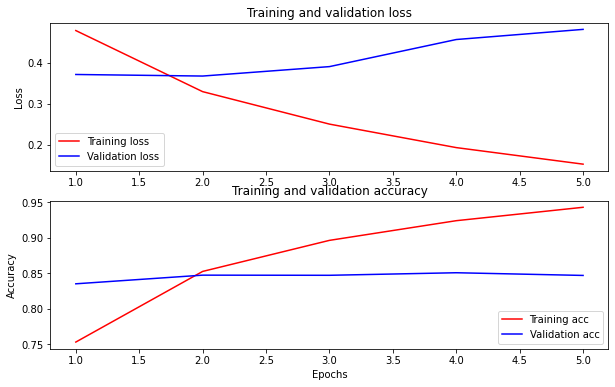

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2022-03-29 12:38:37.579124: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999303
input: The movie was great!           : score: 0.994674
input: The movie was meh.             : score: 0.830029
input: The movie was okish.           : score: 0.058384
input: The movie was terrible...      : score: 0.002682

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999303
input: The movie was great!           : score: 0.994674
input: The movie was meh.             : score: 0.830029
input: The movie was okish.           : score: 0.058384
input: The movie was terrible...      : score: 0.002682



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999303
input: The movie was great!           : score: 0.994674
input: The movie was meh.             : score: 0.830029
input: The movie was okish.           : score: 0.058384
input: The movie was terrible...      : score: 0.002682



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.